In [1]:
import os
import pickle
import logging
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
from matplotlib import rc
from definitions import ROOT_DIR
from data import imagenet
import matching
import scipy.stats
sns.set_context("paper")

# Set the font to be serif, rather than sans
sns.set(font='serif')
    
# Make the background white, and specify the
# specific font family
sns.set_style("white", {
    "font.family": "serif",
    "font.serif": ["Times", "Palatino", "serif"]
})
colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple"]
sns.set_palette(sns.xkcd_palette(colors))
plt.rc('text', usetex=True)

os.chdir('/home/darsh/Downloads/zsl_text_imagenet/') # https://github.com/sebastianbujwid/zsl_text_imagenet
logging.basicConfig(level=logging.INFO)

In [2]:
overwrite_config = {
}


configs = [
    ROOT_DIR/'configs'/'env_config.yml',
    ROOT_DIR/'configs'/'matching_config.yml',
]

config = OmegaConf.merge(
    OmegaConf.load(str(configs[0])),
    OmegaConf.load(str(configs[1])),
    OmegaConf.create(overwrite_config))
OmegaConf.set_readonly(config, True)
OmegaConf.set_struct(config, True)

args = {
}
args = OmegaConf.create(args)
OmegaConf.set_readonly(args, True)
OmegaConf.set_struct(args, True)



In [3]:
dataset_config = config.env.datasets.ImageNet
imagenet_id_details = imagenet.extract_imagenet_id_details(dataset_config['imagenet_ids_to_wordnet'])
# https://github.com/sebastianbujwid/ImageNet-Wiki_dataset/tree/main/class_article_text_descriptions
mp500_articles_file = ROOT_DIR/'ImageNet-Wiki_dataset-main/class_article_text_descriptions/class_article_text_descriptions_mp500.pkl'
mp500_articles = pickle.load(open(mp500_articles_file, 'rb'))

wnid_to_imagenet_id = imagenet.extract_wordnet_to_imagenet_id(ROOT_DIR/'ImageNet-Wiki_dataset-main/class_article_text_descriptions/class_article_text_descriptions_mp500.pkl')

def class_details(wnid):
    imagenet_id = wnid_to_imagenet_id[wnid]
    return imagenet_id_details[imagenet_id]

class_details(10348)

(['black-footed ferret', 'ferret', 'Mustela nigripes'],
 ['black-footed ferret', 'ferret', 'Mustela nigripes'])

In [8]:
glove_results_file = '/home/darsh/Downloads/zsl_text_imagenet/simple_zsl/eval/mp500/szsl_wemb_glove_wiki_ALL/test_runzslsrs-wemb-glove-1015_42/szsl_run001/2020-11-11_12-49-47_N_N/test_results_mp500.pkl'
glove_results = pickle.load(open(glove_results_file, 'rb'))


In [9]:
# https://github.com/sebastianbujwid/ImageNet-Wiki_dataset/tree/main/class_article_text_descriptions
mp500_articles_file = ROOT_DIR/'ImageNet-Wiki_dataset-main/class_article_text_descriptions/class_article_text_descriptions_mp500.pkl'
mp500_articles = pickle.load(open(mp500_articles_file, 'rb'))

In [11]:
print(len(mp500_articles), len(albert_results['test_unseen_top5_acc']))
print(albert_results.keys())

top5_acc_by_articles_length = []
for imagenet_id, v in mp500_articles.items():
    wnid = v['wnid']
    res = glove_results['test_unseen_top5_acc'][wnid]
    articles_length = 0
    for article in v['articles']:
        articles_length += len(article)
    top5_acc_by_articles_length.append((wnid, res, articles_length))

print(top5_acc_by_articles_length)

489 489
dict_keys(['test_unseen_top1_acc', 'test_unseen_top1_acc_mean', 'test_unseen_top1_acc_mean_allclasses', 'test_unseen_top5_acc', 'test_unseen_top5_acc_mean', 'test_unseen_top5_acc_mean_allclasses'])
[('n03114379', 0.58075804, 4059), ('n03898633', 0.717527, 10322), ('n02820210', 0.71172184, 7209), ('n02699770', 0.5930095, 10176), ('n02739550', 0.7278575, 4867), ('n03380724', 0.03068253, 2600), ('n00464894', 0.21309523, 53017), ('n01787835', 0.42370743, 31198), ('n04477219', 0.051255766, 15701), ('n02891788', 0.30432174, 26412), ('n02084071', 0.27074236, 9144), ('n02918595', 0.32979387, 17687), ('n04478512', 0.7437155, 3073), ('n03548402', 0.50758, 7617), ('n02987492', 0.48331273, 14932), ('n04217882', 0.68154037, 16506), ('n09988063', 0.0036518564, 16284), ('n00442847', 0.49825174, 20506), ('n03309808', 0.24146055, 17244), ('n12282933', 0.14555097, 6497), ('n01318894', 0.009305211, 21846), ('n03986704', 0.34238124, 4728), ('n04388743', 0.22724766, 13034), ('n04020298', 0.33705226

In [12]:
def r2(x, y):
    return scipy.stats.linregress(x, y).rvalue**2

def plot_fig(df, group=None, save=None):
    x, y = select_group(df, group)
    sns.regplot(x=x, y=y, marker='x',
                scatter_kws={"s": 10, 'alpha': 0.5},
               )
    #sns.jointplot(x, y, kind='reg', sta)
    plt.xlabel('$\log_{10}$\, class description length (in \# of characters)')
    plt.ylabel('Top-5 mean class accuracy')
    plt.text(x.min(), y.max() * 0.9, f'$R^2={r2(x, y):.3f}$')
    if save:
        plt.savefig(f'{save}.pdf', bbox_inches='tight')
    plt.show()


In [13]:
wnids, accs, lengths = zip(*top5_acc_by_articles_length)
groups = pickle.load(open('/home/darsh/Downloads/zsl_methods_imagenet-main/notebooks/excluding_groups/mp500_groups.pkl', 'rb'))

In [14]:
def wnid_to_groupname(wnid):
    if wnid in groups['animals']:
        return 'animals'
    elif wnid in groups['plants']:
        return 'plants'
    elif wnid in groups['other']:
        return 'other'
    else:
        raise ValueError(wnid)

In [15]:
df = pd.DataFrame.from_dict(
{
    'wnid': wnids,
    'acc': accs,
    'length': lengths,
    'group': list(map(wnid_to_groupname, wnids)),
})


def select_group(df, group=None):
    if group:
        sel = df[df['group'] == group]
    else:
        sel = df
    x = np.log10(np.array(sel['length']))
    y = np.array(sel['acc'])
    return x, y



2022-11-29 22:26:10,049 DEBUG                  pyplot.      switch_backend -:- Loaded backend module://matplotlib_inline.backend_inline version unknown.
2022-11-29 22:26:10,050 DEBUG                  pyplot.      switch_backend -:- Loaded backend module://matplotlib_inline.backend_inline version unknown.
2022-11-29 22:26:10,053 DEBUG            font_manager.    _findfont_cached -:- findfont: Matching serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
2022-11-29 22:26:10,054 DEBUG            font_manager.    _findfont_cached -:- findfont: score(FontEntry(fname='/home/darsh/.local/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralBol.ttf', name='STIXGeneral', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2022-11-29 22:26:10,055 DEBUG            font_manager.    _findfont_cached -:- findfont: score(FontEntry(fname='/home/darsh/.local/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniBo

2022-11-29 22:26:10,068 DEBUG            font_manager.    _findfont_cached -:- findfont: score(FontEntry(fname='/home/darsh/.local/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralBolIta.ttf', name='STIXGeneral', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2022-11-29 22:26:10,069 DEBUG            font_manager.    _findfont_cached -:- findfont: score(FontEntry(fname='/home/darsh/.local/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerifDisplay.ttf', name='DejaVu Serif Display', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-11-29 22:26:10,069 DEBUG            font_manager.    _findfont_cached -:- findfont: score(FontEntry(fname='/home/darsh/.local/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/cmr10.ttf', name='cmr10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-11-29 22:26:10,070 DEBUG         

2022-11-29 22:26:10,096 DEBUG            font_manager.    _findfont_cached -:- findfont: score(FontEntry(fname='/usr/share/fonts/opentype/urw-base35/C059-Bold.otf', name='C059', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2022-11-29 22:26:10,096 DEBUG            font_manager.    _findfont_cached -:- findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Loma-Bold.ttf', name='Loma', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2022-11-29 22:26:10,097 DEBUG            font_manager.    _findfont_cached -:- findfont: score(FontEntry(fname='/usr/share/fonts/truetype/fonts-yrsa-rasa/Rasa-Bold.ttf', name='Rasa', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2022-11-29 22:26:10,098 DEBUG            font_manager.    _findfont_cached -:- findfont: score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/Ubuntu-C.ttf', name='Ubuntu Condensed', style='no

2022-11-29 22:26:10,130 DEBUG            font_manager.    _findfont_cached -:- findfont: score(FontEntry(fname='/usr/share/fonts/truetype/fonts-kalapi/Kalapi.ttf', name='Kalapi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-11-29 22:26:10,131 DEBUG            font_manager.    _findfont_cached -:- findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation/LiberationSans-BoldItalic.ttf', name='Liberation Sans', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2022-11-29 22:26:10,132 DEBUG            font_manager.    _findfont_cached -:- findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Kinnari-Oblique.ttf', name='Kinnari', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2022-11-29 22:26:10,132 DEBUG            font_manager.    _findfont_cached -:- findfont: score(FontEntry(fname='/usr/share/fonts/truetype/fonts-orya-extra/utkal.tt

2022-11-29 22:26:10,174 DEBUG            font_manager.    _findfont_cached -:- findfont: score(FontEntry(fname='/usr/share/fonts/truetype/lao/Phetsarath_OT.ttf', name='Phetsarath OT', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-11-29 22:26:10,175 DEBUG            font_manager.    _findfont_cached -:- findfont: score(FontEntry(fname='/usr/share/fonts/opentype/urw-base35/NimbusSansNarrow-Oblique.otf', name='Nimbus Sans Narrow', style='oblique', variant='normal', weight=400, stretch='condensed', size='scalable')) = 11.25
2022-11-29 22:26:10,176 DEBUG            font_manager.    _findfont_cached -:- findfont: score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/UbuntuMono-RI.ttf', name='Ubuntu Mono', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2022-11-29 22:26:10,177 DEBUG            font_manager.    _findfont_cached -:- findfont: score(FontEntry(fname='/usr/share/fonts/truetype/lohit-telugu

2022-11-29 22:26:10,213 DEBUG            font_manager.    _findfont_cached -:- findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tibetan-machine/TibetanMachineUni.ttf', name='Tibetan Machine Uni', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-11-29 22:26:10,214 DEBUG            font_manager.    _findfont_cached -:- findfont: score(FontEntry(fname='/usr/share/fonts/truetype/lohit-bengali/Lohit-Bengali.ttf', name='Lohit Bengali', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-11-29 22:26:10,215 DEBUG            font_manager.    _findfont_cached -:- findfont: score(FontEntry(fname='/usr/share/fonts/truetype/freefont/FreeSansBoldOblique.ttf', name='FreeSans', style='oblique', variant='normal', weight=600, stretch='normal', size='scalable')) = 11.24
2022-11-29 22:26:10,215 DEBUG            font_manager.    _findfont_cached -:- findfont: score(FontEntry(fname='/usr/share/fonts/truetype/f

2022-11-29 22:26:10,236 DEBUG            font_manager.    _findfont_cached -:- findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Norasi-Oblique.ttf', name='Norasi', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2022-11-29 22:26:10,237 DEBUG            font_manager.    _findfont_cached -:- findfont: score(FontEntry(fname='/usr/share/fonts/truetype/malayalam/Uroob-Regular.ttf', name='Uroob', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-11-29 22:26:10,237 DEBUG            font_manager.    _findfont_cached -:- findfont: score(FontEntry(fname='/usr/share/fonts/truetype/kacst/KacstArt.ttf', name='KacstArt', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
2022-11-29 22:26:10,238 DEBUG            font_manager.    _findfont_cached -:- findfont: score(FontEntry(fname='/usr/share/fonts/truetype/fonts-gujr-extra/Rekha.ttf', name='Rekha', style='nor

2022-11-29 22:26:10,261 DEBUG            font_manager.    _findfont_cached -:- findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Loma-BoldOblique.ttf', name='Loma', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2022-11-29 22:26:10,262 DEBUG            font_manager.    _findfont_cached -:- findfont: score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-11-29 22:26:10,262 DEBUG            font_manager.    _findfont_cached -:- findfont: score(FontEntry(fname='/usr/share/fonts/truetype/fonts-yrsa-rasa/Yrsa-Bold.ttf', name='Yrsa', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2022-11-29 22:26:10,263 DEBUG            font_manager.    _findfont_cached -:- findfont: score(FontEntry(fname='/usr/share/fonts/opentype/urw-base35/NimbusRoman-Italic.otf', name='Nim

2022-11-29 22:26:10,284 DEBUG            font_manager.    _findfont_cached -:- findfont: score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/Ubuntu-B.ttf', name='Ubuntu', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2022-11-29 22:26:10,285 DEBUG            font_manager.    _findfont_cached -:- findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/TlwgMono-Bold.ttf', name='Tlwg Mono', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2022-11-29 22:26:10,285 DEBUG            font_manager.    _findfont_cached -:- findfont: score(FontEntry(fname='/usr/share/fonts/truetype/fonts-gujr-extra/padmaa-Medium-0.5.ttf', name='padmaa', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
2022-11-29 22:26:10,286 DEBUG            font_manager.    _findfont_cached -:- findfont: score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf', name='Deja

2022-11-29 22:26:10,303 DEBUG            font_manager.    _findfont_cached -:- findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Umpush-BoldOblique.ttf', name='Umpush', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2022-11-29 22:26:10,304 DEBUG            font_manager.    _findfont_cached -:- findfont: score(FontEntry(fname='/usr/share/fonts/opentype/urw-base35/NimbusSans-BoldItalic.otf', name='Nimbus Sans', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2022-11-29 22:26:10,304 DEBUG            font_manager.    _findfont_cached -:- findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation/LiberationMono-BoldItalic.ttf', name='Liberation Mono', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2022-11-29 22:26:10,305 DEBUG            font_manager.    _findfont_cached -:- findfont: score(FontEntry(fname='/usr/share/fonts/truetype/loh

2022-11-29 22:26:10,326 DEBUG            font_manager.    _findfont_cached -:- findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Umpush-Light.ttf', name='Umpush', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
2022-11-29 22:26:10,327 DEBUG            font_manager.    _findfont_cached -:- findfont: Matching serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Serif ('/home/darsh/.local/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif.ttf') with score of 0.050000.
2022-11-29 22:26:10,690 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Serif font is not compatible with usetex.
2022-11-29 22:26:10,690 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Serif font is not compatible with usetex.
2022-11-29 22:26:10,691 DEBUG              texmanager._get_font_preamble_a -:- family: serif, font: Computer Modern Roman, info: \usepackage{type1ec}
2022-11-29

2022-11-29 22:26:10,843 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Serif font is not compatible with usetex.
2022-11-29 22:26:10,844 DEBUG              texmanager._get_font_preamble_a -:- family: serif, font: Computer Modern Roman, info: \usepackage{type1ec}
2022-11-29 22:26:10,844 DEBUG              texmanager._get_font_preamble_a -:- Arial font is not compatible with usetex.
2022-11-29 22:26:10,845 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans font is not compatible with usetex.
2022-11-29 22:26:10,845 DEBUG              texmanager._get_font_preamble_a -:- Liberation Sans font is not compatible with usetex.
2022-11-29 22:26:10,846 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans font is not compatible with usetex.
2022-11-29 22:26:10,846 DEBUG              texmanager._get_font_preamble_a -:- family: sans-serif, font: sans-serif, info: 
2022-11-29 22:26:10,847 DEBUG              texmanager._get_font_preamble_a -

2022-11-29 22:26:10,905 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans Mono font is not compatible with usetex.
2022-11-29 22:26:10,906 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans Mono font is not compatible with usetex.
2022-11-29 22:26:10,907 DEBUG              texmanager._get_font_preamble_a -:- family: monospace, font: Computer Modern Typewriter, info: \usepackage{type1ec}
2022-11-29 22:26:10,908 DEBUG                 dviread.            __init__ -:- Dvi: /home/darsh/.cache/matplotlib/tex.cache/8b0a612bcf5325be28e9f7c8f6de1049.dvi
2022-11-29 22:26:10,913 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2022-11-29 22:26:10,914 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: header=l3backend-dvips.pro
2022-11-29 22:26:10,921 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Serif font is not compatible with usete

2022-11-29 22:26:10,996 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: header=l3backend-dvips.pro
2022-11-29 22:26:10,999 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Serif font is not compatible with usetex.
2022-11-29 22:26:11,000 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Serif font is not compatible with usetex.
2022-11-29 22:26:11,001 DEBUG              texmanager._get_font_preamble_a -:- family: serif, font: Computer Modern Roman, info: \usepackage{type1ec}
2022-11-29 22:26:11,002 DEBUG              texmanager._get_font_preamble_a -:- Arial font is not compatible with usetex.
2022-11-29 22:26:11,003 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans font is not compatible with usetex.
2022-11-29 22:26:11,004 DEBUG              texmanager._get_font_preamble_a -:- Liberation Sans font is not compatible with usetex.
2022-11-29 22:26:11,004 DEBUG              texmanager._get_font_preamb

2022-11-29 22:26:11,075 DEBUG              texmanager._get_font_preamble_a -:- Textile font is not compatible with usetex.
2022-11-29 22:26:11,076 DEBUG              texmanager._get_font_preamble_a -:- family: cursive, font: Zapf Chancery, info: \usepackage{chancery}
2022-11-29 22:26:11,076 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans Mono font is not compatible with usetex.
2022-11-29 22:26:11,077 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans Mono font is not compatible with usetex.
2022-11-29 22:26:11,077 DEBUG              texmanager._get_font_preamble_a -:- family: monospace, font: Computer Modern Typewriter, info: \usepackage{type1ec}
2022-11-29 22:26:11,078 DEBUG                 dviread.            __init__ -:- Dvi: /home/darsh/.cache/matplotlib/tex.cache/b17b7d3e5e7527168c84a5c8e471e42d.dvi
2022-11-29 22:26:11,080 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43

2022-11-29 22:26:11,147 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Serif font is not compatible with usetex.
2022-11-29 22:26:11,148 DEBUG              texmanager._get_font_preamble_a -:- family: serif, font: Computer Modern Roman, info: \usepackage{type1ec}
2022-11-29 22:26:11,148 DEBUG              texmanager._get_font_preamble_a -:- Arial font is not compatible with usetex.
2022-11-29 22:26:11,149 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans font is not compatible with usetex.
2022-11-29 22:26:11,149 DEBUG              texmanager._get_font_preamble_a -:- Liberation Sans font is not compatible with usetex.
2022-11-29 22:26:11,149 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans font is not compatible with usetex.
2022-11-29 22:26:11,150 DEBUG              texmanager._get_font_preamble_a -:- family: sans-serif, font: sans-serif, info: 
2022-11-29 22:26:11,151 DEBUG              texmanager._get_font_preamble_a -

2022-11-29 22:26:11,393 DEBUG              texmanager._get_font_preamble_a -:- family: serif, font: Computer Modern Roman, info: \usepackage{type1ec}
2022-11-29 22:26:11,394 DEBUG              texmanager._get_font_preamble_a -:- Arial font is not compatible with usetex.
2022-11-29 22:26:11,395 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans font is not compatible with usetex.
2022-11-29 22:26:11,395 DEBUG              texmanager._get_font_preamble_a -:- Liberation Sans font is not compatible with usetex.
2022-11-29 22:26:11,396 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans font is not compatible with usetex.
2022-11-29 22:26:11,397 DEBUG              texmanager._get_font_preamble_a -:- family: sans-serif, font: sans-serif, info: 
2022-11-29 22:26:11,398 DEBUG              texmanager._get_font_preamble_a -:- Apple Chancery font is not compatible with usetex.
2022-11-29 22:26:11,398 DEBUG              texmanager._get_font_preamble_a -:- Tex

2022-11-29 22:26:11,478 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans Mono font is not compatible with usetex.
2022-11-29 22:26:11,479 DEBUG              texmanager._get_font_preamble_a -:- family: monospace, font: Computer Modern Typewriter, info: \usepackage{type1ec}
2022-11-29 22:26:11,481 DEBUG                 dviread.            __init__ -:- Dvi: /home/darsh/.cache/matplotlib/tex.cache/6a9fc2f080a9310f3ec0a78f57945c56.dvi
2022-11-29 22:26:11,482 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2022-11-29 22:26:11,483 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: header=l3backend-dvips.pro
2022-11-29 22:26:11,484 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Serif font is not compatible with usetex.
2022-11-29 22:26:11,485 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Serif font is not compatible with u

2022-11-29 22:26:11,541 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans font is not compatible with usetex.
2022-11-29 22:26:11,541 DEBUG              texmanager._get_font_preamble_a -:- Liberation Sans font is not compatible with usetex.
2022-11-29 22:26:11,542 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans font is not compatible with usetex.
2022-11-29 22:26:11,542 DEBUG              texmanager._get_font_preamble_a -:- family: sans-serif, font: sans-serif, info: 
2022-11-29 22:26:11,542 DEBUG              texmanager._get_font_preamble_a -:- Apple Chancery font is not compatible with usetex.
2022-11-29 22:26:11,543 DEBUG              texmanager._get_font_preamble_a -:- Textile font is not compatible with usetex.
2022-11-29 22:26:11,543 DEBUG              texmanager._get_font_preamble_a -:- family: cursive, font: Zapf Chancery, info: \usepackage{chancery}
2022-11-29 22:26:11,544 DEBUG              texmanager._get_font_preamble_a -:- DejaVu

2022-11-29 22:26:11,584 DEBUG                 dviread.            __init__ -:- Dvi: /home/darsh/.cache/matplotlib/tex.cache/4c7e23f3269338f8a486be734ebe2f02.dvi
2022-11-29 22:26:11,586 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2022-11-29 22:26:11,587 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: header=l3backend-dvips.pro
2022-11-29 22:26:11,589 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Serif font is not compatible with usetex.
2022-11-29 22:26:11,589 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Serif font is not compatible with usetex.
2022-11-29 22:26:11,590 DEBUG              texmanager._get_font_preamble_a -:- family: serif, font: Computer Modern Roman, info: \usepackage{type1ec}
2022-11-29 22:26:11,591 DEBUG              texmanager._get_font_preamble_a -:- Arial font is not compatible with usetex.
2022-11-29 22:26:11,5

2022-11-29 22:26:11,634 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans font is not compatible with usetex.
2022-11-29 22:26:11,635 DEBUG              texmanager._get_font_preamble_a -:- family: sans-serif, font: sans-serif, info: 
2022-11-29 22:26:11,635 DEBUG              texmanager._get_font_preamble_a -:- Apple Chancery font is not compatible with usetex.
2022-11-29 22:26:11,636 DEBUG              texmanager._get_font_preamble_a -:- Textile font is not compatible with usetex.
2022-11-29 22:26:11,637 DEBUG              texmanager._get_font_preamble_a -:- family: cursive, font: Zapf Chancery, info: \usepackage{chancery}
2022-11-29 22:26:11,638 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans Mono font is not compatible with usetex.
2022-11-29 22:26:11,638 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans Mono font is not compatible with usetex.
2022-11-29 22:26:11,639 DEBUG              texmanager._get_font_preambl

2022-11-29 22:26:11,719 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2022-11-29 22:26:11,720 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: header=l3backend-dvips.pro
2022-11-29 22:26:11,728 DEBUG             backend_pdf.         dviFontName -:- Assigning font /F1 = b'cmr10' (dvi)
2022-11-29 22:26:11,729 DEBUG             backend_pdf.         dviFontName -:- Assigning font /F2 = b'cmmi10' (dvi)
2022-11-29 22:26:11,731 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Serif font is not compatible with usetex.
2022-11-29 22:26:11,732 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Serif font is not compatible with usetex.
2022-11-29 22:26:11,733 DEBUG              texmanager._get_font_preamble_a -:- family: serif, font: Computer Modern Roman, info: \usepackage{type1ec}
2022-11-29 22:26:11,734 DEBUG              texmanager._get_font_preamble

2022-11-29 22:26:11,774 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans font is not compatible with usetex.
2022-11-29 22:26:11,775 DEBUG              texmanager._get_font_preamble_a -:- family: sans-serif, font: sans-serif, info: 
2022-11-29 22:26:11,775 DEBUG              texmanager._get_font_preamble_a -:- Apple Chancery font is not compatible with usetex.
2022-11-29 22:26:11,776 DEBUG              texmanager._get_font_preamble_a -:- Textile font is not compatible with usetex.
2022-11-29 22:26:11,777 DEBUG              texmanager._get_font_preamble_a -:- family: cursive, font: Zapf Chancery, info: \usepackage{chancery}
2022-11-29 22:26:11,777 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans Mono font is not compatible with usetex.
2022-11-29 22:26:11,778 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans Mono font is not compatible with usetex.
2022-11-29 22:26:11,778 DEBUG              texmanager._get_font_preambl

2022-11-29 22:26:11,826 DEBUG                 dviread.            __init__ -:- Dvi: /home/darsh/.cache/matplotlib/tex.cache/41126496caa29988ab913f01accc82b1.dvi
2022-11-29 22:26:11,827 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2022-11-29 22:26:11,828 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: header=l3backend-dvips.pro
2022-11-29 22:26:11,830 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Serif font is not compatible with usetex.
2022-11-29 22:26:11,830 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Serif font is not compatible with usetex.
2022-11-29 22:26:11,831 DEBUG              texmanager._get_font_preamble_a -:- family: serif, font: Computer Modern Roman, info: \usepackage{type1ec}
2022-11-29 22:26:11,831 DEBUG              texmanager._get_font_preamble_a -:- Arial font is not compatible with usetex.
2022-11-29 22:26:11,8

2022-11-29 22:26:11,866 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans font is not compatible with usetex.
2022-11-29 22:26:11,868 DEBUG              texmanager._get_font_preamble_a -:- family: sans-serif, font: sans-serif, info: 
2022-11-29 22:26:11,868 DEBUG              texmanager._get_font_preamble_a -:- Apple Chancery font is not compatible with usetex.
2022-11-29 22:26:11,870 DEBUG              texmanager._get_font_preamble_a -:- Textile font is not compatible with usetex.
2022-11-29 22:26:11,870 DEBUG              texmanager._get_font_preamble_a -:- family: cursive, font: Zapf Chancery, info: \usepackage{chancery}
2022-11-29 22:26:11,871 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans Mono font is not compatible with usetex.
2022-11-29 22:26:11,872 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans Mono font is not compatible with usetex.
2022-11-29 22:26:11,872 DEBUG              texmanager._get_font_preambl

2022-11-29 22:26:11,958 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2022-11-29 22:26:11,960 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: header=l3backend-dvips.pro
2022-11-29 22:26:11,962 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Serif font is not compatible with usetex.
2022-11-29 22:26:11,963 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Serif font is not compatible with usetex.
2022-11-29 22:26:11,964 DEBUG              texmanager._get_font_preamble_a -:- family: serif, font: Computer Modern Roman, info: \usepackage{type1ec}
2022-11-29 22:26:11,964 DEBUG              texmanager._get_font_preamble_a -:- Arial font is not compatible with usetex.
2022-11-29 22:26:11,965 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans font is not compatible with usetex.
2022-11-29 22:26:11,965 DEBUG              texmanager._

2022-11-29 22:26:12,024 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 605: 'pop'
2022-11-29 22:26:12,024 DEBUG              _type1font.            __init__ -:- type1font._Token boolean at 609: 'false'
2022-11-29 22:26:12,025 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 614: '}'
2022-11-29 22:26:12,025 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 615: 'ifelse'
2022-11-29 22:26:12,026 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 622: '{'
2022-11-29 22:26:12,026 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 623: 'save'
2022-11-29 22:26:12,027 DEBUG              _type1font.            __init__ -:- type1font._Token boolean at 628: 'true'
2022-11-29 22:26:12,027 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 632: '}'
2022-11-29 22:26:12,028 DEBUG              _type1

2022-11-29 22:26:12,065 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1037: 'readonly'
2022-11-29 22:26:12,066 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1046: 'def'
2022-11-29 22:26:12,066 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1051: '/FullName'
2022-11-29 22:26:12,067 DEBUG              _type1font.            __init__ -:- type1font._Token string at 1061: '(CMMI10)'
2022-11-29 22:26:12,068 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1070: 'readonly'
2022-11-29 22:26:12,068 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1079: 'def'
2022-11-29 22:26:12,069 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1084: '/FamilyName'
2022-11-29 22:26:12,070 DEBUG              _type1font.            __init__ -:- type1font._Token string at 1096: '(Computer Modern)'
2022-11-29 22

2022-11-29 22:26:12,153 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1454: 'put'
2022-11-29 22:26:12,154 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1458: 'dup'
2022-11-29 22:26:12,154 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1462: '6'
2022-11-29 22:26:12,155 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1464: '/Sigma'
2022-11-29 22:26:12,155 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1471: 'put'
2022-11-29 22:26:12,156 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1475: 'dup'
2022-11-29 22:26:12,156 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1479: '7'
2022-11-29 22:26:12,157 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1481: '/Upsilon'
2022-11-29 22:26:12,157 DEBUG              _type1fon

2022-11-29 22:26:12,193 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1758: '23'
2022-11-29 22:26:12,193 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1761: '/nu'
2022-11-29 22:26:12,194 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1765: 'put'
2022-11-29 22:26:12,195 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1769: 'dup'
2022-11-29 22:26:12,195 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1773: '24'
2022-11-29 22:26:12,196 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1776: '/xi'
2022-11-29 22:26:12,196 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1780: 'put'
2022-11-29 22:26:12,197 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1784: 'dup'
2022-11-29 22:26:12,197 DEBUG              _type1font.    

2022-11-29 22:26:12,235 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2068: 'put'
2022-11-29 22:26:12,235 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2072: 'dup'
2022-11-29 22:26:12,236 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2076: '41'
2022-11-29 22:26:12,236 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2079: '/arrowleftbothalf'
2022-11-29 22:26:12,237 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2097: 'put'
2022-11-29 22:26:12,237 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2101: 'dup'
2022-11-29 22:26:12,238 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2105: '42'
2022-11-29 22:26:12,238 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2108: '/arrowrighttophalf'
2022-11-29 22:26:12,239 DEBUG

2022-11-29 22:26:12,295 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2511: 'put'
2022-11-29 22:26:12,296 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2515: 'dup'
2022-11-29 22:26:12,297 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2519: '58'
2022-11-29 22:26:12,298 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2522: '/period'
2022-11-29 22:26:12,299 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2530: 'put'
2022-11-29 22:26:12,300 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2534: 'dup'
2022-11-29 22:26:12,301 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2538: '59'
2022-11-29 22:26:12,303 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2541: '/comma'
2022-11-29 22:26:12,305 DEBUG              _type1fo

2022-11-29 22:26:12,387 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2792: '75'
2022-11-29 22:26:12,388 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2795: '/K'
2022-11-29 22:26:12,389 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2798: 'put'
2022-11-29 22:26:12,391 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2802: 'dup'
2022-11-29 22:26:12,392 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2806: '76'
2022-11-29 22:26:12,393 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2809: '/L'
2022-11-29 22:26:12,394 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2812: 'put'
2022-11-29 22:26:12,396 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2816: 'dup'
2022-11-29 22:26:12,397 DEBUG              _type1font.      

2022-11-29 22:26:12,476 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3045: 'put'
2022-11-29 22:26:12,477 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3049: 'dup'
2022-11-29 22:26:12,477 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3053: '93'
2022-11-29 22:26:12,477 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3056: '/sharp'
2022-11-29 22:26:12,478 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3063: 'put'
2022-11-29 22:26:12,478 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3067: 'dup'
2022-11-29 22:26:12,479 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3071: '94'
2022-11-29 22:26:12,479 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3074: '/slurbelow'
2022-11-29 22:26:12,480 DEBUG              _type

2022-11-29 22:26:12,534 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3327: '110'
2022-11-29 22:26:12,534 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3331: '/n'
2022-11-29 22:26:12,534 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3334: 'put'
2022-11-29 22:26:12,535 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3338: 'dup'
2022-11-29 22:26:12,536 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3342: '111'
2022-11-29 22:26:12,536 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3346: '/o'
2022-11-29 22:26:12,537 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3349: 'put'
2022-11-29 22:26:12,537 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3353: 'dup'
2022-11-29 22:26:12,538 DEBUG              _type1font.    

2022-11-29 22:26:12,579 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3620: 'put'
2022-11-29 22:26:12,579 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3624: 'dup'
2022-11-29 22:26:12,580 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3628: '128'
2022-11-29 22:26:12,580 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3632: '/psi'
2022-11-29 22:26:12,581 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3637: 'put'
2022-11-29 22:26:12,581 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3641: 'dup'
2022-11-29 22:26:12,581 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3645: '160'
2022-11-29 22:26:12,585 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3649: '/space'
2022-11-29 22:26:12,585 DEBUG              _type1fon

2022-11-29 22:26:12,635 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3941: '178'
2022-11-29 22:26:12,639 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3945: '/epsilon1'
2022-11-29 22:26:12,640 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3955: 'put'
2022-11-29 22:26:12,641 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3959: 'dup'
2022-11-29 22:26:12,642 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3963: '179'
2022-11-29 22:26:12,644 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3967: '/zeta'
2022-11-29 22:26:12,645 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3973: 'put'
2022-11-29 22:26:12,646 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3977: 'dup'
2022-11-29 22:26:12,647 DEBUG              _type

2022-11-29 22:26:12,723 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4255: 'put'
2022-11-29 22:26:12,724 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4259: 'dup'
2022-11-29 22:26:12,725 DEBUG              _type1font.            __init__ -:- type1font._Token number at 4263: '196'
2022-11-29 22:26:12,726 DEBUG              _type1font.            __init__ -:- type1font._Token name at 4267: '/tie'
2022-11-29 22:26:12,729 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4272: 'put'
2022-11-29 22:26:12,731 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4276: 'readonly'
2022-11-29 22:26:12,732 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4285: 'def'
2022-11-29 22:26:12,733 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4289: 'currentdict'
2022-11-29 22:26:12,733 DEBUG         

2022-11-29 22:26:12,783 DEBUG              _type1font.            __init__ -:- type1font._Token ? at 4553: '[ -22 0 431 442 453 466 683 705 ]'
2022-11-29 22:26:12,784 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4587: 'ND'
2022-11-29 22:26:12,784 DEBUG              _type1font.            __init__ -:- type1font._Token name at 4590: '/OtherBlues'
2022-11-29 22:26:12,785 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 4602: '['
2022-11-29 22:26:12,785 DEBUG              _type1font.            __init__ -:- type1font._Token number at 4604: '-205'
2022-11-29 22:26:12,786 DEBUG              _type1font.            __init__ -:- type1font._Token number at 4609: '-194'
2022-11-29 22:26:12,787 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 4614: ']'
2022-11-29 22:26:12,787 DEBUG              _type1font.            __init__ -:- type1font._Token ? at 4602: '[ -205 -194 ]'
2022-11-29 22:26

2022-11-29 22:26:12,825 DEBUG              _type1font.            __init__ -:- type1font._Token name at 5079: '/internaldict'
2022-11-29 22:26:12,825 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 5093: '{'
2022-11-29 22:26:12,826 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5094: 'count'
2022-11-29 22:26:12,826 DEBUG              _type1font.            __init__ -:- type1font._Token number at 5100: '0'
2022-11-29 22:26:12,827 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5102: 'eq'
2022-11-29 22:26:12,827 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 5105: '{'
2022-11-29 22:26:12,828 DEBUG              _type1font.            __init__ -:- type1font._Token name at 5106: '/internaldict'
2022-11-29 22:26:12,828 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5120: 'errordict'
2022-11-29 22:26:12,829 DEBUG 

2022-11-29 22:26:12,860 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 5456: '}'
2022-11-29 22:26:12,861 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5458: 'ifelse'
2022-11-29 22:26:12,861 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 5465: '['
2022-11-29 22:26:12,862 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5467: 'systemdict'
2022-11-29 22:26:12,862 DEBUG              _type1font.            __init__ -:- type1font._Token name at 5478: '/internaldict'
2022-11-29 22:26:12,863 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5492: 'known'
2022-11-29 22:26:12,864 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5498: 'not'
2022-11-29 22:26:12,864 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 5502: '{'
2022-11-29 22:26:12,865 DEBUG

2022-11-29 22:26:12,923 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5861: 'if'
2022-11-29 22:26:12,924 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 5863: '}'
2022-11-29 22:26:12,924 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 5865: '{'
2022-11-29 22:26:12,925 DEBUG              _type1font.            __init__ -:- type1font._Token number at 5866: '100'
2022-11-29 22:26:12,925 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5870: 'dict'
2022-11-29 22:26:12,925 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5875: 'begin'
2022-11-29 22:26:12,926 DEBUG              _type1font.            __init__ -:- type1font._Token name at 5881: '/mtx'
2022-11-29 22:26:12,926 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5886: 'matrix'
2022-11-29 22:26:12,926 DEBUG              _ty

2022-11-29 22:26:12,965 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6223: 'c4x2'
2022-11-29 22:26:12,966 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6228: 'def'
2022-11-29 22:26:12,966 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6232: '/c2y2'
2022-11-29 22:26:12,966 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6238: 'c4y2'
2022-11-29 22:26:12,967 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6243: 'def'
2022-11-29 22:26:12,967 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6247: '/yflag'
2022-11-29 22:26:12,968 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6254: 'c1y2'
2022-11-29 22:26:12,971 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6259: 'c3y2'
2022-11-29 22:26:12,972 DEBUG              _t

2022-11-29 22:26:13,008 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6552: '/x0'
2022-11-29 22:26:13,009 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6556: 'exdef'
2022-11-29 22:26:13,009 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 6562: '}'
2022-11-29 22:26:13,009 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6564: 'def'
2022-11-29 22:26:13,010 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6568: 'mtx'
2022-11-29 22:26:13,010 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6572: 'currentmatrix'
2022-11-29 22:26:13,011 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6586: 'pop'
2022-11-29 22:26:13,011 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6590: 'mtx'
2022-11-29 22:26:13,012 DEBUG          

2022-11-29 22:26:13,051 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6879: 'get'
2022-11-29 22:26:13,052 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6883: '/erosion'
2022-11-29 22:26:13,052 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6892: 'exch'
2022-11-29 22:26:13,053 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6897: 'def'
2022-11-29 22:26:13,053 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 6900: '}'
2022-11-29 22:26:13,054 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 6902: '{'
2022-11-29 22:26:13,055 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6903: 'pop'
2022-11-29 22:26:13,055 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 6906: '}'
2022-11-29 22:26:13,056 DEBUG              _t

2022-11-29 22:26:13,103 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7180: 'def'
2022-11-29 22:26:13,104 DEBUG              _type1font.            __init__ -:- type1font._Token name at 7184: '/c1x0'
2022-11-29 22:26:13,105 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7190: 'c3x0'
2022-11-29 22:26:13,106 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7195: 'def'
2022-11-29 22:26:13,108 DEBUG              _type1font.            __init__ -:- type1font._Token name at 7199: '/c1x1'
2022-11-29 22:26:13,109 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7205: 'c3x1'
2022-11-29 22:26:13,110 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7210: 'def'
2022-11-29 22:26:13,116 DEBUG              _type1font.            __init__ -:- type1font._Token name at 7214: '/c2x0'
2022-11-29 22:26:13,116 DEBUG              _type1

2022-11-29 22:26:13,145 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 7484: '}'
2022-11-29 22:26:13,146 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7486: 'if'
2022-11-29 22:26:13,146 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7489: 'pop'
2022-11-29 22:26:13,147 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7493: 'def'
2022-11-29 22:26:13,147 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7497: 'dY'
2022-11-29 22:26:13,148 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7500: 'round'
2022-11-29 22:26:13,152 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7506: 'dup'
2022-11-29 22:26:13,152 DEBUG              _type1font.            __init__ -:- type1font._Token number at 7510: '0'
2022-11-29 22:26:13,153 DEBUG              _type1fo

2022-11-29 22:26:13,180 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7732: 'if'
2022-11-29 22:26:13,186 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7735: 'ey'
2022-11-29 22:26:13,186 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7738: 'cx'
2022-11-29 22:26:13,187 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7741: 'flipXY'
2022-11-29 22:26:13,187 DEBUG              _type1font.            __init__ -:- type1font._Token number at 7748: '1'
2022-11-29 22:26:13,188 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7750: 'eq'
2022-11-29 22:26:13,188 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 7753: '{'
2022-11-29 22:26:13,188 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7754: 'exch'
2022-11-29 22:26:13,189 DEBUG              _type1fo

2022-11-29 22:26:13,221 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8007: 'def'
2022-11-29 22:26:13,222 DEBUG              _type1font.            __init__ -:- type1font._Token name at 8011: '/xshrink'
2022-11-29 22:26:13,222 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 8020: '{'
2022-11-29 22:26:13,223 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8021: 'c4x2'
2022-11-29 22:26:13,223 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8026: 'sub'
2022-11-29 22:26:13,223 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8030: 'shrink'
2022-11-29 22:26:13,224 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8037: 'mul'
2022-11-29 22:26:13,224 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8041: 'c4x2'
2022-11-29 22:26:13,225 DEBUG            

2022-11-29 22:26:13,256 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8338: 'transform'
2022-11-29 22:26:13,256 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8348: 'flipXY'
2022-11-29 22:26:13,257 DEBUG              _type1font.            __init__ -:- type1font._Token number at 8355: '-1'
2022-11-29 22:26:13,257 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8358: 'eq'
2022-11-29 22:26:13,257 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 8361: '{'
2022-11-29 22:26:13,258 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8362: 'exch'
2022-11-29 22:26:13,258 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 8366: '}'
2022-11-29 22:26:13,258 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8368: 'if'
2022-11-29 22:26:13,259 DEBUG             

2022-11-29 22:26:13,285 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8600: 'sub'
2022-11-29 22:26:13,285 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8604: 'def'
2022-11-29 22:26:13,286 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 8607: '}'
2022-11-29 22:26:13,297 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8609: 'if'
2022-11-29 22:26:13,298 DEBUG              _type1font.            __init__ -:- type1font._Token name at 8612: '/ex'
2022-11-29 22:26:13,298 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8616: 'cx'
2022-11-29 22:26:13,299 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8619: 'dX'
2022-11-29 22:26:13,299 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8622: 'add'
2022-11-29 22:26:13,300 DEBUG              _type1font.

2022-11-29 22:26:13,383 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8870: 'eq'
2022-11-29 22:26:13,384 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8873: 'or'
2022-11-29 22:26:13,384 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 8876: '{'
2022-11-29 22:26:13,386 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8877: 'x5'
2022-11-29 22:26:13,388 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8880: 'y5'
2022-11-29 22:26:13,389 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8883: 'lineto'
2022-11-29 22:26:13,389 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 8889: '}'
2022-11-29 22:26:13,390 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 8891: '{'
2022-11-29 22:26:13,391 DEBUG              _type1

2022-11-29 22:26:13,424 DEBUG              _type1font.            __init__ -:- type1font._Token name at 9215: '/internaldict'
2022-11-29 22:26:13,425 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9229: 'get'
2022-11-29 22:26:13,425 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9233: 'exec'
2022-11-29 22:26:13,426 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9238: 'dup'
2022-11-29 22:26:13,427 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9242: 'length'
2022-11-29 22:26:13,427 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9249: 'exch'
2022-11-29 22:26:13,428 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9254: 'maxlength'
2022-11-29 22:26:13,428 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9264: 'eq'
2022-11-29 22:26:13,429 DEBUG  

2022-11-29 22:26:13,499 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9610: 'currentpoint'
2022-11-29 22:26:13,500 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9623: 'grestore'
2022-11-29 22:26:13,501 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9632: 'gsave'
2022-11-29 22:26:13,502 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9638: 'currentpoint'
2022-11-29 22:26:13,502 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9651: 'newpath'
2022-11-29 22:26:13,503 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9659: 'moveto'
2022-11-29 22:26:13,504 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9665: '}'
2022-11-29 22:26:13,505 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9667: 'executeonly'
2022-11-

2022-11-29 22:26:13,546 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9899: 'ND'
2022-11-29 22:26:13,546 DEBUG              _type1font.            __init__ -:- type1font._Token name at 9902: '/Subrs'
2022-11-29 22:26:13,548 DEBUG              _type1font.            __init__ -:- type1font._Token number at 9909: '8'
2022-11-29 22:26:13,549 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9911: 'array'
2022-11-29 22:26:13,549 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9917: 'dup'
2022-11-29 22:26:13,550 DEBUG              _type1font.            __init__ -:- type1font._Token number at 9921: '0'
2022-11-29 22:26:13,551 DEBUG              _type1font.            __init__ -:- type1font._Token number at 9923: '15'
2022-11-29 22:26:13,553 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9926: 'RD'
2022-11-29 22:26:13,554 DEBUG              _type1font.  

2022-11-29 22:26:13,603 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 10360: b' \x10\xbf1py\xc8/\x06\x80'
2022-11-29 22:26:13,603 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10371: 'ND'
2022-11-29 22:26:13,604 DEBUG              _type1font.            __init__ -:- type1font._Token name at 10374: '/Gamma'
2022-11-29 22:26:13,604 DEBUG              _type1font.            __init__ -:- type1font._Token number at 10381: '206'
2022-11-29 22:26:13,605 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10385: 'RD'
2022-11-29 22:26:13,605 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 10387: b' \x10\xbf1p@\xc2\x94W\x98\x9c\xfe\xce\x8f\xe1\xa01\r\xc7\x11\x1c\x8a\xbed\xbd\xb3W\x8esgi\xe4\x84\xfe\x80A\x12\xcdR\x10`\x7f\xc3"|\x16\x14\xc61\x14\xe8\xa5\xcf6\xd0\xf5\x82\xcd\x05\x9e\x11\xa7\xeek\x0cgz\x9c.D:{ \xcbsd\x84\xd6\x90\xc9k+s\x7fQ\x96H\xe4p\xdc\xf0\xf8\x

2022-11-29 22:26:13,631 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 11895: 'ND'
2022-11-29 22:26:13,632 DEBUG              _type1font.            __init__ -:- type1font._Token name at 11898: '/Upsilon'
2022-11-29 22:26:13,632 DEBUG              _type1font.            __init__ -:- type1font._Token number at 11907: '265'
2022-11-29 22:26:13,633 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 11911: 'RD'
2022-11-29 22:26:13,634 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 11913: b" \x10\xbf1pU\xd1\xe9\xe6)V\xa7\x8b\x16\xf5\xe62\x1e\xea+0\xc6f\x03WN&L\xc9\x90\xa2\xe5/6\xdc#fEE\xf1\x82\xc6\x9f\xd8\xc43i?\xfdfxJ\x80\x8e\x18\xa2^\xc9\x06y=\x16\xaa;vI\xe6\xc3\x92&\xc43\xb2\x0f#\x828\xe1\xdeF%W\xf7\x18\x93\xff\xbdr,\xd8\xb9\xfe\xd8\xe6[,\x86IGl\xc1\xf4\xfd\x99\x98SU\xda\xed\x9fq,\x0fKK(yt\xdf\xcbG\xd7N\\\xe5\xf0\x9a\xf2e\xe8HG\xb9\x9f\x0b\xd9\t\x8b\x0e\xd0AX8\xef\xb7xS\xc7\xd74<\xc0l\x

2022-11-29 22:26:13,650 DEBUG              _type1font.            __init__ -:- type1font._Token name at 13598: '/gamma'
2022-11-29 22:26:13,651 DEBUG              _type1font.            __init__ -:- type1font._Token number at 13605: '143'
2022-11-29 22:26:13,651 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 13609: 'RD'
2022-11-29 22:26:13,652 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 13611: b' \x10\xbf1po\xd8\x1fa\xe6x\x0b\xcfK\x02(b\xe2\xc4\xbax\xe4\x11\xf9\x96#\x08\x9c\xaeO\xd1dcW\xac\xf6Z\x7f5~iN\x01\x15\xf5M|\x14;\xc3\x837\xae\x8d\xea\xe4\xf0/\x00#ky\x01\xc33\xb2\xf0Fg\xcb\xe4\xd5\x08xS\x18\xa7\xd9 s\x8a%\x12u\x00\xceB\nL\x97\x91fT\x14\x12\xd0,\xb1\'+\x1fP\x13"\xc2\xa2\x99\x8f\xde\xa4\xd7Fo\xd1\xc8\xc4/\xa9q\x97\xbdv\xbd\x0f\xd0\x81dQ\x142w\xc2\x15\xa6i\xdf\x98K\xceCy"^\xcc'
2022-11-29 22:26:13,652 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 13756: 'ND'
2022-11-29 22:

2022-11-29 22:26:13,677 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 15031: 'ND'
2022-11-29 22:26:13,680 DEBUG              _type1font.            __init__ -:- type1font._Token name at 15034: '/lambda'
2022-11-29 22:26:13,680 DEBUG              _type1font.            __init__ -:- type1font._Token number at 15042: '121'
2022-11-29 22:26:13,681 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 15046: 'RD'
2022-11-29 22:26:13,681 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 15048: b' \x10\xbf1p2\x08\xd9v\xdct\x0en-\xfe\xaf\x81(\x94]\x00\xd0~eU(\xf4\x8a\xc6f5\'kV\x18`\xb5\xd2\\\x82\x08\xa1\xe4\xcf\xefpe\x85\x19\x96\x93\xd4\xc1\xd7>)\x19\xa1\xfd\xcd{\xd5|\xd2F\r$\xdb\xa18\xd6\xf8\xf4\xcfx9\xeb\xbd@\xd6\x170\xf0{W>\xd0\x18\xd2\xc53^\xdfr>\xc3S9\xd8?"x\xad\xbb\x13\xf4\x8f\xa7b\xa7\xa1M\xea!\xc9\xcdO1\x83\x9e9\xe8'
2022-11-29 22:26:13,682 DEBUG              _type1font.            __init_

2022-11-29 22:26:13,699 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 16408: b' \x10\xbf1pT\xa2\xfb\xd5[\x95fv\xf6C\xbcQ3w>\xe2i\xfcy\xbcWAe\xca\xb9\xc4\x99TL\xe8\xa6\xc3Q8C!\x16\x03\xcad.\xe3\x1e\xc0k\xb9\x0f2\\\xca\xd1GR\tv\x16\x80\xe7\x80\xf8~\xd8g!.\x1f\x19\x0c\xcc}\xe9Rt\xd1@\x02\xcf\x81\x8a>\xf5%9$\x81\xfbs\xbd\xdcPy\xe8'
2022-11-29 22:26:13,699 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 16506: 'ND'
2022-11-29 22:26:13,699 DEBUG              _type1font.            __init__ -:- type1font._Token name at 16509: '/upsilon'
2022-11-29 22:26:13,700 DEBUG              _type1font.            __init__ -:- type1font._Token number at 16518: '164'
2022-11-29 22:26:13,700 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 16522: 'RD'
2022-11-29 22:26:13,700 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 16524: b" \x10\xbf1pZ\xc9s,\x90n\xe8|\xfa\xd4\xe4

2022-11-29 22:26:13,715 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 17996: 'ND'
2022-11-29 22:26:13,716 DEBUG              _type1font.            __init__ -:- type1font._Token name at 17999: '/pi1'
2022-11-29 22:26:13,716 DEBUG              _type1font.            __init__ -:- type1font._Token number at 18004: '211'
2022-11-29 22:26:13,717 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 18008: 'RD'
2022-11-29 22:26:13,717 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 18010: b' \x10\xbf1pT\xa3P\x9d\x94\x93\xcdO\xc8\\i\x86\xc2L`\xce\x81@\x00\xa7\x12Y\xee\x93!\xdd\x87\x83\xa1\xac\x0e\xabz*F/\x89\x90;n(eM\xc4\xe9\xe2F2+\x85f\x18\x13\'\x10T\xfb\x14i\x0b\xf5\x7f3\x1fz|\xdfQQEz\xb8\x97\xe2\xdd,\xb5\xb3!E\xedD}\t0\x05\xaa+\xc5\x9f\xb5\xc8\x11?EGeU\x039\xb9O\x18+\xfd[$b:\x91\x9d7\xd9\x1c\xb6\xb4\x86\x01\xa8\xd4\x1ac\xa2\x04\x97n\xc8\x03\xb2;D\x08\xe0\xf24\x1f*7b\xfdVw\xfe\xa5\x1b\xa7\xc7

2022-11-29 22:26:13,750 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 19239: b' \x10\xbf1p0\xa41\xaf\xb3W\xdb\x87\x9aI\xd3(5d\x19\x97o\x02\xe4\xb6\xa8d\x15}\xffF]\xed\xcf?]\x0b\x88\xddi\xa4\x1c\x0c\xe7\x0f\x18\x8f\x90:\xe0\xb7q\x91~1$\xbd\x89\x0e\xb7\xd2\x9b\xe9\xfd\xcd\xebSY\xe4\x97\xbe!\xfd\xa6\xe3'
2022-11-29 22:26:13,751 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 19315: 'ND'
2022-11-29 22:26:13,751 DEBUG              _type1font.            __init__ -:- type1font._Token name at 19318: '/arrowhookright'
2022-11-29 22:26:13,751 DEBUG              _type1font.            __init__ -:- type1font._Token number at 19334: '75'
2022-11-29 22:26:13,752 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 19337: 'RD'
2022-11-29 22:26:13,752 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 19339: b' \x10\xbf1p0\xa41\xaf\xb3W\xdb\x87\x9aI\xd3(N\xed\x15\xb5\xf6

2022-11-29 22:26:13,776 DEBUG              _type1font.            __init__ -:- type1font._Token number at 20506: '204'
2022-11-29 22:26:13,777 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 20510: 'RD'
2022-11-29 22:26:13,778 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 20512: b' \x10\xbf1pO\xaa\xa9P!\xb9\x18\x19\x86\xe87v\x9a5\xd0\x97\xd6\x85P\xe9\xb5LH\xad`\x83\x8b\xd6\xc8\x0fA\x07D\xa7>\xc5\x1ax\x85\x9d\xbf\xb6v\xf1\xa9<\xdaT\'q\x118\xd8/s\x8e\xe9,\x0c\xff{$My.\x94kx\xdc\xee\xd0E\x82\x1f\\DT\x11\xea\xe0tJ\xed@\xf0\xcdK\x0c4\xe6\x83`{\xb9L"7_2h\xe1*\x1e\xb4\x8e\xef$\xf51\xab\x0e)dj\xebg`\xba\x1bo\x81\xa1\xbd4\xd2AV\xeam\xa8\xdaw/\x10Z\xa5\x8d\xae\x92\xc8\nOc\x95\x83|Z\xcb\x0c\xd0\xbf\xd4aC\x94\xf4\xcec\x91\xc9&\x92^\xc3\xae@\x1d\x94\x98\'\xc7\x07\x06M\xc2A\xe2J\x0eE\xac\x9d\xba\xcf\xa3W\x1d\xe34"\xff@@\xa5\x14\xdd\\\xac\x96\x9f'
2022-11-29 22:26:13,779 DEBUG              _type1font.            __init__ -:- type1

2022-11-29 22:26:13,813 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 21838: 'ND'
2022-11-29 22:26:13,813 DEBUG              _type1font.            __init__ -:- type1font._Token name at 21841: '/greater'
2022-11-29 22:26:13,814 DEBUG              _type1font.            __init__ -:- type1font._Token number at 21850: '93'
2022-11-29 22:26:13,814 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 21853: 'RD'
2022-11-29 22:26:13,815 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 21855: b' \x10\xbf1p,\xe0\r\xd5\x0b\x1f\x9fu\xcd"\x1b~QW\r\x94\xf5R\xde\x1c\xf3hx\xef\'\xeaX+E\xc7\xf0\xfa\xa7A\xbd\\\x91Bnn\xef\xf1\x98e\n\x97+\xa2bl\t\xc5\x9b\x82\xf7+\xad\xb7>\xbd\xd1\xa3F\x83\xfbW\xf2[W\xbf\xdbs\tH\xfbE\xa1s\x94\x97#dE1_\xc402\x06'
2022-11-29 22:26:13,818 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 21950: 'ND'
2022-11-29 22:26:13,819 DEBUG              _

2022-11-29 22:26:13,833 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 23378: 'ND'
2022-11-29 22:26:13,833 DEBUG              _type1font.            __init__ -:- type1font._Token name at 23381: '/F'
2022-11-29 22:26:13,834 DEBUG              _type1font.            __init__ -:- type1font._Token number at 23384: '279'
2022-11-29 22:26:13,834 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 23388: 'RD'
2022-11-29 22:26:13,834 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 23390: b' \x10\xbf1pC\\\xe8K\xd5fV8\x1f\xd2/\xcf;\xd9u\x10\xd7Lk>\xc9\xfd\x0fq\xfe[\xdaL\xe6\xa2hvo\x08\xecu\x1d\x96\xe6\xa4\xeaX\xc0\x0f\xec\x98\xfa:~W\xd2\xcf\xb7\xeb\x90\xac8\xc2\xe1E\xd0\xc0x8\n\xfaq\x1b\xe1\xc3gh\x1a\x9d\x1b^^w\x7f\xd4\xf8J]\x1e\x1fg\x0e\x9c{\xa9\xaeq\xa5\x07\xe6\x03\x92\xa7\x9aj\x8e\xe5\x94\xf5\xf6[\x0b\x91*\x9e\xca\xf8@\x80[\x03\x18\xe2\xedlPE=o|\x1d\x9b\x03<\x0b2\xb2\xea\xd3\x1c\x9a\x12\xf0\xe

2022-11-29 22:26:13,846 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 25141: 'ND'
2022-11-29 22:26:13,846 DEBUG              _type1font.            __init__ -:- type1font._Token name at 25144: '/L'
2022-11-29 22:26:13,847 DEBUG              _type1font.            __init__ -:- type1font._Token number at 25147: '203'
2022-11-29 22:26:13,847 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 25151: 'RD'
2022-11-29 22:26:13,848 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 25153: b" \x10\xbf1p@\xc3\x027\xf9\xaa\x85\xa2\x127\xde2h]\x0c\xed\xcet\xd0\xd4-/\x01\x08X\xa0\xac\xa66\x9a/J2@\xa92\xb6\xfcO\x17JW99\xa4\xaa\xb3H[)y\xb6h\xc6TkD\xd9s\xca\x9a ;W\x0c\x18\xde\xb3\x00\xc5X\xd1;\x13\xfcb(_D,\x8d\x84\xb5I\xdanu+\xfc\xbe\xfb\x98\xe7\x9f\xa5O\xd8\xa3\xef\x12\x8c\x0f\xae\x18\xf7z\x9f\xc8i'\xc7\xd4\x13\x80\xb6\xeese\xb2\xb4X.^6\x85N\x80\x85K\x86\x83vA\x92\xdep\xc2\xaa\xc5\xe5\x18\xfa\x9ao+\t\x

2022-11-29 22:26:13,877 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 26795: 'ND'
2022-11-29 22:26:13,878 DEBUG              _type1font.            __init__ -:- type1font._Token name at 26798: '/S'
2022-11-29 22:26:13,878 DEBUG              _type1font.            __init__ -:- type1font._Token number at 26801: '213'
2022-11-29 22:26:13,879 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 26805: 'RD'
2022-11-29 22:26:13,879 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 26807: b' \x10\xbf1pMM\x16N\xf28\xed\xfc\xd3H\xa3\xadh\xcaC,\xd3\xd1\xad\x05\xa8\x985\xca.6\xa9P\x1c\x89\xadq\x7f\x0c\xb5\xe9\xc46q"\'6+\x9cT4\x86<\x00\x882\xe0\x81 \xd0~y"\xfd\x16\xd2Vw"//\xdb\x8a\xfa?\xb0\xb6*`\xbdT\xbcNxB\xd0\xf3\xf5!I\xf0_\x98\xfb\xfa\x8dfk|\xa3\r\xc9:@\'/\x80<)\x1b\xdd0\xf5P\xde\xb6\xed\xf2\x12\x99X\x13\xc4Z\xf6\x1cbJ\xc2\x16uMA\xd8#(\xbe\xe0\x7fq\xda7\xd3)V \xcdZ\xbamD\xaf\x05W\xc1\xbd\xb5\xc2\x

2022-11-29 22:26:13,892 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 28544: 'ND'
2022-11-29 22:26:13,892 DEBUG              _type1font.            __init__ -:- type1font._Token name at 28547: '/Y'
2022-11-29 22:26:13,893 DEBUG              _type1font.            __init__ -:- type1font._Token number at 28550: '326'
2022-11-29 22:26:13,893 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 28554: 'RD'
2022-11-29 22:26:13,893 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 28556: b" \x10\xbf1p\\6\xb7\xc8\x8b3\xc7\x1b\x00U\xe6\xa6\x04\x9emt\xa4\xd9*\xa0\x01p$\xf0\x16&\x08\xc5E\xb9J\xeb\xb7N\xf3\x11pP\x80\xcc\x8a\xa9\x0f\xea\xf2\xf2\n\x1d\r\xc9\xe1\x8f;\xeb\x8f\xfa.\x02\x02\xa50\xd0\xf2\xf3\x91\xc9e|@\xa6\xc5T\xcdI\x11\x90\x03;64\x81I\xbd\xea\x18m0\xfdS\x15\xd1g\xcf\x10\xfc\rk\r\xd42\x1f\x94\x81\x01:Q\x96-\x13Z\x96Pu\x02\rQ\xc2Ej\xb48P\x08:\xf5NN\x19m)\x95\xd3\xf2'QL\xc1\x0b\xcdg\xf7\xab\

2022-11-29 22:26:13,911 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 29978: 'ND'
2022-11-29 22:26:13,921 DEBUG              _type1font.            __init__ -:- type1font._Token name at 29981: '/a'
2022-11-29 22:26:13,922 DEBUG              _type1font.            __init__ -:- type1font._Token number at 29984: '141'
2022-11-29 22:26:13,923 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 29988: 'RD'
2022-11-29 22:26:13,924 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 29990: b' \x10\xbf1pA\xf0\x850|\x8b\x06\x1b\xe1\x8e\x8c\xe8\x87\x99\x93#\x99\xc6)\xec\x9d\xcfS\xda\xb2\xb3I\xc9\x91\xe4\x98\x83Y\xb0\'K\xef(\xa0\x14\xb4J\xc66\xac\x8b\x0c\x04"8;[\xd3I\xc8.\xc1I\xfc\xc2`Z\x95\x8aR1\xea\xdd\xdfV\x97kx0\r\xe0\x1a\xb45L\xd1\xcd\xa0\x02\xc3pX\xb7\xf4\xbc\x91\x17k\x87\xc8\x1d\xaf\x07\xc1\xdc\xbe\xf7\x92\x1b\xca8\xbf\xe6:\xbc\xc4{\xd8\xf1\xb9s4\x1fBz\xc0e\xa0\x00\x0e<\x7fQ"z\xc0}\xc2\x80\x8e

2022-11-29 22:26:13,944 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 31369: 'ND'
2022-11-29 22:26:13,945 DEBUG              _type1font.            __init__ -:- type1font._Token name at 31372: '/i'
2022-11-29 22:26:13,945 DEBUG              _type1font.            __init__ -:- type1font._Token number at 31375: '59'
2022-11-29 22:26:13,946 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 31378: 'RD'
2022-11-29 22:26:13,946 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 31380: b' \x10\xbf1pZ\xc6\xbbm\xb1\x94B\x0c\xeb\x91\x96\xe9\x8a\xea\x84\x8b\x01ePFL\xef\x04\xddG\xd9(\xf3\xc0C\xbcG$\xbd\x1c\x91(\x87\x16\xbf`\x1e\x14\x0b\xa9\xa8{3\xa2)\xea\x8e\x95\xba\x01'
2022-11-29 22:26:13,946 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 31441: 'ND'
2022-11-29 22:26:13,947 DEBUG              _type1font.            __init__ -:- type1font._Token name at 31444: '

2022-11-29 22:26:13,982 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 32921: 'ND'
2022-11-29 22:26:13,983 DEBUG              _type1font.            __init__ -:- type1font._Token name at 32924: '/q'
2022-11-29 22:26:13,984 DEBUG              _type1font.            __init__ -:- type1font._Token number at 32927: '206'
2022-11-29 22:26:13,985 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 32931: 'RD'
2022-11-29 22:26:13,986 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 32933: b" \x10\xbf1pA\xf0s\xb4jVgOX\x99\xbf\xb0r\x18+l\xc1\xcaT\xef.\xe5\x19\xa1\xddt\xca\xdc\x04\x11\xae\x13\xae\xaa\xaa\xe9Y\x98\xa9\x84\x94n\xa6\x96\xba\xe0Q\xda#,C\x95\xf1-4\\l\x1d\xdc-\x7f\xbc\xbf\xa9tJ\x93\x01\x0e\x8a\x1c<\xe2\xbdNA\xca\x0b\r\xc0\xe9\xc8%M'\x19%\xef_\x91\x89\xc7\x80Mb`\x7f\x92\xeds\xa0\x1e:52Vd\x873\xd3\x9f\xfc\x99&\xb4\x9c\xdaW\xc2\x05\xd3F\x99\xfd\x12\xbc\xd7\xcc\xe4d\x8b\x13\x0f\xa9\xbb\x06\x

2022-11-29 22:26:14,016 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 34275: b" \x10\xbf1pZ\xc9\x0c\x1e&\xd6eU\xe4!W\xe9\x8dK\x04)\t\xff\xbe\xf6\xb0'\x14p\x14A0S\xe3\xfc\xfbtl\xa2\xf6\xbf\xa0\xe4\xfcT\\\xc1\x1fMrQB\xc2\x1e\xfeg\xad\x06n\xeb<\xb6w0\x82x\xab/\xa7\xd9\xd0`9o@\x1d\xaa\xc5j\xa4:L\xe0~,vy\xbd\xb9Y$\xe0\xa1\xbd\xdc\\6\xa8~\xb4\xaa\xd4\x16\xeb\x92\xdbj\xbcZjGu\xd7\x19\xa7\xa6&\x10=\xc8\xc5\xd2\xec.\xe2q\xc2V\xa0\xa9\xd7(\xed\x17\xe3\xc4L\xa0tMgQ\xfe6\x8aJ\xaa\xa3\x0f\xc6\xeb\xdc\x1c\x08\x0fd\x94\xbc\xa1\x9c\xf16y\xafiG\x82\x01\xb5\xc8\xf7\xaf\xbc\x14\x92hvg\x9b\xc9\xbd\xd9\x96\xc8\r\xab\xe0\xf9\xc3N\x02\x04\xfe\xa1\x19\xfc\x84\tH0b=\xd92\xebX!\xbc\xa3X\xd9\xe5"
2022-11-29 22:26:14,017 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 34488: 'ND'
2022-11-29 22:26:14,017 DEBUG              _type1font.            __init__ -:- type1font._Token name at 34491: '/y'
2022-11-29 22:26:14,018 DEBUG              _type1f

2022-11-29 22:26:14,039 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 35637: 'ND'
2022-11-29 22:26:14,039 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 35640: 'end'
2022-11-29 22:26:14,040 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 35644: 'end'
2022-11-29 22:26:14,040 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 35648: 'readonly'
2022-11-29 22:26:14,040 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 35657: 'put'
2022-11-29 22:26:14,041 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 35661: 'put'
2022-11-29 22:26:14,041 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 35665: 'dup'
2022-11-29 22:26:14,042 DEBUG              _type1font.            __init__ -:- type1font._Token name at 35668: '/FontName'
2022-11-29 22:26:14,042 DEBUG    

2022-11-29 22:26:14,109 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 703: '['
2022-11-29 22:26:14,109 DEBUG              _type1font.            __init__ -:- type1font._Token number at 704: '0.001'
2022-11-29 22:26:14,110 DEBUG              _type1font.            __init__ -:- type1font._Token number at 710: '0'
2022-11-29 22:26:14,110 DEBUG              _type1font.            __init__ -:- type1font._Token number at 712: '0'
2022-11-29 22:26:14,110 DEBUG              _type1font.            __init__ -:- type1font._Token number at 714: '0.001'
2022-11-29 22:26:14,111 DEBUG              _type1font.            __init__ -:- type1font._Token number at 720: '0'
2022-11-29 22:26:14,111 DEBUG              _type1font.            __init__ -:- type1font._Token number at 722: '0'
2022-11-29 22:26:14,111 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 724: ']'
2022-11-29 22:26:14,112 DEBUG              _type1font.            

2022-11-29 22:26:14,155 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1266: '/ascent'
2022-11-29 22:26:14,155 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1274: '750'
2022-11-29 22:26:14,156 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1278: 'def'
2022-11-29 22:26:14,157 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1282: 'end'
2022-11-29 22:26:14,157 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1286: 'readonly'
2022-11-29 22:26:14,158 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1295: 'def'
2022-11-29 22:26:14,159 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1299: '/Encoding'
2022-11-29 22:26:14,159 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1309: '256'
2022-11-29 22:26:14,160 DEBUG            

2022-11-29 22:26:14,242 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1567: '/beta'
2022-11-29 22:26:14,242 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1573: 'put'
2022-11-29 22:26:14,243 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1577: 'dup'
2022-11-29 22:26:14,245 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1581: '13'
2022-11-29 22:26:14,246 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1584: '/gamma'
2022-11-29 22:26:14,247 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1591: 'put'
2022-11-29 22:26:14,247 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1595: 'dup'
2022-11-29 22:26:14,248 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1599: '14'
2022-11-29 22:26:14,249 DEBUG              _type1font

2022-11-29 22:26:14,298 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1869: 'dup'
2022-11-29 22:26:14,298 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1873: '30'
2022-11-29 22:26:14,298 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1876: '/phi'
2022-11-29 22:26:14,299 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1881: 'put'
2022-11-29 22:26:14,299 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1885: 'dup'
2022-11-29 22:26:14,299 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1889: '31'
2022-11-29 22:26:14,300 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1892: '/chi'
2022-11-29 22:26:14,300 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1897: 'put'
2022-11-29 22:26:14,300 DEBUG              _type1font.  

2022-11-29 22:26:14,333 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2244: '47'
2022-11-29 22:26:14,333 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2247: '/triangleleft'
2022-11-29 22:26:14,334 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2261: 'put'
2022-11-29 22:26:14,334 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2265: 'dup'
2022-11-29 22:26:14,335 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2269: '48'
2022-11-29 22:26:14,335 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2272: '/zerooldstyle'
2022-11-29 22:26:14,336 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2286: 'put'
2022-11-29 22:26:14,336 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2290: 'dup'
2022-11-29 22:26:14,337 DEBUG         

2022-11-29 22:26:14,378 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2631: '/partialdiff'
2022-11-29 22:26:14,378 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2644: 'put'
2022-11-29 22:26:14,379 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2648: 'dup'
2022-11-29 22:26:14,379 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2652: '65'
2022-11-29 22:26:14,380 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2655: '/A'
2022-11-29 22:26:14,380 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2658: 'put'
2022-11-29 22:26:14,381 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2662: 'dup'
2022-11-29 22:26:14,382 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2666: '66'
2022-11-29 22:26:14,382 DEBUG              _type1f

2022-11-29 22:26:14,425 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2886: 'dup'
2022-11-29 22:26:14,431 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2890: '82'
2022-11-29 22:26:14,432 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2893: '/R'
2022-11-29 22:26:14,434 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2896: 'put'
2022-11-29 22:26:14,435 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2900: 'dup'
2022-11-29 22:26:14,435 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2904: '83'
2022-11-29 22:26:14,436 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2907: '/S'
2022-11-29 22:26:14,437 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2910: 'put'
2022-11-29 22:26:14,437 DEBUG              _type1font.      

2022-11-29 22:26:14,466 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3166: '/c'
2022-11-29 22:26:14,466 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3169: 'put'
2022-11-29 22:26:14,467 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3173: 'dup'
2022-11-29 22:26:14,467 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3177: '100'
2022-11-29 22:26:14,467 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3181: '/d'
2022-11-29 22:26:14,468 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3184: 'put'
2022-11-29 22:26:14,468 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3188: 'dup'
2022-11-29 22:26:14,469 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3192: '101'
2022-11-29 22:26:14,469 DEBUG              _type1font.    

2022-11-29 22:26:14,497 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3428: 'dup'
2022-11-29 22:26:14,498 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3432: '117'
2022-11-29 22:26:14,500 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3436: '/u'
2022-11-29 22:26:14,500 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3439: 'put'
2022-11-29 22:26:14,501 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3443: 'dup'
2022-11-29 22:26:14,501 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3447: '118'
2022-11-29 22:26:14,501 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3451: '/v'
2022-11-29 22:26:14,502 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3454: 'put'
2022-11-29 22:26:14,503 DEBUG              _type1font.    

2022-11-29 22:26:14,537 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3745: '/Xi'
2022-11-29 22:26:14,538 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3749: 'put'
2022-11-29 22:26:14,538 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3753: 'dup'
2022-11-29 22:26:14,539 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3757: '166'
2022-11-29 22:26:14,539 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3761: '/Pi'
2022-11-29 22:26:14,539 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3765: 'put'
2022-11-29 22:26:14,539 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3769: 'dup'
2022-11-29 22:26:14,540 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3773: '167'
2022-11-29 22:26:14,540 DEBUG              _type1font.  

2022-11-29 22:26:14,574 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4070: 'dup'
2022-11-29 22:26:14,575 DEBUG              _type1font.            __init__ -:- type1font._Token number at 4074: '185'
2022-11-29 22:26:14,575 DEBUG              _type1font.            __init__ -:- type1font._Token name at 4078: '/mu'
2022-11-29 22:26:14,575 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4082: 'put'
2022-11-29 22:26:14,576 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4086: 'dup'
2022-11-29 22:26:14,576 DEBUG              _type1font.            __init__ -:- type1font._Token number at 4090: '186'
2022-11-29 22:26:14,576 DEBUG              _type1font.            __init__ -:- type1font._Token name at 4094: '/nu'
2022-11-29 22:26:14,576 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4098: 'put'
2022-11-29 22:26:14,577 DEBUG              _type1font.  

2022-11-29 22:26:14,616 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4397: 'executeonly'
2022-11-29 22:26:14,617 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4409: 'def'
2022-11-29 22:26:14,617 DEBUG              _type1font.            __init__ -:- type1font._Token name at 4413: '/ND'
2022-11-29 22:26:14,621 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 4416: '{'
2022-11-29 22:26:14,625 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4417: 'noaccess'
2022-11-29 22:26:14,626 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4426: 'def'
2022-11-29 22:26:14,629 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 4429: '}'
2022-11-29 22:26:14,630 DEBUG              _type1font.            __init__ -:- type1font._Token ? at 4416: '{noaccess def}'
2022-11-29 22:26:14,630 DEBUG    

2022-11-29 22:26:14,660 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 4704: ']'
2022-11-29 22:26:14,661 DEBUG              _type1font.            __init__ -:- type1font._Token ? at 4699: '[ 65 ]'
2022-11-29 22:26:14,662 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4706: 'ND'
2022-11-29 22:26:14,662 DEBUG              _type1font.            __init__ -:- type1font._Token name at 4709: '/ForceBold'
2022-11-29 22:26:14,663 DEBUG              _type1font.            __init__ -:- type1font._Token boolean at 4720: 'false'
2022-11-29 22:26:14,663 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4726: 'def'
2022-11-29 22:26:14,664 DEBUG              _type1font.            __init__ -:- type1font._Token name at 4730: '/StemSnapH'
2022-11-29 22:26:14,664 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 4741: '['
2022-11-29 22:26:14,665 DEBUG             

2022-11-29 22:26:14,703 DEBUG              _type1font.            __init__ -:- type1font._Token number at 5240: '1183615869'
2022-11-29 22:26:14,703 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5251: 'eq'
2022-11-29 22:26:14,704 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 5254: '{'
2022-11-29 22:26:14,704 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5255: 'pop'
2022-11-29 22:26:14,704 DEBUG              _type1font.            __init__ -:- type1font._Token number at 5259: '0'
2022-11-29 22:26:14,705 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 5260: '}'
2022-11-29 22:26:14,705 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 5262: '{'
2022-11-29 22:26:14,706 DEBUG              _type1font.            __init__ -:- type1font._Token name at 5263: '/internaldict'
2022-11-29 22:26:14,706 DEBUG          

2022-11-29 22:26:14,731 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5614: 'if'
2022-11-29 22:26:14,731 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 5617: '{'
2022-11-29 22:26:14,731 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5619: 'systemdict'
2022-11-29 22:26:14,731 DEBUG              _type1font.            __init__ -:- type1font._Token name at 5630: '/internaldict'
2022-11-29 22:26:14,732 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5644: 'known'
2022-11-29 22:26:14,732 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 5650: '{'
2022-11-29 22:26:14,732 DEBUG              _type1font.            __init__ -:- type1font._Token number at 5652: '1183615869'
2022-11-29 22:26:14,733 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5663: 'systemdict'
2022-11-29 22:26:14,

2022-11-29 22:26:14,781 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5991: 'def'
2022-11-29 22:26:14,781 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 5994: '}'
2022-11-29 22:26:14,781 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5996: 'def'
2022-11-29 22:26:14,782 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6000: '/dmin'
2022-11-29 22:26:14,782 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6006: 'exch'
2022-11-29 22:26:14,782 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6011: 'abs'
2022-11-29 22:26:14,783 DEBUG              _type1font.            __init__ -:- type1font._Token number at 6015: '100'
2022-11-29 22:26:14,783 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6019: 'div'
2022-11-29 22:26:14,784 DEBUG              _type1

2022-11-29 22:26:14,823 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6352: 'c2x1'
2022-11-29 22:26:14,824 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6357: 'c2y1'
2022-11-29 22:26:14,824 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6362: 'c2x2'
2022-11-29 22:26:14,825 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6367: 'c2y2'
2022-11-29 22:26:14,825 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 6371: '}'
2022-11-29 22:26:14,826 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 6373: '{'
2022-11-29 22:26:14,827 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6374: 'c3x0'
2022-11-29 22:26:14,827 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6379: 'c3y0'
2022-11-29 22:26:14,828 DEBUG             

2022-11-29 22:26:14,880 DEBUG              _type1font.            __init__ -:- type1font._Token number at 6663: '1'
2022-11-29 22:26:14,881 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6665: 'get'
2022-11-29 22:26:14,881 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6669: 'abs'
2022-11-29 22:26:14,882 DEBUG              _type1font.            __init__ -:- type1font._Token number at 6673: '.00001'
2022-11-29 22:26:14,882 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6680: 'lt'
2022-11-29 22:26:14,889 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6683: 'mtx'
2022-11-29 22:26:14,890 DEBUG              _type1font.            __init__ -:- type1font._Token number at 6687: '2'
2022-11-29 22:26:14,890 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6689: 'get'
2022-11-29 22:26:14,891 DEBUG              _type1font

2022-11-29 22:26:14,925 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6988: 'c4y2'
2022-11-29 22:26:14,926 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6993: 'eq'
2022-11-29 22:26:14,926 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 6996: '{'
2022-11-29 22:26:14,927 DEBUG              _type1font.            __init__ -:- type1font._Token number at 6997: '0'
2022-11-29 22:26:14,927 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 6998: '}'
2022-11-29 22:26:14,928 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 6999: '{'
2022-11-29 22:26:14,928 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7000: 'c1y2'
2022-11-29 22:26:14,929 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7005: 'c4y2'
2022-11-29 22:26:14,929 DEBUG              _type1

2022-11-29 22:26:14,972 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7303: 'pop'
2022-11-29 22:26:14,973 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7307: 'abs'
2022-11-29 22:26:14,973 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7311: 'def'
2022-11-29 22:26:14,974 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7315: 'dY'
2022-11-29 22:26:14,974 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7318: 'dmin'
2022-11-29 22:26:14,975 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7323: 'lt'
2022-11-29 22:26:14,976 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7326: 'PickCoords'
2022-11-29 22:26:14,976 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7337: 'y2'
2022-11-29 22:26:14,976 DEBUG              

2022-11-29 22:26:15,013 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 7564: '}'
2022-11-29 22:26:15,014 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7566: 'ifelse'
2022-11-29 22:26:15,015 DEBUG              _type1font.            __init__ -:- type1font._Token name at 7573: '/erode'
2022-11-29 22:26:15,018 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7580: 'PaintType'
2022-11-29 22:26:15,023 DEBUG              _type1font.            __init__ -:- type1font._Token number at 7590: '2'
2022-11-29 22:26:15,024 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7592: 'ne'
2022-11-29 22:26:15,025 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7595: 'erosion'
2022-11-29 22:26:15,025 DEBUG              _type1font.            __init__ -:- type1font._Token number at 7603: '0.5'
2022-11-29 22:26:15,026 DEBUG           

2022-11-29 22:26:15,086 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7847: 'def'
2022-11-29 22:26:15,087 DEBUG              _type1font.            __init__ -:- type1font._Token name at 7851: '/y3'
2022-11-29 22:26:15,087 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7855: 'y3'
2022-11-29 22:26:15,088 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7858: 'eShift'
2022-11-29 22:26:15,089 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7865: 'add'
2022-11-29 22:26:15,089 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7869: 'def'
2022-11-29 22:26:15,090 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 7873: '}'
2022-11-29 22:26:15,091 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7875: 'if'
2022-11-29 22:26:15,091 DEBUG              _type1f

2022-11-29 22:26:15,130 DEBUG              _type1font.            __init__ -:- type1font._Token name at 8147: '/c1y0'
2022-11-29 22:26:15,131 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8153: 'c3y0'
2022-11-29 22:26:15,131 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8158: 'def'
2022-11-29 22:26:15,131 DEBUG              _type1font.            __init__ -:- type1font._Token name at 8162: '/c1y1'
2022-11-29 22:26:15,132 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8168: 'c3y1'
2022-11-29 22:26:15,132 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8173: 'def'
2022-11-29 22:26:15,133 DEBUG              _type1font.            __init__ -:- type1font._Token name at 8177: '/c2y0'
2022-11-29 22:26:15,133 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8183: 'c4y0'
2022-11-29 22:26:15,134 DEBUG              _type

2022-11-29 22:26:15,172 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8452: 'if'
2022-11-29 22:26:15,173 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8455: 'pop'
2022-11-29 22:26:15,173 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8459: 'def'
2022-11-29 22:26:15,174 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8463: 'dX'
2022-11-29 22:26:15,174 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8466: 'round'
2022-11-29 22:26:15,175 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8472: 'dup'
2022-11-29 22:26:15,175 DEBUG              _type1font.            __init__ -:- type1font._Token number at 8476: '0'
2022-11-29 22:26:15,176 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8478: 'ne'
2022-11-29 22:26:15,177 DEBUG              _type1fon

2022-11-29 22:26:15,223 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8701: 'cy'
2022-11-29 22:26:15,223 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8704: 'flipXY'
2022-11-29 22:26:15,224 DEBUG              _type1font.            __init__ -:- type1font._Token number at 8711: '-1'
2022-11-29 22:26:15,224 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8714: 'eq'
2022-11-29 22:26:15,225 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 8717: '{'
2022-11-29 22:26:15,225 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8718: 'exch'
2022-11-29 22:26:15,226 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 8722: '}'
2022-11-29 22:26:15,227 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8724: 'if'
2022-11-29 22:26:15,227 DEBUG              _type1

2022-11-29 22:26:15,277 DEBUG              _type1font.            __init__ -:- type1font._Token name at 8973: '/currentpacking'
2022-11-29 22:26:15,277 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8989: 'known'
2022-11-29 22:26:15,278 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 8995: '{'
2022-11-29 22:26:15,280 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8996: 'exch'
2022-11-29 22:26:15,281 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9001: 'setpacking'
2022-11-29 22:26:15,281 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9011: '}'
2022-11-29 22:26:15,282 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9013: 'if'
2022-11-29 22:26:15,282 DEBUG              _type1font.            __init__ -:- type1font._Token name at 9016: '/exec'
2022-11-29 22:26:15,283 DEBUG  

2022-11-29 22:26:15,313 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9366: 'ifelse'
2022-11-29 22:26:15,314 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9373: '{'
2022-11-29 22:26:15,314 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9374: 'systemdict'
2022-11-29 22:26:15,315 DEBUG              _type1font.            __init__ -:- type1font._Token name at 9385: '/internaldict'
2022-11-29 22:26:15,315 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9399: 'known'
2022-11-29 22:26:15,316 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9405: '{'
2022-11-29 22:26:15,316 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9406: '{'
2022-11-29 22:26:15,316 DEBUG              _type1font.            __init__ -:- type1font._Token number at 9407: '1183615869'
2022-11-29 22:26:15,317

2022-11-29 22:26:15,351 DEBUG              _type1font.            __init__ -:- type1font._Token name at 9791: '/startlock'
2022-11-29 22:26:15,352 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9802: 'get'
2022-11-29 22:26:15,353 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9806: 'exec'
2022-11-29 22:26:15,353 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9810: '}'
2022-11-29 22:26:15,354 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9812: '{'
2022-11-29 22:26:15,354 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9813: 'dup'
2022-11-29 22:26:15,355 DEBUG              _type1font.            __init__ -:- type1font._Token name at 9817: '/strtlck'
2022-11-29 22:26:15,356 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9826: 'known'
2022-11-29 22:26:15,356 DEBUG          

2022-11-29 22:26:15,367 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9899: 'ND'
2022-11-29 22:26:15,367 DEBUG              _type1font.            __init__ -:- type1font._Token name at 9902: '/Subrs'
2022-11-29 22:26:15,368 DEBUG              _type1font.            __init__ -:- type1font._Token number at 9909: '55'
2022-11-29 22:26:15,368 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9912: 'array'
2022-11-29 22:26:15,369 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9918: 'dup'
2022-11-29 22:26:15,370 DEBUG              _type1font.            __init__ -:- type1font._Token number at 9922: '0'
2022-11-29 22:26:15,370 DEBUG              _type1font.            __init__ -:- type1font._Token number at 9924: '15'
2022-11-29 22:26:15,371 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9927: 'RD'
2022-11-29 22:26:15,371 DEBUG              _type1font. 

2022-11-29 22:26:15,409 DEBUG              _type1font.            __init__ -:- type1font._Token number at 10257: '10'
2022-11-29 22:26:15,410 DEBUG              _type1font.            __init__ -:- type1font._Token number at 10260: '24'
2022-11-29 22:26:15,410 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10263: 'RD'
2022-11-29 22:26:15,411 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 10265: b' \x10\xbf1ps\xc6m\x9e\xe3\xf8\x8c@\x89\x9cpuF\x89\x1e\x8eU\r\xc4\x1d'
2022-11-29 22:26:15,412 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10291: 'NP'
2022-11-29 22:26:15,413 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10294: 'dup'
2022-11-29 22:26:15,413 DEBUG              _type1font.            __init__ -:- type1font._Token number at 10298: '11'
2022-11-29 22:26:15,414 DEBUG              _type1font.            __init__ -:- type1font._Token number 

2022-11-29 22:26:15,449 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10684: 'NP'
2022-11-29 22:26:15,450 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10687: 'dup'
2022-11-29 22:26:15,451 DEBUG              _type1font.            __init__ -:- type1font._Token number at 10691: '21'
2022-11-29 22:26:15,452 DEBUG              _type1font.            __init__ -:- type1font._Token number at 10694: '31'
2022-11-29 22:26:15,452 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10697: 'RD'
2022-11-29 22:26:15,453 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 10699: b' \x10\xbf1p\t\x8bO~\xb6\xd7\xbf\xb3*\x98\x99\x82\xc3&f<b\x966IOq\xd3\xf5\x81\xd8\xa4'
2022-11-29 22:26:15,454 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10732: 'NP'
2022-11-29 22:26:15,456 DEBUG              _type1font.            __init__ -:- type1fo

2022-11-29 22:26:15,523 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 11125: 'RD'
2022-11-29 22:26:15,524 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 11127: b' \x10\xbf1p\t\x8bO~k\xe8\xec\x04\x95\xf8\xe6\xd6\xeb\x84\x18\x87\x84\xbe(a\xe4\x82r'
2022-11-29 22:26:15,524 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 11156: 'NP'
2022-11-29 22:26:15,525 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 11159: 'dup'
2022-11-29 22:26:15,525 DEBUG              _type1font.            __init__ -:- type1font._Token number at 11163: '32'
2022-11-29 22:26:15,526 DEBUG              _type1font.            __init__ -:- type1font._Token number at 11166: '20'
2022-11-29 22:26:15,526 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 11169: 'RD'
2022-11-29 22:26:15,527 DEBUG              _type1font.            __init__ -:- type1fon

2022-11-29 22:26:15,576 DEBUG              _type1font.            __init__ -:- type1font._Token number at 11537: '42'
2022-11-29 22:26:15,577 DEBUG              _type1font.            __init__ -:- type1font._Token number at 11540: '26'
2022-11-29 22:26:15,577 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 11543: 'RD'
2022-11-29 22:26:15,578 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 11545: b' \x10\xbf1ps\xc6m\xa6_\x86\x1fx\x94\x0c\xce\x98\xd67\x10bkZS\x1b8\xa7'
2022-11-29 22:26:15,578 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 11573: 'NP'
2022-11-29 22:26:15,579 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 11576: 'dup'
2022-11-29 22:26:15,580 DEBUG              _type1font.            __init__ -:- type1font._Token number at 11580: '43'
2022-11-29 22:26:15,580 DEBUG              _type1font.            __init__ -:- type1font._Token number

2022-11-29 22:26:15,629 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 11971: b' \x10\xbf1p\x05\x9e)]}Pn=\xc9K \x89>NM\xdc~\x00\xa5\xc7\xc9S\xe6F~\x9d\xb3\xcd\x0bD\xe3n\xc5\x9f\x84'
2022-11-29 22:26:15,629 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 12012: 'NP'
2022-11-29 22:26:15,630 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 12015: 'dup'
2022-11-29 22:26:15,631 DEBUG              _type1font.            __init__ -:- type1font._Token number at 12019: '53'
2022-11-29 22:26:15,631 DEBUG              _type1font.            __init__ -:- type1font._Token number at 12022: '52'
2022-11-29 22:26:15,632 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 12025: 'RD'
2022-11-29 22:26:15,632 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 12027: b' \x10\xbf1ptR\xf6\xaf\x18\x1e\xff\x15v\xc9\xbbRF\x07&=\x02\xc5&9w\xb9\xb2s

2022-11-29 22:26:15,672 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 12992: 'RD'
2022-11-29 22:26:15,672 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 12994: b' \x10\xbf1pMLL9f\x9a\x8add\x1d\x90SJ\xcb\xbe\x8d\xaf\xea@\xc9`\xa0\xd0HoN\xc9\xcc\xcfi\xc3\\F\x07_\xee\x16\x11~\x0c?\xd6y\x16_=\xd8B\xe5h\xae\xc3\x18|a\xea\xa4\xe7\xb9\xbcq\xe9\xd9*\xf5J\x04p\x89\x1e\xcc\xbb\xa0\xdd&{\x90\xc0\xe1\xe9\xd8@\x82\xa7\xdaxF\x83,g\x82\xab\xf875?\xbd\xaao\xd4\xcad\xf1\x05\xc6H\xc7\xcabE\x8b\xb15$ph\xe5>[$""{)$kQ\x98\t\xebF\xf3>g0|n\x00\xcaNB\xc8\x97\xec\xd5M\xc0q\xa8Qg\xa8#\x1d\xf2\xfb~\xe9}\xdf\xc4\x9f,\x96qs\xcch\xaf\x89\x06Z\xbf\xce;G\x0f=>%\xe3\x08\xe0}\xec>\xc0\xcfFx\xdc>\xf0n\xf3b\x02\xeb=\xc3\xb7Ql\x0e\x89\xaf\xb0\xf2&\x18\xe7\x7fvd\x1d\xf0\n\xab\x14\xd8nRr\x1a\xf4\x1c\x9f\xe9\xab\xc8V(:5\xd1t\x9b\xd6\x11\x8b\xd9\xe2\xa1$a\xed\xf6\xa3\xed\x18\xd0\xcf\xac\xcd\xe5\x85t\x0c\x9d\x10~r\xa6\xda5\xb8\xc2\xf3\xe9\x19<]\x1d\xe1\xe6

2022-11-29 22:26:15,695 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 14742: 'ND'
2022-11-29 22:26:15,696 DEBUG              _type1font.            __init__ -:- type1font._Token name at 14745: '/alpha'
2022-11-29 22:26:15,696 DEBUG              _type1font.            __init__ -:- type1font._Token number at 14752: '169'
2022-11-29 22:26:15,697 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 14756: 'RD'
2022-11-29 22:26:15,698 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 14758: b' \x10\xbf1pA\xf1\xf2\xb1}\xbf\x08D\x19\\:\x8a\x8b\xa8\xdd\xe9\x11\xd5Y0J\x01\xacqx9\xcf\x98\x16\x80\x12!\x95\xfd\xechUb\xcb:?\x17\xc7\xb3\xa0\xd1\xfc\x13T6E^\xfe\xa3\xe5\xa2\xa8z\x1d\xdd\n\xd0\xdd5?/Z\x96\xd4o\x04\xd1}q\xcb~ej\xaae\xbd"\xcc\xae\xef3;\xc5\xd2\x84\xa6\xb5\x84\xdd\xb3\xe2N\xcc\x15\xba\xe1(\xdd\xe6h\x9di\xd0\xbb6\xe7\xd5\xbb\x02\xfe9\xed\x07\x040oX#\xa3\xd4\xb8q\xe4@\xc2NO\xa6\xadb\x19\xfb%\x

2022-11-29 22:26:15,722 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 16250: 'ND'
2022-11-29 22:26:15,723 DEBUG              _type1font.            __init__ -:- type1font._Token name at 16253: '/iota'
2022-11-29 22:26:15,724 DEBUG              _type1font.            __init__ -:- type1font._Token number at 16259: '117'
2022-11-29 22:26:15,724 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 16263: 'RD'
2022-11-29 22:26:15,725 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 16265: b' \x10\xbf1p1\xd6md\xd4\xfem\xef\xd2WA\xfa\xf3.\xf7\xe65\xc8\xe6\x1bi\x0e]\x1d\xa4"BI\xd5\xd1\xa7\xec\xa3\xd8\xa1G+g\x9c\xd3\xbb\x81\xab\xa7\xb81\xf9\xb3\x90\x1f\xac\xa6MK\xef<$\xec\xdbU\xc9\xb4\xbfj[\x18\xe6\xb6\x92W\xb2i=;[\xbc\xd0\xd0\xe5\x0fG\x93[\xe2\xf6\x10}\xfb\x98\xb3XP\xe9r!&A\x88oo\xdb"\x83\xca\x0eq:\xe7:\xe4{\xab\xf5'
2022-11-29 22:26:15,725 DEBUG              _type1font.            __init__ -:- 

2022-11-29 22:26:15,748 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 17660: 'RD'
2022-11-29 22:26:15,748 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 17662: b' \x10\xbf1pU\xd1\xbf\x00,\xdc\xbfS\xda\xd5\x98e\xf1\xc7<]\x88\x8b\x882\x07Y\xad\xd6\x8c-v"\x10\xe2\'\xa2AH\xfe;.\x88\xcbv`a\xd5\xc7\xd8JB\xaa\x8f\x83\x89n\x01\x19\x84\xa67\xdd\xe0\xcf\xf1\xbf\x1a0\x84\xf0E\x0f\x03fq\xd0\x0e\xfe4\x1b\xbb\x19\xa7\x19\xe4\x15\x17\xa9_\x87\x17\xa4\x1f\x95\x98\x92Z\xf2\x9c\xb2n\xcfs\xb6E!\x81\xca\xa1\xc3\x91Uv\xc9\xbe\xf8\xa4\xc6O\xa9\x7f\x93OD\xbe\x04\x0fW\xdb\x94^\n\x80/'
2022-11-29 22:26:15,749 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 17798: 'ND'
2022-11-29 22:26:15,749 DEBUG              _type1font.            __init__ -:- type1font._Token name at 17801: '/sigma'
2022-11-29 22:26:15,749 DEBUG              _type1font.            __init__ -:- type1font._Token number at 17808: '109'
20

2022-11-29 22:26:15,770 DEBUG              _type1font.            __init__ -:- type1font._Token number at 19092: '191'
2022-11-29 22:26:15,771 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 19096: 'RD'
2022-11-29 22:26:15,771 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 19098: b' \x10\xbf1pW>\x80\x02\xe0\x0c\xe0\xf5\x0e=I\xc0\xefv\xc8\x02\x99\xfc\xcf\x1b\xf5J\x87\xf1\xca\x90T^\xf7\xa8N\x04\x1c\xfa3\x907(\xa3\xfe\x9f9K\t\x9e\x06o\xa0\x19h\xa8C\xd0\xf6\x9c\x9e\xfe\x17\x13A\xc1a5\xdc-(6\x1f\xcf-\x86\xe1\x95\x8eOR\x86(e\xae,\xcf\x9f\xc1%j\x88u\xd3\xc7\xda\xb1\x82\x05q\xeb\xc1\xc1nEqL\xeb\xf7\x86&\x98\x11\xbc\x1b\xa8\xeb\x96Z\x97\x12O%z\xd4qO\xe3\xeeg\xb04\xac\xdf\xa9\x89\xc7\x8af\xca\xab\x83\x96\x91q\xde\xd5=O\x89\x00V\xa1<\xd8\xced\x1b\xe0\xd1lq\xddF\tN\xcfD*\xcc|\xfdv\x02\x16\x8638\x1bm\xd52\xf9J\xc8x\xddj\x9c\xf4\xd5\xb1'
2022-11-29 22:26:15,772 DEBUG              _type1font.            __init__ -:- type1font._Toke

2022-11-29 22:26:15,791 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 20533: 'ND'
2022-11-29 22:26:15,791 DEBUG              _type1font.            __init__ -:- type1font._Token name at 20536: '/arrowrighttophalf'
2022-11-29 22:26:15,792 DEBUG              _type1font.            __init__ -:- type1font._Token number at 20555: '81'
2022-11-29 22:26:15,793 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 20558: 'RD'
2022-11-29 22:26:15,794 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 20560: b' \x10\xbf1p3D\x99@\xc1\x9b\\.\x85~u$z\x90\xd6\xb7\xb0\x0b\x95De\x1f\x8c*\x1f\x8dOY\x12\x85m\xd7.\xce\x16\xd0Zs{ \xcf<\xe9\xae\x8d\xdb\xd6\xb5\xd3\t#\xa0\xff\x0f\xfc\x0b\t\xbd\xa4u\xacS0\x99\x82\x8cu\xd1(\x9b\x99\xfb)\xbd\x0bU\xe4'
2022-11-29 22:26:15,794 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 20643: 'ND'
2022-11-29 22:26:15,795 DEBUG              _typ

2022-11-29 22:26:15,821 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 21651: 'RD'
2022-11-29 22:26:15,821 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 21653: b' \x10\xbf1pF\xe8\xcfI\xc2\xa2\xe08)b\x94\xc0\xe4\xceQ\xda lz\xf7\x96H\x9d\xf2[\xf0\x8f\xc56\x03\xfc\xda\xa3\x964\xf9\xcb\xcbs\x1c\xfdU\x9cX\x84\xb0.\xee#\x86\xc63{iD$p\xc3U\x90{\xd9\xfd\x12\xb5\xda\x0ew\xe6\xab\xe7\x92_\xe1\xbc\x1c\xc4\x8c\xed\xba\xc4m&\x9c\xb0\t.]NF\xec:\x16a\xeb^\xa2y_C+2s\xd3E\xdc~HR4\xf8\xc6oo\xa5m\x04\xeaH\r\xba\x7f:\xab\x0f\x92\xe2iF\x82\xc8\x08\xb4\xbe\xffc\x8e\xe3\xcb3\x1d\x99p[Y \xb0\x98_\xc9\xeb\x11yw\xab\r\xe5\xef\xf6'
2022-11-29 22:26:15,822 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 21818: 'ND'
2022-11-29 22:26:15,823 DEBUG              _type1font.            __init__ -:- type1font._Token name at 21821: '/fouroldstyle'
2022-11-29 22:26:15,823 DEBUG              _type1font.            __i

2022-11-29 22:26:15,862 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 23073: 'ND'
2022-11-29 22:26:15,863 DEBUG              _type1font.            __init__ -:- type1font._Token name at 23076: '/less'
2022-11-29 22:26:15,864 DEBUG              _type1font.            __init__ -:- type1font._Token number at 23082: '93'
2022-11-29 22:26:15,865 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 23085: 'RD'
2022-11-29 22:26:15,865 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 23087: b" \x10\xbf1p/}\x06>\x18\x13\x18h\x08fP{\xd6\xb1\x9c\xa8\x02\xbc\x051\xac\xe2\xa1H\xbc\xca\xa2\x86\xc6\t\x1f\xee\x89\x9br\xbdR\xd5\xaa\xdd\xa2|\xd4\xe2\xe1=l.\xd1\xb5{\x8d\x0f\x16\x06\x19\x86P\xfd6p'Ek\xa4\xbc,\xdfMo\x92\xdd\x8a\xca 1eJ1 \xefM*\x1bt\\\x07\xc5q"
2022-11-29 22:26:15,866 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 23182: 'ND'
2022-11-29 22:26:15,867 DEBUG  

2022-11-29 22:26:15,896 DEBUG              _type1font.            __init__ -:- type1font._Token number at 24313: '147'
2022-11-29 22:26:15,897 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 24317: 'RD'
2022-11-29 22:26:15,897 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 24319: b" \x10\xbf1pHTQ\xed\x0bj\xa9\x15\xc1\x05\x81 E3m$\xe6\x1d\xdb\x9bQ\xe1\x89\x05\xf6't\xe2\xd3a\xb3\xc2\xc9\x8f\x18E\xc4\xa2,nWm\x8b\xf17\x86sf\xd5\xf3\xb0\x06\x1e\xf6\x85\x91\x94\x81\xba\x08\xb5\xdd\x04{\x98\xd0\x84\xe1\xd1_\xce\xd56\xdc\xc6+W@\x1cW\xdd\x98?]'\x97\xe9\xb4\xe1\xbbF\x9cU\x94\xe3\xfc\xf6$:X\xac\xdfN1\x0f\xd8\xed\xd4\x86\n\x86\xdb\xb7\xf4\x15\xa6\x04=c\xbb\xa8\x8f9\x80\x1e\xe6\xc4\x01+\x13\\X\xd3\xdf\x97r\xae\x127\xa1M\xb2L"
2022-11-29 22:26:15,898 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 24468: 'ND'
2022-11-29 22:26:15,898 DEBUG              _type1font.            __init__ -:- type1font

2022-11-29 22:26:15,915 DEBUG              _type1font.            __init__ -:- type1font._Token number at 25863: '301'
2022-11-29 22:26:15,915 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 25867: 'RD'
2022-11-29 22:26:15,916 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 25869: b' \x10\xbf1pK\xe1\xc4Q\x8b\xd3\xeeHD\xa8\x8b\xc5\xbe\xac\xe7\xd8s>\xc3\xfc\xd7\'\x14\xa7\xe1+\xa0yc\x9ag\x1d\xa7\xf3<\r4b\x92y\xe6\xb6X\r#\x9a\x0bHT`S\xb6\xa7\xee\r@\xd1tn*\xfc\xd9\x1e\x1f\xf3\xbc\xa0\x04X\x92Y7\x0f\xdd|\x11\xde\xe7>\xb6\x049\xc5\xee\x93\xd6\xf9\x1a\xbc\x8fn\xf0\xbd\x10\x17\x01\x15i\xc9\xc6\x1dN\xea\xfe\xfay\x848y\xe8\xc8\x8c\x9d&\xab~\x91\xf0\x15\xaf\xe3-\xae\x96Am\x82\x7f\xfa,\x85\xafw\x19\xf6G\x83j\x8d\x13\xb5U\x04U\x89\x19&X\x10\xa0\x95\xd7T\x8e.FJ\xb5\xe6w}\xb9$\xce\xa2\x80\xc9\x98s~\xc3{M\x06\x02\xf6[{\xe7\xb2\x14@_\x05A\xdf\xf3KO2\xa0\xbc\xdcs\x99\x0fB\xae\x9a\x8c\x83\xb0\xcd7&\xbc\x85J\xa0I\xd3hf:\x8flo"[\xfcv\xbeR@

2022-11-29 22:26:15,938 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 27384: 'RD'
2022-11-29 22:26:15,939 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 27386: b' \x10\xbf1pHT\xed\xa7P\x8b\xb6y\xe3`\xaf\xf2\xe3.K\xfb\xbd\xcd\xb30)4\x9e\xfc\xdb\xf8+\x8b\xa9/B\xc9\x9c\xf6,/`l\xc4\xd8*J\xa3e\xfb\xd5Y\xf9 \x8d\x01N\xdc\xed\xb5\x8d@ \xb7{\xee\x13$\xd6\xc9\xec\x06\x87\x02\xbdH\x8e\x10\x0eZFH\x98\xc4\x1fG\xf3\x94\x84k\x1c\x0c\xae\x08\x91\'\x8cr E\xeb\xe1\x9c\x12\x9c\x08\x89\x9d\x02\xd5\xc0 \x86\xb2z2\xd4\x89\x97\xd9\xb4\xc8p=$&>\xdbT\xb3F\x87\xfa0%\x8f\xd0R\x10\x13Vka:\x06>+\xd7"\xf8\x9a\xdd\'\x11;\xf9\xbd"&\x1c\xfb\xebR\xbe^\xd6\xf2\x9d\x88p\xdbMY\xb4,\xf7j2\xff\x843\xd1\xea\nK\x8f\xd96\xaa4\xf8\x0e\x96{\xf3\xc0\nCF\xe3\xd9<\xe8\xca/R+\xae%\x9b)\xf2\xd7\xcdYEo9\x8b)\x12js\xad\x8e\xf1\xa5\x04Y\x9be\x8a\x8d\xe91t\x19%\x83\x84p\xdb\x00\xab:\xed\\\xc8'
2022-11-29 22:26:15,939 DEBUG              _type1font.            __init_

2022-11-29 22:26:15,956 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 29124: 'ND'
2022-11-29 22:26:15,956 DEBUG              _type1font.            __init__ -:- type1font._Token name at 29127: '/Y'
2022-11-29 22:26:15,956 DEBUG              _type1font.            __init__ -:- type1font._Token number at 29130: '241'
2022-11-29 22:26:15,957 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 29134: 'RD'
2022-11-29 22:26:15,957 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 29136: b' \x10\xbf1p^\x92\x1f&\x0bs\xf74\xa0\xde\xd7\x97\x18\x80\xcb\x95|\xe7\xef\xfd\x01\xf5\xa7\xd44\x9f\xbd\x1b\xd2M\xb6n\xa0\x01\xc0\x94o\xfa{\x0f\xb0\xcc2SO\xd2\x11\xabn?G\xa9\x02\xa6\xe0St\xe4\x14\xea\xd1\xbc\xb1J\x9c\xda\xcb\x10\xcd\x8a\x04C\x88\xba{\xe9O3\x08\xb7X\xcd\x10\x10\xe2\x19\x19\xbb\x92\xc5t\xfbs\x88\xcdU\x94\xd1\x9bX\xd1\xbf^\x84f0Y\xfdf\xd3\xb1B<G\x82\x0eq\x8d^\x89\xb2q8\xa3 \xf1?\xf9>IG\x83\x95\x14

2022-11-29 22:26:15,985 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 30461: 'ND'
2022-11-29 22:26:15,985 DEBUG              _type1font.            __init__ -:- type1font._Token name at 30464: '/a'
2022-11-29 22:26:15,986 DEBUG              _type1font.            __init__ -:- type1font._Token number at 30467: '133'
2022-11-29 22:26:15,986 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 30471: 'RD'
2022-11-29 22:26:15,986 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 30473: b' \x10\xbf1pA\xf0\xb7\x83\xbf\x93n2\xf8\x961Z\x12V\xd4\x8a\xbf\x960@8ZUv\xdf7\x9d\x93+\x95U\x16\xc9<\xb9\xcfG\xa3\xed\xa9L\xe4D\xac\xe4!\x17m\xc0\x114of\xf98\x19\x14\xca\x06\xa9\x1b\xb3F\xa9\x9e\xc7X!\x0eq\xcc\xf4\xd3\'\xc4p\x05\xe7\x19r\xd7\xe1}\xf9\x8f\x1f"J\xf9\xb6\xce\xd4\xde\x03\xed\xaa\xf4q\x8d-\x1b\xc0!\xce\xd8\x03\xc4\x8b\n\xf3.\x19\x04\xb8\xe1\xca\x0fpc\x9dtA\xaep\xea\x08\xd5?N'
2022-11-29 22:26:15,98

2022-11-29 22:26:16,007 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 31881: 'ND'
2022-11-29 22:26:16,008 DEBUG              _type1font.            __init__ -:- type1font._Token name at 31884: '/i'
2022-11-29 22:26:16,009 DEBUG              _type1font.            __init__ -:- type1font._Token number at 31887: '47'
2022-11-29 22:26:16,009 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 31890: 'RD'
2022-11-29 22:26:16,010 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 31892: b' \x10\xbf1pT\xadr\x0e\x16\x0c\xb0\xe3\x8b G\xfc\x17\xcdp\x16\xfc\xe9RB\xfcX\x8c\x0b\x86@Z\xaa\xfc\x1d\xe7"\x9e\xdf\x03\xab\xec;:\xa2\xb8*Z'
2022-11-29 22:26:16,010 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 31941: 'ND'
2022-11-29 22:26:16,011 DEBUG              _type1font.            __init__ -:- type1font._Token name at 31944: '/j'
2022-11-29 22:26:16,011 DEBUG         

2022-11-29 22:26:16,044 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 33405: 'ND'
2022-11-29 22:26:16,045 DEBUG              _type1font.            __init__ -:- type1font._Token name at 33408: '/q'
2022-11-29 22:26:16,045 DEBUG              _type1font.            __init__ -:- type1font._Token number at 33411: '144'
2022-11-29 22:26:16,046 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 33415: 'RD'
2022-11-29 22:26:16,047 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 33417: b' \x10\xbf1p@\xc2)\x1f\x9a\xfa4\x05\xdf\xee;C,\xb5\xa1\x19\x8ea\xe3di\x8a~\xf0\x16\xe8Z\xdf\x9cHjo\xd6 \xbf\xc7\x16,\x99\x12p/p`q\xfd\xa0\x17\x18\xc2\xa6H\xd0]\xdf\x91\xf0\xa8\r\xcb\xfaT\xb8\xe4\x1a\x1c\xb9\xf8\xcf\xfe;~_\xd7\x19\xc3\xf9\x96\x1e,M5Pn\xc1Rc\xd0\x0e\x99\x18v\x94\xa81@\xe2\xf6\x98\xc3\x0f,#\xc2#\x93KGEu<,\x8d8\x82@\xf2eC8_\xa0/\x11\xd3d\xef\xd1\x8fg\x15[\x92\x87\xeaU\xb1&t\x8c'
2022-11-29 22:26:1

2022-11-29 22:26:16,076 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 34942: 'ND'
2022-11-29 22:26:16,077 DEBUG              _type1font.            __init__ -:- type1font._Token name at 34945: '/y'
2022-11-29 22:26:16,077 DEBUG              _type1font.            __init__ -:- type1font._Token number at 34948: '205'
2022-11-29 22:26:16,078 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 34952: 'RD'
2022-11-29 22:26:16,079 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 34954: b' \x10\xbf1pT\xa2\xc3\xbc\x8fH\xfe;[H\xf2tq\xab\x14\xcb.1\x0b\xe1\xa4\xd6\x83\xfaO\xd5\xd3\x9b\'\x17\xc3\x8f\xd3\x9cmc\x16\xf8k\x86\xcax\xb3\xff\x9c$>aSC\x05\xc3\xab*\x89f\x1aA\xf1\xa95:\x98\xad\xba83\x17\xcb\xc7\xa6`,d\xe4\xc3\xc5\x03fj%W\r\xfa\xcc\xb9\xe5J\xd7;\x82\n\x0f\x90\x95JP\xb3 \x84:U\xcc\xc3\xe2 \xbb\x1ay\x0eVk\r\x92\x0e\x17\xb1"Ba\x80\xa3\xe0X+ZW\xdbi\xe3M\x0c\x97\x96\xe9\xc6\x9f\x1b\x04\xc9\xb0K\xc

2022-11-29 22:26:16,118 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 36107: 'dup'
2022-11-29 22:26:16,119 DEBUG              _type1font.            __init__ -:- type1font._Token name at 36110: '/FontName'
2022-11-29 22:26:16,120 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 36120: 'get'
2022-11-29 22:26:16,121 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 36124: 'exch'
2022-11-29 22:26:16,121 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 36129: 'definefont'
2022-11-29 22:26:16,122 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 36140: 'pop'
2022-11-29 22:26:16,123 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 36145: 'mark'
2022-11-29 22:26:16,124 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 36150: 'currentfile'
2022-11-29 22:26:16,

2022-11-29 22:26:16,182 DEBUG              _type1font.            __init__ -:- type1font._Token number at 717: '0'
2022-11-29 22:26:16,183 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 719: ']'
2022-11-29 22:26:16,183 DEBUG              _type1font.            __init__ -:- type1font._Token ? at 698: '[0.001 0 0 0.001 0 0 ]'
2022-11-29 22:26:16,184 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 720: 'readonly'
2022-11-29 22:26:16,184 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 729: 'def'
2022-11-29 22:26:16,185 DEBUG              _type1font.            __init__ -:- type1font._Token name at 733: '/FontName'
2022-11-29 22:26:16,186 DEBUG              _type1font.            __init__ -:- type1font._Token name at 743: '/CMR10'
2022-11-29 22:26:16,186 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 750: 'def'
2022-11-29 22:26:16,187 DEBUG         

2022-11-29 22:26:16,217 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1289: '0'
2022-11-29 22:26:16,218 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1291: '1'
2022-11-29 22:26:16,218 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1293: '255'
2022-11-29 22:26:16,219 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 1297: '{'
2022-11-29 22:26:16,220 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1299: '1'
2022-11-29 22:26:16,220 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1301: 'index'
2022-11-29 22:26:16,221 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1307: 'exch'
2022-11-29 22:26:16,222 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1312: '/.notdef'
2022-11-29 22:26:16,222 DEBUG              _type1font

2022-11-29 22:26:16,250 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1568: 'put'
2022-11-29 22:26:16,251 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1572: 'dup'
2022-11-29 22:26:16,251 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1576: '15'
2022-11-29 22:26:16,252 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1579: '/ffl'
2022-11-29 22:26:16,252 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1584: 'put'
2022-11-29 22:26:16,252 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1588: 'dup'
2022-11-29 22:26:16,253 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1592: '16'
2022-11-29 22:26:16,253 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1595: '/dotlessi'
2022-11-29 22:26:16,254 DEBUG              _type1fo

2022-11-29 22:26:16,305 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1883: '32'
2022-11-29 22:26:16,306 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1886: '/suppress'
2022-11-29 22:26:16,307 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1896: 'put'
2022-11-29 22:26:16,307 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1900: 'dup'
2022-11-29 22:26:16,308 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1904: '33'
2022-11-29 22:26:16,308 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1907: '/exclam'
2022-11-29 22:26:16,309 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1915: 'put'
2022-11-29 22:26:16,310 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1919: 'dup'
2022-11-29 22:26:16,310 DEBUG              _type

2022-11-29 22:26:16,353 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2233: '/one'
2022-11-29 22:26:16,355 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2238: 'put'
2022-11-29 22:26:16,356 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2242: 'dup'
2022-11-29 22:26:16,356 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2246: '50'
2022-11-29 22:26:16,356 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2249: '/two'
2022-11-29 22:26:16,357 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2254: 'put'
2022-11-29 22:26:16,357 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2258: 'dup'
2022-11-29 22:26:16,357 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2262: '51'
2022-11-29 22:26:16,358 DEBUG              _type1font.  

2022-11-29 22:26:16,393 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2549: 'dup'
2022-11-29 22:26:16,393 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2553: '67'
2022-11-29 22:26:16,394 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2556: '/C'
2022-11-29 22:26:16,394 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2559: 'put'
2022-11-29 22:26:16,394 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2563: 'dup'
2022-11-29 22:26:16,395 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2567: '68'
2022-11-29 22:26:16,395 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2570: '/D'
2022-11-29 22:26:16,396 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2573: 'put'
2022-11-29 22:26:16,396 DEBUG              _type1font.      

2022-11-29 22:26:16,434 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2794: '/T'
2022-11-29 22:26:16,434 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2797: 'put'
2022-11-29 22:26:16,435 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2801: 'dup'
2022-11-29 22:26:16,436 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2805: '85'
2022-11-29 22:26:16,436 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2808: '/U'
2022-11-29 22:26:16,437 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2811: 'put'
2022-11-29 22:26:16,437 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2815: 'dup'
2022-11-29 22:26:16,438 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2819: '86'
2022-11-29 22:26:16,439 DEBUG              _type1font.      

2022-11-29 22:26:16,482 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3098: 'dup'
2022-11-29 22:26:16,482 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3102: '102'
2022-11-29 22:26:16,482 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3106: '/f'
2022-11-29 22:26:16,483 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3109: 'put'
2022-11-29 22:26:16,483 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3113: 'dup'
2022-11-29 22:26:16,484 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3117: '103'
2022-11-29 22:26:16,484 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3121: '/g'
2022-11-29 22:26:16,485 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3124: 'put'
2022-11-29 22:26:16,487 DEBUG              _type1font.    

2022-11-29 22:26:16,530 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3361: '/w'
2022-11-29 22:26:16,531 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3364: 'put'
2022-11-29 22:26:16,531 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3368: 'dup'
2022-11-29 22:26:16,532 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3372: '120'
2022-11-29 22:26:16,533 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3376: '/x'
2022-11-29 22:26:16,533 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3379: 'put'
2022-11-29 22:26:16,534 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3383: 'dup'
2022-11-29 22:26:16,535 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3387: '121'
2022-11-29 22:26:16,536 DEBUG              _type1font.    

2022-11-29 22:26:16,588 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3689: 'dup'
2022-11-29 22:26:16,588 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3693: '168'
2022-11-29 22:26:16,589 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3697: '/Upsilon'
2022-11-29 22:26:16,590 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3706: 'put'
2022-11-29 22:26:16,590 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3710: 'dup'
2022-11-29 22:26:16,593 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3714: '169'
2022-11-29 22:26:16,593 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3718: '/Phi'
2022-11-29 22:26:16,594 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3723: 'put'
2022-11-29 22:26:16,594 DEBUG              _type1f

2022-11-29 22:26:16,630 DEBUG              _type1font.            __init__ -:- type1font._Token name at 4017: '/macron'
2022-11-29 22:26:16,631 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4025: 'put'
2022-11-29 22:26:16,631 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4029: 'dup'
2022-11-29 22:26:16,632 DEBUG              _type1font.            __init__ -:- type1font._Token number at 4033: '186'
2022-11-29 22:26:16,632 DEBUG              _type1font.            __init__ -:- type1font._Token name at 4037: '/ring'
2022-11-29 22:26:16,633 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4043: 'put'
2022-11-29 22:26:16,633 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4047: 'dup'
2022-11-29 22:26:16,634 DEBUG              _type1font.            __init__ -:- type1font._Token number at 4051: '187'
2022-11-29 22:26:16,635 DEBUG              _type1f

2022-11-29 22:26:16,683 DEBUG              _type1font.            __init__ -:- type1font._Token name at 4377: '/ND'
2022-11-29 22:26:16,684 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 4380: '{'
2022-11-29 22:26:16,684 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4381: 'noaccess'
2022-11-29 22:26:16,685 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4390: 'def'
2022-11-29 22:26:16,685 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 4393: '}'
2022-11-29 22:26:16,686 DEBUG              _type1font.            __init__ -:- type1font._Token ? at 4380: '{noaccess def}'
2022-11-29 22:26:16,686 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4394: 'executeonly'
2022-11-29 22:26:16,687 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4406: 'def'
2022-11-29 22:26:16,687 DEBUG    

2022-11-29 22:26:16,728 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 4642: '['
2022-11-29 22:26:16,729 DEBUG              _type1font.            __init__ -:- type1font._Token number at 4643: '69'
2022-11-29 22:26:16,729 DEBUG              _type1font.            __init__ -:- type1font._Token number at 4646: '89'
2022-11-29 22:26:16,730 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 4648: ']'
2022-11-29 22:26:16,730 DEBUG              _type1font.            __init__ -:- type1font._Token ? at 4642: '[69 89]'
2022-11-29 22:26:16,731 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4650: 'ND'
2022-11-29 22:26:16,731 DEBUG              _type1font.            __init__ -:- type1font._Token name at 4653: '/BlueScale'
2022-11-29 22:26:16,732 DEBUG              _type1font.            __init__ -:- type1font._Token number at 4664: '0.04379'
2022-11-29 22:26:16,733 DEBUG              _type

2022-11-29 22:26:16,770 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5194: 'eq'
2022-11-29 22:26:16,771 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 5197: '{'
2022-11-29 22:26:16,772 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5198: 'pop'
2022-11-29 22:26:16,772 DEBUG              _type1font.            __init__ -:- type1font._Token number at 5202: '0'
2022-11-29 22:26:16,773 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 5203: '}'
2022-11-29 22:26:16,773 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 5205: '{'
2022-11-29 22:26:16,774 DEBUG              _type1font.            __init__ -:- type1font._Token name at 5206: '/internaldict'
2022-11-29 22:26:16,774 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5220: 'errordict'
2022-11-29 22:26:16,775 DEBUG          

2022-11-29 22:26:16,825 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 5560: '{'
2022-11-29 22:26:16,825 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5562: 'systemdict'
2022-11-29 22:26:16,826 DEBUG              _type1font.            __init__ -:- type1font._Token name at 5573: '/internaldict'
2022-11-29 22:26:16,827 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5587: 'known'
2022-11-29 22:26:16,827 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 5593: '{'
2022-11-29 22:26:16,827 DEBUG              _type1font.            __init__ -:- type1font._Token number at 5595: '1183615869'
2022-11-29 22:26:16,828 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5606: 'systemdict'
2022-11-29 22:26:16,828 DEBUG              _type1font.            __init__ -:- type1font._Token name at 5617: '/internaldict'
2022-11-29 2

2022-11-29 22:26:16,860 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 5937: '}'
2022-11-29 22:26:16,861 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5939: 'def'
2022-11-29 22:26:16,861 DEBUG              _type1font.            __init__ -:- type1font._Token name at 5943: '/dmin'
2022-11-29 22:26:16,861 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5949: 'exch'
2022-11-29 22:26:16,862 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5954: 'abs'
2022-11-29 22:26:16,862 DEBUG              _type1font.            __init__ -:- type1font._Token number at 5958: '100'
2022-11-29 22:26:16,862 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5962: 'div'
2022-11-29 22:26:16,863 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5966: 'def'
2022-11-29 22:26:16,863 DEBUG              _type1

2022-11-29 22:26:16,887 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6300: 'c2y1'
2022-11-29 22:26:16,887 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6305: 'c2x2'
2022-11-29 22:26:16,887 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6310: 'c2y2'
2022-11-29 22:26:16,888 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 6314: '}'
2022-11-29 22:26:16,888 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 6316: '{'
2022-11-29 22:26:16,888 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6317: 'c3x0'
2022-11-29 22:26:16,889 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6322: 'c3y0'
2022-11-29 22:26:16,889 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6327: 'c3x1'
2022-11-29 22:26:16,889 DEBUG             

2022-11-29 22:26:16,915 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6608: 'get'
2022-11-29 22:26:16,915 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6612: 'abs'
2022-11-29 22:26:16,915 DEBUG              _type1font.            __init__ -:- type1font._Token number at 6616: '.00001'
2022-11-29 22:26:16,916 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6623: 'lt'
2022-11-29 22:26:16,916 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6626: 'mtx'
2022-11-29 22:26:16,917 DEBUG              _type1font.            __init__ -:- type1font._Token number at 6630: '2'
2022-11-29 22:26:16,917 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6632: 'get'
2022-11-29 22:26:16,917 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6636: 'abs'
2022-11-29 22:26:16,918 DEBUG              _type1f

2022-11-29 22:26:16,968 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6936: 'eq'
2022-11-29 22:26:16,978 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 6939: '{'
2022-11-29 22:26:16,980 DEBUG              _type1font.            __init__ -:- type1font._Token number at 6940: '0'
2022-11-29 22:26:16,981 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 6941: '}'
2022-11-29 22:26:16,981 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 6942: '{'
2022-11-29 22:26:16,981 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6943: 'c1y2'
2022-11-29 22:26:16,982 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6948: 'c4y2'
2022-11-29 22:26:16,983 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6953: 'sub'
2022-11-29 22:26:16,983 DEBUG              _type1f

2022-11-29 22:26:17,026 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7250: 'abs'
2022-11-29 22:26:17,027 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7254: 'def'
2022-11-29 22:26:17,027 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7258: 'dY'
2022-11-29 22:26:17,027 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7261: 'dmin'
2022-11-29 22:26:17,028 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7266: 'lt'
2022-11-29 22:26:17,028 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7269: 'PickCoords'
2022-11-29 22:26:17,028 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7280: 'y2'
2022-11-29 22:26:17,029 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7283: 'c1y2'
2022-11-29 22:26:17,029 DEBUG             

2022-11-29 22:26:17,062 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7509: 'ifelse'
2022-11-29 22:26:17,062 DEBUG              _type1font.            __init__ -:- type1font._Token name at 7516: '/erode'
2022-11-29 22:26:17,063 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7523: 'PaintType'
2022-11-29 22:26:17,067 DEBUG              _type1font.            __init__ -:- type1font._Token number at 7533: '2'
2022-11-29 22:26:17,067 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7535: 'ne'
2022-11-29 22:26:17,068 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7538: 'erosion'
2022-11-29 22:26:17,069 DEBUG              _type1font.            __init__ -:- type1font._Token number at 7546: '0.5'
2022-11-29 22:26:17,069 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7550: 'ge'
2022-11-29 22:26:17,070 DEBUG            

2022-11-29 22:26:17,104 DEBUG              _type1font.            __init__ -:- type1font._Token name at 7794: '/y3'
2022-11-29 22:26:17,104 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7798: 'y3'
2022-11-29 22:26:17,105 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7801: 'eShift'
2022-11-29 22:26:17,110 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7808: 'add'
2022-11-29 22:26:17,111 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7812: 'def'
2022-11-29 22:26:17,111 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 7816: '}'
2022-11-29 22:26:17,112 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7818: 'if'
2022-11-29 22:26:17,112 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 7821: '}'
2022-11-29 22:26:17,112 DEBUG              _type1f

2022-11-29 22:26:17,143 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8096: 'c3y0'
2022-11-29 22:26:17,143 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8101: 'def'
2022-11-29 22:26:17,144 DEBUG              _type1font.            __init__ -:- type1font._Token name at 8105: '/c1y1'
2022-11-29 22:26:17,144 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8111: 'c3y1'
2022-11-29 22:26:17,145 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8116: 'def'
2022-11-29 22:26:17,145 DEBUG              _type1font.            __init__ -:- type1font._Token name at 8120: '/c2y0'
2022-11-29 22:26:17,146 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8126: 'c4y0'
2022-11-29 22:26:17,146 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8131: 'def'
2022-11-29 22:26:17,147 DEBUG              _typ

2022-11-29 22:26:17,184 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8398: 'pop'
2022-11-29 22:26:17,185 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8402: 'def'
2022-11-29 22:26:17,186 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8406: 'dX'
2022-11-29 22:26:17,186 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8409: 'round'
2022-11-29 22:26:17,187 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8415: 'dup'
2022-11-29 22:26:17,188 DEBUG              _type1font.            __init__ -:- type1font._Token number at 8419: '0'
2022-11-29 22:26:17,189 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8421: 'ne'
2022-11-29 22:26:17,189 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 8424: '{'
2022-11-29 22:26:17,190 DEBUG              _type1fo

2022-11-29 22:26:17,227 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8647: 'flipXY'
2022-11-29 22:26:17,227 DEBUG              _type1font.            __init__ -:- type1font._Token number at 8654: '-1'
2022-11-29 22:26:17,227 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8657: 'eq'
2022-11-29 22:26:17,228 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 8660: '{'
2022-11-29 22:26:17,228 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8661: 'exch'
2022-11-29 22:26:17,228 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 8665: '}'
2022-11-29 22:26:17,229 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8667: 'if'
2022-11-29 22:26:17,229 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8670: 'itransform'
2022-11-29 22:26:17,229 DEBUG            

2022-11-29 22:26:17,273 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8932: 'known'
2022-11-29 22:26:17,273 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 8938: '{'
2022-11-29 22:26:17,274 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8939: 'exch'
2022-11-29 22:26:17,274 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8944: 'setpacking'
2022-11-29 22:26:17,275 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 8954: '}'
2022-11-29 22:26:17,275 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8956: 'if'
2022-11-29 22:26:17,276 DEBUG              _type1font.            __init__ -:- type1font._Token name at 8959: '/exec'
2022-11-29 22:26:17,276 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8965: 'cvx'
2022-11-29 22:26:17,277 DEBUG           

2022-11-29 22:26:17,308 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9316: '{'
2022-11-29 22:26:17,308 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9317: 'systemdict'
2022-11-29 22:26:17,309 DEBUG              _type1font.            __init__ -:- type1font._Token name at 9328: '/internaldict'
2022-11-29 22:26:17,309 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9342: 'known'
2022-11-29 22:26:17,310 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9348: '{'
2022-11-29 22:26:17,311 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9349: '{'
2022-11-29 22:26:17,311 DEBUG              _type1font.            __init__ -:- type1font._Token number at 9350: '1183615869'
2022-11-29 22:26:17,312 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9361: 'systemdict'
2022-11-29 22:26:17

2022-11-29 22:26:17,338 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9745: 'get'
2022-11-29 22:26:17,338 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9749: 'exec'
2022-11-29 22:26:17,339 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9753: '}'
2022-11-29 22:26:17,339 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9755: '{'
2022-11-29 22:26:17,340 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9756: 'dup'
2022-11-29 22:26:17,340 DEBUG              _type1font.            __init__ -:- type1font._Token name at 9760: '/strtlck'
2022-11-29 22:26:17,340 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9769: 'known'
2022-11-29 22:26:17,341 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9775: '{'
2022-11-29 22:26:17,341 DEBUG              

2022-11-29 22:26:17,349 DEBUG              _type1font.            __init__ -:- type1font._Token name at 9845: '/Subrs'
2022-11-29 22:26:17,349 DEBUG              _type1font.            __init__ -:- type1font._Token number at 9852: '102'
2022-11-29 22:26:17,349 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9856: 'array'
2022-11-29 22:26:17,350 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9862: 'dup'
2022-11-29 22:26:17,350 DEBUG              _type1font.            __init__ -:- type1font._Token number at 9866: '0'
2022-11-29 22:26:17,351 DEBUG              _type1font.            __init__ -:- type1font._Token number at 9868: '15'
2022-11-29 22:26:17,351 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9871: 'RD'
2022-11-29 22:26:17,352 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 9873: b' \x10\xbf1p|\x10\x14\x10=-\x93D\\\xe2R'
2022-11-29 22:26:1

2022-11-29 22:26:17,414 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10210: 'RD'
2022-11-29 22:26:17,415 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 10212: b' \x10\xbf1py\x9a\x8e\x1f?S\x7f\x94M\x0b\x19)~=\xc5sa\xa6\xb5\x19\xdf\xb3\xed\xec\x94\xd6['
2022-11-29 22:26:17,415 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10245: 'NP'
2022-11-29 22:26:17,416 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10248: 'dup'
2022-11-29 22:26:17,417 DEBUG              _type1font.            __init__ -:- type1font._Token number at 10252: '11'
2022-11-29 22:26:17,417 DEBUG              _type1font.            __init__ -:- type1font._Token number at 10255: '26'
2022-11-29 22:26:17,418 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10258: 'RD'
2022-11-29 22:26:17,418 DEBUG              _type1font.            __init__ -:- ty

2022-11-29 22:26:17,450 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10696: 'NP'
2022-11-29 22:26:17,451 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10699: 'dup'
2022-11-29 22:26:17,451 DEBUG              _type1font.            __init__ -:- type1font._Token number at 10703: '21'
2022-11-29 22:26:17,452 DEBUG              _type1font.            __init__ -:- type1font._Token number at 10706: '38'
2022-11-29 22:26:17,453 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10709: 'RD'
2022-11-29 22:26:17,453 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 10711: b' \x10\xbf1p\xa1\xd1\x08\x02f\xbf\x8d\xd9\xf3\xb3V~}h\x1f)#yT\x0b \xc1)3\xec\xee\x9d\xa8\x9c.\x8ad58'
2022-11-29 22:26:17,458 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10751: 'NP'
2022-11-29 22:26:17,462 DEBUG              _type1font.            __ini

2022-11-29 22:26:17,492 DEBUG              _type1font.            __init__ -:- type1font._Token number at 11172: '31'
2022-11-29 22:26:17,492 DEBUG              _type1font.            __init__ -:- type1font._Token number at 11175: '27'
2022-11-29 22:26:17,493 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 11178: 'RD'
2022-11-29 22:26:17,493 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 11180: b' \x10\xbf1p\x87\xdd\t\x93J\x97\xaa,\x8f\xca\xdf\xcd\xc8\x13\xc3\xbd:,.i=4\xf4'
2022-11-29 22:26:17,494 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 11209: 'NP'
2022-11-29 22:26:17,494 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 11212: 'dup'
2022-11-29 22:26:17,495 DEBUG              _type1font.            __init__ -:- type1font._Token number at 11216: '32'
2022-11-29 22:26:17,498 DEBUG              _type1font.            __init__ -:- type1font._Toke

2022-11-29 22:26:17,528 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 11624: 'NP'
2022-11-29 22:26:17,529 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 11627: 'dup'
2022-11-29 22:26:17,529 DEBUG              _type1font.            __init__ -:- type1font._Token number at 11631: '42'
2022-11-29 22:26:17,530 DEBUG              _type1font.            __init__ -:- type1font._Token number at 11634: '32'
2022-11-29 22:26:17,530 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 11637: 'RD'
2022-11-29 22:26:17,531 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 11639: b' \x10\xbf1p\t\x81x\x87\xd6;\rT\xf5\x97zs\xd6.\xc3v\xa4\xf7\x91|\x06q\xe8\xa4v\x89\x1a\x1a'
2022-11-29 22:26:17,531 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 11673: 'NP'
2022-11-29 22:26:17,532 DEBUG              _type1font.            __init__ -:- ty

2022-11-29 22:26:17,585 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 12066: 'RD'
2022-11-29 22:26:17,585 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 12068: b' \x10\xbf1p\t\xb6g\xc8\x9dd\x06\xe3%\xf7%+\x1f|\xdf=\x13\xfbS\x8f\xe4w\xdc^t\xcb\x91\xae\xda\xf1\xad'
2022-11-29 22:26:17,586 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 12105: 'NP'
2022-11-29 22:26:17,587 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 12108: 'dup'
2022-11-29 22:26:17,588 DEBUG              _type1font.            __init__ -:- type1font._Token number at 12112: '53'
2022-11-29 22:26:17,589 DEBUG              _type1font.            __init__ -:- type1font._Token number at 12115: '26'
2022-11-29 22:26:17,590 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 12118: 'RD'
2022-11-29 22:26:17,590 DEBUG              _type1font.            __in

2022-11-29 22:26:17,640 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 12540: 'dup'
2022-11-29 22:26:17,640 DEBUG              _type1font.            __init__ -:- type1font._Token number at 12544: '63'
2022-11-29 22:26:17,641 DEBUG              _type1font.            __init__ -:- type1font._Token number at 12547: '23'
2022-11-29 22:26:17,642 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 12550: 'RD'
2022-11-29 22:26:17,648 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 12552: b' \x10\xbf1pr/\x0e\x89=\xbb\xa7\x1bR\xe6\xf5?\xd7\x88*\xf5\xf0_\xf2'
2022-11-29 22:26:17,649 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 12577: 'NP'
2022-11-29 22:26:17,650 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 12580: 'dup'
2022-11-29 22:26:17,650 DEBUG              _type1font.            __init__ -:- type1font._Token number 

2022-11-29 22:26:17,688 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 12956: b' \x10\xbf1p\t\x81x\x87\xd6\x07\x1e\xadJ\x17\xdcP\x96tV\xd5r\xf2C/3\xc4tt'
2022-11-29 22:26:17,688 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 12986: 'NP'
2022-11-29 22:26:17,696 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 12989: 'dup'
2022-11-29 22:26:17,696 DEBUG              _type1font.            __init__ -:- type1font._Token number at 12993: '74'
2022-11-29 22:26:17,697 DEBUG              _type1font.            __init__ -:- type1font._Token number at 12996: '25'
2022-11-29 22:26:17,698 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 12999: 'RD'
2022-11-29 22:26:17,698 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 13001: b' \x10\xbf1p\t\x81x\x87\xd6\x07\x1e\xadJ\x17\xdcP\x96tV\xd5\x0eV\xd0\xb8h'
2022-11-29 22:26:17,699 DEBU

2022-11-29 22:26:17,728 DEBUG              _type1font.            __init__ -:- type1font._Token number at 13384: '19'
2022-11-29 22:26:17,729 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 13387: 'RD'
2022-11-29 22:26:17,729 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 13389: b' \x10\xbf1py\x9a\x8e\x1f#\xc7%\xf7{\x13\xc2\xd6\xc2\x1f>'
2022-11-29 22:26:17,730 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 13410: 'NP'
2022-11-29 22:26:17,730 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 13413: 'dup'
2022-11-29 22:26:17,731 DEBUG              _type1font.            __init__ -:- type1font._Token number at 13417: '85'
2022-11-29 22:26:17,731 DEBUG              _type1font.            __init__ -:- type1font._Token number at 13420: '19'
2022-11-29 22:26:17,732 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 13423: '

2022-11-29 22:26:17,779 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 13888: b' \x10\xbf1pg[\xc1\x1c4\xa5\x95\xe6\x94v\x9ch\n\x01\x98\xdcV\x8a'
2022-11-29 22:26:17,780 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 13912: 'NP'
2022-11-29 22:26:17,780 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 13915: 'dup'
2022-11-29 22:26:17,781 DEBUG              _type1font.            __init__ -:- type1font._Token number at 13919: '95'
2022-11-29 22:26:17,781 DEBUG              _type1font.            __init__ -:- type1font._Token number at 13922: '26'
2022-11-29 22:26:17,784 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 13925: 'RD'
2022-11-29 22:26:17,785 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 13927: b' \x10\xbf1pZBD\xa3\xb6}Jf\xa7l\xbey4\x11\xca\xd9fZ\xf7\xa5:\x96'
2022-11-29 22:26:17,786 DEBUG              _ty

2022-11-29 22:26:17,824 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 14496: 'ND'
2022-11-29 22:26:17,824 DEBUG              _type1font.            __init__ -:- type1font._Token name at 14499: '/Delta'
2022-11-29 22:26:17,825 DEBUG              _type1font.            __init__ -:- type1font._Token number at 14506: '86'
2022-11-29 22:26:17,825 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 14509: 'RD'
2022-11-29 22:26:17,826 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 14511: b" \x10\xbf1pHTE?~f\x92\x82\x9d\xa7[\x06A!\xb9\x0c\xe0b\xda\xd8\x1a2\xa2\x8a9'\xc9s\x19\x9b\x95\xe6?\n\xa3\x12I U\xe7\xb2=Jc\xc7\x00\x8dP\x12&\xa1\xc2\xb0yy\x15\x8du\xbeS%\xaa/g\x8el \xbfB\xec\x04\xee\xf4J:G \x08;\x0b\xd1\x1f"
2022-11-29 22:26:17,827 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 14599: 'ND'
2022-11-29 22:26:17,827 DEBUG              _type1font.           

2022-11-29 22:26:17,861 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 15910: 'ND'
2022-11-29 22:26:17,861 DEBUG              _type1font.            __init__ -:- type1font._Token name at 15913: '/Psi'
2022-11-29 22:26:17,862 DEBUG              _type1font.            __init__ -:- type1font._Token number at 15918: '280'
2022-11-29 22:26:17,862 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 15922: 'RD'
2022-11-29 22:26:17,863 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 15924: b' \x10\xbf1p6\xd0,\x9d\xad~\xf6j[\x07\xba\xd1\xd1\xc2\xf6\xe6_4\x8ad`)\xb0\xcd\xb6t[\x8b\x84\x97\xa3Z\xf6\x14:\xd0\xf6sX\xf5M\x8f)c\x89Q\xf3a\xb1\x9c\xf9h>\xc6\xf7`|\xf7\xf4\xa9k"W`=\xa5\xd4\xf7\xce\x8b\x85m\x9c\xfc\xffG\xa8\x1b\xa6~\x02y\\\xd2\xa9mo\x00!X\x84l|\xf2\x95L9\x00\xe9\xa8LE\xf0\t\xa7u\xd2Pc/K\xfad\xfa\xe7\x9e\x1fM\x06K\xa8*\x82\xf8\xf1\xe2N\xa5\x06]\xa2\xa4y|wj\xd1\xd6\xccb\xa8y5\xfa+6J\x03\xfb|\

2022-11-29 22:26:17,878 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 17527: b' \x10\xbf1pT\xa3U\x953\xf4\x1d\xc7\xa0Z5\xf4c\xae+=\xd0"\xa8,\x06[\t\x14\xe4\xc2\t\x1d\xf2\x17\xbc\t\x96\x14\xe1y}\x89u~\xa4&\xc0\x89\x86z\xa6\xe8\xbf\xa1\xc5q\x93\x1cS\xf1\xa18\xec\x8e\x02\xbfpW\x9d@\xf2\xc5\x1fJ\xa5\x9bX\xdfX\'e\x87\xb0\x89\xf3\xcb\x130\x0f\x94\xaayWm\xfc\xeb\xb7\xdb\x85\x1b\x17\xc4R\xe7I\xa2\x86\xc1Fx\xc0}s\xa7\xef\x80\xf0Sq\xf5\xdex.{\x16\xb8c\x16\x82\x1a\x93\xd5\xc5\xd5\xb4]\x9d\x1e\x85|\x04\x05\x86\x91Iak.\xe6Pjw\x92\xc1\xa1\tL\xf4!\xb8F\x0f\xbeG\xfb*\x92#\xa2{\x05/>\x95\x07\xb2Qx\x84\xf4\xe7G\xbe\xa7\xa2?"W\xdc\x14\x9a\xee\xd88*athp\xda\x92\xac1\xd5)\xe3\xabC&0\x1d$\xc9d\x8ao\x957\x8e\xf4Z\x95\xd1\xbf\x0e\xf1\x1b\xdc\xd4\xeb\xc1\x0e\xc7\xe9\xe3\x07\xc5\x08\xc1\x7f\x08\x825\x03+\xe0sg\xed\xbc\x93x\x87\x10\xf3\xb1hr[\xbe\xcaU\xfa\x0b\xeb[\x13\xd9/\x9cWy\x14j*e7:\xee\xa8&\xabf=~\xb2d\xf5K\xd81rf\x1d\x84\xb9\x06\xfb8\x95\xf3\xaf\x0f\xdc\xfb\xd5\x7ff\xb5

2022-11-29 22:26:17,906 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 18670: 'ND'
2022-11-29 22:26:17,907 DEBUG              _type1font.            __init__ -:- type1font._Token name at 18673: '/ae'
2022-11-29 22:26:17,907 DEBUG              _type1font.            __init__ -:- type1font._Token number at 18677: '187'
2022-11-29 22:26:17,908 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 18681: 'RD'
2022-11-29 22:26:17,908 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 18683: b' \x10\xbf1pJ\xb39A@H\x8a\xd5v\xb3\xe5f\xdd\xfb\x02\xb6iF\xda\xbd\xc1\xde\x1fC\x0c\xce\xee\'\xe2\xdd\x07\xd3)zx\xc5@\x9b@I \x9a\xdaXYt\x826\x9c\tgZV\xf2D$\xb4\xe1G\xf0\xc3\xb0^k"5`\xa6\xe3s\xe9eY\x816\xde\x94T\xbf\x04[\xe7J@\x9b\xcc\x9a\xa2a\xa1\xb1\x9f\x00\xa3\xd1\xfe3\xb1\x0f%\x89\xca\x91\x01\x1f\x81\xb6%\x9a\xd4\xeb8\xa0K\x90NL\xfcr-\x03\x13i6i\xf3\xf7;\xdc\x12(iu\xb0_\'\x12O\x92\xfdv\x13\x8d\x7fi\xba\x85\

2022-11-29 22:26:17,952 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 20059: 'ND'
2022-11-29 22:26:17,952 DEBUG              _type1font.            __init__ -:- type1font._Token name at 20062: '/quotedblright'
2022-11-29 22:26:17,953 DEBUG              _type1font.            __init__ -:- type1font._Token number at 20077: '24'
2022-11-29 22:26:17,954 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 20080: 'RD'
2022-11-29 22:26:17,955 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 20082: b' \x10\xbf1p^\x92[\x80\xdcj\xe9\xb7]~\x84\x8b\x13\x15\x0fZHBR!'
2022-11-29 22:26:17,956 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 20108: 'ND'
2022-11-29 22:26:17,956 DEBUG              _type1font.            __init__ -:- type1font._Token name at 20111: '/numbersign'
2022-11-29 22:26:17,957 DEBUG              _type1font.            __init__ -:- type1font._Toke

2022-11-29 22:26:17,992 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 21405: 'RD'
2022-11-29 22:26:17,992 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 21407: b' \x10\xbf1p>e\xb5i\xd1\xae\x11h\xab\x18\xbb\xffs\x96\xbc7\x12P\xdc<kf\xe6\xf6\t\x9eem\x90\x98.\xa8W\x11*\xbc)]{\xac559\x89\xeaKX\xdd\x00\xb3\xa1\xbdca\x10\x17\x00PdbX\xe9\x82\x1a\x03B\x98\x8f\xfb?\r\xe1\xa7\xa2\x8c\xe3#\x16S\xd6\xa0 \x18\xfd-\xc1\x07\x95qa\rl\xc2\x87\xe8E\xcc"\xfe\xe8`Z\x8a\x13\xfc~\xac\xc0:o\x15k\x99\x92Bo\x18E\xc98\xec.\xeb\xe8<\x05_a\xfa\xe6\x9b\xb5\\\xb5\xd9z\x10\x89\xe9,\xb5\x13\x93\xe7h\x1d\xdc\xdf\xc8\x08?\xa0\xe9r\xd6\x1f\xa0\x08N\xa2Kk'
2022-11-29 22:26:17,993 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 21575: 'ND'
2022-11-29 22:26:17,994 DEBUG              _type1font.            __init__ -:- type1font._Token name at 21578: '/plus'
2022-11-29 22:26:17,994 DEBUG              _type1font.       

2022-11-29 22:26:18,054 DEBUG              _type1font.            __init__ -:- type1font._Token number at 22427: '157'
2022-11-29 22:26:18,055 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 22431: 'RD'
2022-11-29 22:26:18,056 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 22433: b" \x10\xbf1pG'$8\x99\xc2})^\xd0\xe7\xcc\x8c=@4OF\xd6j\xd3\xf9\x97\x00\x94c\\\xba\xa1D/\xcbf\xa8C\xf0c\xf2<|C\x88\xf5f\xf142T\xcc\xa4\xd8\x00JF\xdd\xe4/i\xd9\x85\xc0|(\xc1au\x1fc\xc7c-\x1f\xd9\xfcT\xd4\x15\xacQ@R\x04_nY\xe6\xff\xf6>\xd0g\xbb\xf1\x17\xe0<\xb7d\xfe\x9e\x15\x15\xce`l\x9d\xa9\xa6A6\x00\xf4\xdaY\x89\x0f\xc0\x0f\xbf\xc8\x1c]\xbdH\xeaq\x9a\x90\xef\xef\xd7hm\xda\x15\x9f~\x1a\xd2\x17\xf8}\x06W\xdbV\xbf/\xb3\xed\xe1\x0e\x93"
2022-11-29 22:26:18,056 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 22592: 'ND'
2022-11-29 22:26:18,057 DEBUG              _type1font.            __init__ -:- type1font._Toke

2022-11-29 22:26:18,106 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 23727: 'ND'
2022-11-29 22:26:18,107 DEBUG              _type1font.            __init__ -:- type1font._Token name at 23730: '/exclamdown'
2022-11-29 22:26:18,108 DEBUG              _type1font.            __init__ -:- type1font._Token number at 23742: '54'
2022-11-29 22:26:18,108 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 23745: 'RD'
2022-11-29 22:26:18,117 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 23747: b' \x10\xbf1p\x13\x06\x1a\xe4\xf7\xe5\x8dp\xba\xc8\xeb\xb5\xe4\x19C\xdbU\xa6\xc7\xa4\xefU\xcd\x87\xe4\x12\xa2\xa1\x9f\xbfh\x11\x84\x05\x838J\xa8:\x1a\xee\xeaC~\xf0\x00\x990\xa2^'
2022-11-29 22:26:18,117 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 23803: 'ND'
2022-11-29 22:26:18,118 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2380

2022-11-29 22:26:18,146 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 24944: 'RD'
2022-11-29 22:26:18,146 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 24946: b' \x10\xbf1p\\7\xb2Z\r_y\x85\xa3\xb0\xab\x17\xf4\x87\xfa\x98\xb5yzf3f\xd8\xcd\x89\x94\xab\x9a\x1d\x85V!]$\xfe\x04\xbc\xba\xc1|\x08\xadd\x05\x94\xb5\xe9\xb3#\xc2\x91\x94\xab7\x93\x14\xdfh\xfe\xee\xd7\xdb\xb5\x8b)\xe3g\x81\xc8A\r\xc2\xb9\xa0\xd7\xd2!qA;\x88\xc4\xc0\xdb;:\xcb\xbac\xfb\x8c\xf0\xdeL\xcdR\xd6OR\xfaq\xef\x0fh\xad\xc3\x9e\xab\xbf\xf0\x02:#i\x99'
2022-11-29 22:26:18,147 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 25067: 'ND'
2022-11-29 22:26:18,147 DEBUG              _type1font.            __init__ -:- type1font._Token name at 25070: '/E'
2022-11-29 22:26:18,148 DEBUG              _type1font.            __init__ -:- type1font._Token number at 25073: '136'
2022-11-29 22:26:18,148 DEBUG              _type1font.  

2022-11-29 22:26:18,167 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 26577: 'ND'
2022-11-29 22:26:18,168 DEBUG              _type1font.            __init__ -:- type1font._Token name at 26580: '/L'
2022-11-29 22:26:18,169 DEBUG              _type1font.            __init__ -:- type1font._Token number at 26583: '132'
2022-11-29 22:26:18,171 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 26587: 'RD'
2022-11-29 22:26:18,172 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 26589: b' \x10\xbf1p^\x93\xa4\t\x18H\r\xc9\x1c[.5\xe3\xfb\xc4\xfd\x17\x04\x7f\xc7(1V^W\xea\xb02\xa3\x89o\xe9*\xc2\x97\xfb\x8d^_T\x18\xe3\x0f\xf1\xc92S\x03\x9f\x07L\xfb\x87p\xe6Y)\x05^Xq\xcd]ir\x8a\xc0\xaf3)\xabW\xcf\x11\x18v\x12\xb4\x08=D\x916\r\x9c\x16\xa7(\xa1\xc5\x87\x0b\xaf\x9af\xd4\x8d\xa5\x9b%TS41\x82\xe3\x18L\xc9\xd8\x07\xc5Pf\xdd\xd3\xf6A\xfaP\xb2O\xd3z\x1d\xd2.-'
2022-11-29 22:26:18,173 DEBUG              _ty

2022-11-29 22:26:18,198 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 28083: 'ND'
2022-11-29 22:26:18,199 DEBUG              _type1font.            __init__ -:- type1font._Token name at 28086: '/T'
2022-11-29 22:26:18,200 DEBUG              _type1font.            __init__ -:- type1font._Token number at 28089: '162'
2022-11-29 22:26:18,200 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 28093: 'RD'
2022-11-29 22:26:18,201 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 28095: b' \x10\xbf1p]e\x89N\r7VF5\\o\x85\xcc\x8a\x8fL\x06\xaa\xe9\r\x9f$yH\xa2d\xac\xf36\xf3f\x8eC\xb0\x82\x82\xeb\x86Wa\xcc\xfc\xf8\xf2\xc3\xc43&3v\xc9\xaez8\x88\x8eL\x8aFp\xc2I$\x03bUd\x80\xca\x06\xae\x9e\xdc\xfd\x9c\x1d\xd5\xe7\xf0\xfe\x9b\x03\xfc\xa3-u0\x1ay\x00O+\xed7\x80\xf3g\xdf\x06\xcc\x84\xf7\xd7q\xb2z\xee~z\xe1\x93\x82\x00\x86I\xf6j\x85\x96\x86.\xadw\xe1\x05\x9f\xbb\xc29_\x98(.\xd3x\x9eWY\xea\x02h+d\x81\xe0w

2022-11-29 22:26:18,231 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 29719: 'ND'
2022-11-29 22:26:18,232 DEBUG              _type1font.            __init__ -:- type1font._Token name at 29722: '/bracketleft'
2022-11-29 22:26:18,232 DEBUG              _type1font.            __init__ -:- type1font._Token number at 29735: '44'
2022-11-29 22:26:18,232 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 29738: 'RD'
2022-11-29 22:26:18,233 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 29740: b' \x10\xbf1p\x05\xad\x1d\x14\x0frY\x9a\x1e\xb3\x9a\xd5I\xf2\xddU\xb5\x05\x88\xf4y\xaa(\x90\x87\xa0fa\xa8\x94M\xa4*34Y\x94\x10J\xbf'
2022-11-29 22:26:18,235 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 29786: 'ND'
2022-11-29 22:26:18,235 DEBUG              _type1font.            __init__ -:- type1font._Token name at 29789: '/quotedblleft'
2022-11-29 22:26:18,236 DE

2022-11-29 22:26:18,259 DEBUG              _type1font.            __init__ -:- type1font._Token name at 30678: '/e'
2022-11-29 22:26:18,260 DEBUG              _type1font.            __init__ -:- type1font._Token number at 30681: '107'
2022-11-29 22:26:18,260 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 30685: 'RD'
2022-11-29 22:26:18,261 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 30687: b' \x10\xbf1pU\xd1b\x02\x95\x06?\xf1p#O\xc6Ul\xe4I3\x02o\xbap\x92\xc7\x91_\xbf\t~\xd9\x00\xf4\xebDQ)B\x95\xeb\x14\x19+`)\x1e\x18\xc8\x82\xb3g\x08\xbf\xa6\x1c\xe4\xa69\xa0\x96R\xe6\x9e\xbd\xfc\xa7A\xa1asY\xbbF\x0c\xc6\xd9\xda\xd1\xa4\x8d^\xcd\xbd\xca\xe1\x02\xf7&G\xf6\xb5h\xde\xde\xc8\x1f\xb0\x86\xbc\x043\xd3*\xac\x9d'
2022-11-29 22:26:18,261 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 30796: 'ND'
2022-11-29 22:26:18,262 DEBUG              _type1font.            __init__ -:- type1font._Toke

2022-11-29 22:26:18,308 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 31942: 'RD'
2022-11-29 22:26:18,309 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 31944: b' \x10\xbf1pY\x9b\xc4{\xe1\xd1<ww$G\x10j)x\xc42:\xc88\x11\x1f\x99\x9e\xc7\xc5F\xb3C\xb1x\xa0\x03\x04o,\x06\x1b\xd4\xca\xb64v\n\xf1-\x9d\xfb\xe2!\x80OC\x03\r\x0cT(-\xfe\xc6\x8aJ\x96\\ya\x82\x7f\x8b\xef\xef\x91\xc84K!a\x19\xd9u\xfao\xab5K?a\xc8\xa3\x00r\x02\xb0\xa7\xdeC\x12\x98\x8b\xf2\x87\xb87\xae\x8c\xb2\xe9\n\x7f1\xd2L:\x82\xed:9u\x1b\x1c\xd6\xfd\xa8\xf4;m"\xc2\x92,\x19\xb5D^3\x8e\xf8z\xc4\x86\x89\x8b_H\xf9M_e\xcf\x82\x9c\x04\'\xb8\x01\x02T\x90\xda\xe1\xf9^\x8e\x1f\xc8\x0f\xe4\x82H\x8d\xb0\xf5i\x0fvX\x92\x15\xdb\x8a\xeb\x14\xe8\xe0J\xdc\x9f\xbbS\xa2q^\x91\xc3[\x9a\x9f\xe7\xe7i\xb9l3|0\xb7\xe3v^\xd5\x05\xed\x93\x97t}\xa7\x7fK D_G\xfc:\x9b\xef\x91o\xc9\r \xbc\xab\xcb\x168\xd5\xc4\xfc\x8d\xa1kSx\x1e\x8fZ\xd1\xe0\x06\xd0+\xa8\xdc\xd4\xdd$\x11\x05\xae5\x03\x85\

2022-11-29 22:26:18,352 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 33386: 'ND'
2022-11-29 22:26:18,352 DEBUG              _type1font.            __init__ -:- type1font._Token name at 33389: '/u'
2022-11-29 22:26:18,353 DEBUG              _type1font.            __init__ -:- type1font._Token number at 33392: '93'
2022-11-29 22:26:18,361 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 33395: 'RD'
2022-11-29 22:26:18,361 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 33397: b" \x10\xbf1pY\x9a\xfd\xdf\x1cU\x95'\x83\xfc\xd9c|yR\xc6\xf7l\xf1\xa9\xd3\x08\xc0\xd4\x97\x9a~On8x'\xbdC\xc9\xaeX\x8e\xa7\xc0f\xaa\x1d6c0\xaa\xa5\x84\x9eqG\x1fA\xc0\x8c\xb4v[}\xb62.\x07\x15u\xc7\x9eXJ\x16\x14Z[\xe5 \xbf\xbb\xf6\xbf\xa0!\xb1\xf5\\\xab\xffk\x02"
2022-11-29 22:26:18,362 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 33492: 'ND'
2022-11-29 22:26:18,363 DEBUG      

2022-11-29 22:26:18,387 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 34762: b' \x10\xbf1py\xca8\x8f\x19\xc1\x11\xe0\xde\x13\xe3Y\x9a\x02T\xea{\xf1\xf7\xd5/\x9f\xd4\xcc\xbd1'
2022-11-29 22:26:18,387 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 34794: 'ND'
2022-11-29 22:26:18,388 DEBUG              _type1font.            __init__ -:- type1font._Token name at 34797: '/hungarumlaut'
2022-11-29 22:26:18,388 DEBUG              _type1font.            __init__ -:- type1font._Token number at 34811: '38'
2022-11-29 22:26:18,389 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 34814: 'RD'
2022-11-29 22:26:18,389 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 34816: b' \x10\xbf1p\x05\xb39g2\x88b\xd1\xb5}\xbf\x9a\x8b\xd5\xc3 3\xd8-Z&0;\x9b\xeb\xe2\x80\xe1a1\x8a\xfbe\x1a'
2022-11-29 22:26:18,390 DEBUG              _type1font.            __init__ -:- type1fon

2022-11-29 22:26:18,449 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 592: 'eq'
2022-11-29 22:26:18,449 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 595: 'and'
2022-11-29 22:26:18,450 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 598: '}'
2022-11-29 22:26:18,450 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 599: '{'
2022-11-29 22:26:18,451 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 600: 'pop'
2022-11-29 22:26:18,452 DEBUG              _type1font.            __init__ -:- type1font._Token boolean at 604: 'false'
2022-11-29 22:26:18,452 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 609: '}'
2022-11-29 22:26:18,453 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 610: 'ifelse'
2022-11-29 22:26:18,453 DEBUG              _type1fon

2022-11-29 22:26:18,500 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 891: 'def'
2022-11-29 22:26:18,500 DEBUG              _type1font.            __init__ -:- type1font._Token name at 896: '/Notice'
2022-11-29 22:26:18,501 DEBUG              _type1font.            __init__ -:- type1font._Token string at 904: '(Copyright \\050c\\051 1997, 2009 American Mathematical Society \\050<http://www.ams.org>\\051, with Reserved Font Name CMR12.)'
2022-11-29 22:26:18,502 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1028: 'readonly'
2022-11-29 22:26:18,503 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1037: 'def'
2022-11-29 22:26:18,504 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1042: '/FullName'
2022-11-29 22:26:18,504 DEBUG              _type1font.            __init__ -:- type1font._Token string at 1052: '(CMR12)'
2022-11-29 22:26:18,505 DEBUG      

2022-11-29 22:26:18,557 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1418: '/Pi'
2022-11-29 22:26:18,557 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1422: 'put'
2022-11-29 22:26:18,558 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1426: 'dup'
2022-11-29 22:26:18,559 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1430: '6'
2022-11-29 22:26:18,559 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1432: '/Sigma'
2022-11-29 22:26:18,560 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1439: 'put'
2022-11-29 22:26:18,561 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1443: 'dup'
2022-11-29 22:26:18,562 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1447: '7'
2022-11-29 22:26:18,565 DEBUG              _type1font.   

2022-11-29 22:26:18,607 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1720: 'dup'
2022-11-29 22:26:18,608 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1724: '23'
2022-11-29 22:26:18,608 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1727: '/ring'
2022-11-29 22:26:18,609 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1733: 'put'
2022-11-29 22:26:18,609 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1737: 'dup'
2022-11-29 22:26:18,610 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1741: '24'
2022-11-29 22:26:18,610 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1744: '/cedilla'
2022-11-29 22:26:18,610 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1753: 'put'
2022-11-29 22:26:18,611 DEBUG              _type1fo

2022-11-29 22:26:18,647 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2055: '40'
2022-11-29 22:26:18,647 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2058: '/parenleft'
2022-11-29 22:26:18,647 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2069: 'put'
2022-11-29 22:26:18,648 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2073: 'dup'
2022-11-29 22:26:18,648 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2077: '41'
2022-11-29 22:26:18,648 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2080: '/parenright'
2022-11-29 22:26:18,649 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2092: 'put'
2022-11-29 22:26:18,649 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2096: 'dup'
2022-11-29 22:26:18,649 DEBUG              

2022-11-29 22:26:18,685 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2374: 'put'
2022-11-29 22:26:18,686 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2378: 'dup'
2022-11-29 22:26:18,687 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2382: '58'
2022-11-29 22:26:18,688 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2385: '/colon'
2022-11-29 22:26:18,688 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2392: 'put'
2022-11-29 22:26:18,689 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2396: 'dup'
2022-11-29 22:26:18,689 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2400: '59'
2022-11-29 22:26:18,690 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2403: '/semicolon'
2022-11-29 22:26:18,690 DEBUG              _type

2022-11-29 22:26:18,725 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2664: '75'
2022-11-29 22:26:18,726 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2667: '/K'
2022-11-29 22:26:18,726 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2670: 'put'
2022-11-29 22:26:18,727 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2674: 'dup'
2022-11-29 22:26:18,729 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2678: '76'
2022-11-29 22:26:18,730 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2681: '/L'
2022-11-29 22:26:18,731 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2684: 'put'
2022-11-29 22:26:18,731 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2688: 'dup'
2022-11-29 22:26:18,732 DEBUG              _type1font.      

2022-11-29 22:26:18,795 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2929: 'put'
2022-11-29 22:26:18,796 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2933: 'dup'
2022-11-29 22:26:18,797 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2937: '93'
2022-11-29 22:26:18,798 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2940: '/bracketright'
2022-11-29 22:26:18,799 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2954: 'put'
2022-11-29 22:26:18,799 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2958: 'dup'
2022-11-29 22:26:18,800 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2962: '94'
2022-11-29 22:26:18,801 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2965: '/circumflex'
2022-11-29 22:26:18,802 DEBUG           

2022-11-29 22:26:18,841 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3221: '110'
2022-11-29 22:26:18,842 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3225: '/n'
2022-11-29 22:26:18,842 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3228: 'put'
2022-11-29 22:26:18,843 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3232: 'dup'
2022-11-29 22:26:18,843 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3236: '111'
2022-11-29 22:26:18,844 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3240: '/o'
2022-11-29 22:26:18,844 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3243: 'put'
2022-11-29 22:26:18,845 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3247: 'dup'
2022-11-29 22:26:18,846 DEBUG              _type1font.    

2022-11-29 22:26:18,892 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3515: 'put'
2022-11-29 22:26:18,892 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3519: 'dup'
2022-11-29 22:26:18,893 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3523: '128'
2022-11-29 22:26:18,893 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3527: '/suppress'
2022-11-29 22:26:18,894 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3537: 'put'
2022-11-29 22:26:18,895 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3541: 'dup'
2022-11-29 22:26:18,895 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3545: '160'
2022-11-29 22:26:18,896 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3549: '/space'
2022-11-29 22:26:18,896 DEBUG              _typ

2022-11-29 22:26:18,943 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3842: '176'
2022-11-29 22:26:18,944 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3846: '/fl'
2022-11-29 22:26:18,945 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3850: 'put'
2022-11-29 22:26:18,946 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3854: 'dup'
2022-11-29 22:26:18,946 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3858: '177'
2022-11-29 22:26:18,947 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3862: '/ffi'
2022-11-29 22:26:18,959 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3867: 'put'
2022-11-29 22:26:18,959 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3871: 'dup'
2022-11-29 22:26:18,960 DEBUG              _type1font. 

2022-11-29 22:26:19,007 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4171: 'put'
2022-11-29 22:26:19,008 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4175: 'dup'
2022-11-29 22:26:19,008 DEBUG              _type1font.            __init__ -:- type1font._Token number at 4179: '194'
2022-11-29 22:26:19,009 DEBUG              _type1font.            __init__ -:- type1font._Token name at 4183: '/Oslash'
2022-11-29 22:26:19,009 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4191: 'put'
2022-11-29 22:26:19,010 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4195: 'dup'
2022-11-29 22:26:19,011 DEBUG              _type1font.            __init__ -:- type1font._Token number at 4199: '195'
2022-11-29 22:26:19,012 DEBUG              _type1font.            __init__ -:- type1font._Token name at 4203: '/suppress'
2022-11-29 22:26:19,013 DEBUG              _ty

2022-11-29 22:26:19,074 DEBUG              _type1font.            __init__ -:- type1font._Token number at 4521: '0'
2022-11-29 22:26:19,075 DEBUG              _type1font.            __init__ -:- type1font._Token number at 4523: '431'
2022-11-29 22:26:19,076 DEBUG              _type1font.            __init__ -:- type1font._Token number at 4527: '446'
2022-11-29 22:26:19,076 DEBUG              _type1font.            __init__ -:- type1font._Token number at 4531: '665'
2022-11-29 22:26:19,076 DEBUG              _type1font.            __init__ -:- type1font._Token number at 4535: '675'
2022-11-29 22:26:19,077 DEBUG              _type1font.            __init__ -:- type1font._Token number at 4539: '683'
2022-11-29 22:26:19,077 DEBUG              _type1font.            __init__ -:- type1font._Token number at 4543: '704'
2022-11-29 22:26:19,078 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 4546: ']'
2022-11-29 22:26:19,078 DEBUG              _type1font.   

2022-11-29 22:26:19,110 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4968: 'ifelse'
2022-11-29 22:26:19,110 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 4974: '}'
2022-11-29 22:26:19,111 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 4976: '{'
2022-11-29 22:26:19,111 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4977: 'userdict'
2022-11-29 22:26:19,112 DEBUG              _type1font.            __init__ -:- type1font._Token name at 4986: '/internaldict'
2022-11-29 22:26:19,112 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5000: 'known'
2022-11-29 22:26:19,113 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5006: 'not'
2022-11-29 22:26:19,113 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 5010: '{'
2022-11-29 22:26:19,114 DEBUG  

2022-11-29 22:26:19,160 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5366: 'known'
2022-11-29 22:26:19,160 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 5372: '{'
2022-11-29 22:26:19,161 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5373: 'save'
2022-11-29 22:26:19,161 DEBUG              _type1font.            __init__ -:- type1font._Token boolean at 5378: 'true'
2022-11-29 22:26:19,162 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 5382: '}'
2022-11-29 22:26:19,162 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 5384: '{'
2022-11-29 22:26:19,163 DEBUG              _type1font.            __init__ -:- type1font._Token boolean at 5385: 'false'
2022-11-29 22:26:19,163 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 5390: '}'
2022-11-29 22:26:19,164 DEBUG             

2022-11-29 22:26:19,196 DEBUG              _type1font.            __init__ -:- type1font._Token name at 5752: '/mtx'
2022-11-29 22:26:19,197 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5757: 'matrix'
2022-11-29 22:26:19,197 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5764: 'def'
2022-11-29 22:26:19,198 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5768: 'dup'
2022-11-29 22:26:19,198 DEBUG              _type1font.            __init__ -:- type1font._Token name at 5772: '/$FlxDict'
2022-11-29 22:26:19,198 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5782: 'currentdict'
2022-11-29 22:26:19,199 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5794: 'put'
2022-11-29 22:26:19,200 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5798: 'end'
2022-11-29 22:26:19,200 DEBUG       

2022-11-29 22:26:19,258 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6111: '/c3y0'
2022-11-29 22:26:19,259 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6117: 'exdef'
2022-11-29 22:26:19,260 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6123: '/c3x0'
2022-11-29 22:26:19,263 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6129: 'exdef'
2022-11-29 22:26:19,264 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6135: '/c1y2'
2022-11-29 22:26:19,264 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6141: 'exdef'
2022-11-29 22:26:19,265 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6147: '/c1x2'
2022-11-29 22:26:19,268 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6153: 'exdef'
2022-11-29 22:26:19,270 DEBUG              _

2022-11-29 22:26:19,307 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6448: 'exdef'
2022-11-29 22:26:19,308 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6454: '/x2'
2022-11-29 22:26:19,308 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6458: 'exdef'
2022-11-29 22:26:19,309 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6464: '/y1'
2022-11-29 22:26:19,309 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6468: 'exdef'
2022-11-29 22:26:19,309 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6474: '/x1'
2022-11-29 22:26:19,310 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6478: 'exdef'
2022-11-29 22:26:19,310 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6484: '/y0'
2022-11-29 22:26:19,311 DEBUG              _type1fon

2022-11-29 22:26:19,354 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6758: 'systemdict'
2022-11-29 22:26:19,355 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6769: '/internaldict'
2022-11-29 22:26:19,356 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6783: 'get'
2022-11-29 22:26:19,356 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6787: 'exec'
2022-11-29 22:26:19,357 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6792: 'dup'
2022-11-29 22:26:19,357 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6796: '/erosion'
2022-11-29 22:26:19,358 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6805: 'known'
2022-11-29 22:26:19,358 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 6811: '{'
2022-11-29 22:26:19,358 DEBUG

2022-11-29 22:26:19,397 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7068: 'yshrink'
2022-11-29 22:26:19,397 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7076: 'def'
2022-11-29 22:26:19,398 DEBUG              _type1font.            __init__ -:- type1font._Token name at 7080: '/c2y0'
2022-11-29 22:26:19,398 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7086: 'c4y0'
2022-11-29 22:26:19,405 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7091: 'yshrink'
2022-11-29 22:26:19,406 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7099: 'def'
2022-11-29 22:26:19,406 DEBUG              _type1font.            __init__ -:- type1font._Token name at 7103: '/c2y1'
2022-11-29 22:26:19,407 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7109: 'c4y1'
2022-11-29 22:26:19,407 DEBUG           

2022-11-29 22:26:19,450 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7383: 'c1y2'
2022-11-29 22:26:19,451 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7388: 'sub'
2022-11-29 22:26:19,452 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7392: 'round'
2022-11-29 22:26:19,453 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7398: 'dtransform'
2022-11-29 22:26:19,453 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7409: 'flipXY'
2022-11-29 22:26:19,454 DEBUG              _type1font.            __init__ -:- type1font._Token number at 7416: '1'
2022-11-29 22:26:19,454 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7418: 'eq'
2022-11-29 22:26:19,455 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 7421: '{'
2022-11-29 22:26:19,456 DEBUG          

2022-11-29 22:26:19,512 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7643: 'def'
2022-11-29 22:26:19,513 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7647: 'erode'
2022-11-29 22:26:19,513 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 7653: '{'
2022-11-29 22:26:19,513 DEBUG              _type1font.            __init__ -:- type1font._Token name at 7654: '/ey'
2022-11-29 22:26:19,514 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7658: 'ey'
2022-11-29 22:26:19,514 DEBUG              _type1font.            __init__ -:- type1font._Token number at 7661: '0.5'
2022-11-29 22:26:19,515 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7665: 'add'
2022-11-29 22:26:19,515 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7669: 'def'
2022-11-29 22:26:19,516 DEBUG              _type1fo

2022-11-29 22:26:19,552 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7910: 'c4x2'
2022-11-29 22:26:19,552 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7915: 'sub'
2022-11-29 22:26:19,553 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7919: 'c3x2'
2022-11-29 22:26:19,553 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7924: 'c4x2'
2022-11-29 22:26:19,554 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7929: 'sub'
2022-11-29 22:26:19,554 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7933: 'div'
2022-11-29 22:26:19,555 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7937: 'abs'
2022-11-29 22:26:19,555 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 7940: '}'
2022-11-29 22:26:19,556 DEBUG              _t

2022-11-29 22:26:19,589 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8243: 'x2'
2022-11-29 22:26:19,590 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8246: 'c1x2'
2022-11-29 22:26:19,590 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8251: 'sub'
2022-11-29 22:26:19,590 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8255: 'abs'
2022-11-29 22:26:19,591 DEBUG              _type1font.            __init__ -:- type1font._Token number at 8259: '0.001'
2022-11-29 22:26:19,591 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8265: 'gt'
2022-11-29 22:26:19,591 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 8268: '{'
2022-11-29 22:26:19,592 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8270: 'c1x2'
2022-11-29 22:26:19,592 DEBUG              _typ

2022-11-29 22:26:19,632 DEBUG              _type1font.            __init__ -:- type1font._Token number at 8511: '.5'
2022-11-29 22:26:19,632 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8514: 'ge'
2022-11-29 22:26:19,633 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8517: 'and'
2022-11-29 22:26:19,634 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8521: 'def'
2022-11-29 22:26:19,634 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8525: 'erode'
2022-11-29 22:26:19,635 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 8531: '{'
2022-11-29 22:26:19,636 DEBUG              _type1font.            __init__ -:- type1font._Token name at 8532: '/cx'
2022-11-29 22:26:19,636 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8536: 'cx'
2022-11-29 22:26:19,637 DEBUG              _type1font

2022-11-29 22:26:19,679 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 8779: '}'
2022-11-29 22:26:19,680 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8781: 'ifelse'
2022-11-29 22:26:19,680 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 8788: '}'
2022-11-29 22:26:19,681 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8790: 'ifelse'
2022-11-29 22:26:19,681 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8797: 'x2'
2022-11-29 22:26:19,681 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8800: 'x5'
2022-11-29 22:26:19,682 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8803: 'eq'
2022-11-29 22:26:19,682 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8806: 'y2'
2022-11-29 22:26:19,685 DEBUG              _ty

2022-11-29 22:26:19,728 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9105: 'exch'
2022-11-29 22:26:19,729 DEBUG              _type1font.            __init__ -:- type1font._Token name at 9110: '/FlxProc'
2022-11-29 22:26:19,729 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9119: 'exch'
2022-11-29 22:26:19,730 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9124: 'put'
2022-11-29 22:26:19,731 DEBUG              _type1font.            __init__ -:- type1font._Token boolean at 9128: 'true'
2022-11-29 22:26:19,735 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9132: '}'
2022-11-29 22:26:19,735 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9134: '{'
2022-11-29 22:26:19,736 DEBUG              _type1font.            __init__ -:- type1font._Token number at 9135: '1183615869'
2022-11-29 22:26:19,737 DEBUG        

2022-11-29 22:26:19,771 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9500: 'if'
2022-11-29 22:26:19,772 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9503: '{'
2022-11-29 22:26:19,773 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9504: 'gsave'
2022-11-29 22:26:19,773 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9510: 'currentpoint'
2022-11-29 22:26:19,774 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9523: 'newpath'
2022-11-29 22:26:19,774 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9531: 'moveto'
2022-11-29 22:26:19,775 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9537: '}'
2022-11-29 22:26:19,775 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9539: 'executeonly'
2022-11-29 22:26:19,776

2022-11-29 22:26:19,816 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9841: 'ND'
2022-11-29 22:26:19,817 DEBUG              _type1font.            __init__ -:- type1font._Token name at 9844: '/Subrs'
2022-11-29 22:26:19,817 DEBUG              _type1font.            __init__ -:- type1font._Token number at 9851: '16'
2022-11-29 22:26:19,818 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9854: 'array'
2022-11-29 22:26:19,819 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9860: 'dup'
2022-11-29 22:26:19,820 DEBUG              _type1font.            __init__ -:- type1font._Token number at 9864: '0'
2022-11-29 22:26:19,820 DEBUG              _type1font.            __init__ -:- type1font._Token number at 9866: '15'
2022-11-29 22:26:19,821 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9869: 'RD'
2022-11-29 22:26:19,821 DEBUG              _type1font. 

2022-11-29 22:26:19,868 DEBUG              _type1font.            __init__ -:- type1font._Token number at 10253: '10'
2022-11-29 22:26:19,869 DEBUG              _type1font.            __init__ -:- type1font._Token number at 10256: '13'
2022-11-29 22:26:19,869 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10259: 'RD'
2022-11-29 22:26:19,870 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 10261: b' \x10\xbf1p3\xb9\xadg~e\xae\x07H'
2022-11-29 22:26:19,870 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10276: 'NP'
2022-11-29 22:26:19,870 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10279: 'dup'
2022-11-29 22:26:19,871 DEBUG              _type1font.            __init__ -:- type1font._Token number at 10283: '11'
2022-11-29 22:26:19,871 DEBUG              _type1font.            __init__ -:- type1font._Token number at 10286: '26'
2022-11-29 22:26:19,8

2022-11-29 22:26:19,904 DEBUG              _type1font.            __init__ -:- type1font._Token number at 10861: '107'
2022-11-29 22:26:19,904 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10865: 'RD'
2022-11-29 22:26:19,905 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 10867: b' \x10\xbf1p3G\xe4\x9b\xfc<\x0e/\xa6\xbf\xc6\xb2\x89\x9df\xf4=\xa3\xefd\x88\x19\xdeW\xda\xf5\xf5a\xa0>\x02\\\x12KB>R\xd6\x06c \xc1\xaf \xa8\xb6\x10x\x91\xbd\xc3}\x06\x1dNG\x02;\xc4\x83\x7fI\xcb\x15\xa2\x7f\x87h\xf9\xcd\xfc-\xfa\x1c\x1f\x10}\xc6\x1fF\xfb\xc5i\xe4\xba8Q[\x9c\x88+nk\xf7\xafC\xa6\x03vtJ\x9f\x02'
2022-11-29 22:26:19,905 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10976: 'ND'
2022-11-29 22:26:19,906 DEBUG              _type1font.            __init__ -:- type1font._Token name at 10979: '/Lambda'
2022-11-29 22:26:19,906 DEBUG              _type1font.            __init__ -:- type1font._Token nu

2022-11-29 22:26:19,927 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 12454: 'ND'
2022-11-29 22:26:19,927 DEBUG              _type1font.            __init__ -:- type1font._Token name at 12457: '/Omega'
2022-11-29 22:26:19,927 DEBUG              _type1font.            __init__ -:- type1font._Token number at 12464: '171'
2022-11-29 22:26:19,928 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 12468: 'RD'
2022-11-29 22:26:19,928 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 12470: b' \x10\xbf1pE\xbb\x99U\xc6~\xcc\xa1\xd6\\\xb4\x089HW\xcfA\x8e\x80\xae\xbe%\xaf\x0c!\x04Q\xaa$:6?)\x93!\xc1\xdd\xf9\xce\x1e\x17\x1d50\xd9\xfa$\xdc\r\xe2\xf27\x02\x0eN@\xcdj\x10\xe5=b\x83\xf2D\xa0\x88Gp\xeeqQ<\xee\xcef\x98\x87E\x01\xbb\x92\xea\xa6\x8aJ\xf6\x82\\`\xbd(\xcd\x9cL\x9c\x0f\xcaZ\xb8 Sm\x96*\xc9\x1c\x7f\xe7\xd2\x0cJ\xc1\xcf7\xfe:2\xbcClB\xf7Z{\x1a\x1f\x03\x9c\x1b\xcb\x01\x9br&]"\x0bm,\x90\x80\xcf\x

2022-11-29 22:26:19,938 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 14213: 'ND'
2022-11-29 22:26:19,939 DEBUG              _type1font.            __init__ -:- type1font._Token name at 14216: '/dotlessi'
2022-11-29 22:26:19,939 DEBUG              _type1font.            __init__ -:- type1font._Token number at 14226: '96'
2022-11-29 22:26:19,939 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 14229: 'RD'
2022-11-29 22:26:19,940 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 14231: b' \x10\xbf1p^\x9d\x11\x89\xf4>\xe5rI\xc1\xe9E\x1dv\xd3:\x06\xdbM6]\xcf\xddG\xe3\xean\xba\x9c\xde\x04\xd6\x0e\x06\xd6\xb6]\x00\x1d\xe6\xfc\x04\xedO\xbe\x834I\x19oi\x82\xd0\xc4N8\xdaq\r\xdb#\xac$\x19\x89YG\x03\x87\x82\x07\x07\x92\x18\xa2|c\xeeJ/\xfc2>\x8d@5\xa2\xde/;\xf1\xf6'
2022-11-29 22:26:19,940 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 14329: 'ND'
2022-11-29 22

2022-11-29 22:26:19,961 DEBUG              _type1font.            __init__ -:- type1font._Token name at 15166: '/ae'
2022-11-29 22:26:19,961 DEBUG              _type1font.            __init__ -:- type1font._Token number at 15170: '231'
2022-11-29 22:26:19,962 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 15174: 'RD'
2022-11-29 22:26:19,962 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 15176: b' \x10\xbf1pK\xe1F\xceJ\t\xf3\x024\x93\xb6\xcdnd\xa5),`h\x8e\xb2\r\x08c\xbbU\x17!Z\xc0\xa2\xa6\xf2\x85b\x01(\xc1Az\xa7\x98\xe5h\x04f*j\xec\x1d;\xcb\xa1\x9e.D\xceY\xdeZJ\xcd\x93\x86\x1c\x1e\xe9z\x9a\xac\x14\xff\xcf\x8f\xe6z\x96\xd5\xfe\x147\xddSy\xfe3\x9b\xc7\x17n\xe6\xb15\xdf\x9a\xd7\xf5Pz\xfd\xcf \x952\xf1e/\xf4\x08\xef\x96\xc4\xffL\xcdx\x1c\x9dK\xf94\x8f\x10W\xbe/\xbf\xba|\xb0\xdb`\xfc\xa24+y\xdfi\x0c\xcc\x8b\xa254^\xeaI?\x9b{\xd4\xb6\x01\xdb\xb6\xca\x1a\xdd\xb8\x04L\x12Y]\xe44\xd3\x00\xc3\xc5\x06\xefX{\xdb\xc6sQ\x12\xa9q\x

2022-11-29 22:26:19,990 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 16604: 'ND'
2022-11-29 22:26:19,991 DEBUG              _type1font.            __init__ -:- type1font._Token name at 16607: '/quotedblright'
2022-11-29 22:26:19,991 DEBUG              _type1font.            __init__ -:- type1font._Token number at 16622: '35'
2022-11-29 22:26:19,991 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 16625: 'RD'
2022-11-29 22:26:19,992 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 16627: b' \x10\xbf1p^\x92\xaew\xe9\x8a8\\L\xbc\xf3\x1ex\xa2\x12\x7f\xcc\xb5\xbb\xac\x9aD\xb8\xe7\x98\xbe\xd2\x1f\xf9\xe1W'
2022-11-29 22:26:19,992 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 16664: 'ND'
2022-11-29 22:26:19,993 DEBUG              _type1font.            __init__ -:- type1font._Token name at 16667: '/numbersign'
2022-11-29 22:26:19,993 DEBUG              

2022-11-29 22:26:20,031 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 17980: 'ND'
2022-11-29 22:26:20,031 DEBUG              _type1font.            __init__ -:- type1font._Token name at 17983: '/asterisk'
2022-11-29 22:26:20,032 DEBUG              _type1font.            __init__ -:- type1font._Token number at 17993: '179'
2022-11-29 22:26:20,033 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 17997: 'RD'
2022-11-29 22:26:20,034 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 17999: b' \x10\xbf1p9m\xd1\x91\xf6\x19\x93\xbd\xed@\x87\xef\x99l\x03\xa7 j\x8b\x02O\xf5\xceLW%\x1e\xcfO\xc9\x9a\xe2\xff\xac\xed\xcd}\x8a3O\xf1\xc6\x88\x1b\x05\x983\x19Rr25T\xe1\xd0\x0fDM\xed,\xefen\'T\xa2\xc4\x96Q\xaf\x0f-\x9a*\xdcD\x9bn\x021\xf2\xa4\x90\xfa\x18b\xd2{-\xda5\x99\xd55\xe8~"\xea\xff:\xc0j\x82\xd7\x073\x85\xed(\xab~/\xe6IJ\xd1\xc5\x91\xc1\x15t>\x8a\x98\xfb0,I\x13\xc4AYc\x19\xbe\xdd\xe5A,\nyV\xe3D\x

2022-11-29 22:26:20,073 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 19047: 'ND'
2022-11-29 22:26:20,074 DEBUG              _type1font.            __init__ -:- type1font._Token name at 19050: '/three'
2022-11-29 22:26:20,075 DEBUG              _type1font.            __init__ -:- type1font._Token number at 19057: '173'
2022-11-29 22:26:20,076 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 19061: 'RD'
2022-11-29 22:26:20,076 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 19063: b' \x10\xbf1pF\xe8\xcfI+\xcd\x82\xc9\xc9\x01\x81R\x97\xedk\xb1\x90\x0f^(\xfd\xac\xf5\x99&\xa6dZ\x18\x8f\xcf;\xd5\xc3\x98s\xc7\x05A)\x90~\xffo/3YS5\xc8\x82\xfd\x97\x05\xff\x92\xc1\xb7\xcec\x0eKh\x0b\xbal0\xe5\xee\xa6f\xaf\x0c\x8a\x95m\x90y\xa0B\xb6N\xd9\xd5y\xf0\x92I|p\xc9\x13)`\xb2\xb1z\xd2m\xb6\xe3\xe1\xf5N~\x1c\x11\xeeHO\xab\x94\x8cl\xe9\xadh\xe6\xa4\x7f*\xfdA\xbb0@\xaf[]\xa9\xfev=\xbe\x7fE\n\t\xc6?\x1f(\

2022-11-29 22:26:20,109 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 20304: 'RD'
2022-11-29 22:26:20,110 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 20306: b" \x10\xbf1p\x10rZ\xff8u\x00\x12\x1a\xac\xad'4\xceYtJ%nb\r\xd3\xf3\xd0\xe5\xf9a\xd7\xbd\xbc\x885\xd4\xf1\xe0;\x93\x92\xebsE\x94\xf7z*'\xd7\x91\xd6?`ce\xc0T!G\x19\xe5Q_\xd1Xs`\xb5\xcbvH\xfa\xf2\xe6q\x9aI@\x11"
2022-11-29 22:26:20,111 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 20389: 'ND'
2022-11-29 22:26:20,112 DEBUG              _type1font.            __init__ -:- type1font._Token name at 20392: '/exclamdown'
2022-11-29 22:26:20,113 DEBUG              _type1font.            __init__ -:- type1font._Token number at 20404: '84'
2022-11-29 22:26:20,114 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 20407: 'RD'
2022-11-29 22:26:20,115 DEBUG              _type1font.            __init__ -:

2022-11-29 22:26:20,173 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 21661: 'ND'
2022-11-29 22:26:20,174 DEBUG              _type1font.            __init__ -:- type1font._Token name at 21664: '/D'
2022-11-29 22:26:20,175 DEBUG              _type1font.            __init__ -:- type1font._Token number at 21667: '118'
2022-11-29 22:26:20,176 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 21671: 'RD'
2022-11-29 22:26:20,177 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 21673: b" \x10\xbf1pG&\xa1k\r\xf9\xbbm\x82\xca1Z\xd3\xa2\x00\x08\x8a\x96\xca9g\x15\xdcn\x83|eG\x14\xc2\x1b_\xc8\x14\x01\xb6\xfdY\xa1y\x12q\x01l+\xe3\xd2\xd8\x89\x96`\xc9ANZ\xdf\xbf\xc9\xb7k\x06\xc5\xceM\xb5R\x83\x9cmP\xd5\xe0\x92|\x8e(\xe4\xb1B\x8a\x82\xa9\xd7)\xeb\xe0\xbd\xa4'w\\V+\x1cJ`\xc3\x87KOCS\xb2\xa1D\x01\xc8\x8d&\x06\x11\x0f\xad\x03"
2022-11-29 22:26:20,177 DEBUG              _type1font.            __init__ -

2022-11-29 22:26:20,208 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 23292: 'ND'
2022-11-29 22:26:20,209 DEBUG              _type1font.            __init__ -:- type1font._Token name at 23295: '/L'
2022-11-29 22:26:20,209 DEBUG              _type1font.            __init__ -:- type1font._Token number at 23298: '124'
2022-11-29 22:26:20,209 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 23302: 'RD'
2022-11-29 22:26:20,210 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 23304: b' \x10\xbf1pF\xe8E\xf3\xbf:\x11\x1dRP<\xac\x8d\xe9\x80\xd0d3sO6\x89\xa5\x90o\xed]\x86^[6*F\xa9\xc0]Ul\xabu/p\xa2\x9c\x95zD\x8bk\x80t\x1cz\xcf\xbf\xe47\xff]\x9d\xc8\x14U\xc5\xd9\x10\xfdN\xc4\xd2\xa5k\xc6\xf9V\x93\x068a\xc0\x82z8R\r\xde\x0f\x81\r\xd2\xcd\x92r\xba\xdc\x9a\x13W\x1b?@&\xe1\xc8 \xe7,\xa1\xc0\n\x8a\xf2\xb8\xd4\x8d71p\xeaL'
2022-11-29 22:26:20,211 DEBUG              _type1font.            __init__ -:-

2022-11-29 22:26:20,231 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 24843: 'ND'
2022-11-29 22:26:20,232 DEBUG              _type1font.            __init__ -:- type1font._Token name at 24846: '/T'
2022-11-29 22:26:20,232 DEBUG              _type1font.            __init__ -:- type1font._Token number at 24849: '152'
2022-11-29 22:26:20,233 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 24853: 'RD'
2022-11-29 22:26:20,233 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 24855: b" \x10\xbf1p\\7jE\xa1'\xdc\x1d}1\xcf\xaf8\x06\x1d\xe1>\xdf\xbf\xc7\xec\x04\xcf\xd9l\x8d>V\xbeh\xb0?:B\x82\x1b\xc3dP\xcf\x83\xcft\x04\x97\xc9T\xa2n\xd7\xb4\xb0f\xce\xf7\\$\x9d+\xcf9\xd5\xe1e\x9b\xda\xbf-#s\xb4Y}eI\xf2\xc3\x16\xfa\x1e\x17\x14\xccY\xa9\xcf\xeb\xb5W1\xd8\x89\xd4\xca\xb6\x07zV\xaaA\x98\xb2\x8f\x98\xc2\xdb\xde\xf0\xc2\xa2t\x9b1\xd2\xb1\xfeb\xad\x97Y\xce\xb9b-|\x94 J\xd5\x9d\x18\x90\xa3\x83]\xbe \xf6

2022-11-29 22:26:20,250 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 26440: 'ND'
2022-11-29 22:26:20,251 DEBUG              _type1font.            __init__ -:- type1font._Token name at 26443: '/bracketleft'
2022-11-29 22:26:20,251 DEBUG              _type1font.            __init__ -:- type1font._Token number at 26456: '44'
2022-11-29 22:26:20,252 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 26459: 'RD'
2022-11-29 22:26:20,253 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 26461: b' \x10\xbf1p\x05\xafp|e\xb20\xe3\xa2\x01\xc4\xb4\xc8?\x17\x8b\xc8_\x10\xe2W\xe6\xca\xb3<\x17|\x8cl3d\\-\x1b\xf7N\x92D\x7f\xc0'
2022-11-29 22:26:20,254 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 26507: 'ND'
2022-11-29 22:26:20,254 DEBUG              _type1font.            __init__ -:- type1font._Token name at 26510: '/quotedblleft'
2022-11-29 22:26:20,255 DEBUG  

2022-11-29 22:26:20,281 DEBUG              _type1font.            __init__ -:- type1font._Token name at 27401: '/e'
2022-11-29 22:26:20,282 DEBUG              _type1font.            __init__ -:- type1font._Token number at 27404: '112'
2022-11-29 22:26:20,282 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 27408: 'RD'
2022-11-29 22:26:20,283 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 27410: b' \x10\xbf1p[\x07\xa8\x1bQq4\x9c3\xbdi\x15\xfd\xd47\xc6\xd41-\xeeA\xbd\x849\xeeTk\nC[\xe7\t"\xd0+q\xe4\xfe\x0c\x9eR\x01?2\x9f~\xc4a\x0c\xf5\xccF\xc3\xf8\x91aY\xb5,\xe8\x800\xb3\r\xef\xaa\xba"\xd0\xe0\x0f\x935\xdbT\x93\x99\x91\x8dl\xd7\xff \x80\xf7\xe3\x84[Z\xc4\x81\x7fQM\x98*p\xf00\x1b;\xeb"aP\x8e\xfc\x1f'
2022-11-29 22:26:20,284 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 27524: 'ND'
2022-11-29 22:26:20,284 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2

2022-11-29 22:26:20,313 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 28830: 'ND'
2022-11-29 22:26:20,314 DEBUG              _type1font.            __init__ -:- type1font._Token name at 28833: '/m'
2022-11-29 22:26:20,314 DEBUG              _type1font.            __init__ -:- type1font._Token number at 28836: '293'
2022-11-29 22:26:20,315 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 28840: 'RD'
2022-11-29 22:26:20,315 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 28842: b' \x10\xbf1pY\x9b\xd2\xcdC\x16\x85\x08\x0c\xb1\x9e]\xd8\xd8\x06\xf1q*\x98H\x1d\xb7<*\x85s\xeb\xcfC(\xfe .\xd3p\xb1\x93bo\x9a\x8a\xf2\\v\x89n\xe0\xfdK\x88x\xc4\xce\x8d\xae\xcb+8\xb1\x17.\xd1\xf2\xa3\xe7\xc7\x19(WuT\xb6\xf8c\xd0\xf6\x9f\x9b\xd8\x90u\xc4\xabh\xbd9NQjb\xddT\x19f\xbbA \x17\x84\xcd\xc1\xa5\x07\x1f:\xce\x84\xf1\xab\x1e\x04<aX\xc7\x106)\xa9\xc0\x8fk{\xa1\x01\x02\xb6\x85\x9b^\xd0\x13\xb0\x17\xe1\x0c{\x

2022-11-29 22:26:20,334 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 30239: 'RD'
2022-11-29 22:26:20,335 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 30241: b' \x10\xbf1po\xd8\x96lB\x11^\xb9\x94j\xb9#\xd5\x9d7a\x13\r\xd0b3H\xb5G\xf1ABx\xaf_\x95~\xc3Y\x1f\x8f\xa2\x19\x9e\x8fhVx}\x8b\xa2\xd2\x08\t\x9d\xae,N3\\Q\x90\x0e$\xfb\x95\xf7\x9e\xc0g9)CD\x10\x9c\x80\x02\x90\x16\x90\x12.\xe1\xa3\x89\xad\x9e'
2022-11-29 22:26:20,336 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 30330: 'ND'
2022-11-29 22:26:20,337 DEBUG              _type1font.            __init__ -:- type1font._Token name at 30333: '/u'
2022-11-29 22:26:20,337 DEBUG              _type1font.            __init__ -:- type1font._Token number at 30336: '110'
2022-11-29 22:26:20,338 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 30340: 'RD'
2022-11-29 22:26:20,338 DEBUG              _type1font

2022-11-29 22:26:20,361 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 31707: 'ND'
2022-11-29 22:26:20,361 DEBUG              _type1font.            __init__ -:- type1font._Token name at 31710: '/emdash'
2022-11-29 22:26:20,362 DEBUG              _type1font.            __init__ -:- type1font._Token number at 31718: '30'
2022-11-29 22:26:20,363 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 31721: 'RD'
2022-11-29 22:26:20,363 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 31723: b" \x10\xbf1py\xca#\x9e\xacx\x00\x04Q\xeed\x8bH\x84\x85'\x9f\xc8V\x14bw\xa6\x1c`E"
2022-11-29 22:26:20,364 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 31755: 'ND'
2022-11-29 22:26:20,365 DEBUG              _type1font.            __init__ -:- type1font._Token name at 31758: '/hungarumlaut'
2022-11-29 22:26:20,366 DEBUG              _type1font.            __init__ -:- ty

2022-11-29 22:26:20,434 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 564: 'eq'
2022-11-29 22:26:20,434 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 567: 'exch'
2022-11-29 22:26:20,435 DEBUG              _type1font.            __init__ -:- type1font._Token name at 571: '/FontType'
2022-11-29 22:26:20,436 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 581: 'get'
2022-11-29 22:26:20,436 DEBUG              _type1font.            __init__ -:- type1font._Token number at 585: '1'
2022-11-29 22:26:20,437 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 587: 'eq'
2022-11-29 22:26:20,437 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 590: 'and'
2022-11-29 22:26:20,438 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 593: '}'
2022-11-29 22:26:20,439 DEBUG              _type1font.   

2022-11-29 22:26:20,472 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 847: 'dup'
2022-11-29 22:26:20,472 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 851: 'begin'
2022-11-29 22:26:20,473 DEBUG              _type1font.            __init__ -:- type1font._Token name at 858: '/version'
2022-11-29 22:26:20,473 DEBUG              _type1font.            __init__ -:- type1font._Token string at 867: '(003.002)'
2022-11-29 22:26:20,473 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 877: 'readonly'
2022-11-29 22:26:20,474 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 886: 'def'
2022-11-29 22:26:20,474 DEBUG              _type1font.            __init__ -:- type1font._Token name at 891: '/Notice'
2022-11-29 22:26:20,475 DEBUG              _type1font.            __init__ -:- type1font._Token string at 899: '(Copyright \\050c\\051 1997, 2009 American Math

2022-11-29 22:26:20,513 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1395: '4'
2022-11-29 22:26:20,513 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1397: '/Xi'
2022-11-29 22:26:20,514 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1401: 'put'
2022-11-29 22:26:20,514 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1405: 'dup'
2022-11-29 22:26:20,515 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1409: '5'
2022-11-29 22:26:20,516 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1411: '/Pi'
2022-11-29 22:26:20,516 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1415: 'put'
2022-11-29 22:26:20,517 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1419: 'dup'
2022-11-29 22:26:20,518 DEBUG              _type1font.      

2022-11-29 22:26:20,557 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1690: 'put'
2022-11-29 22:26:20,557 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1694: 'dup'
2022-11-29 22:26:20,558 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1698: '22'
2022-11-29 22:26:20,559 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1701: '/macron'
2022-11-29 22:26:20,559 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1709: 'put'
2022-11-29 22:26:20,560 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1713: 'dup'
2022-11-29 22:26:20,561 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1717: '23'
2022-11-29 22:26:20,561 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1720: '/ring'
2022-11-29 22:26:20,562 DEBUG              _type1fon

2022-11-29 22:26:20,604 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2021: 'dup'
2022-11-29 22:26:20,605 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2025: '39'
2022-11-29 22:26:20,606 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2028: '/quoteright'
2022-11-29 22:26:20,606 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2040: 'put'
2022-11-29 22:26:20,607 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2044: 'dup'
2022-11-29 22:26:20,608 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2048: '40'
2022-11-29 22:26:20,609 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2051: '/parenleft'
2022-11-29 22:26:20,609 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2062: 'put'
2022-11-29 22:26:20,610 DEBUG              

2022-11-29 22:26:20,667 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2343: '/eight'
2022-11-29 22:26:20,668 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2350: 'put'
2022-11-29 22:26:20,669 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2354: 'dup'
2022-11-29 22:26:20,669 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2358: '57'
2022-11-29 22:26:20,670 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2361: '/nine'
2022-11-29 22:26:20,671 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2367: 'put'
2022-11-29 22:26:20,671 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2371: 'dup'
2022-11-29 22:26:20,672 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2375: '58'
2022-11-29 22:26:20,672 DEBUG              _type1font

2022-11-29 22:26:20,718 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2639: 'dup'
2022-11-29 22:26:20,718 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2643: '74'
2022-11-29 22:26:20,719 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2646: '/J'
2022-11-29 22:26:20,720 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2649: 'put'
2022-11-29 22:26:20,720 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2653: 'dup'
2022-11-29 22:26:20,721 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2657: '75'
2022-11-29 22:26:20,721 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2660: '/K'
2022-11-29 22:26:20,722 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2663: 'put'
2022-11-29 22:26:20,722 DEBUG              _type1font.      

2022-11-29 22:26:20,769 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2884: '/bracketleft'
2022-11-29 22:26:20,769 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2897: 'put'
2022-11-29 22:26:20,770 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2901: 'dup'
2022-11-29 22:26:20,771 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2905: '92'
2022-11-29 22:26:20,771 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2908: '/quotedblleft'
2022-11-29 22:26:20,772 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2922: 'put'
2022-11-29 22:26:20,772 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2926: 'dup'
2022-11-29 22:26:20,773 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2930: '93'
2022-11-29 22:26:20,773 DEBUG          

2022-11-29 22:26:20,813 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3195: 'dup'
2022-11-29 22:26:20,814 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3199: '109'
2022-11-29 22:26:20,814 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3203: '/m'
2022-11-29 22:26:20,815 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3206: 'put'
2022-11-29 22:26:20,816 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3210: 'dup'
2022-11-29 22:26:20,817 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3214: '110'
2022-11-29 22:26:20,818 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3218: '/n'
2022-11-29 22:26:20,822 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3221: 'put'
2022-11-29 22:26:20,822 DEBUG              _type1font.    

2022-11-29 22:26:20,862 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3479: '/tilde'
2022-11-29 22:26:20,862 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3486: 'put'
2022-11-29 22:26:20,863 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3490: 'dup'
2022-11-29 22:26:20,863 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3494: '127'
2022-11-29 22:26:20,863 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3498: '/dieresis'
2022-11-29 22:26:20,864 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3508: 'put'
2022-11-29 22:26:20,864 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3512: 'dup'
2022-11-29 22:26:20,865 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3516: '128'
2022-11-29 22:26:20,865 DEBUG              _typ

2022-11-29 22:26:20,915 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3811: 'put'
2022-11-29 22:26:20,916 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3815: 'dup'
2022-11-29 22:26:20,916 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3819: '175'
2022-11-29 22:26:20,917 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3823: '/fi'
2022-11-29 22:26:20,917 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3827: 'put'
2022-11-29 22:26:20,918 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3831: 'dup'
2022-11-29 22:26:20,918 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3835: '176'
2022-11-29 22:26:20,919 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3839: '/fl'
2022-11-29 22:26:20,919 DEBUG              _type1font.  

2022-11-29 22:26:20,957 DEBUG              _type1font.            __init__ -:- type1font._Token number at 4140: '192'
2022-11-29 22:26:20,958 DEBUG              _type1font.            __init__ -:- type1font._Token name at 4144: '/AE'
2022-11-29 22:26:20,959 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4148: 'put'
2022-11-29 22:26:20,959 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4152: 'dup'
2022-11-29 22:26:20,960 DEBUG              _type1font.            __init__ -:- type1font._Token number at 4156: '193'
2022-11-29 22:26:20,960 DEBUG              _type1font.            __init__ -:- type1font._Token name at 4160: '/OE'
2022-11-29 22:26:20,961 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4164: 'put'
2022-11-29 22:26:20,962 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4168: 'dup'
2022-11-29 22:26:20,962 DEBUG              _type1font.  

2022-11-29 22:26:21,011 DEBUG              _type1font.            __init__ -:- type1font._Token name at 4475: '/UniqueID'
2022-11-29 22:26:21,012 DEBUG              _type1font.            __init__ -:- type1font._Token number at 4485: '5000791'
2022-11-29 22:26:21,012 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4493: 'def'
2022-11-29 22:26:21,013 DEBUG              _type1font.            __init__ -:- type1font._Token name at 4497: '/BlueValues'
2022-11-29 22:26:21,014 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 4509: '['
2022-11-29 22:26:21,014 DEBUG              _type1font.            __init__ -:- type1font._Token number at 4510: '-21'
2022-11-29 22:26:21,015 DEBUG              _type1font.            __init__ -:- type1font._Token number at 4514: '0'
2022-11-29 22:26:21,016 DEBUG              _type1font.            __init__ -:- type1font._Token number at 4516: '431'
2022-11-29 22:26:21,016 DEBUG             

2022-11-29 22:26:21,062 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4942: 'save'
2022-11-29 22:26:21,062 DEBUG              _type1font.            __init__ -:- type1font._Token boolean at 4947: 'true'
2022-11-29 22:26:21,063 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 4951: '}'
2022-11-29 22:26:21,063 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 4953: '{'
2022-11-29 22:26:21,064 DEBUG              _type1font.            __init__ -:- type1font._Token boolean at 4954: 'false'
2022-11-29 22:26:21,064 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 4959: '}'
2022-11-29 22:26:21,065 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4961: 'ifelse'
2022-11-29 22:26:21,066 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 4967: '}'
2022-11-29 22:26:21,066 DEBUG            

2022-11-29 22:26:21,124 DEBUG              _type1font.            __init__ -:- type1font._Token number at 5307: '1183615869'
2022-11-29 22:26:21,125 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5318: 'userdict'
2022-11-29 22:26:21,125 DEBUG              _type1font.            __init__ -:- type1font._Token name at 5327: '/internaldict'
2022-11-29 22:26:21,126 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5341: 'get'
2022-11-29 22:26:21,126 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5345: 'exec'
2022-11-29 22:26:21,126 DEBUG              _type1font.            __init__ -:- type1font._Token name at 5350: '/FlxProc'
2022-11-29 22:26:21,127 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5359: 'known'
2022-11-29 22:26:21,128 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 5365: '{'
2022-11-29 22:26:21,128 D

2022-11-29 22:26:21,164 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5719: 'known'
2022-11-29 22:26:21,165 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5725: 'not'
2022-11-29 22:26:21,165 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 5729: '{'
2022-11-29 22:26:21,165 DEBUG              _type1font.            __init__ -:- type1font._Token number at 5730: '100'
2022-11-29 22:26:21,166 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5734: 'dict'
2022-11-29 22:26:21,167 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5739: 'begin'
2022-11-29 22:26:21,168 DEBUG              _type1font.            __init__ -:- type1font._Token name at 5745: '/mtx'
2022-11-29 22:26:21,168 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5750: 'matrix'
2022-11-29 22:26:21,169 DEBUG              

2022-11-29 22:26:21,213 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6068: '/c3x2'
2022-11-29 22:26:21,213 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6074: 'exdef'
2022-11-29 22:26:21,214 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6080: '/c3y1'
2022-11-29 22:26:21,214 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6086: 'exdef'
2022-11-29 22:26:21,215 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6092: '/c3x1'
2022-11-29 22:26:21,215 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6098: 'exdef'
2022-11-29 22:26:21,215 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6104: '/c3y0'
2022-11-29 22:26:21,216 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6110: 'exdef'
2022-11-29 22:26:21,216 DEBUG              _

2022-11-29 22:26:21,257 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6411: 'exdef'
2022-11-29 22:26:21,257 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6417: '/y3'
2022-11-29 22:26:21,258 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6421: 'exdef'
2022-11-29 22:26:21,258 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6427: '/x3'
2022-11-29 22:26:21,258 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6431: 'exdef'
2022-11-29 22:26:21,259 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6437: '/y2'
2022-11-29 22:26:21,260 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6441: 'exdef'
2022-11-29 22:26:21,260 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6447: '/x2'
2022-11-29 22:26:21,261 DEBUG              _type1fon

2022-11-29 22:26:21,309 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6703: 'def'
2022-11-29 22:26:21,310 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6707: 'systemdict'
2022-11-29 22:26:21,311 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6718: '/internaldict'
2022-11-29 22:26:21,312 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6732: 'known'
2022-11-29 22:26:21,313 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 6738: '{'
2022-11-29 22:26:21,314 DEBUG              _type1font.            __init__ -:- type1font._Token number at 6740: '1183615869'
2022-11-29 22:26:21,315 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6751: 'systemdict'
2022-11-29 22:26:21,315 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6762: '/internaldict'
2022-11-29 2

2022-11-29 22:26:21,375 DEBUG              _type1font.            __init__ -:- type1font._Token name at 7027: '/c1y0'
2022-11-29 22:26:21,376 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7033: 'c3y0'
2022-11-29 22:26:21,376 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7038: 'yshrink'
2022-11-29 22:26:21,377 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7046: 'def'
2022-11-29 22:26:21,377 DEBUG              _type1font.            __init__ -:- type1font._Token name at 7050: '/c1y1'
2022-11-29 22:26:21,378 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7056: 'c3y1'
2022-11-29 22:26:21,378 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7061: 'yshrink'
2022-11-29 22:26:21,379 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7069: 'def'
2022-11-29 22:26:21,384 DEBUG           

2022-11-29 22:26:21,422 DEBUG              _type1font.            __init__ -:- type1font._Token name at 7354: '/cy'
2022-11-29 22:26:21,423 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7358: 'exch'
2022-11-29 22:26:21,423 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7363: 'def'
2022-11-29 22:26:21,424 DEBUG              _type1font.            __init__ -:- type1font._Token name at 7367: '/dY'
2022-11-29 22:26:21,424 DEBUG              _type1font.            __init__ -:- type1font._Token number at 7371: '0'
2022-11-29 22:26:21,425 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7373: 'y2'
2022-11-29 22:26:21,426 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7376: 'c1y2'
2022-11-29 22:26:21,426 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7381: 'sub'
2022-11-29 22:26:21,427 DEBUG              _type1font.  

2022-11-29 22:26:21,467 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7608: 'ceiling'
2022-11-29 22:26:21,468 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7616: 'ey'
2022-11-29 22:26:21,468 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7619: 'sub'
2022-11-29 22:26:21,469 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7623: 'ey'
2022-11-29 22:26:21,470 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7626: 'floor'
2022-11-29 22:26:21,470 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7632: 'add'
2022-11-29 22:26:21,470 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7636: 'def'
2022-11-29 22:26:21,471 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7640: 'erode'
2022-11-29 22:26:21,471 DEBUG             

2022-11-29 22:26:21,515 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7891: 'eq'
2022-11-29 22:26:21,516 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 7894: '{'
2022-11-29 22:26:21,517 DEBUG              _type1font.            __init__ -:- type1font._Token number at 7895: '0'
2022-11-29 22:26:21,518 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 7896: '}'
2022-11-29 22:26:21,518 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 7897: '{'
2022-11-29 22:26:21,519 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7898: 'c1x2'
2022-11-29 22:26:21,520 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7903: 'c4x2'
2022-11-29 22:26:21,521 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7908: 'sub'
2022-11-29 22:26:21,521 DEBUG              _type1f

2022-11-29 22:26:21,578 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8206: 'abs'
2022-11-29 22:26:21,578 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8210: 'def'
2022-11-29 22:26:21,579 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8214: 'dX'
2022-11-29 22:26:21,579 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8217: 'dmin'
2022-11-29 22:26:21,580 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8222: 'lt'
2022-11-29 22:26:21,580 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8225: 'PickCoords'
2022-11-29 22:26:21,581 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8236: 'x2'
2022-11-29 22:26:21,581 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8239: 'c1x2'
2022-11-29 22:26:21,582 DEBUG             

2022-11-29 22:26:21,630 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8467: 'ifelse'
2022-11-29 22:26:21,631 DEBUG              _type1font.            __init__ -:- type1font._Token name at 8474: '/erode'
2022-11-29 22:26:21,631 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8481: 'PaintType'
2022-11-29 22:26:21,632 DEBUG              _type1font.            __init__ -:- type1font._Token number at 8491: '2'
2022-11-29 22:26:21,632 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8493: 'ne'
2022-11-29 22:26:21,633 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8496: 'erosion'
2022-11-29 22:26:21,633 DEBUG              _type1font.            __init__ -:- type1font._Token number at 8504: '.5'
2022-11-29 22:26:21,634 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8507: 'ge'
2022-11-29 22:26:21,635 DEBUG             

2022-11-29 22:26:21,671 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8749: 'x3'
2022-11-29 22:26:21,672 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8752: 'eShift'
2022-11-29 22:26:21,672 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8759: 'add'
2022-11-29 22:26:21,673 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8763: 'def'
2022-11-29 22:26:21,673 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 8767: '}'
2022-11-29 22:26:21,674 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8769: 'if'
2022-11-29 22:26:21,674 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 8772: '}'
2022-11-29 22:26:21,675 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8774: 'ifelse'
2022-11-29 22:26:21,675 DEBUG              _

2022-11-29 22:26:21,716 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9054: '{'
2022-11-29 22:26:21,717 DEBUG              _type1font.            __init__ -:- type1font._Token number at 9055: '1183615869'
2022-11-29 22:26:21,718 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9066: 'userdict'
2022-11-29 22:26:21,718 DEBUG              _type1font.            __init__ -:- type1font._Token name at 9075: '/internaldict'
2022-11-29 22:26:21,719 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9089: 'get'
2022-11-29 22:26:21,719 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9093: 'exec'
2022-11-29 22:26:21,720 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9098: 'exch'
2022-11-29 22:26:21,720 DEBUG              _type1font.            __init__ -:- type1font._Token name at 9103: '/FlxProc'
2022-11-29 22:26:21,721 DE

2022-11-29 22:26:21,771 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9465: 'exec'
2022-11-29 22:26:21,771 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9469: '}'
2022-11-29 22:26:21,772 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9470: '}'
2022-11-29 22:26:21,772 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9472: 'ifelse'
2022-11-29 22:26:21,772 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9479: 'executeonly'
2022-11-29 22:26:21,773 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9491: '}'
2022-11-29 22:26:21,774 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9493: 'if'
2022-11-29 22:26:21,774 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9496: '{'
2022-11-29 22:26:21,774 DEBUG        

2022-11-29 22:26:21,810 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9834: 'ND'
2022-11-29 22:26:21,810 DEBUG              _type1font.            __init__ -:- type1font._Token name at 9837: '/Subrs'
2022-11-29 22:26:21,810 DEBUG              _type1font.            __init__ -:- type1font._Token number at 9844: '19'
2022-11-29 22:26:21,811 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9847: 'array'
2022-11-29 22:26:21,811 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9853: 'dup'
2022-11-29 22:26:21,811 DEBUG              _type1font.            __init__ -:- type1font._Token number at 9857: '0'
2022-11-29 22:26:21,812 DEBUG              _type1font.            __init__ -:- type1font._Token number at 9859: '15'
2022-11-29 22:26:21,812 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9862: 'RD'
2022-11-29 22:26:21,812 DEBUG              _type1font. 

2022-11-29 22:26:21,854 DEBUG              _type1font.            __init__ -:- type1font._Token number at 10214: '10'
2022-11-29 22:26:21,854 DEBUG              _type1font.            __init__ -:- type1font._Token number at 10217: '22'
2022-11-29 22:26:21,855 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10220: 'RD'
2022-11-29 22:26:21,855 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 10222: b' \x10\xbf1pd\xb6h\xfc)C\x06M\xc2o\xd5\xab\x00p\xa6G\xbc\xe8'
2022-11-29 22:26:21,856 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10246: 'NP'
2022-11-29 22:26:21,856 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10249: 'dup'
2022-11-29 22:26:21,857 DEBUG              _type1font.            __init__ -:- type1font._Token number at 10253: '11'
2022-11-29 22:26:21,857 DEBUG              _type1font.            __init__ -:- type1font._Token number at 10256:

2022-11-29 22:26:21,890 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10696: 'RD'
2022-11-29 22:26:21,891 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 10698: b' \x10\xbf1py\xc8/\x06\x80'
2022-11-29 22:26:21,892 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10709: 'ND'
2022-11-29 22:26:21,892 DEBUG              _type1font.            __init__ -:- type1font._Token name at 10712: '/Gamma'
2022-11-29 22:26:21,893 DEBUG              _type1font.            __init__ -:- type1font._Token number at 10719: '124'
2022-11-29 22:26:21,893 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10723: 'RD'
2022-11-29 22:26:21,897 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 10725: b" \x10\xbf1pE\xbb\xe5\xac\xc0\xcd=\x1d\xca3\xd1}\xc0\xc0sd\xceB\xe2\xfa\xf0c\xff7\xe8;\xe7\xa0\xc8\x17\x9a\xe9\x18\xe1\x86\xbf\xa8~\xdaP\x9e\x1e ;\x

2022-11-29 22:26:21,918 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 11998: 'ND'
2022-11-29 22:26:21,919 DEBUG              _type1font.            __init__ -:- type1font._Token name at 12001: '/Phi'
2022-11-29 22:26:21,920 DEBUG              _type1font.            __init__ -:- type1font._Token number at 12006: '247'
2022-11-29 22:26:21,920 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 12010: 'RD'
2022-11-29 22:26:21,921 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 12012: b' \x10\xbf1p4t\xde,\x1e\xf4\xc5\xc9\x996<\xd9 -3\xb7\x96\xf7\xbb\xcb\xabT\x90\x88\xf9\xc9\xdf\xc9\xda\x90\xfej\xbd\xe1\x86o\x14!\xa7\xba\xc6\xe39u(iH\x97\xe7\x0be\x91\x8f\x1b\nyr\xda3\x0f \x9cQ&\x81\xab\x92"eo\xe8\x93\x92\x94\xc8\x0b\xc8h\xdd-\xed\xc9\xc3.\xa4Z\x9ff\x93\xbe\xf4\xe4\xb74qO\xc4\xe6\'d?\xec\x80!\x00\x99\xa0\x8a\x9c\xfe\x05\xd1I\\\xe3\x02\xef\x94\x1bv\xa1\xeb\x91\x92V\xfb\x08\xd5\xfa+}\xa5<\xbd\

2022-11-29 22:26:21,942 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 13551: b' \x10\xbf1pZ\xcbiH\x9e7>\xa0g\xb5\xab\x1e\xbar\\I_\xb3\xa4\x1e\xc6\xd3^9\x17\xf3\x97mt[;R\x01\xd2k\xf9Y\xcaE\xc0S\xc6\r\r*\xceB\x90\xb7\x91\xbe`m\xf6*\xe9\x04.K\x93g\x94T\xfa<\x9a Y\xfay%H\xdb\xd6:\xf4\xd4[\x05:y\x13|\x11\xc7\x9c"g\x06E\xd2\x9bT\x96\x1d\xe9+P\xce4\x9d\xb4\xe3\xfdd=.\n\xbb\x9e\xa8V\xd0\xa3\xcc\xc5\xcdT\x11,\xf3\xfb0\x97\x16k\x83\xfc\x96m\x00(\xc5Pf\xd9\xd9\x06\xf0O\xb1\xc4\x1f*[\x95\xba\x142.{\x1e\x89\x08\xb6B\x16\xa8\x1dF\xf3\x95uj\x89\x82\xd3\x8f\xe3)/\xe4\r>s;\xee\x12\xf9Rxop\x0b_\xf0\x9e\x9f\xad^\xfa\xf9\xf3\xda)\xdf\xa2\xd90D\x05dc|\x90\xa7+\xa3$V\xcdu\x8d\xa9+\x03\x9e]\xbc\xb5\x82U\xe3\x91/\x15\x0c_\xc6"$\xc9O\xe0J7\x12\x077B\xe4q\xe0\x07Y~t\xbd\xb0\xbf\x14\x02TS\xd8[\xba\xe4r\x9b\xcc\xd0\xe2@\xad\xceB\x0c\r\x06=\xa4Z\xa3\xf8\t<\x01\x0f\xa3|\xd74\xe3\xee\x87\xc7i@\xd8Hk\x01\xc3A\xcf\x19\x81 \x7f\x84\xcf\xd1#\xbc\xc5\xfb\xb6\xd3o1\xcc\xfc>s\xdc\xdb\xa2

2022-11-29 22:26:21,983 DEBUG              _type1font.            __init__ -:- type1font._Token name at 14843: '/ring'
2022-11-29 22:26:21,984 DEBUG              _type1font.            __init__ -:- type1font._Token number at 14849: '75'
2022-11-29 22:26:21,984 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 14852: 'RD'
2022-11-29 22:26:21,984 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 14854: b' \x10\xbf1p\x05\x1eb\xb0\x8f\xc2A\n\xe4\xea\x9a\xa792m\xa2z\x1az\xf8\xfbJ\x835\x98\xb3`\rw\x0e\xb4j<=~\x86\xa9\x16\x1d95V9\xab\x87\x87[*\x92C\xe1v\xdf\x00|0\xc3\xf7a\x06\xad*\xb20=e\x1c\x8e\x8f\x81\xd9'
2022-11-29 22:26:21,985 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 14931: 'ND'
2022-11-29 22:26:21,985 DEBUG              _type1font.            __init__ -:- type1font._Token name at 14934: '/cedilla'
2022-11-29 22:26:21,986 DEBUG              _type1font.            __init__ -:- type1f

2022-11-29 22:26:22,008 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 16280: 'ND'
2022-11-29 22:26:22,009 DEBUG              _type1font.            __init__ -:- type1font._Token name at 16283: '/Oslash'
2022-11-29 22:26:22,009 DEBUG              _type1font.            __init__ -:- type1font._Token number at 16291: '169'
2022-11-29 22:26:22,010 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 16295: 'RD'
2022-11-29 22:26:22,010 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 16297: b' \x10\xbf1p4t\x83\xcd\xd5\xd0 \xeb\xfb\x98Pgs\xd7w)@\x97@\xc20\xa3\xc2\xd8`\x1b\xab\'\x94\xd7zt\xbd\x838\xb6]\xcd\x89\xeb\x8e%O\x90\xa2o\x98\x8a\x89\xa0\xab\xe7_\xd2\xa0\xd3\xd5L\xe7\xbe\xe16\xd3\xc0\xb1\xeb\x105*\xf9\xce\x87V8S\xc5\xa2D\xfdv}KM\rs\x89\x130!;\xa1x\xe5\xb8\x89\x01\x879\xbaf\xdc\xbf\x1dB\xa8\x10:\x90\x0e(\x075C\x86\xfe\xb3\x9f\xe9f\xeb\xddl\xbf\xd7}\xef\x10\x99\xb1\xc4\x97\xd6o%#\x8d\xaf\x

2022-11-29 22:26:22,023 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 17688: 'ND'
2022-11-29 22:26:22,024 DEBUG              _type1font.            __init__ -:- type1font._Token name at 17691: '/quoteright'
2022-11-29 22:26:22,024 DEBUG              _type1font.            __init__ -:- type1font._Token number at 17703: '27'
2022-11-29 22:26:22,025 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 17706: 'RD'
2022-11-29 22:26:22,025 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 17708: b' \x10\xbf1p\x15z\xcaH\xda\xc8\xcf\x1c\x19w\xd6\x18\xf6\xeb\x89H\xcc\x10=\x88Wy\xe5'
2022-11-29 22:26:22,026 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 17737: 'ND'
2022-11-29 22:26:22,027 DEBUG              _type1font.            __init__ -:- type1font._Token name at 17740: '/parenleft'
2022-11-29 22:26:22,027 DEBUG              _type1font.            __init__ -:

2022-11-29 22:26:22,076 DEBUG              _type1font.            __init__ -:- type1font._Token number at 18598: '148'
2022-11-29 22:26:22,077 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 18602: 'RD'
2022-11-29 22:26:22,077 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 18604: b' \x10\xbf1pF\xe8\x15DR\x19c#~\x8b\x1f\xf6\x9e\xc3"\x0e\x14\xadZE\x8dX\xb0adU\xce\xff\n\xf4\x9b\r*!\xc65\xcba\xae\x914\xfd5Gk\rP\xbc\xa8X{P\xe2\x93\xe2\xc1\xb3}T\x94\x15\x81\xb6\xd5\xf0TV[\xd1\xaePz#\xea\xac\xfcc\xde\xe5|}\xa0N\xf8,IF\xdd9">Z\x7fj\x052\xa46e\x123AyH\xcf.K\xbdQj6\xa2\x07|8\x9e\xb3\x17\x95\xb5\x01~\x9d\x8a\x88Eb\xc1NE:\xfe\x9c\x82\x99\x99]\xe5i\xdc\xcbV\xbd\xb1'
2022-11-29 22:26:22,077 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 18754: 'ND'
2022-11-29 22:26:22,078 DEBUG              _type1font.            __init__ -:- type1font._Token name at 18757: '/one'
2022-11-29 22:26:22,078 DEBUG  

2022-11-29 22:26:22,101 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 19920: 'RD'
2022-11-29 22:26:22,103 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 19922: b' \x10\xbf1pE\xba\xa7\x05va]\xbe\xcb\xe0\xd0\x1cIx3\xc7\xaa\x86\x88y[\xc9\xc9\x13\xb5\xdd\x9e\'\xd36\xfc-<2\xcb\x8f\x8dE\x19\x08\xbe\x7f[\xd7\x8c]]7\xc2\x1e\x81\xb7\x94b\xdbz\xdf\x03\xf5Q\xad/\xaeS9H\xb2\x0e\xd4"\xba]\x90H\x00\'\\\x07\xebE\xc8\x18WA\x1e\xd2=\x90@\x07%Go7I\x13\xb6\xff\x89\xc6VW| \x13\x87\x14\xae\x8f\x92\x82\xf1l\xf2\xf3\xf5\xb0:\x1aZ\x9cn9g\xde\xc4si\xfe#\xe4\x85\x80v\x8f\x7fRK\x10L\x0cY\x0f\xe3\x17\xfc\x05\\L\\j<\x12w=^\x1d'
2022-11-29 22:26:22,104 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 20085: 'ND'
2022-11-29 22:26:22,105 DEBUG              _type1font.            __init__ -:- type1font._Token name at 20088: '/nine'
2022-11-29 22:26:22,106 DEBUG              _type1font.            __init__ -:- type

2022-11-29 22:26:22,155 DEBUG              _type1font.            __init__ -:- type1font._Token name at 21176: '/A'
2022-11-29 22:26:22,156 DEBUG              _type1font.            __init__ -:- type1font._Token number at 21179: '207'
2022-11-29 22:26:22,157 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 21183: 'RD'
2022-11-29 22:26:22,157 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 21185: b' \x10\xbf1p]e@kk;\xe9\xb1\xea\x0e\xc0\xe2\xfc#\xbf\xe7\x98e\x86oi\xebc\xf8\x859L\x02\x0eV\xfb\xc0S%;g\xe3-\xf6:\xc83\xfbe-=\xfd\x1b\xa5b\x04&=\xffv\xff\x97\xb3UI\xe8\xb2\xe9\x9ciY\x0cW\xd0\xcc\xd0\xf3\xa4\xe4\xe1\x0e\x8d[z\x13NI\xfb\xc4\xc3\xa8uj\x88\x92\x0fO\xce\x8a\xf2\xb0\x1fT\xd1\xbdM\x1a\\n\xf7#\xf9\x8cGw\xd6\xfb\xd9\r@2\xc0\xfc$?\xf77c}8\xe4\x81\x96\x0f\xb6,\xee\x0b\xd3\x84\xa7\x04\r<\x17\xc0\x9a\xcb\xdf\x8f\xf2rEI\x9e\r\x03\xec\xd0\xa6\xf3ap\x13?\xa4\xd7dy\xc0\xf6\xcb{\x1c\t#\x03\xab\xb3De\t=\x1dgH,\xbe\xae\x1a\xf0i\xf

2022-11-29 22:26:22,201 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 22678: 'ND'
2022-11-29 22:26:22,210 DEBUG              _type1font.            __init__ -:- type1font._Token name at 22681: '/I'
2022-11-29 22:26:22,212 DEBUG              _type1font.            __init__ -:- type1font._Token number at 22684: '152'
2022-11-29 22:26:22,214 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 22688: 'RD'
2022-11-29 22:26:22,215 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 22690: b' \x10\xbf1p@\xc2}\xc3\xc1Y\xe4\xd4\xdcb\xd9\xe2\xda\xb2\x01WwI3z\xe2\xabJ\xa2bP\xacn\x02"R\x1e\x9f\xd1\x0f\x9a{\x99\'\xfe\xad\x86\xcd\xcc\xec\xb5\xad\xc3\xea\xfd\x9eL\x87\x17H\xf7\xf3\xfa\xb5C.\xb6m\x957\x8e\x89"7V\xfaO~\x86\\\xfa\xd2\x13\xa9\x85\xcc\xda\x15\xf5S\xe3Z\xfe;\xd8.1\xa6\xca\xab\x01\x9e\x83\xc5"{\x058\x07\xe2\xd1\xea\xb6g{\nt=+M\xf8\xb1m\xb4\x98\xe0Kr\xad\xb6[\xe1W\xdd/fc\x1c\xa3\xbb)l4a)\x9aA\'\x

2022-11-29 22:26:22,255 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 24175: 'ND'
2022-11-29 22:26:22,256 DEBUG              _type1font.            __init__ -:- type1font._Token name at 24178: '/Q'
2022-11-29 22:26:22,257 DEBUG              _type1font.            __init__ -:- type1font._Token number at 24181: '209'
2022-11-29 22:26:22,257 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 24185: 'RD'
2022-11-29 22:26:22,258 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 24187: b' \x10\xbf1p4t\x83\xcd\x7fA\x00(O\xde\xd4\x92\xf1j\xba\xc57[\x99\xd6\xe3\xae yo\xe8\x97\x0ewK\xe2\x8f\x1cU3\x99\x83f\x9d4\x89\xe7v\xa5\x0f\x1fH&\xaf\xc3,\x0b\x00uAd\x8d\xd5B\xed\x01dh\xce\x06\xa4~\x05\xa3\xd6\xf0V\x81K\xe3`e\xe14\x9e\xa5S\xbb+\xc7\xdcc\x87\xa4\xe5.M):\x98r\x8a\x96\x9d\x84e\x89\xed\xfd\xdf\xb6\xde\xe9\x02\x04[\xe2Ryft\xd6\xbdc\x08\x8f\xfb/Ya\x91 s.\xda\x12\xf5\x90\xfdj\r(\x9c\x96\xf7qg\xec\xb4\

2022-11-29 22:26:22,289 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 25728: 'ND'
2022-11-29 22:26:22,290 DEBUG              _type1font.            __init__ -:- type1font._Token name at 25731: '/X'
2022-11-29 22:26:22,290 DEBUG              _type1font.            __init__ -:- type1font._Token number at 25734: '336'
2022-11-29 22:26:22,291 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 25738: 'RD'
2022-11-29 22:26:22,291 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 25740: b" \x10\xbf1pU\xd0\xcb-\xab1\xae\x01\xe9zD\xf0\xc4X^\x1b\xb7\x9b\xf4\x8cR\xff3\xa0a\xc5I\xbe\xe5\xa1?\xaf\x84M\xdd,\xc3:A\xe7~V\x83\x8fb7c\xd0\x072\x90\x92\xf0A\xb3d\x03\xa9\xd9\x1b\x98\r\x93\x18\xa9mR$\xcbG\xf7\xd4\xc0R\x93\xa1\n\xa1\x1c\x99O\x02\x8b\xf9)*\x8b\xfa\xfcv\x04\xae\x87Pt\x8aM:da\xae.\x95\xcc\x17\xd1Z\x1aZ~&\x8c\xeat\r{wV\x91\xad\x9fY\xfe\xed\x9a3\x178&F\x8bD/\xfd\x13'\xc5\xbf\x1cnl\xcd5\xdd\xbf\xc7

2022-11-29 22:26:22,311 DEBUG              _type1font.            __init__ -:- type1font._Token number at 26874: '158'
2022-11-29 22:26:22,312 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 26878: 'RD'
2022-11-29 22:26:22,312 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 26880: b' \x10\xbf1pE\xba\xa7\x05\x81\x01\x94\xa3u\x04#D\x17\xb3EI\xcc\xe7]4\xe9\xb5t\xff8\x83\x19\x98g<3?\x08\x97\r3\x93\x1b\x10h\xb6\xb7\x03\x04\xbaR\x85\x06,\x90\xf9\xa5\xb7\xae\xb5\x17Sz\x89\x87\x97\xcb\x04\xc1\xee\xf1v\x88\xc4s\xd2\xb2M\xd7\x92\x00\xfd\x1c\xedOR\xa8\x03\xe91[&(\x95\xaf\x04 %\xc5t\xdd\x1e\xf7%/f\xb2\xe7A\xb9p\x96\xc4K\xab\xcd\x1d\xe6\x82>H\xff8\xd2\xc0\x1c\xf4Bj\xa7\x00\x00\x1c\x05\x01b\xbf\xd2\x99*o\x1c\xd6\x8fq-\x86)\xaf>\xa6LO\xd3\xb3\x1bx\xd3\xb8'
2022-11-29 22:26:22,316 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 27040: 'ND'
2022-11-29 22:26:22,318 DEBUG              _type1font.      

2022-11-29 22:26:22,337 DEBUG              _type1font.            __init__ -:- type1font._Token name at 28253: '/i'
2022-11-29 22:26:22,337 DEBUG              _type1font.            __init__ -:- type1font._Token number at 28256: '127'
2022-11-29 22:26:22,337 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 28260: 'RD'
2022-11-29 22:26:22,338 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 28262: b" \x10\xbf1pG(\xc1e\xfdb\xc1\x06T\xdb#]\x1a\x90\xabc\x07;#\x15\x90fk'TJ}\xf1.\xd8|\xde\xc2F\xa7Q\xbf\xb142/\xb3e\x87\xc1\x0f\xec\x82\xb6<c{?\xf7\t\xd9\x1f\xecc\x84\x1e\xb0\xb8\n*\xe1\x04k\xea/^\xfb\x7f\xd6l8\xd1\xf8\xac\xa3\x10E\xc4\xfc\nT\xc1\xe0M\xd2\x8d\x92\x07\xcex\x9d\x08\xa3\x9b\xf1-\x93\x80\xec\xa8c\x0f8\\`e\xf2\x95\xcc1J\xeb&\x8e\xed\x9e\x08\xed"
2022-11-29 22:26:22,338 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 28391: 'ND'
2022-11-29 22:26:22,339 DEBUG              _type1font.  

2022-11-29 22:26:22,358 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 29731: 'ND'
2022-11-29 22:26:22,358 DEBUG              _type1font.            __init__ -:- type1font._Token name at 29734: '/q'
2022-11-29 22:26:22,360 DEBUG              _type1font.            __init__ -:- type1font._Token number at 29737: '165'
2022-11-29 22:26:22,360 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 29741: 'RD'
2022-11-29 22:26:22,361 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 29743: b" \x10\xbf1p\\6\xab\x15\x96\xf1\x9a\x92\xd3g\xf4\xf6<\x0b\xe2\xba\xab+\x85\x0c\x1a\xe5\x1d\x0bk\x08\x9cp\x8axW\xeeL\x9e\xe7\xf9\xe3\x11'>_>\x06\xf6\xf3\x97\xbbz\xc5X\xfbk\xb4\xbc\xa0\xd2Kr\xe8\xf1\xfa\xd7y\x82\xf5\x84DJ\xc5Q\x92\x10\xf9\xe2\xaf\xa9{\x000\xa7\xf1\x89\xf7\x82,V!\xfb(\xff\xff2\xb7\x95[\xd5F\x14\xd0\x1bU\x18\xe1#\xb8\xabb\x8e\xdfz-=\xab\xdc\xed\x9e\xf1.\xdac\x026\x06\xaf\xae\xb4^Nj\x11\xff\x07)\xf

2022-11-29 22:26:22,380 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 31322: 'ND'
2022-11-29 22:26:22,380 DEBUG              _type1font.            __init__ -:- type1font._Token name at 31325: '/y'
2022-11-29 22:26:22,381 DEBUG              _type1font.            __init__ -:- type1font._Token number at 31328: '217'
2022-11-29 22:26:22,381 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 31332: 'RD'
2022-11-29 22:26:22,381 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 31334: b' \x10\xbf1pRE\xbb\xa1ty\xc6\x86x\x10\xca\xe7;\x10[s>\x0eZ\x14\x9cI\xba\x84\xc9\x98&\x7f!\xd7\xc1PZ\xc3\xfd;\xdd3Ue\x19\x8aB\xb2Q\x80\xdaf\xcc`\xb0d\x14>Axx\xef1Vd\x89Q9\xf0G\xbf\r\x8bf\x99\xdau\x01\xbf\x93\xef\x82\xa1+\xd0}2\x06\xb7\xc3\xaf\xf3}\x90\x05\xca4\xe9\x80\xd8\xbe\xc8h\x19\x14\x85\x9f\xee\x11\x87\xc0"\x16\r>\x93lr7{\x88\xeb\x05\xa2E\x91\x19\'\x13H\x941M\xe1h+\x1a\xb8\x9c<s\xd1\xf1\xba\xd2\xf2\x99\'J

2022-11-29 22:26:22,414 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 32114: 'definefont'
2022-11-29 22:26:22,415 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 32125: 'pop'
2022-11-29 22:26:22,416 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 32130: 'mark'
2022-11-29 22:26:22,416 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 32135: 'currentfile'
2022-11-29 22:26:22,417 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 32147: 'closefile'
2022-11-29 22:26:22,437 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Serif font is not compatible with usetex.
2022-11-29 22:26:22,437 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Serif font is not compatible with usetex.
2022-11-29 22:26:22,438 DEBUG              texmanager._get_font_preamble_a -:- family: serif, font: Computer Moder

2022-11-29 22:26:22,487 DEBUG              texmanager._get_font_preamble_a -:- Liberation Sans font is not compatible with usetex.
2022-11-29 22:26:22,488 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans font is not compatible with usetex.
2022-11-29 22:26:22,488 DEBUG              texmanager._get_font_preamble_a -:- family: sans-serif, font: sans-serif, info: 
2022-11-29 22:26:22,490 DEBUG              texmanager._get_font_preamble_a -:- Apple Chancery font is not compatible with usetex.
2022-11-29 22:26:22,490 DEBUG              texmanager._get_font_preamble_a -:- Textile font is not compatible with usetex.
2022-11-29 22:26:22,491 DEBUG              texmanager._get_font_preamble_a -:- family: cursive, font: Zapf Chancery, info: \usepackage{chancery}
2022-11-29 22:26:22,492 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans Mono font is not compatible with usetex.
2022-11-29 22:26:22,493 DEBUG              texmanager._get_font_preamble_a -:- B

2022-11-29 22:26:22,548 DEBUG                 dviread.            __init__ -:- Dvi: /home/darsh/.cache/matplotlib/tex.cache/8b0a612bcf5325be28e9f7c8f6de1049.dvi
2022-11-29 22:26:22,552 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2022-11-29 22:26:22,553 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: header=l3backend-dvips.pro
2022-11-29 22:26:22,558 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Serif font is not compatible with usetex.
2022-11-29 22:26:22,559 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Serif font is not compatible with usetex.
2022-11-29 22:26:22,560 DEBUG              texmanager._get_font_preamble_a -:- family: serif, font: Computer Modern Roman, info: \usepackage{type1ec}
2022-11-29 22:26:22,561 DEBUG              texmanager._get_font_preamble_a -:- Arial font is not compatible with usetex.
2022-11-29 22:26:22,5

2022-11-29 22:26:22,607 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans font is not compatible with usetex.
2022-11-29 22:26:22,608 DEBUG              texmanager._get_font_preamble_a -:- family: sans-serif, font: sans-serif, info: 
2022-11-29 22:26:22,608 DEBUG              texmanager._get_font_preamble_a -:- Apple Chancery font is not compatible with usetex.
2022-11-29 22:26:22,609 DEBUG              texmanager._get_font_preamble_a -:- Textile font is not compatible with usetex.
2022-11-29 22:26:22,609 DEBUG              texmanager._get_font_preamble_a -:- family: cursive, font: Zapf Chancery, info: \usepackage{chancery}
2022-11-29 22:26:22,610 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans Mono font is not compatible with usetex.
2022-11-29 22:26:22,610 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans Mono font is not compatible with usetex.
2022-11-29 22:26:22,611 DEBUG              texmanager._get_font_preambl

2022-11-29 22:26:22,650 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2022-11-29 22:26:22,651 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: header=l3backend-dvips.pro
2022-11-29 22:26:22,654 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Serif font is not compatible with usetex.
2022-11-29 22:26:22,654 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Serif font is not compatible with usetex.
2022-11-29 22:26:22,655 DEBUG              texmanager._get_font_preamble_a -:- family: serif, font: Computer Modern Roman, info: \usepackage{type1ec}
2022-11-29 22:26:22,656 DEBUG              texmanager._get_font_preamble_a -:- Arial font is not compatible with usetex.
2022-11-29 22:26:22,656 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans font is not compatible with usetex.
2022-11-29 22:26:22,657 DEBUG              texmanager._

2022-11-29 22:26:22,736 DEBUG              texmanager._get_font_preamble_a -:- Apple Chancery font is not compatible with usetex.
2022-11-29 22:26:22,737 DEBUG              texmanager._get_font_preamble_a -:- Textile font is not compatible with usetex.
2022-11-29 22:26:22,737 DEBUG              texmanager._get_font_preamble_a -:- family: cursive, font: Zapf Chancery, info: \usepackage{chancery}
2022-11-29 22:26:22,738 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans Mono font is not compatible with usetex.
2022-11-29 22:26:22,738 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans Mono font is not compatible with usetex.
2022-11-29 22:26:22,739 DEBUG              texmanager._get_font_preamble_a -:- family: monospace, font: Computer Modern Typewriter, info: \usepackage{type1ec}
2022-11-29 22:26:22,739 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Serif font is not compatible with usetex.
2022-11-29 22:26:22,740 DEBUG              

2022-11-29 22:26:22,784 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans font is not compatible with usetex.
2022-11-29 22:26:22,784 DEBUG              texmanager._get_font_preamble_a -:- family: sans-serif, font: sans-serif, info: 
2022-11-29 22:26:22,785 DEBUG              texmanager._get_font_preamble_a -:- Apple Chancery font is not compatible with usetex.
2022-11-29 22:26:22,785 DEBUG              texmanager._get_font_preamble_a -:- Textile font is not compatible with usetex.
2022-11-29 22:26:22,786 DEBUG              texmanager._get_font_preamble_a -:- family: cursive, font: Zapf Chancery, info: \usepackage{chancery}
2022-11-29 22:26:22,787 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans Mono font is not compatible with usetex.
2022-11-29 22:26:22,787 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans Mono font is not compatible with usetex.
2022-11-29 22:26:22,788 DEBUG              texmanager._get_font_preambl

2022-11-29 22:26:22,824 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Serif font is not compatible with usetex.
2022-11-29 22:26:22,825 DEBUG              texmanager._get_font_preamble_a -:- family: serif, font: Computer Modern Roman, info: \usepackage{type1ec}
2022-11-29 22:26:22,825 DEBUG              texmanager._get_font_preamble_a -:- Arial font is not compatible with usetex.
2022-11-29 22:26:22,826 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans font is not compatible with usetex.
2022-11-29 22:26:22,827 DEBUG              texmanager._get_font_preamble_a -:- Liberation Sans font is not compatible with usetex.
2022-11-29 22:26:22,827 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans font is not compatible with usetex.
2022-11-29 22:26:22,828 DEBUG              texmanager._get_font_preamble_a -:- family: sans-serif, font: sans-serif, info: 
2022-11-29 22:26:22,828 DEBUG              texmanager._get_font_preamble_a -

2022-11-29 22:26:22,869 DEBUG                 dviread.            __init__ -:- Dvi: /home/darsh/.cache/matplotlib/tex.cache/8f654e6aff22b428f17468f1882a59a5.dvi
2022-11-29 22:26:22,872 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2022-11-29 22:26:22,873 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: header=l3backend-dvips.pro
2022-11-29 22:26:22,875 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Serif font is not compatible with usetex.
2022-11-29 22:26:22,876 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Serif font is not compatible with usetex.
2022-11-29 22:26:22,877 DEBUG              texmanager._get_font_preamble_a -:- family: serif, font: Computer Modern Roman, info: \usepackage{type1ec}
2022-11-29 22:26:22,878 DEBUG              texmanager._get_font_preamble_a -:- Arial font is not compatible with usetex.
2022-11-29 22:26:22,8

2022-11-29 22:26:22,927 DEBUG              texmanager._get_font_preamble_a -:- Textile font is not compatible with usetex.
2022-11-29 22:26:22,927 DEBUG              texmanager._get_font_preamble_a -:- family: cursive, font: Zapf Chancery, info: \usepackage{chancery}
2022-11-29 22:26:22,928 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans Mono font is not compatible with usetex.
2022-11-29 22:26:22,928 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans Mono font is not compatible with usetex.
2022-11-29 22:26:22,929 DEBUG              texmanager._get_font_preamble_a -:- family: monospace, font: Computer Modern Typewriter, info: \usepackage{type1ec}
2022-11-29 22:26:22,929 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Serif font is not compatible with usetex.
2022-11-29 22:26:22,929 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Serif font is not compatible with usetex.
2022-11-29 22:26:22,930 DEBUG        

2022-11-29 22:26:22,964 DEBUG              texmanager._get_font_preamble_a -:- family: sans-serif, font: sans-serif, info: 
2022-11-29 22:26:22,964 DEBUG              texmanager._get_font_preamble_a -:- Apple Chancery font is not compatible with usetex.
2022-11-29 22:26:22,965 DEBUG              texmanager._get_font_preamble_a -:- Textile font is not compatible with usetex.
2022-11-29 22:26:22,965 DEBUG              texmanager._get_font_preamble_a -:- family: cursive, font: Zapf Chancery, info: \usepackage{chancery}
2022-11-29 22:26:22,966 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans Mono font is not compatible with usetex.
2022-11-29 22:26:22,967 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans Mono font is not compatible with usetex.
2022-11-29 22:26:22,967 DEBUG              texmanager._get_font_preamble_a -:- family: monospace, font: Computer Modern Typewriter, info: \usepackage{type1ec}
2022-11-29 22:26:22,969 DEBUG          PngImage

2022-11-29 22:26:23,017 DEBUG              texmanager._get_font_preamble_a -:- family: serif, font: Computer Modern Roman, info: \usepackage{type1ec}
2022-11-29 22:26:23,018 DEBUG              texmanager._get_font_preamble_a -:- Arial font is not compatible with usetex.
2022-11-29 22:26:23,018 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans font is not compatible with usetex.
2022-11-29 22:26:23,019 DEBUG              texmanager._get_font_preamble_a -:- Liberation Sans font is not compatible with usetex.
2022-11-29 22:26:23,019 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans font is not compatible with usetex.
2022-11-29 22:26:23,020 DEBUG              texmanager._get_font_preamble_a -:- family: sans-serif, font: sans-serif, info: 
2022-11-29 22:26:23,020 DEBUG              texmanager._get_font_preamble_a -:- Apple Chancery font is not compatible with usetex.
2022-11-29 22:26:23,021 DEBUG              texmanager._get_font_preamble_a -:- Tex

2022-11-29 22:26:23,058 DEBUG                 dviread.            __init__ -:- Dvi: /home/darsh/.cache/matplotlib/tex.cache/4c7e23f3269338f8a486be734ebe2f02.dvi
2022-11-29 22:26:23,060 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2022-11-29 22:26:23,061 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: header=l3backend-dvips.pro
2022-11-29 22:26:23,063 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Serif font is not compatible with usetex.
2022-11-29 22:26:23,064 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Serif font is not compatible with usetex.
2022-11-29 22:26:23,064 DEBUG              texmanager._get_font_preamble_a -:- family: serif, font: Computer Modern Roman, info: \usepackage{type1ec}
2022-11-29 22:26:23,065 DEBUG              texmanager._get_font_preamble_a -:- Arial font is not compatible with usetex.
2022-11-29 22:26:23,0

2022-11-29 22:26:23,105 DEBUG              texmanager._get_font_preamble_a -:- Textile font is not compatible with usetex.
2022-11-29 22:26:23,105 DEBUG              texmanager._get_font_preamble_a -:- family: cursive, font: Zapf Chancery, info: \usepackage{chancery}
2022-11-29 22:26:23,106 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans Mono font is not compatible with usetex.
2022-11-29 22:26:23,107 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans Mono font is not compatible with usetex.
2022-11-29 22:26:23,107 DEBUG              texmanager._get_font_preamble_a -:- family: monospace, font: Computer Modern Typewriter, info: \usepackage{type1ec}
2022-11-29 22:26:23,108 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Serif font is not compatible with usetex.
2022-11-29 22:26:23,109 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Serif font is not compatible with usetex.
2022-11-29 22:26:23,110 DEBUG        

2022-11-29 22:26:23,159 DEBUG              texmanager._get_font_preamble_a -:- family: sans-serif, font: sans-serif, info: 
2022-11-29 22:26:23,160 DEBUG              texmanager._get_font_preamble_a -:- Apple Chancery font is not compatible with usetex.
2022-11-29 22:26:23,160 DEBUG              texmanager._get_font_preamble_a -:- Textile font is not compatible with usetex.
2022-11-29 22:26:23,161 DEBUG              texmanager._get_font_preamble_a -:- family: cursive, font: Zapf Chancery, info: \usepackage{chancery}
2022-11-29 22:26:23,162 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans Mono font is not compatible with usetex.
2022-11-29 22:26:23,164 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans Mono font is not compatible with usetex.
2022-11-29 22:26:23,164 DEBUG              texmanager._get_font_preamble_a -:- family: monospace, font: Computer Modern Typewriter, info: \usepackage{type1ec}
2022-11-29 22:26:23,165 DEBUG          PngImage

2022-11-29 22:26:23,200 DEBUG              texmanager._get_font_preamble_a -:- family: serif, font: Computer Modern Roman, info: \usepackage{type1ec}
2022-11-29 22:26:23,201 DEBUG              texmanager._get_font_preamble_a -:- Arial font is not compatible with usetex.
2022-11-29 22:26:23,201 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans font is not compatible with usetex.
2022-11-29 22:26:23,202 DEBUG              texmanager._get_font_preamble_a -:- Liberation Sans font is not compatible with usetex.
2022-11-29 22:26:23,202 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans font is not compatible with usetex.
2022-11-29 22:26:23,203 DEBUG              texmanager._get_font_preamble_a -:- family: sans-serif, font: sans-serif, info: 
2022-11-29 22:26:23,203 DEBUG              texmanager._get_font_preamble_a -:- Apple Chancery font is not compatible with usetex.
2022-11-29 22:26:23,204 DEBUG              texmanager._get_font_preamble_a -:- Tex

2022-11-29 22:26:23,241 DEBUG                 dviread.            __init__ -:- Dvi: /home/darsh/.cache/matplotlib/tex.cache/c089d6a2afbc27e09192a23f714adff3.dvi
2022-11-29 22:26:23,244 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2022-11-29 22:26:23,245 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: header=l3backend-dvips.pro
2022-11-29 22:26:23,250 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Serif font is not compatible with usetex.
2022-11-29 22:26:23,251 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Serif font is not compatible with usetex.
2022-11-29 22:26:23,252 DEBUG              texmanager._get_font_preamble_a -:- family: serif, font: Computer Modern Roman, info: \usepackage{type1ec}
2022-11-29 22:26:23,252 DEBUG              texmanager._get_font_preamble_a -:- Arial font is not compatible with usetex.
2022-11-29 22:26:23,2

2022-11-29 22:26:23,287 DEBUG              texmanager._get_font_preamble_a -:- family: monospace, font: Computer Modern Typewriter, info: \usepackage{type1ec}
2022-11-29 22:26:23,287 DEBUG              texmanager._run_checked_subproc -:- dvipng -bg Transparent -D 100.0 -T tight -o /home/darsh/.cache/matplotlib/tex.cache/3396c58d99aed870aac80bb2e8961c0b.png /home/darsh/.cache/matplotlib/tex.cache/0acecfda7172c7fddcc041cb1abb16a4.dvi
2022-11-29 22:26:23,346 DEBUG              texmanager._run_checked_subproc -:- b'This is dvipng 1.15 Copyright 2002-2015 Jan-Ake Larsson\n[1] \n'
2022-11-29 22:26:23,347 DEBUG          PngImagePlugin.                call -:- STREAM b'IHDR' 16 13
2022-11-29 22:26:23,348 DEBUG          PngImagePlugin.                call -:- STREAM b'PLTE' 41 48
2022-11-29 22:26:23,349 DEBUG          PngImagePlugin.                call -:- STREAM b'tRNS' 101 15
2022-11-29 22:26:23,350 DEBUG          PngImagePlugin.                call -:- STREAM b'pHYs' 128 9
2022-11-29 22:26:

2022-11-29 22:26:23,394 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans font is not compatible with usetex.
2022-11-29 22:26:23,395 DEBUG              texmanager._get_font_preamble_a -:- Liberation Sans font is not compatible with usetex.
2022-11-29 22:26:23,395 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans font is not compatible with usetex.
2022-11-29 22:26:23,396 DEBUG              texmanager._get_font_preamble_a -:- family: sans-serif, font: sans-serif, info: 
2022-11-29 22:26:23,396 DEBUG              texmanager._get_font_preamble_a -:- Apple Chancery font is not compatible with usetex.
2022-11-29 22:26:23,397 DEBUG              texmanager._get_font_preamble_a -:- Textile font is not compatible with usetex.
2022-11-29 22:26:23,397 DEBUG              texmanager._get_font_preamble_a -:- family: cursive, font: Zapf Chancery, info: \usepackage{chancery}
2022-11-29 22:26:23,398 DEBUG              texmanager._get_font_preamble_a -:- DejaVu

2022-11-29 22:26:23,568 DEBUG                 dviread.            __init__ -:- Dvi: /home/darsh/.cache/matplotlib/tex.cache/45c077f356c8cd5aee43aaa0a0fc56fc.dvi
2022-11-29 22:26:23,568 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2022-11-29 22:26:23,569 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: header=l3backend-dvips.pro
2022-11-29 22:26:23,572 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Serif font is not compatible with usetex.
2022-11-29 22:26:23,572 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Serif font is not compatible with usetex.
2022-11-29 22:26:23,573 DEBUG              texmanager._get_font_preamble_a -:- family: serif, font: Computer Modern Roman, info: \usepackage{type1ec}
2022-11-29 22:26:23,573 DEBUG              texmanager._get_font_preamble_a -:- Arial font is not compatible with usetex.
2022-11-29 22:26:23,5

2022-11-29 22:26:23,611 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans font is not compatible with usetex.
2022-11-29 22:26:23,612 DEBUG              texmanager._get_font_preamble_a -:- family: sans-serif, font: sans-serif, info: 
2022-11-29 22:26:23,612 DEBUG              texmanager._get_font_preamble_a -:- Apple Chancery font is not compatible with usetex.
2022-11-29 22:26:23,613 DEBUG              texmanager._get_font_preamble_a -:- Textile font is not compatible with usetex.
2022-11-29 22:26:23,614 DEBUG              texmanager._get_font_preamble_a -:- family: cursive, font: Zapf Chancery, info: \usepackage{chancery}
2022-11-29 22:26:23,614 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans Mono font is not compatible with usetex.
2022-11-29 22:26:23,615 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans Mono font is not compatible with usetex.
2022-11-29 22:26:23,616 DEBUG              texmanager._get_font_preambl

2022-11-29 22:26:23,659 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2022-11-29 22:26:23,660 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: header=l3backend-dvips.pro
2022-11-29 22:26:23,664 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Serif font is not compatible with usetex.
2022-11-29 22:26:23,665 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Serif font is not compatible with usetex.
2022-11-29 22:26:23,665 DEBUG              texmanager._get_font_preamble_a -:- family: serif, font: Computer Modern Roman, info: \usepackage{type1ec}
2022-11-29 22:26:23,666 DEBUG              texmanager._get_font_preamble_a -:- Arial font is not compatible with usetex.
2022-11-29 22:26:23,667 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans font is not compatible with usetex.
2022-11-29 22:26:23,668 DEBUG              texmanager._

2022-11-29 22:26:23,706 DEBUG              texmanager._get_font_preamble_a -:- Apple Chancery font is not compatible with usetex.
2022-11-29 22:26:23,707 DEBUG              texmanager._get_font_preamble_a -:- Textile font is not compatible with usetex.
2022-11-29 22:26:23,707 DEBUG              texmanager._get_font_preamble_a -:- family: cursive, font: Zapf Chancery, info: \usepackage{chancery}
2022-11-29 22:26:23,708 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans Mono font is not compatible with usetex.
2022-11-29 22:26:23,709 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans Mono font is not compatible with usetex.
2022-11-29 22:26:23,709 DEBUG              texmanager._get_font_preamble_a -:- family: monospace, font: Computer Modern Typewriter, info: \usepackage{type1ec}
2022-11-29 22:26:23,711 DEBUG                 dviread.            __init__ -:- Dvi: /home/darsh/.cache/matplotlib/tex.cache/b17b7d3e5e7527168c84a5c8e471e42d.dvi
2022-11-29

2022-11-29 22:26:23,786 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Serif font is not compatible with usetex.
2022-11-29 22:26:23,787 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Serif font is not compatible with usetex.
2022-11-29 22:26:23,787 DEBUG              texmanager._get_font_preamble_a -:- family: serif, font: Computer Modern Roman, info: \usepackage{type1ec}
2022-11-29 22:26:23,788 DEBUG              texmanager._get_font_preamble_a -:- Arial font is not compatible with usetex.
2022-11-29 22:26:23,788 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans font is not compatible with usetex.
2022-11-29 22:26:23,788 DEBUG              texmanager._get_font_preamble_a -:- Liberation Sans font is not compatible with usetex.
2022-11-29 22:26:23,789 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans font is not compatible with usetex.
2022-11-29 22:26:23,789 DEBUG              texmanager._get_font_preamble

2022-11-29 22:26:23,826 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: header=l3backend-dvips.pro
2022-11-29 22:26:23,828 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Serif font is not compatible with usetex.
2022-11-29 22:26:23,829 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Serif font is not compatible with usetex.
2022-11-29 22:26:23,830 DEBUG              texmanager._get_font_preamble_a -:- family: serif, font: Computer Modern Roman, info: \usepackage{type1ec}
2022-11-29 22:26:23,830 DEBUG              texmanager._get_font_preamble_a -:- Arial font is not compatible with usetex.
2022-11-29 22:26:23,831 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans font is not compatible with usetex.
2022-11-29 22:26:23,831 DEBUG              texmanager._get_font_preamble_a -:- Liberation Sans font is not compatible with usetex.
2022-11-29 22:26:23,831 DEBUG              texmanager._get_font_preamb

2022-11-29 22:26:23,864 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2022-11-29 22:26:23,864 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: header=l3backend-dvips.pro
2022-11-29 22:26:23,867 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Serif font is not compatible with usetex.
2022-11-29 22:26:23,867 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Serif font is not compatible with usetex.
2022-11-29 22:26:23,868 DEBUG              texmanager._get_font_preamble_a -:- family: serif, font: Computer Modern Roman, info: \usepackage{type1ec}
2022-11-29 22:26:23,868 DEBUG              texmanager._get_font_preamble_a -:- Arial font is not compatible with usetex.
2022-11-29 22:26:23,869 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans font is not compatible with usetex.
2022-11-29 22:26:23,869 DEBUG              texmanager._

2022-11-29 22:26:23,910 DEBUG                 dviread.            __init__ -:- Dvi: /home/darsh/.cache/matplotlib/tex.cache/8b0a612bcf5325be28e9f7c8f6de1049.dvi
2022-11-29 22:26:23,916 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2022-11-29 22:26:23,917 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: header=l3backend-dvips.pro
2022-11-29 22:26:23,922 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Serif font is not compatible with usetex.
2022-11-29 22:26:23,924 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Serif font is not compatible with usetex.
2022-11-29 22:26:23,924 DEBUG              texmanager._get_font_preamble_a -:- family: serif, font: Computer Modern Roman, info: \usepackage{type1ec}
2022-11-29 22:26:23,925 DEBUG              texmanager._get_font_preamble_a -:- Arial font is not compatible with usetex.
2022-11-29 22:26:23,9

2022-11-29 22:26:23,964 DEBUG              texmanager._get_font_preamble_a -:- family: monospace, font: Computer Modern Typewriter, info: \usepackage{type1ec}
2022-11-29 22:26:23,964 DEBUG                 dviread.            __init__ -:- Dvi: /home/darsh/.cache/matplotlib/tex.cache/41126496caa29988ab913f01accc82b1.dvi
2022-11-29 22:26:23,967 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2022-11-29 22:26:23,968 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: header=l3backend-dvips.pro
2022-11-29 22:26:23,969 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Serif font is not compatible with usetex.
2022-11-29 22:26:23,970 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Serif font is not compatible with usetex.
2022-11-29 22:26:23,970 DEBUG              texmanager._get_font_preamble_a -:- family: serif, font: Computer Modern Roman, info: \use

2022-11-29 22:26:24,000 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans Mono font is not compatible with usetex.
2022-11-29 22:26:24,001 DEBUG              texmanager._get_font_preamble_a -:- family: monospace, font: Computer Modern Typewriter, info: \usepackage{type1ec}
2022-11-29 22:26:24,001 DEBUG                 dviread.            __init__ -:- Dvi: /home/darsh/.cache/matplotlib/tex.cache/e561c136bae629f27c4646a92b46d0e4.dvi
2022-11-29 22:26:24,005 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2022-11-29 22:26:24,006 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: header=l3backend-dvips.pro
2022-11-29 22:26:24,008 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Serif font is not compatible with usetex.
2022-11-29 22:26:24,009 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Serif font is not compatible with u

2022-11-29 22:26:24,053 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans Mono font is not compatible with usetex.
2022-11-29 22:26:24,054 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans Mono font is not compatible with usetex.
2022-11-29 22:26:24,054 DEBUG              texmanager._get_font_preamble_a -:- family: monospace, font: Computer Modern Typewriter, info: \usepackage{type1ec}
2022-11-29 22:26:24,055 DEBUG                 dviread.            __init__ -:- Dvi: /home/darsh/.cache/matplotlib/tex.cache/b17b7d3e5e7527168c84a5c8e471e42d.dvi
2022-11-29 22:26:24,062 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2022-11-29 22:26:24,063 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: header=l3backend-dvips.pro
2022-11-29 22:26:24,067 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Serif font is not compatible with usete

2022-11-29 22:26:24,113 DEBUG              texmanager._get_font_preamble_a -:- family: cursive, font: Zapf Chancery, info: \usepackage{chancery}
2022-11-29 22:26:24,114 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans Mono font is not compatible with usetex.
2022-11-29 22:26:24,114 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans Mono font is not compatible with usetex.
2022-11-29 22:26:24,115 DEBUG              texmanager._get_font_preamble_a -:- family: monospace, font: Computer Modern Typewriter, info: \usepackage{type1ec}
2022-11-29 22:26:24,116 DEBUG                 dviread.            __init__ -:- Dvi: /home/darsh/.cache/matplotlib/tex.cache/c089d6a2afbc27e09192a23f714adff3.dvi
2022-11-29 22:26:24,123 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2022-11-29 22:26:24,124 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: header=

2022-11-29 22:26:24,196 DEBUG              texmanager._get_font_preamble_a -:- Liberation Sans font is not compatible with usetex.
2022-11-29 22:26:24,200 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans font is not compatible with usetex.
2022-11-29 22:26:24,201 DEBUG              texmanager._get_font_preamble_a -:- family: sans-serif, font: sans-serif, info: 
2022-11-29 22:26:24,203 DEBUG              texmanager._get_font_preamble_a -:- Apple Chancery font is not compatible with usetex.
2022-11-29 22:26:24,204 DEBUG              texmanager._get_font_preamble_a -:- Textile font is not compatible with usetex.
2022-11-29 22:26:24,206 DEBUG              texmanager._get_font_preamble_a -:- family: cursive, font: Zapf Chancery, info: \usepackage{chancery}
2022-11-29 22:26:24,206 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans Mono font is not compatible with usetex.
2022-11-29 22:26:24,207 DEBUG              texmanager._get_font_preamble_a -:- B

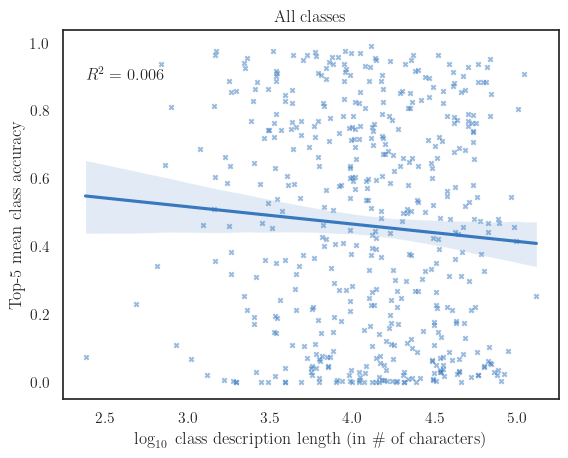

In [16]:
plt.title('All classes')
plot_fig(df, save='class_accuracy_vs_description_length')

In [17]:
plt.title('Animal')
plot_fig(df, 'animals', save='class_accuracy_vs_description_length_animals')


2022-11-29 22:26:24,439 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Serif font is not compatible with usetex.
2022-11-29 22:26:24,441 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Serif font is not compatible with usetex.
2022-11-29 22:26:24,442 DEBUG              texmanager._get_font_preamble_a -:- family: serif, font: Computer Modern Roman, info: \usepackage{type1ec}
2022-11-29 22:26:24,443 DEBUG              texmanager._get_font_preamble_a -:- Arial font is not compatible with usetex.
2022-11-29 22:26:24,444 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans font is not compatible with usetex.
2022-11-29 22:26:24,445 DEBUG              texmanager._get_font_preamble_a -:- Liberation Sans font is not compatible with usetex.
2022-11-29 22:26:24,446 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans font is not compatible with usetex.
2022-11-29 22:26:24,447 DEBUG              texmanager._get_font_preamble

2022-11-29 22:26:24,508 DEBUG              texmanager._get_font_preamble_a -:- family: cursive, font: Zapf Chancery, info: \usepackage{chancery}
2022-11-29 22:26:24,509 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans Mono font is not compatible with usetex.
2022-11-29 22:26:24,510 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans Mono font is not compatible with usetex.
2022-11-29 22:26:24,510 DEBUG              texmanager._get_font_preamble_a -:- family: monospace, font: Computer Modern Typewriter, info: \usepackage{type1ec}
2022-11-29 22:26:24,511 DEBUG                 dviread.            __init__ -:- Dvi: /home/darsh/.cache/matplotlib/tex.cache/2442ac1f214c5b205707b2d4bdd482f7.dvi
2022-11-29 22:26:24,512 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2022-11-29 22:26:24,513 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: header=

2022-11-29 22:26:24,574 DEBUG              texmanager._get_font_preamble_a -:- family: serif, font: Computer Modern Roman, info: \usepackage{type1ec}
2022-11-29 22:26:24,574 DEBUG              texmanager._get_font_preamble_a -:- Arial font is not compatible with usetex.
2022-11-29 22:26:24,575 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans font is not compatible with usetex.
2022-11-29 22:26:24,575 DEBUG              texmanager._get_font_preamble_a -:- Liberation Sans font is not compatible with usetex.
2022-11-29 22:26:24,576 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans font is not compatible with usetex.
2022-11-29 22:26:24,576 DEBUG              texmanager._get_font_preamble_a -:- family: sans-serif, font: sans-serif, info: 
2022-11-29 22:26:24,577 DEBUG              texmanager._get_font_preamble_a -:- Apple Chancery font is not compatible with usetex.
2022-11-29 22:26:24,577 DEBUG              texmanager._get_font_preamble_a -:- Tex

2022-11-29 22:26:24,616 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans Mono font is not compatible with usetex.
2022-11-29 22:26:24,617 DEBUG              texmanager._get_font_preamble_a -:- family: monospace, font: Computer Modern Typewriter, info: \usepackage{type1ec}
2022-11-29 22:26:24,618 DEBUG                 dviread.            __init__ -:- Dvi: /home/darsh/.cache/matplotlib/tex.cache/350d68b13c92545c8bfb77070611ea0e.dvi
2022-11-29 22:26:24,620 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2022-11-29 22:26:24,620 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: header=l3backend-dvips.pro
2022-11-29 22:26:24,639 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Serif font is not compatible with usetex.
2022-11-29 22:26:24,640 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Serif font is not compatible with u

2022-11-29 22:26:24,684 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans font is not compatible with usetex.
2022-11-29 22:26:24,685 DEBUG              texmanager._get_font_preamble_a -:- Liberation Sans font is not compatible with usetex.
2022-11-29 22:26:24,685 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans font is not compatible with usetex.
2022-11-29 22:26:24,686 DEBUG              texmanager._get_font_preamble_a -:- family: sans-serif, font: sans-serif, info: 
2022-11-29 22:26:24,687 DEBUG              texmanager._get_font_preamble_a -:- Apple Chancery font is not compatible with usetex.
2022-11-29 22:26:24,687 DEBUG              texmanager._get_font_preamble_a -:- Textile font is not compatible with usetex.
2022-11-29 22:26:24,688 DEBUG              texmanager._get_font_preamble_a -:- family: cursive, font: Zapf Chancery, info: \usepackage{chancery}
2022-11-29 22:26:24,688 DEBUG              texmanager._get_font_preamble_a -:- DejaVu

2022-11-29 22:26:24,732 DEBUG                 dviread.            __init__ -:- Dvi: /home/darsh/.cache/matplotlib/tex.cache/c089d6a2afbc27e09192a23f714adff3.dvi
2022-11-29 22:26:24,735 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2022-11-29 22:26:24,736 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: header=l3backend-dvips.pro
2022-11-29 22:26:24,738 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Serif font is not compatible with usetex.
2022-11-29 22:26:24,739 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Serif font is not compatible with usetex.
2022-11-29 22:26:24,739 DEBUG              texmanager._get_font_preamble_a -:- family: serif, font: Computer Modern Roman, info: \usepackage{type1ec}
2022-11-29 22:26:24,740 DEBUG              texmanager._get_font_preamble_a -:- Arial font is not compatible with usetex.
2022-11-29 22:26:24,7

2022-11-29 22:26:24,806 DEBUG              texmanager._get_font_preamble_a -:- family: monospace, font: Computer Modern Typewriter, info: \usepackage{type1ec}
2022-11-29 22:26:24,808 DEBUG              texmanager._run_checked_subproc -:- latex -interaction=nonstopmode --halt-on-error ../e4f439fc67f2b9ed9f8c84155383d4e5.tex
2022-11-29 22:26:24,880 DEBUG              texmanager._run_checked_subproc -:- b'This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019/Debian) (preloaded format=latex)\n restricted \\write18 enabled.\nentering extended mode\n(../e4f439fc67f2b9ed9f8c84155383d4e5.tex\nLaTeX2e <2020-02-02> patch level 2\nL3 programming layer <2020-02-14>\n(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls\nDocument Class: article 2019/12/20 v1.4l Standard LaTeX document class\n(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))\n(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)\n(/usr/share/texmf/tex/latex/cm-super/type1ec.sty\n(/usr/share/texlive/texmf

2022-11-29 22:26:25,074 DEBUG              texmanager._get_font_preamble_a -:- family: cursive, font: Zapf Chancery, info: \usepackage{chancery}
2022-11-29 22:26:25,074 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans Mono font is not compatible with usetex.
2022-11-29 22:26:25,075 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans Mono font is not compatible with usetex.
2022-11-29 22:26:25,075 DEBUG              texmanager._get_font_preamble_a -:- family: monospace, font: Computer Modern Typewriter, info: \usepackage{type1ec}
2022-11-29 22:26:25,076 DEBUG                 dviread.            __init__ -:- Dvi: /home/darsh/.cache/matplotlib/tex.cache/3f12642223f264678bea6a005d548126.dvi
2022-11-29 22:26:25,077 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2022-11-29 22:26:25,078 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: header=

2022-11-29 22:26:25,145 DEBUG              texmanager._get_font_preamble_a -:- family: serif, font: Computer Modern Roman, info: \usepackage{type1ec}
2022-11-29 22:26:25,146 DEBUG              texmanager._get_font_preamble_a -:- Arial font is not compatible with usetex.
2022-11-29 22:26:25,146 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans font is not compatible with usetex.
2022-11-29 22:26:25,147 DEBUG              texmanager._get_font_preamble_a -:- Liberation Sans font is not compatible with usetex.
2022-11-29 22:26:25,149 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans font is not compatible with usetex.
2022-11-29 22:26:25,149 DEBUG              texmanager._get_font_preamble_a -:- family: sans-serif, font: sans-serif, info: 
2022-11-29 22:26:25,150 DEBUG              texmanager._get_font_preamble_a -:- Apple Chancery font is not compatible with usetex.
2022-11-29 22:26:25,151 DEBUG              texmanager._get_font_preamble_a -:- Tex

2022-11-29 22:26:25,199 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans Mono font is not compatible with usetex.
2022-11-29 22:26:25,200 DEBUG              texmanager._get_font_preamble_a -:- family: monospace, font: Computer Modern Typewriter, info: \usepackage{type1ec}
2022-11-29 22:26:25,201 DEBUG                 dviread.            __init__ -:- Dvi: /home/darsh/.cache/matplotlib/tex.cache/0ba8326a3eac9c61fd8c2a9d5937a8c9.dvi
2022-11-29 22:26:25,202 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2022-11-29 22:26:25,203 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: header=l3backend-dvips.pro
2022-11-29 22:26:25,204 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Serif font is not compatible with usetex.
2022-11-29 22:26:25,204 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Serif font is not compatible with u

2022-11-29 22:26:25,251 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans font is not compatible with usetex.
2022-11-29 22:26:25,251 DEBUG              texmanager._get_font_preamble_a -:- Liberation Sans font is not compatible with usetex.
2022-11-29 22:26:25,252 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans font is not compatible with usetex.
2022-11-29 22:26:25,253 DEBUG              texmanager._get_font_preamble_a -:- family: sans-serif, font: sans-serif, info: 
2022-11-29 22:26:25,253 DEBUG              texmanager._get_font_preamble_a -:- Apple Chancery font is not compatible with usetex.
2022-11-29 22:26:25,254 DEBUG              texmanager._get_font_preamble_a -:- Textile font is not compatible with usetex.
2022-11-29 22:26:25,254 DEBUG              texmanager._get_font_preamble_a -:- family: cursive, font: Zapf Chancery, info: \usepackage{chancery}
2022-11-29 22:26:25,255 DEBUG              texmanager._get_font_preamble_a -:- DejaVu

2022-11-29 22:26:25,311 DEBUG                 dviread.            __init__ -:- Dvi: /home/darsh/.cache/matplotlib/tex.cache/666ac9f664e1fa32aeb9929f211e6925.dvi
2022-11-29 22:26:25,311 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2022-11-29 22:26:25,312 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: header=l3backend-dvips.pro
2022-11-29 22:26:25,315 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Serif font is not compatible with usetex.
2022-11-29 22:26:25,316 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Serif font is not compatible with usetex.
2022-11-29 22:26:25,317 DEBUG              texmanager._get_font_preamble_a -:- family: serif, font: Computer Modern Roman, info: \usepackage{type1ec}
2022-11-29 22:26:25,319 DEBUG              texmanager._get_font_preamble_a -:- Arial font is not compatible with usetex.
2022-11-29 22:26:25,3

2022-11-29 22:26:25,381 DEBUG              texmanager._get_font_preamble_a -:- Liberation Sans font is not compatible with usetex.
2022-11-29 22:26:25,381 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans font is not compatible with usetex.
2022-11-29 22:26:25,382 DEBUG              texmanager._get_font_preamble_a -:- family: sans-serif, font: sans-serif, info: 
2022-11-29 22:26:25,382 DEBUG              texmanager._get_font_preamble_a -:- Apple Chancery font is not compatible with usetex.
2022-11-29 22:26:25,383 DEBUG              texmanager._get_font_preamble_a -:- Textile font is not compatible with usetex.
2022-11-29 22:26:25,384 DEBUG              texmanager._get_font_preamble_a -:- family: cursive, font: Zapf Chancery, info: \usepackage{chancery}
2022-11-29 22:26:25,384 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans Mono font is not compatible with usetex.
2022-11-29 22:26:25,384 DEBUG              texmanager._get_font_preamble_a -:- B

2022-11-29 22:26:25,423 DEBUG                 dviread.            __init__ -:- Dvi: /home/darsh/.cache/matplotlib/tex.cache/e01ba6a4ca18d4d32f80e7ea1d487328.dvi
2022-11-29 22:26:25,423 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2022-11-29 22:26:25,424 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: header=l3backend-dvips.pro
2022-11-29 22:26:25,427 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Serif font is not compatible with usetex.
2022-11-29 22:26:25,427 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Serif font is not compatible with usetex.
2022-11-29 22:26:25,428 DEBUG              texmanager._get_font_preamble_a -:- family: serif, font: Computer Modern Roman, info: \usepackage{type1ec}
2022-11-29 22:26:25,428 DEBUG              texmanager._get_font_preamble_a -:- Arial font is not compatible with usetex.
2022-11-29 22:26:25,4

2022-11-29 22:26:25,471 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans font is not compatible with usetex.
2022-11-29 22:26:25,471 DEBUG              texmanager._get_font_preamble_a -:- family: sans-serif, font: sans-serif, info: 
2022-11-29 22:26:25,472 DEBUG              texmanager._get_font_preamble_a -:- Apple Chancery font is not compatible with usetex.
2022-11-29 22:26:25,472 DEBUG              texmanager._get_font_preamble_a -:- Textile font is not compatible with usetex.
2022-11-29 22:26:25,473 DEBUG              texmanager._get_font_preamble_a -:- family: cursive, font: Zapf Chancery, info: \usepackage{chancery}
2022-11-29 22:26:25,473 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans Mono font is not compatible with usetex.
2022-11-29 22:26:25,473 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans Mono font is not compatible with usetex.
2022-11-29 22:26:25,474 DEBUG              texmanager._get_font_preambl

2022-11-29 22:26:25,516 DEBUG                 dviread.            __init__ -:- Dvi: /home/darsh/.cache/matplotlib/tex.cache/e561c136bae629f27c4646a92b46d0e4.dvi
2022-11-29 22:26:25,517 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2022-11-29 22:26:25,517 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: header=l3backend-dvips.pro
2022-11-29 22:26:25,520 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Serif font is not compatible with usetex.
2022-11-29 22:26:25,521 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Serif font is not compatible with usetex.
2022-11-29 22:26:25,521 DEBUG              texmanager._get_font_preamble_a -:- family: serif, font: Computer Modern Roman, info: \usepackage{type1ec}
2022-11-29 22:26:25,522 DEBUG              texmanager._get_font_preamble_a -:- Arial font is not compatible with usetex.
2022-11-29 22:26:25,5

2022-11-29 22:26:25,574 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans font is not compatible with usetex.
2022-11-29 22:26:25,574 DEBUG              texmanager._get_font_preamble_a -:- family: sans-serif, font: sans-serif, info: 
2022-11-29 22:26:25,575 DEBUG              texmanager._get_font_preamble_a -:- Apple Chancery font is not compatible with usetex.
2022-11-29 22:26:25,575 DEBUG              texmanager._get_font_preamble_a -:- Textile font is not compatible with usetex.
2022-11-29 22:26:25,576 DEBUG              texmanager._get_font_preamble_a -:- family: cursive, font: Zapf Chancery, info: \usepackage{chancery}
2022-11-29 22:26:25,576 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans Mono font is not compatible with usetex.
2022-11-29 22:26:25,577 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans Mono font is not compatible with usetex.
2022-11-29 22:26:25,577 DEBUG              texmanager._get_font_preambl

2022-11-29 22:26:25,622 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2022-11-29 22:26:25,622 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: header=l3backend-dvips.pro
2022-11-29 22:26:25,624 DEBUG             backend_pdf.          writeFonts -:- Embedding Type-1 font b'cmmi10' from dvi.
2022-11-29 22:26:25,624 DEBUG             backend_pdf.       _embedTeXFont -:- Embedding TeX font b'cmmi10' - fontinfo={'dvifont': <DviFont: b'cmmi10'>, 'pdfname': <Name b'F2'>, 'fontfile': '/usr/share/texlive/texmf-dist/fonts/type1/public/amsfonts/cm/cmmi10.pfb', 'basefont': b'CMMI10', 'encodingfile': None, 'effects': {}}
2022-11-29 22:26:25,634 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 485: 'FontDirectory'
2022-11-29 22:26:25,635 DEBUG              _type1font.            __init__ -:- type1font._Token name at 498: '/CMMI10'
2022-11-29 22:26:25,636 

2022-11-29 22:26:25,663 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 756: 'def'
2022-11-29 22:26:25,664 DEBUG              _type1font.            __init__ -:- type1font._Token name at 760: '/FontBBox'
2022-11-29 22:26:25,664 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 770: '{'
2022-11-29 22:26:25,665 DEBUG              _type1font.            __init__ -:- type1font._Token number at 771: '-32'
2022-11-29 22:26:25,665 DEBUG              _type1font.            __init__ -:- type1font._Token number at 775: '-250'
2022-11-29 22:26:25,667 DEBUG              _type1font.            __init__ -:- type1font._Token number at 780: '1048'
2022-11-29 22:26:25,667 DEBUG              _type1font.            __init__ -:- type1font._Token number at 785: '750'
2022-11-29 22:26:25,668 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 789: '}'
2022-11-29 22:26:25,668 DEBUG              _type1font. 

2022-11-29 22:26:25,706 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1330: '1'
2022-11-29 22:26:25,707 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1332: 'index'
2022-11-29 22:26:25,707 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1338: 'exch'
2022-11-29 22:26:25,708 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1343: '/.notdef'
2022-11-29 22:26:25,709 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1352: 'put'
2022-11-29 22:26:25,709 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 1355: '}'
2022-11-29 22:26:25,710 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1357: 'for'
2022-11-29 22:26:25,710 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1361: 'dup'
2022-11-29 22:26:25,711 DEBUG              _ty

2022-11-29 22:26:25,757 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1630: 'put'
2022-11-29 22:26:25,758 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1634: 'dup'
2022-11-29 22:26:25,759 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1638: '16'
2022-11-29 22:26:25,760 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1641: '/zeta'
2022-11-29 22:26:25,760 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1647: 'put'
2022-11-29 22:26:25,761 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1651: 'dup'
2022-11-29 22:26:25,762 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1655: '17'
2022-11-29 22:26:25,763 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1658: '/eta'
2022-11-29 22:26:25,764 DEBUG              _type1font. 

2022-11-29 22:26:25,813 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1921: '33'
2022-11-29 22:26:25,814 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1924: '/omega'
2022-11-29 22:26:25,814 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1931: 'put'
2022-11-29 22:26:25,815 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1935: 'dup'
2022-11-29 22:26:25,815 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1939: '34'
2022-11-29 22:26:25,816 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1942: '/epsilon'
2022-11-29 22:26:25,817 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1951: 'put'
2022-11-29 22:26:25,817 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1955: 'dup'
2022-11-29 22:26:25,818 DEBUG              _type1f

2022-11-29 22:26:25,862 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2321: '/twooldstyle'
2022-11-29 22:26:25,862 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2334: 'put'
2022-11-29 22:26:25,863 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2338: 'dup'
2022-11-29 22:26:25,863 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2342: '51'
2022-11-29 22:26:25,863 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2345: '/threeoldstyle'
2022-11-29 22:26:25,864 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2360: 'put'
2022-11-29 22:26:25,864 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2364: 'dup'
2022-11-29 22:26:25,865 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2368: '52'
2022-11-29 22:26:25,866 DEBUG         

2022-11-29 22:26:25,904 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2686: 'put'
2022-11-29 22:26:25,904 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2690: 'dup'
2022-11-29 22:26:25,905 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2694: '68'
2022-11-29 22:26:25,905 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2697: '/D'
2022-11-29 22:26:25,906 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2700: 'put'
2022-11-29 22:26:25,906 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2704: 'dup'
2022-11-29 22:26:25,906 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2708: '69'
2022-11-29 22:26:25,907 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2711: '/E'
2022-11-29 22:26:25,908 DEBUG              _type1font.      

2022-11-29 22:26:25,940 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2932: '85'
2022-11-29 22:26:25,940 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2935: '/U'
2022-11-29 22:26:25,941 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2938: 'put'
2022-11-29 22:26:25,942 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2942: 'dup'
2022-11-29 22:26:25,942 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2946: '86'
2022-11-29 22:26:25,943 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2949: '/V'
2022-11-29 22:26:25,943 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2952: 'put'
2022-11-29 22:26:25,944 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2956: 'dup'
2022-11-29 22:26:25,945 DEBUG              _type1font.      

2022-11-29 22:26:25,991 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3214: 'put'
2022-11-29 22:26:25,993 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3218: 'dup'
2022-11-29 22:26:25,994 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3222: '103'
2022-11-29 22:26:25,999 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3226: '/g'
2022-11-29 22:26:26,000 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3229: 'put'
2022-11-29 22:26:26,001 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3233: 'dup'
2022-11-29 22:26:26,001 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3237: '104'
2022-11-29 22:26:26,002 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3241: '/h'
2022-11-29 22:26:26,002 DEBUG              _type1font.    

2022-11-29 22:26:26,035 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3477: '120'
2022-11-29 22:26:26,036 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3481: '/x'
2022-11-29 22:26:26,036 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3484: 'put'
2022-11-29 22:26:26,036 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3488: 'dup'
2022-11-29 22:26:26,037 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3492: '121'
2022-11-29 22:26:26,037 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3496: '/y'
2022-11-29 22:26:26,038 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3499: 'put'
2022-11-29 22:26:26,038 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3503: 'dup'
2022-11-29 22:26:26,038 DEBUG              _type1font.    

2022-11-29 22:26:26,077 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3805: 'put'
2022-11-29 22:26:26,077 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3809: 'dup'
2022-11-29 22:26:26,078 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3813: '169'
2022-11-29 22:26:26,078 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3817: '/Phi'
2022-11-29 22:26:26,078 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3822: 'put'
2022-11-29 22:26:26,079 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3826: 'dup'
2022-11-29 22:26:26,079 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3830: '170'
2022-11-29 22:26:26,080 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3834: '/Psi'
2022-11-29 22:26:26,080 DEBUG              _type1font.

2022-11-29 22:26:26,135 DEBUG              _type1font.            __init__ -:- type1font._Token number at 4122: '188'
2022-11-29 22:26:26,136 DEBUG              _type1font.            __init__ -:- type1font._Token name at 4126: '/pi'
2022-11-29 22:26:26,137 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4130: 'put'
2022-11-29 22:26:26,137 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4134: 'dup'
2022-11-29 22:26:26,138 DEBUG              _type1font.            __init__ -:- type1font._Token number at 4138: '189'
2022-11-29 22:26:26,139 DEBUG              _type1font.            __init__ -:- type1font._Token name at 4142: '/rho'
2022-11-29 22:26:26,140 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4147: 'put'
2022-11-29 22:26:26,140 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4151: 'dup'
2022-11-29 22:26:26,141 DEBUG              _type1font. 

2022-11-29 22:26:26,193 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4459: 'put'
2022-11-29 22:26:26,193 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 4462: '}'
2022-11-29 22:26:26,194 DEBUG              _type1font.            __init__ -:- type1font._Token ? at 4449: '{noaccess put}'
2022-11-29 22:26:26,194 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4463: 'executeonly'
2022-11-29 22:26:26,194 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4475: 'def'
2022-11-29 22:26:26,195 DEBUG              _type1font.            __init__ -:- type1font._Token name at 4479: '/MinFeature'
2022-11-29 22:26:26,195 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 4490: '{'
2022-11-29 22:26:26,196 DEBUG              _type1font.            __init__ -:- type1font._Token number at 4491: '16'
2022-11-29 22:26:26,196 DEBUG   

2022-11-29 22:26:26,248 DEBUG              _type1font.            __init__ -:- type1font._Token name at 4754: '/OtherSubrs'
2022-11-29 22:26:26,248 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 4912: '['
2022-11-29 22:26:26,249 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4914: 'systemdict'
2022-11-29 22:26:26,249 DEBUG              _type1font.            __init__ -:- type1font._Token name at 4925: '/internaldict'
2022-11-29 22:26:26,250 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4939: 'known'
2022-11-29 22:26:26,250 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 4945: '{'
2022-11-29 22:26:26,251 DEBUG              _type1font.            __init__ -:- type1font._Token number at 4946: '1183615869'
2022-11-29 22:26:26,251 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4957: 'systemdict'
2022-11-29 22:

2022-11-29 22:26:26,288 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5312: 'ifelse'
2022-11-29 22:26:26,289 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 5319: '}'
2022-11-29 22:26:26,289 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5321: 'dup'
2022-11-29 22:26:26,290 DEBUG              _type1font.            __init__ -:- type1font._Token number at 5325: '14'
2022-11-29 22:26:26,290 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5328: 'get'
2022-11-29 22:26:26,290 DEBUG              _type1font.            __init__ -:- type1font._Token number at 5332: '1'
2022-11-29 22:26:26,291 DEBUG              _type1font.            __init__ -:- type1font._Token number at 5334: '25'
2022-11-29 22:26:26,291 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5337: 'dict'
2022-11-29 22:26:26,291 DEBUG              _type1fo

2022-11-29 22:26:26,335 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5711: 'known'
2022-11-29 22:26:26,335 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5717: 'not'
2022-11-29 22:26:26,337 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 5721: '{'
2022-11-29 22:26:26,338 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5723: 'dup'
2022-11-29 22:26:26,338 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5727: 'dup'
2022-11-29 22:26:26,339 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5731: 'length'
2022-11-29 22:26:26,340 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5738: 'exch'
2022-11-29 22:26:26,340 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5743: 'maxlength'
2022-11-29 22:26:26,341 DEBUG       

2022-11-29 22:26:26,380 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6049: '/c4y2'
2022-11-29 22:26:26,380 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6055: 'exdef'
2022-11-29 22:26:26,381 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6061: '/c4x2'
2022-11-29 22:26:26,382 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6067: 'exdef'
2022-11-29 22:26:26,382 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6073: '/c4y1'
2022-11-29 22:26:26,383 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6079: 'exdef'
2022-11-29 22:26:26,384 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6085: '/c4x1'
2022-11-29 22:26:26,384 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6091: 'exdef'
2022-11-29 22:26:26,385 DEBUG              _

2022-11-29 22:26:26,439 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6409: 'c4y0'
2022-11-29 22:26:26,440 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6414: 'c4x1'
2022-11-29 22:26:26,441 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6419: 'c4y1'
2022-11-29 22:26:26,441 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6424: 'c4x2'
2022-11-29 22:26:26,442 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6429: 'c4y2'
2022-11-29 22:26:26,442 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 6433: '}'
2022-11-29 22:26:26,443 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6435: 'ifelse'
2022-11-29 22:26:26,443 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6442: '/y5'
2022-11-29 22:26:26,444 DEBUG              

2022-11-29 22:26:26,474 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6711: '/flipXY'
2022-11-29 22:26:26,475 DEBUG              _type1font.            __init__ -:- type1font._Token number at 6719: '1'
2022-11-29 22:26:26,475 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6721: 'def'
2022-11-29 22:26:26,476 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 6724: '}'
2022-11-29 22:26:26,476 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 6726: '{'
2022-11-29 22:26:26,477 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6727: '/flipXY'
2022-11-29 22:26:26,477 DEBUG              _type1font.            __init__ -:- type1font._Token number at 6735: '0'
2022-11-29 22:26:26,478 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6737: 'def'
2022-11-29 22:26:26,478 DEBUG              _type1fon

2022-11-29 22:26:26,514 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7032: 'abs'
2022-11-29 22:26:26,515 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 7035: '}'
2022-11-29 22:26:26,516 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7037: 'ifelse'
2022-11-29 22:26:26,516 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7044: 'def'
2022-11-29 22:26:26,517 DEBUG              _type1font.            __init__ -:- type1font._Token name at 7048: '/yshrink'
2022-11-29 22:26:26,525 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 7057: '{'
2022-11-29 22:26:26,528 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7058: 'c4y2'
2022-11-29 22:26:26,529 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7063: 'sub'
2022-11-29 22:26:26,529 DEBUG             

2022-11-29 22:26:26,568 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 7362: '{'
2022-11-29 22:26:26,568 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7364: 'c1x2'
2022-11-29 22:26:26,569 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7369: 'c1y2'
2022-11-29 22:26:26,569 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7374: 'transform'
2022-11-29 22:26:26,570 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7384: 'flipXY'
2022-11-29 22:26:26,570 DEBUG              _type1font.            __init__ -:- type1font._Token number at 7391: '1'
2022-11-29 22:26:26,571 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7393: 'eq'
2022-11-29 22:26:26,571 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 7396: '{'
2022-11-29 22:26:26,572 DEBUG            

2022-11-29 22:26:26,604 DEBUG              _type1font.            __init__ -:- type1font._Token name at 7625: '/cy'
2022-11-29 22:26:26,605 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7629: 'cy'
2022-11-29 22:26:26,605 DEBUG              _type1font.            __init__ -:- type1font._Token number at 7632: '0.5'
2022-11-29 22:26:26,605 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7636: 'sub'
2022-11-29 22:26:26,606 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7640: 'def'
2022-11-29 22:26:26,606 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 7643: '}'
2022-11-29 22:26:26,606 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7645: 'if'
2022-11-29 22:26:26,607 DEBUG              _type1font.            __init__ -:- type1font._Token name at 7648: '/ey'
2022-11-29 22:26:26,607 DEBUG              _type1font.   

2022-11-29 22:26:26,636 DEBUG              _type1font.            __init__ -:- type1font._Token number at 7897: '0'
2022-11-29 22:26:26,637 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7899: 'eq'
2022-11-29 22:26:26,637 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7902: 'c3x2'
2022-11-29 22:26:26,641 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7907: 'c4x2'
2022-11-29 22:26:26,650 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7912: 'eq'
2022-11-29 22:26:26,651 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7915: 'or'
2022-11-29 22:26:26,651 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 7918: '{'
2022-11-29 22:26:26,652 DEBUG              _type1font.            __init__ -:- type1font._Token boolean at 7919: 'false'
2022-11-29 22:26:26,652 DEBUG              _type1f

2022-11-29 22:26:26,684 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8211: 'c3x2'
2022-11-29 22:26:26,684 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8216: 'c1x2'
2022-11-29 22:26:26,685 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8221: 'sub'
2022-11-29 22:26:26,685 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8225: 'round'
2022-11-29 22:26:26,685 DEBUG              _type1font.            __init__ -:- type1font._Token number at 8231: '0'
2022-11-29 22:26:26,686 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8233: 'dtransform'
2022-11-29 22:26:26,690 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8244: 'flipXY'
2022-11-29 22:26:26,690 DEBUG              _type1font.            __init__ -:- type1font._Token number at 8251: '-1'
2022-11-29 22:26:26,691 DEBUG          

2022-11-29 22:26:26,719 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8494: 'pop'
2022-11-29 22:26:26,719 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8498: 'dX'
2022-11-29 22:26:26,719 DEBUG              _type1font.            __init__ -:- type1font._Token number at 8501: '0'
2022-11-29 22:26:26,720 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8503: 'lt'
2022-11-29 22:26:26,720 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 8506: '{'
2022-11-29 22:26:26,721 DEBUG              _type1font.            __init__ -:- type1font._Token number at 8507: '-1'
2022-11-29 22:26:26,721 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 8509: '}'
2022-11-29 22:26:26,722 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 8510: '{'
2022-11-29 22:26:26,722 DEBUG              _type1font. 

2022-11-29 22:26:26,744 DEBUG              _type1font.            __init__ -:- type1font._Token name at 8749: '/eShift'
2022-11-29 22:26:26,745 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8757: 'exch'
2022-11-29 22:26:26,745 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8762: 'def'
2022-11-29 22:26:26,745 DEBUG              _type1font.            __init__ -:- type1font._Token name at 8766: '/x1'
2022-11-29 22:26:26,746 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8770: 'x1'
2022-11-29 22:26:26,746 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8773: 'eShift'
2022-11-29 22:26:26,747 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8780: 'add'
2022-11-29 22:26:26,755 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8784: 'def'
2022-11-29 22:26:26,756 DEBUG              _typ

2022-11-29 22:26:26,790 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9037: 'cvx'
2022-11-29 22:26:26,790 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9041: 'executeonly'
2022-11-29 22:26:26,791 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9053: 'exch'
2022-11-29 22:26:26,791 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9058: '{'
2022-11-29 22:26:26,791 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9059: 'pop'
2022-11-29 22:26:26,792 DEBUG              _type1font.            __init__ -:- type1font._Token boolean at 9063: 'true'
2022-11-29 22:26:26,792 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9068: 'exch'
2022-11-29 22:26:26,792 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9073: 'restore'
2022-11-29 22:26:26,792 DEBUG    

2022-11-29 22:26:26,826 DEBUG              _type1font.            __init__ -:- type1font._Token name at 9452: '/FlxProc'
2022-11-29 22:26:26,826 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9461: 'get'
2022-11-29 22:26:26,827 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9465: 'exec'
2022-11-29 22:26:26,827 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9469: '}'
2022-11-29 22:26:26,827 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9470: '}'
2022-11-29 22:26:26,828 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9472: '{'
2022-11-29 22:26:26,828 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9473: '{'
2022-11-29 22:26:26,829 DEBUG              _type1font.            __init__ -:- type1font._Token number at 9474: '1183615869'
2022-11-29 22:26:26,829 DEBUG          

2022-11-29 22:26:26,858 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9850: '}'
2022-11-29 22:26:26,858 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9852: '{'
2022-11-29 22:26:26,859 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9853: 'pop'
2022-11-29 22:26:26,860 DEBUG              _type1font.            __init__ -:- type1font._Token number at 9857: '3'
2022-11-29 22:26:26,860 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9858: '}'
2022-11-29 22:26:26,861 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9860: 'ifelse'
2022-11-29 22:26:26,862 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9866: '}'
2022-11-29 22:26:26,862 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9868: 'ifelse'
2022-11-29 22:26:26,863 DEBUG              _t

2022-11-29 22:26:26,877 DEBUG              _type1font.            __init__ -:- type1font._Token number at 9954: '9'
2022-11-29 22:26:26,877 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9956: 'RD'
2022-11-29 22:26:26,892 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 9958: b' \x10\xbf1py\xbc\xf6Uz'
2022-11-29 22:26:26,893 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9969: 'NP'
2022-11-29 22:26:26,893 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9972: 'dup'
2022-11-29 22:26:26,894 DEBUG              _type1font.            __init__ -:- type1font._Token number at 9976: '2'
2022-11-29 22:26:26,894 DEBUG              _type1font.            __init__ -:- type1font._Token number at 9978: '9'
2022-11-29 22:26:26,895 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9980: 'RD'
2022-11-29 22:26:26,895 DEBUG            

2022-11-29 22:26:26,925 DEBUG              _type1font.            __init__ -:- type1font._Token name at 10598: '/Delta'
2022-11-29 22:26:26,926 DEBUG              _type1font.            __init__ -:- type1font._Token number at 10605: '82'
2022-11-29 22:26:26,926 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10608: 'RD'
2022-11-29 22:26:26,927 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 10610: b' \x10\xbf1pN}\xe8\xc4\xb3\x8b\xf5GW<\xfa\xb0\xcb\xde$n\xca\xc6\x19\xa8\x1c\x15\xda\xe8\xa3\xc5\xe5\xc7?\xe9;=C\xfa\x85\x9e\x91+\xec\x08\x9ce\xa0~X\xfc7-\x11\xdcl\x08x\x85\xc2N\xe2\xa3\x00\xd8\x98\xb4\x13yI\xbb_,H\xf0\xe2E\x045\x94i\n\xb6'
2022-11-29 22:26:26,927 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10694: 'ND'
2022-11-29 22:26:26,927 DEBUG              _type1font.            __init__ -:- type1font._Token name at 10697: '/Theta'
2022-11-29 22:26:26,928 DEBUG              _type1f

2022-11-29 22:26:26,941 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 12180: 'ND'
2022-11-29 22:26:26,942 DEBUG              _type1font.            __init__ -:- type1font._Token name at 12183: '/Phi'
2022-11-29 22:26:26,942 DEBUG              _type1font.            __init__ -:- type1font._Token number at 12188: '320'
2022-11-29 22:26:26,943 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 12192: 'RD'
2022-11-29 22:26:26,943 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 12194: b' \x10\xbf1pP\xd8\xfd\x18O\x04I\x16\xb8N+\x0e\xa3<"\xcdc;\xef\xb1\x17\xcd\xca\xdc\xeaV\xac\xf5\xd2\xd5&\xc0{h\x8e\xf9\x8big\x98\'\x9f\xe1Q[\x8f\xd8\x07dH\xcaM\xee\xde\x887\xdb\xb3\xf7\xf2\xbe*\x18{\xe1@:\xb3\xa8\xbd\xf1\xfd\xbe\xf0W?2:\x08N\xfaY\x85\xfe\x8a^\r\xb7\xf0\x81\x88\xe6az\xf3\xf6/\xaf\xf6\xf2\xd1\xbe\x11\xbd_<\x0c\x08y\xa8\xae\xcb\t\x10\xf3\xa3\xcdy\xa32\xbb\xe8H_\x7f\xd3\x9e\xad\xd6]\xad\xe2\x7f+\

2022-11-29 22:26:26,972 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 13772: b" \x10\xbf1pG'\xfcl\n5\x0e\xd2\x9a\x91$\x13\x97\xe2\xdc\xa8\xe9\xf7YV'_\xb44\xc4\xf0\xec\x950\xbf\xe3\x92\xc3\xd9\xfa\xe6\x99\xdd\xc1\x91At}\xdar\x98!\x93\xee\xea\xd7\xe0\x0c\x1d\xe5\xe0\xa1#\x06\x97\xf8\xd49)B\xcc\xde\x83\xbf\xa7\x12L\xaa\x0bn\x17\xd1\x0c\xa2\xcej\x16\x83\xa3\x05eB\xeb\x0c\xf2\xd4\rQ\xc2C\x9a\x11\xd4\xfdA\xca\xbc\xd6\x86RA\xc4B\x16Q\x16\x0f\xe0\xffs\xa9\xe8\xe3\x9a\xf0\xdb\xa8\x8b\x1bC5\x88,:\x8c6uoK\xe7M\x1agp]\xdd)\xc7\xdf\xf4\xf5A"
2022-11-29 22:26:26,972 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 13925: 'ND'
2022-11-29 22:26:26,973 DEBUG              _type1font.            __init__ -:- type1font._Token name at 13928: '/epsilon1'
2022-11-29 22:26:26,973 DEBUG              _type1font.            __init__ -:- type1font._Token number at 13938: '113'
2022-11-29 22:26:26,974 DEBUG              _type1font.            __

2022-11-29 22:26:26,990 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 15182: 'RD'
2022-11-29 22:26:26,990 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 15184: b' \x10\xbf1p[\x07\x01`B\xd0\x9c\xa4\xa7\x02\x92\xe7\x17\x86\xba\xa3\n\xf9S\xb2\xbc\xc0(-\x8c\xfdR\xc5\x11\xb48\x92p\x9a\xa6-\xd2\xd8Q\xa0\xa5\x9b\xc2]S\xbb\x8d\xdbv"\x0b?\xec\x97\xbd\xb1\x9aO\x83\xfej\x0f\xff\xe82q\x93\r\x8ck\x0f\x87d\x8c\xfa\x94\xd5T\xe4Q\x97\x88\xb8\x03Y\xf9d}\x12m_\xe8L\xd6\x8f\xe9o\xffL\xca\x98R"\xf2q\x00o\x84\x95\xb5\x97\xe8J\xbc\x81\xaa\xd2\xdd\x1eb\x98#\x9e\xde\xf9\xb5\x0f\xfa74\xe3Z\x10\x81AG\xa7\x1f\xa3Y\xac\xac\x16\xd3=\xe3\x05\xee\x84D\xef\x9f\x0f\xd6\xec\x84y\x9b\'\x97\xa4\xe9y G\x05T\xce7|\xe7`C%hs\r\x97\xdd\xcc\xfcP\xad$\n|\xf2\x12#\x86w=6;n\xa3=\xb2\xe9'
2022-11-29 22:26:26,991 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 15389: 'ND'
2022-11-29 22:26:26,992 DEBUG              _type1font. 

2022-11-29 22:26:27,027 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 16690: 'ND'
2022-11-29 22:26:27,028 DEBUG              _type1font.            __init__ -:- type1font._Token name at 16693: '/phi'
2022-11-29 22:26:27,028 DEBUG              _type1font.            __init__ -:- type1font._Token number at 16698: '178'
2022-11-29 22:26:27,028 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 16702: 'RD'
2022-11-29 22:26:27,029 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 16704: b' \x10\xbf1pN|\x88\xcbBP\xd3\xfdn>O\x80\xaf\xa7\x85\xf0\x94d\xa2\xbd\xd1\x15\xf4\xce\xa4N\xa8\t\xaa\x14\x12\x18m\xc9M\x19\x8c\x02\xf0\xc09@Q\xc1\xa4\xe3\xcd4\xde\x10"\xc1\xbc(\xf75\xf1\xb6\xaf~\x93\x13\xca\x02\xc2\xb8h\xe4\xedh\x83$\xe02\x96\x86R\xae\x88x0\xe9_}\x9d2W\xc8\x13\xd9G\xfb\x91\xf9\xcc\x832\x16\xf2Q\xdd\xde\xefC\x889\xedv\xa9\xbc\xdfD\x88\xd0Y\xb7\x9b\x88[\xef\xf3\xe1<\x9d\rr\xd1\x0e\xcf\xe6\xae\x

2022-11-29 22:26:27,055 DEBUG              _type1font.            __init__ -:- type1font._Token name at 18226: '/rho1'
2022-11-29 22:26:27,056 DEBUG              _type1font.            __init__ -:- type1font._Token number at 18232: '172'
2022-11-29 22:26:27,057 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 18236: 'RD'
2022-11-29 22:26:27,057 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 18238: b" \x10\xbf1p'\xe9TZ@\xf3(|\x89G;\xce:\xc1(2\xc2\x14\xa3e\xe7\xe6\x16\xcc\xda\x1f\xee,pwz\xdb\xac\x0c\xfe{\x87\xe5\x02^\xff\x8e\xa9H\xdaq4\xee\xf6\xb86V\xd7\n\xcf\xc6y\xa3\x01@\x90\xbd\x90\x88)\xfd\x9bo\xb9'\x9a\xed\n=\thGy\x0f\x84\xe7\xd1!\x9b\x92\x11\x91\xab\x1d\xdf/l\x98\x07(|\\\xdf\x0fF\xa4\x82\x9a\xf2\x88\xc0E\xed1\xa4}\xf2\xd8\xd5qD\xee\xb5K\xae\xf6\x0f\xc2\x81\xe6\xf5\x93\xbb\xa5p\x89u\xce\x05WR\xfd\xd3\x06\xb3\x8c\x89\x8f\xe1\xe1\xa5\xbc\xe7\x81\xfd\xe7\x9c\x9b\x8e[\x03\x83*\x1b\x1e\xd2\xcf\xf4g\xf2\r\xbf\x8c"
2022-1

2022-11-29 22:26:27,100 DEBUG              _type1font.            __init__ -:- type1font._Token name at 19419: '/triangleright'
2022-11-29 22:26:27,101 DEBUG              _type1font.            __init__ -:- type1font._Token number at 19434: '85'
2022-11-29 22:26:27,101 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 19437: 'RD'
2022-11-29 22:26:27,102 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 19439: b" \x10\xbf1pW>V<\x82T'\x10\xf98\x15tb\x18\xd7\x94\x0c\x17\xc1\x8c\xa0\x17\xbah4j\xfc\x0f\x8d\xa9\x97}\xfdO\xb8{\xa8\xf2 \x9cl\x06\xb2\xe2\xdd>?\xb8\xa92:\xe5\x05\xb2\x9eT\xfa\xbb\x98\xbe\x94t\xa0\xe8X\xe7]\x1d\xa2k\xb3\xee\xaf\x15\xf1)~\x96\xce\xcd>"
2022-11-29 22:26:27,103 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 19526: 'ND'
2022-11-29 22:26:27,103 DEBUG              _type1font.            __init__ -:- type1font._Token name at 19529: '/triangleleft'
2022-11-29 22:26:27,104 

2022-11-29 22:26:27,124 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 20738: 'RD'
2022-11-29 22:26:27,125 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 20740: b' \x10\xbf1pG\'$8K\xc0\xcf\xb1\xe9\x14\xe6\xbda\xed\xd0.\xf1\x00\xd8\xb8\x0c\xc3\xa6W\xc6\x9f\x94\x12"\xa89RS\xee.\x1aJe\xb0\xc6\x0c/D\x0c\x8d\xcd0\xde\xd5-\xcd%\xc5\xee\x10\xfb7\x9aR,\xac%\x13yo\x807\xed\x81\x92\x9a!.\xeb#\xadm\n\xb3\x1c\xfaKI\x078N\x97\xe0[\xf3\xa5\xd3\xb5\xb2W\xec\xba\xc5\xff\xa9{\x96\xf7!\x12\xee\xff\xb1\xedi\xef\xd7g\xa2P\x86g:Bw\xad?=\x895\xb9\x9a\xf3\x18\xb5\xfb`\xae\xae7\x00\x11d\x07\x81\r;\x14\x10\xd8q\xa1N]\x97Z\xcc\xe0\xe6\x9fy\x98\'w\x8b\xa6(Zl\x06\xfeJ\xf83e\xccQh\xda\xff\x01\x17'
2022-11-29 22:26:27,125 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 20923: 'ND'
2022-11-29 22:26:27,133 DEBUG              _type1font.            __init__ -:- type1font._Token name at 20926: '/sevenoldstyle'
2022

2022-11-29 22:26:27,158 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 21963: 'RD'
2022-11-29 22:26:27,159 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 21965: b' \x10\xbf1p}\x92\x0e\xdd\xa9z\x85P\xdck\x98R?\xbf\xbdQ\xd4\xe3\xf2\xc5\x1f\xfa\x80\xd4\xa1&\xee1\x8a\xad^\x81l_c\xcf\x13\x16\xaf\xcf\xd5\x17\xb6>\xfe\xe6\x92\xde\x0e\x81\x01;\xb2elB\x9ej\xe1\xa0\xed\x97\x94F\x1anX\x19z\xe2\xa4rW\xad\xd8\x04\xb3\x9d\x843<L\xc5\x99\xc1F^m\x02\xfd\x82\x982\xfc\xe7\xce\xb2\xa7\x03zHU\xf2\xf7\xca\x18\xb2=\xf1t~\xbf\xc4\xa7\x00Q\x96\xa4\t\xd09L\xb1\xa7\xa5M\xbb_\xbc\x83\xfd\xdf-\xeeS\xb0\x10V\x7f=\xd9p\xa9Q\x92\xdc\xb7\xaf\xe5J\x9b\xfd\x98\xdd\xa4/\xb2F\xf6\xac\xd0'
2022-11-29 22:26:27,159 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 22132: 'ND'
2022-11-29 22:26:27,159 DEBUG              _type1font.            __init__ -:- type1font._Token name at 22135: '/partialdiff'
2022-11-29 22:26:27,16

2022-11-29 22:26:27,184 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 23671: 'ND'
2022-11-29 22:26:27,185 DEBUG              _type1font.            __init__ -:- type1font._Token name at 23674: '/G'
2022-11-29 22:26:27,185 DEBUG              _type1font.            __init__ -:- type1font._Token number at 23677: '261'
2022-11-29 22:26:27,185 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 23681: 'RD'
2022-11-29 22:26:27,186 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 23683: b" \x10\xbf1pO\xabI\x82\xf5\x01<\x8bo\x86Ak\xc7\x9a\x91\x13\x02\xe3\xcfU\x00\xad\n\xfc\xedb\xdc\xe4\\\xa0\x18s\xf8a%\xb3\x81)b\x01,\\\x1e\x07\x9fl\x80\xa6\x07w)oq'\x1f\x9d\xbe\x8394\x8fx\xa9\xc6\x05/\x17\xa51\xcc@\x97\xe0\x9c \x84{\xe1}1\xd0\xe2F.8P\x8c6+F\x93\x94<\xa9\x13}\x97\x80\xe8\xd3H\x1fS\x86\xb6E\xd3\xb7\x95>\xd3\x8e\xdb\xe1\xf6l3\xda\xb9\x82\xdd\xc50\x04\x86\xfe\xcb_.#~:\xa37\xd1N\xf1\xe10\xda\xbf\xda\

2022-11-29 22:26:27,204 DEBUG              _type1font.            __init__ -:- type1font._Token name at 25361: '/M'
2022-11-29 22:26:27,204 DEBUG              _type1font.            __init__ -:- type1font._Token number at 25364: '308'
2022-11-29 22:26:27,205 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 25368: 'RD'
2022-11-29 22:26:27,205 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 25370: b' \x10\xbf1pG%QG\x8aD$x0|\xeb\x10\xa3\x04\x14\xab\xf5\xe8?\xa1\x9c\xb50\x90\x17\x95\x86@v\xfa\xd5\xa0"\xb1\xc3\xb1S\xf9#:~j\x07\x9c\xff\xe6\x90\x11j\xf3^J\x9axmn\xdc\x1b]*\x05\xf0\x9cPz\xac\x1f\xeeM\x9a\x8d\xbc\xaf\xab;\x9a"p\x07\xcc\xe8<<\x08\xab\xa2t\xeb\x05V\xac\xfd\xe2\x18{\xf8\x1c\xb4\xda\xd8\x8a}\xb2\xb8\xf9\xd9\xa5\x1b{!\xf8w\xe4q\xa9\xd1\x05\xc7Q\xdd~\xf0G\x0f \xbf\xb2\xaf\xcd\xee\xf5~\x8ai=\xbe\x87\xa6\x00$k\xaf \xe9\x9d\xd4\x93]\xee\xf2P\x7f\xdfJ\x92\xd4\xa0n\xb0\x97\xac\xe5\x95\x1e\xd5mr$Wy\xc9\x1f8>\xcbn\xd6]M\x8e\

2022-11-29 22:26:27,229 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 27022: 'ND'
2022-11-29 22:26:27,230 DEBUG              _type1font.            __init__ -:- type1font._Token name at 27025: '/T'
2022-11-29 22:26:27,230 DEBUG              _type1font.            __init__ -:- type1font._Token number at 27028: '249'
2022-11-29 22:26:27,231 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 27032: 'RD'
2022-11-29 22:26:27,231 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 27034: b' \x10\xbf1pQ\x17\x11\x91<\xf7\xb5\x06\x7f\xbf\xd0/B\x83\x7f\xa7\xbfcX\x89\x82)&\xc0\xbb\xc6UOa\xa3\x0c\xe1Y\xf3\xd57K\x01!\x8f\xc1\xbb\xc4\xae\xe5d\xd39\x16\x94+\xb7\x84e\x01\x8fx\xe8\xbfIB,;On\xac\x0c\xbe&\x8a01\xe3\xab\x8b\x11fX\xf1\xcf\x01\xb0\xea}\x14nE\x08\xf3\x15\xbd\x1d\xdd\xeeAG*i\xd8ad\x80\x0b\x96\xff<\xd2~8W\xfe\x9ajy4\xc1-\x92\x0c\x987o<\xf5"\xc0\xcf\xf8A|\xecy\xe1oU\r`\x1c\xa2\xcb\x1f\xc5\x80v\xca

2022-11-29 22:26:27,247 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 28884: 'ND'
2022-11-29 22:26:27,248 DEBUG              _type1font.            __init__ -:- type1font._Token name at 28887: '/Z'
2022-11-29 22:26:27,248 DEBUG              _type1font.            __init__ -:- type1font._Token number at 28890: '141'
2022-11-29 22:26:27,249 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 28894: 'RD'
2022-11-29 22:26:27,249 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 28896: b' \x10\xbf1p7\x01_\x1c\xc7\xb3\x8b\xfc\xe9\xe5\x1dU^\xe2\xb8`+\xb4*?\xa8\r\x03\xe3y:\x0f\x87\x07\xc2\xa9\x10U\xc8{\xa5\x1f\xfe\x10x\xe71u^\xc2Q$4hq8Dlc\x1e\x19fN\x04\xffZ\xc8\x18{\x0c\x08n\xd9 \x04\xcb\x97\xda\xfb\x98\xba\x9a\\kg\xdci\x10E\xcc\xdd&$\x95H_4\xf5\x88\xb7\xbal\x97\xf7\ni\x0c\x19\r\xc8\xb3\x8b\x06!\x98w\xdb\xf6\xc5*\x1ausw\xd4|\xc4VmT\xf8\xbem\xf9\x88\xa1T\xdd\xf8\x85\x08\xd7'
2022-11-29 22:26:27,2

2022-11-29 22:26:27,275 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 30143: 'RD'
2022-11-29 22:26:27,276 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 30145: b' \x10\xbf1pHU\x1f$\x01\xb8\xd3\x16\xc4\x82\x0e\xa6\xe1\xf9[mb{\xa6\x9f;\x7f\x80\xfc\xf7\xf6m\xe1\xcf\x95\xfd\x9dK@ \xb2r\xac\x8a\xad\xf6\x08gm\\\xf2\xd2B\x8f\xf8\x05\xe5\x13\xbd\xd4P\xf0\x9e\xa9T6)\x8d\x06\xdd\xd5\xd1\xf2v\x9cjBl\xc4\x83k\x84\xbe\xf5\x8eS\xcf`\x9b\xf1\xb8\x0b\x06\xd0\xbfBPf\xf9\xab\x11\\?*\xdd\x9d,Ym\x083\x00\x8bc\xe4\xad\xca\xd0\r\xf2C\xfaf\x1b\xdc\x137\x86\xa1\x06O\x05\xc0\x81P\xb8\xeev\x81E\xea\xab\x140\xe4\xaf1\xfd\x9f0\x00!\xd9:\x13%\x17'
2022-11-29 22:26:27,276 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 30303: 'ND'
2022-11-29 22:26:27,276 DEBUG              _type1font.            __init__ -:- type1font._Token name at 30306: '/c'
2022-11-29 22:26:27,277 DEBUG              _type1font.            

2022-11-29 22:26:27,308 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 31453: b' \x10\xbf1p\x8cz\x17*\xf0yN\xdb\xf8\xfc\xfe\xe6\xee\xc1\x95\xb9\xa0\xa0\xe8\n\x11E\xca\xd8\x17,c\\\x1f\x1fX\x84\x1b\x1eZN\x195\xa1Fd\xe7\x96]\x92"\xb06\xbfw\xaad\xc2\t[\x9faQ%\xdd*W\xe6\xd1\xd4\x90\xbf\xe0\x02\x1e\xd13)\xf52t\x02\xe9k\x1b\x01\x11\x94!b\x01\x19\x8a\xd5\x17! $\xc2*\xc5\xfa\x83\x0e_\x81\xcf\x802\x8cq\xbd\xc5\xef\xf73\x891\x02SC\xee\xf9I\xa6\xa1\x91\xecG\x8a\xcb\xa3\x1e\x10\x88%\x0e\x9b\x87\xde\xebUq\xe9\xb1\xbe\x84\xc8{\xc5\xe0\xedM0\xb7\xf4\xc6Bo\x88\xbe'
2022-11-29 22:26:27,309 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 31615: 'ND'
2022-11-29 22:26:27,310 DEBUG              _type1font.            __init__ -:- type1font._Token name at 31618: '/k'
2022-11-29 22:26:27,310 DEBUG              _type1font.            __init__ -:- type1font._Token number at 31621: '258'
2022-11-29 22:26:27,311 DEBUG              _type1font.  

2022-11-29 22:26:27,335 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 33141: 'ND'
2022-11-29 22:26:27,335 DEBUG              _type1font.            __init__ -:- type1font._Token name at 33144: '/r'
2022-11-29 22:26:27,336 DEBUG              _type1font.            __init__ -:- type1font._Token number at 33147: '164'
2022-11-29 22:26:27,336 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 33151: 'RD'
2022-11-29 22:26:27,337 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 33153: b' \x10\xbf1pZ\xc9\x94\xb0\xe8\x96\xec\xe6\xb7u\x18\xd0\xf0\xfa\x90w\x0c4\xe2\x92\xc0\xe1_\xb26\xb3\xef\x83\x8d\xb2.\xa7\xf9\xf2lj\xda\x1c\x91\t\xf6kmX\x0f\xb6\x9f\xf0\x84\x83\x8e\xe7\xfb\xa0fxf\xa7\xbd\xd4\x07\xf08>\x1c J\xa8\xb2\x95\xa9\x14\x14\xc6n\xe9\x93U\xab\x0c\x82\x0f\xa8\xc0\xeav\xf2\x03t-L\x95\xec\x17@\xf1\x95\x13\xdf\xee\xd0_[\x97\x0f@\t-&A\xf9`\x19:\xeb_O\x8a\xd8\x8c\xf6R\xe7\xe7\x0c\xb3+\xd5S\xb7\x

2022-11-29 22:26:27,360 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 34721: 'ND'
2022-11-29 22:26:27,360 DEBUG              _type1font.            __init__ -:- type1font._Token name at 34724: '/z'
2022-11-29 22:26:27,361 DEBUG              _type1font.            __init__ -:- type1font._Token number at 34727: '215'
2022-11-29 22:26:27,361 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 34731: 'RD'
2022-11-29 22:26:27,361 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 34733: b' \x10\xbf1pD\x8b\x1a\xcd\x15h\xd4\xbe .X\xcd\x9c\x12\xdb\xd7\x0e\x02\xbc\xb78\x0e\xfc\x9b\n2\xab\n`\x08\xf1/\xecA-(\x14\x85|\x03q\xf7FMT\xc8\xba\xc2\xa7\xc6x\x94\x13\x93\xf5\x9c\xa7\x1bNc\x7f\xdb\xf9\x01\xd1\x1d\x03\x96?\x8b\xff\xf42y/\xb7\xcao\xb3\xe0\x0eg\x92\x82\\s\x85\xc7\x16\x01U\xf6g \x03[\x10\x8e`S\xa0\x08\x10Md8m\xf0g\x9c\x84A#\x0fh\xc5\x19A@Y\xac\xd9/izq)ii\xa1\xf4>I\xacYd&\xaa\x84\xf7]}\xc9\xff &nB2

2022-11-29 22:26:27,400 DEBUG             backend_pdf.          writeFonts -:- Embedding Type-1 font b'cmmi12' from dvi.
2022-11-29 22:26:27,400 DEBUG             backend_pdf.       _embedTeXFont -:- Embedding TeX font b'cmmi12' - fontinfo={'dvifont': <DviFont: b'cmmi12'>, 'pdfname': <Name b'F5'>, 'fontfile': '/usr/share/texlive/texmf-dist/fonts/type1/public/amsfonts/cm/cmmi12.pfb', 'basefont': b'CMMI12', 'encodingfile': None, 'effects': {}}
2022-11-29 22:26:27,410 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 485: 'FontDirectory'
2022-11-29 22:26:27,411 DEBUG              _type1font.            __init__ -:- type1font._Token name at 498: '/CMMI12'
2022-11-29 22:26:27,411 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 506: 'known'
2022-11-29 22:26:27,412 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 511: '{'
2022-11-29 22:26:27,412 DEBUG              _type1font.            __i

2022-11-29 22:26:27,448 DEBUG              _type1font.            __init__ -:- type1font._Token number at 771: '-31'
2022-11-29 22:26:27,448 DEBUG              _type1font.            __init__ -:- type1font._Token number at 775: '-250'
2022-11-29 22:26:27,449 DEBUG              _type1font.            __init__ -:- type1font._Token number at 780: '1026'
2022-11-29 22:26:27,449 DEBUG              _type1font.            __init__ -:- type1font._Token number at 785: '750'
2022-11-29 22:26:27,450 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 789: '}'
2022-11-29 22:26:27,450 DEBUG              _type1font.            __init__ -:- type1font._Token ? at 770: '{-31 -250 1026 750 }'
2022-11-29 22:26:27,451 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 790: 'readonly'
2022-11-29 22:26:27,452 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 799: 'def'
2022-11-29 22:26:27,456 DEBUG             

2022-11-29 22:26:27,497 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1343: '/.notdef'
2022-11-29 22:26:27,498 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1352: 'put'
2022-11-29 22:26:27,499 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 1355: '}'
2022-11-29 22:26:27,499 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1357: 'for'
2022-11-29 22:26:27,500 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1361: 'dup'
2022-11-29 22:26:27,501 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1365: '0'
2022-11-29 22:26:27,502 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1367: '/Gamma'
2022-11-29 22:26:27,502 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1374: 'put'
2022-11-29 22:26:27,503 DEBUG              _type1

2022-11-29 22:26:27,550 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1641: '/zeta'
2022-11-29 22:26:27,550 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1647: 'put'
2022-11-29 22:26:27,551 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1651: 'dup'
2022-11-29 22:26:27,551 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1655: '17'
2022-11-29 22:26:27,552 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1658: '/eta'
2022-11-29 22:26:27,552 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1663: 'put'
2022-11-29 22:26:27,553 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1667: 'dup'
2022-11-29 22:26:27,553 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1671: '18'
2022-11-29 22:26:27,554 DEBUG              _type1font. 

2022-11-29 22:26:27,592 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1935: 'dup'
2022-11-29 22:26:27,592 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1939: '34'
2022-11-29 22:26:27,593 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1942: '/epsilon'
2022-11-29 22:26:27,593 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1951: 'put'
2022-11-29 22:26:27,594 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1955: 'dup'
2022-11-29 22:26:27,594 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1959: '35'
2022-11-29 22:26:27,594 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1962: '/theta1'
2022-11-29 22:26:27,595 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1970: 'put'
2022-11-29 22:26:27,595 DEBUG              _type1

2022-11-29 22:26:27,634 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2342: '51'
2022-11-29 22:26:27,634 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2345: '/threeoldstyle'
2022-11-29 22:26:27,635 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2360: 'put'
2022-11-29 22:26:27,636 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2364: 'dup'
2022-11-29 22:26:27,636 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2368: '52'
2022-11-29 22:26:27,637 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2371: '/fouroldstyle'
2022-11-29 22:26:27,637 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2385: 'put'
2022-11-29 22:26:27,638 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2389: 'dup'
2022-11-29 22:26:27,638 DEBUG        

2022-11-29 22:26:27,680 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2697: '/D'
2022-11-29 22:26:27,681 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2700: 'put'
2022-11-29 22:26:27,682 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2704: 'dup'
2022-11-29 22:26:27,683 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2708: '69'
2022-11-29 22:26:27,683 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2711: '/E'
2022-11-29 22:26:27,684 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2714: 'put'
2022-11-29 22:26:27,685 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2718: 'dup'
2022-11-29 22:26:27,686 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2722: '70'
2022-11-29 22:26:27,686 DEBUG              _type1font.      

2022-11-29 22:26:27,750 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2942: 'dup'
2022-11-29 22:26:27,751 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2946: '86'
2022-11-29 22:26:27,752 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2949: '/V'
2022-11-29 22:26:27,753 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2952: 'put'
2022-11-29 22:26:27,753 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2956: 'dup'
2022-11-29 22:26:27,754 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2960: '87'
2022-11-29 22:26:27,754 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2963: '/W'
2022-11-29 22:26:27,755 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2966: 'put'
2022-11-29 22:26:27,755 DEBUG              _type1font.      

2022-11-29 22:26:27,787 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3226: '/g'
2022-11-29 22:26:27,787 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3229: 'put'
2022-11-29 22:26:27,788 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3233: 'dup'
2022-11-29 22:26:27,789 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3237: '104'
2022-11-29 22:26:27,789 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3241: '/h'
2022-11-29 22:26:27,790 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3244: 'put'
2022-11-29 22:26:27,790 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3248: 'dup'
2022-11-29 22:26:27,791 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3252: '105'
2022-11-29 22:26:27,792 DEBUG              _type1font.    

2022-11-29 22:26:27,833 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3488: 'dup'
2022-11-29 22:26:27,834 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3492: '121'
2022-11-29 22:26:27,834 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3496: '/y'
2022-11-29 22:26:27,835 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3499: 'put'
2022-11-29 22:26:27,835 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3503: 'dup'
2022-11-29 22:26:27,835 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3507: '122'
2022-11-29 22:26:27,836 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3511: '/z'
2022-11-29 22:26:27,836 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3514: 'put'
2022-11-29 22:26:27,837 DEBUG              _type1font.    

2022-11-29 22:26:27,870 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3817: '/Phi'
2022-11-29 22:26:27,870 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3822: 'put'
2022-11-29 22:26:27,871 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3826: 'dup'
2022-11-29 22:26:27,871 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3830: '170'
2022-11-29 22:26:27,872 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3834: '/Psi'
2022-11-29 22:26:27,872 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3839: 'put'
2022-11-29 22:26:27,873 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3843: 'dup'
2022-11-29 22:26:27,873 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3847: '173'
2022-11-29 22:26:27,874 DEBUG              _type1font.

2022-11-29 22:26:27,911 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4134: 'dup'
2022-11-29 22:26:27,912 DEBUG              _type1font.            __init__ -:- type1font._Token number at 4138: '189'
2022-11-29 22:26:27,912 DEBUG              _type1font.            __init__ -:- type1font._Token name at 4142: '/rho'
2022-11-29 22:26:27,912 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4147: 'put'
2022-11-29 22:26:27,913 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4151: 'dup'
2022-11-29 22:26:27,913 DEBUG              _type1font.            __init__ -:- type1font._Token number at 4155: '190'
2022-11-29 22:26:27,914 DEBUG              _type1font.            __init__ -:- type1font._Token name at 4159: '/sigma'
2022-11-29 22:26:27,915 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4166: 'put'
2022-11-29 22:26:27,915 DEBUG              _type1fon

2022-11-29 22:26:27,968 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4463: 'executeonly'
2022-11-29 22:26:27,968 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4475: 'def'
2022-11-29 22:26:27,969 DEBUG              _type1font.            __init__ -:- type1font._Token name at 4479: '/MinFeature'
2022-11-29 22:26:27,970 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 4490: '{'
2022-11-29 22:26:27,970 DEBUG              _type1font.            __init__ -:- type1font._Token number at 4491: '16'
2022-11-29 22:26:27,971 DEBUG              _type1font.            __init__ -:- type1font._Token number at 4494: '16'
2022-11-29 22:26:27,972 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 4496: '}'
2022-11-29 22:26:27,972 DEBUG              _type1font.            __init__ -:- type1font._Token ? at 4490: '{16 16}'
2022-11-29 22:26:27,973 DEBUG            

2022-11-29 22:26:28,002 DEBUG              _type1font.            __init__ -:- type1font._Token name at 4925: '/internaldict'
2022-11-29 22:26:28,003 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4939: 'known'
2022-11-29 22:26:28,003 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 4945: '{'
2022-11-29 22:26:28,004 DEBUG              _type1font.            __init__ -:- type1font._Token number at 4946: '1183615869'
2022-11-29 22:26:28,005 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4957: 'systemdict'
2022-11-29 22:26:28,005 DEBUG              _type1font.            __init__ -:- type1font._Token name at 4968: '/internaldict'
2022-11-29 22:26:28,006 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4982: 'get'
2022-11-29 22:26:28,007 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4986: 'exec'
2022-11-29 22:26:2

2022-11-29 22:26:28,074 DEBUG              _type1font.            __init__ -:- type1font._Token number at 5325: '14'
2022-11-29 22:26:28,075 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5328: 'get'
2022-11-29 22:26:28,075 DEBUG              _type1font.            __init__ -:- type1font._Token number at 5332: '1'
2022-11-29 22:26:28,076 DEBUG              _type1font.            __init__ -:- type1font._Token number at 5334: '25'
2022-11-29 22:26:28,076 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5337: 'dict'
2022-11-29 22:26:28,077 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5342: 'put'
2022-11-29 22:26:28,078 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5346: 'bind'
2022-11-29 22:26:28,078 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5351: 'executeonly'
2022-11-29 22:26:28,079 DEBUG              _t

2022-11-29 22:26:28,141 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5723: 'dup'
2022-11-29 22:26:28,141 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5727: 'dup'
2022-11-29 22:26:28,142 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5731: 'length'
2022-11-29 22:26:28,143 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5738: 'exch'
2022-11-29 22:26:28,143 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5743: 'maxlength'
2022-11-29 22:26:28,144 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5753: 'eq'
2022-11-29 22:26:28,146 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 5756: '{'
2022-11-29 22:26:28,152 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5757: 'pop'
2022-11-29 22:26:28,155 DEBUG          

2022-11-29 22:26:28,221 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6067: 'exdef'
2022-11-29 22:26:28,223 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6073: '/c4y1'
2022-11-29 22:26:28,224 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6079: 'exdef'
2022-11-29 22:26:28,224 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6085: '/c4x1'
2022-11-29 22:26:28,225 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6091: 'exdef'
2022-11-29 22:26:28,226 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6097: '/c4y0'
2022-11-29 22:26:28,226 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6103: 'exdef'
2022-11-29 22:26:28,227 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6109: '/c4x0'
2022-11-29 22:26:28,227 DEBUG              _

2022-11-29 22:26:28,253 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6424: 'c4x2'
2022-11-29 22:26:28,254 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6429: 'c4y2'
2022-11-29 22:26:28,254 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 6433: '}'
2022-11-29 22:26:28,254 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6435: 'ifelse'
2022-11-29 22:26:28,255 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6442: '/y5'
2022-11-29 22:26:28,255 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6446: 'exdef'
2022-11-29 22:26:28,255 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6452: '/x5'
2022-11-29 22:26:28,256 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6456: 'exdef'
2022-11-29 22:26:28,256 DEBUG              _t

2022-11-29 22:26:28,292 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 6724: '}'
2022-11-29 22:26:28,293 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 6726: '{'
2022-11-29 22:26:28,293 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6727: '/flipXY'
2022-11-29 22:26:28,294 DEBUG              _type1font.            __init__ -:- type1font._Token number at 6735: '0'
2022-11-29 22:26:28,294 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6737: 'def'
2022-11-29 22:26:28,294 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 6740: '}'
2022-11-29 22:26:28,295 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6742: 'ifelse'
2022-11-29 22:26:28,295 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 6748: '}'
2022-11-29 22:26:28,295 DEBUG              _typ

2022-11-29 22:26:28,328 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7044: 'def'
2022-11-29 22:26:28,329 DEBUG              _type1font.            __init__ -:- type1font._Token name at 7048: '/yshrink'
2022-11-29 22:26:28,329 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 7057: '{'
2022-11-29 22:26:28,329 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7058: 'c4y2'
2022-11-29 22:26:28,330 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7063: 'sub'
2022-11-29 22:26:28,330 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7067: 'shrink'
2022-11-29 22:26:28,331 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7074: 'mul'
2022-11-29 22:26:28,331 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7078: 'c4y2'
2022-11-29 22:26:28,332 DEBUG            

2022-11-29 22:26:28,387 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7374: 'transform'
2022-11-29 22:26:28,387 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7384: 'flipXY'
2022-11-29 22:26:28,388 DEBUG              _type1font.            __init__ -:- type1font._Token number at 7391: '1'
2022-11-29 22:26:28,388 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7393: 'eq'
2022-11-29 22:26:28,389 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 7396: '{'
2022-11-29 22:26:28,389 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7397: 'exch'
2022-11-29 22:26:28,390 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 7401: '}'
2022-11-29 22:26:28,391 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7403: 'if'
2022-11-29 22:26:28,394 DEBUG              

2022-11-29 22:26:28,433 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7636: 'sub'
2022-11-29 22:26:28,434 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7640: 'def'
2022-11-29 22:26:28,434 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 7643: '}'
2022-11-29 22:26:28,435 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7645: 'if'
2022-11-29 22:26:28,438 DEBUG              _type1font.            __init__ -:- type1font._Token name at 7648: '/ey'
2022-11-29 22:26:28,439 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7652: 'cy'
2022-11-29 22:26:28,439 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7655: 'dY'
2022-11-29 22:26:28,440 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7658: 'add'
2022-11-29 22:26:28,440 DEBUG              _type1font.

2022-11-29 22:26:28,473 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7907: 'c4x2'
2022-11-29 22:26:28,474 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7912: 'eq'
2022-11-29 22:26:28,474 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7915: 'or'
2022-11-29 22:26:28,475 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 7918: '{'
2022-11-29 22:26:28,475 DEBUG              _type1font.            __init__ -:- type1font._Token boolean at 7919: 'false'
2022-11-29 22:26:28,476 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7925: 'PickCoords'
2022-11-29 22:26:28,476 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 7935: '}'
2022-11-29 22:26:28,477 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 7937: '{'
2022-11-29 22:26:28,477 DEBUG           

2022-11-29 22:26:28,533 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8225: 'round'
2022-11-29 22:26:28,533 DEBUG              _type1font.            __init__ -:- type1font._Token number at 8231: '0'
2022-11-29 22:26:28,534 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8233: 'dtransform'
2022-11-29 22:26:28,535 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8244: 'flipXY'
2022-11-29 22:26:28,535 DEBUG              _type1font.            __init__ -:- type1font._Token number at 8251: '-1'
2022-11-29 22:26:28,536 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8254: 'eq'
2022-11-29 22:26:28,536 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 8257: '{'
2022-11-29 22:26:28,537 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8258: 'exch'
2022-11-29 22:26:28,537 DEBUG            

2022-11-29 22:26:28,574 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8503: 'lt'
2022-11-29 22:26:28,574 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 8506: '{'
2022-11-29 22:26:28,575 DEBUG              _type1font.            __init__ -:- type1font._Token number at 8507: '-1'
2022-11-29 22:26:28,575 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 8509: '}'
2022-11-29 22:26:28,576 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 8510: '{'
2022-11-29 22:26:28,576 DEBUG              _type1font.            __init__ -:- type1font._Token number at 8511: '1'
2022-11-29 22:26:28,576 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 8512: '}'
2022-11-29 22:26:28,577 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8514: 'ifelse'
2022-11-29 22:26:28,577 DEBUG              _type1fo

2022-11-29 22:26:28,622 DEBUG              _type1font.            __init__ -:- type1font._Token name at 8766: '/x1'
2022-11-29 22:26:28,622 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8770: 'x1'
2022-11-29 22:26:28,623 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8773: 'eShift'
2022-11-29 22:26:28,624 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8780: 'add'
2022-11-29 22:26:28,625 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8784: 'def'
2022-11-29 22:26:28,625 DEBUG              _type1font.            __init__ -:- type1font._Token name at 8788: '/x2'
2022-11-29 22:26:28,626 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8792: 'x2'
2022-11-29 22:26:28,626 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8795: 'eShift'
2022-11-29 22:26:28,627 DEBUG              _type1f

2022-11-29 22:26:28,662 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9058: '{'
2022-11-29 22:26:28,662 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9059: 'pop'
2022-11-29 22:26:28,663 DEBUG              _type1font.            __init__ -:- type1font._Token boolean at 9063: 'true'
2022-11-29 22:26:28,664 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9068: 'exch'
2022-11-29 22:26:28,664 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9073: 'restore'
2022-11-29 22:26:28,665 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9080: '}'
2022-11-29 22:26:28,665 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9082: '{'
2022-11-29 22:26:28,666 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9084: 'systemdict'
2022-11-29 22:26:28,667 DEBUG      

2022-11-29 22:26:28,711 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9469: '}'
2022-11-29 22:26:28,711 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9470: '}'
2022-11-29 22:26:28,712 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9472: '{'
2022-11-29 22:26:28,720 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9473: '{'
2022-11-29 22:26:28,720 DEBUG              _type1font.            __init__ -:- type1font._Token number at 9474: '1183615869'
2022-11-29 22:26:28,721 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9485: 'userdict'
2022-11-29 22:26:28,721 DEBUG              _type1font.            __init__ -:- type1font._Token name at 9494: '/internaldict'
2022-11-29 22:26:28,722 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9508: 'get'
2022-11-29 22:26:28,723 DEBUG 

2022-11-29 22:26:28,758 DEBUG              _type1font.            __init__ -:- type1font._Token number at 9857: '3'
2022-11-29 22:26:28,759 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9858: '}'
2022-11-29 22:26:28,763 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9860: 'ifelse'
2022-11-29 22:26:28,764 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9866: '}'
2022-11-29 22:26:28,765 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9868: 'ifelse'
2022-11-29 22:26:28,765 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9874: '}'
2022-11-29 22:26:28,766 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9876: 'ifelse'
2022-11-29 22:26:28,767 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9883: '}'
2022-11-29 22:26:28,768 DEBUG             

2022-11-29 22:26:28,787 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9970: 'NP'
2022-11-29 22:26:28,788 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9973: 'dup'
2022-11-29 22:26:28,788 DEBUG              _type1font.            __init__ -:- type1font._Token number at 9977: '2'
2022-11-29 22:26:28,789 DEBUG              _type1font.            __init__ -:- type1font._Token number at 9979: '9'
2022-11-29 22:26:28,790 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9981: 'RD'
2022-11-29 22:26:28,791 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 9983: b' \x10\xbf1py\xbd\xc4\x9ei'
2022-11-29 22:26:28,791 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9994: 'NP'
2022-11-29 22:26:28,792 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9997: 'dup'
2022-11-29 22:26:28,793 DEBUG      

2022-11-29 22:26:28,844 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 10351: b' \x10\xbf1p\t\x8bI\xa9\x1f`\xef\xf1\xa2\xf1\x82\xfco\xe7v\xec\x16\x97\x83'
2022-11-29 22:26:28,845 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10376: 'NP'
2022-11-29 22:26:28,845 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10379: 'dup'
2022-11-29 22:26:28,846 DEBUG              _type1font.            __init__ -:- type1font._Token number at 10383: '13'
2022-11-29 22:26:28,846 DEBUG              _type1font.            __init__ -:- type1font._Token number at 10386: '23'
2022-11-29 22:26:28,847 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10389: 'RD'
2022-11-29 22:26:28,848 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 10391: b' \x10\xbf1p\t\x8bI\xa9\x1f`\xef\xf1\xb4n\xbd(\xed\xa8\x98\xfb\xea\x97\xf1'
2022-11-29 22:26:28,848 DE

2022-11-29 22:26:28,889 DEBUG              _type1font.            __init__ -:- type1font._Token number at 10782: '23'
2022-11-29 22:26:28,890 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10785: 'RD'
2022-11-29 22:26:28,890 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 10787: b' \x10\xbf1p\t\xb6=\xeavr\x02\xeb.d\xeb\x15\xff\xe8TW\xc1\xd0\xc9'
2022-11-29 22:26:28,891 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10812: 'NP'
2022-11-29 22:26:28,891 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10815: 'dup'
2022-11-29 22:26:28,892 DEBUG              _type1font.            __init__ -:- type1font._Token number at 10819: '24'
2022-11-29 22:26:28,892 DEBUG              _type1font.            __init__ -:- type1font._Token number at 10822: '31'
2022-11-29 22:26:28,893 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 

2022-11-29 22:26:28,924 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 11230: 'NP'
2022-11-29 22:26:28,925 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 11233: 'dup'
2022-11-29 22:26:28,925 DEBUG              _type1font.            __init__ -:- type1font._Token number at 11237: '34'
2022-11-29 22:26:28,926 DEBUG              _type1font.            __init__ -:- type1font._Token number at 11240: '19'
2022-11-29 22:26:28,926 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 11243: 'RD'
2022-11-29 22:26:28,927 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 11245: b' \x10\xbf1ps\xc6m\x91\xaclf\xa8M\xb1(\x9aJ+2'
2022-11-29 22:26:28,927 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 11266: 'NP'
2022-11-29 22:26:28,928 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 11269: 'dup'
2022-1

2022-11-29 22:26:28,979 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 11631: b' \x10\xbf1ps\xc6m\x91\xba\xa2e\xe0\x16\xa7\x80\xc0\x03\x06!'
2022-11-29 22:26:28,980 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 11652: 'NP'
2022-11-29 22:26:28,980 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 11655: 'dup'
2022-11-29 22:26:28,981 DEBUG              _type1font.            __init__ -:- type1font._Token number at 11659: '45'
2022-11-29 22:26:28,981 DEBUG              _type1font.            __init__ -:- type1font._Token number at 11662: '19'
2022-11-29 22:26:28,982 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 11665: 'RD'
2022-11-29 22:26:28,983 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 11667: b' \x10\xbf1ps\xc6m\x91\xaclf\xfafR<N\x9f-\xe9'
2022-11-29 22:26:28,984 DEBUG              _type1font.            __i

2022-11-29 22:26:29,035 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 12211: 'NP'
2022-11-29 22:26:29,035 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 12214: 'ND'
2022-11-29 22:26:29,036 DEBUG              _type1font.            __init__ -:- type1font._Token number at 12217: '2'
2022-11-29 22:26:29,036 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 12219: 'index'
2022-11-29 22:26:29,037 DEBUG              _type1font.            __init__ -:- type1font._Token name at 12225: '/CharStrings'
2022-11-29 22:26:29,037 DEBUG              _type1font.            __init__ -:- type1font._Token number at 12238: '130'
2022-11-29 22:26:29,038 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 12242: 'dict'
2022-11-29 22:26:29,038 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 12247: 'dup'
2022-11-29 22:26:29,039 DEBUG        

2022-11-29 22:26:29,062 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 13518: 'ND'
2022-11-29 22:26:29,063 DEBUG              _type1font.            __init__ -:- type1font._Token name at 13521: '/Sigma'
2022-11-29 22:26:29,063 DEBUG              _type1font.            __init__ -:- type1font._Token number at 13528: '157'
2022-11-29 22:26:29,064 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 13532: 'RD'
2022-11-29 22:26:29,064 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 13534: b' \x10\xbf1p6\xd0 \xee\xb2nU\xdc\xdc\x8cj)\xda\xe5\xb3\xc5\xad:O;yR\x0fl\x94\x9a\xccFz"\xadE\xb3-q\x18H1\xd7T\xb2\x0b\x94U\xc8O\x0bH\'\xb5\xa5\xefp/2Fd\x81\xe2\xd5p\xcac\xbc\xf7#\x94j\x8a\xa2\xc8\xbb\xc1v8\xb2\xc8Z\tAl\xfe\xa12\x8f\xd5\x8c\xcb3\xa2G\x11\xf0\xd7\x16cg-E8\xe3:\x98\xdf\x1d\xdc\xbf]\xa4gRW\xa8\xdb+"\x97LW\xe3\xd9K\x0cq\xee\x1e\x85O\x9cl\x0b\xf7\xb3\x80\xfdG\xf1\x14\x04\xb4y% \xe7\x1b8)w+Z\xf4\

2022-11-29 22:26:29,095 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 15188: 'ND'
2022-11-29 22:26:29,096 DEBUG              _type1font.            __init__ -:- type1font._Token name at 15191: '/gamma'
2022-11-29 22:26:29,097 DEBUG              _type1font.            __init__ -:- type1font._Token number at 15198: '147'
2022-11-29 22:26:29,098 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 15202: 'RD'
2022-11-29 22:26:29,099 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 15204: b" \x10\xbf1plL\\y\x01\ts\x83\x1a\x07)7\xd5wI\xe4\xd4\x84v?\x02\xbeh\x98i\x18e\x80T;\x88\x85\x8eG#\xa5\xe6}3\xdf&\x14\xde\x81\x13\xe2le\xc7\xab\\0\xe3Wb\xd7\xc6\xa3\xf4%\x04\xba4\x8f\xed\xb2\xc2D\x94\xa6n\\Y\x812\x04(\x83\xc7\x03'\x11\xf5\x13\x83?\xf7\xdfJ\xcb\x86\xfdH\x7f\xb1\x84\x17\x16\xe5\x17K*ca0\x1e\x8b\x0c\xdcC\xdb\x7f\xa4\xf8E}\x10\xc0\xcd\x11\xa2\xaf'=\x12\xa9B\xd7\x0ez\x1c\x13\xca\x95-*\xd6\xfa8-$

2022-11-29 22:26:29,126 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 16610: 'ND'
2022-11-29 22:26:29,126 DEBUG              _type1font.            __init__ -:- type1font._Token name at 16613: '/lambda'
2022-11-29 22:26:29,127 DEBUG              _type1font.            __init__ -:- type1font._Token number at 16621: '143'
2022-11-29 22:26:29,127 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 16625: 'RD'
2022-11-29 22:26:29,128 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 16627: b' \x10\xbf1p2\x08\xcd\xc3\xfd\xaa\xceZ%\x0b\x0e\xa0\xa8-\x1a@T;-\xea\xc4_\xd3\xcd\xa8\xae\xb6\x7fS\x10\xe0\xbb@\x02R\x10\xfc\xae\xaa%\r\xbbT\x82\x02\xbd\xfc;\xac\xf0\x9bkW\x0f\x86Z\x9d\xb0\x1d`WW\xb6\xda\xb7\xcaa=\x15\x9a \x12\xc7]g\x82\xac7\xe1B\xe0\x031\xf2\xb7\x1f\xf8\xb5\xe0\xa8\x06;\x0f\xa1\xc7\x8b\x15\xa2\xb8\xbd\xcb#\xe8w\xdc#\xa6\xb8]K\x05)H\x99Dc\x18\xd9<\xd7\xa1\x03o\x1e\xaf\xd8\xc7\xba*\xce\xb0

2022-11-29 22:26:29,155 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 18041: 'ND'
2022-11-29 22:26:29,156 DEBUG              _type1font.            __init__ -:- type1font._Token name at 18044: '/upsilon'
2022-11-29 22:26:29,156 DEBUG              _type1font.            __init__ -:- type1font._Token number at 18053: '162'
2022-11-29 22:26:29,157 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 18057: 'RD'
2022-11-29 22:26:29,158 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 18059: b' \x10\xbf1pT\xa2\x11$\xc7\x94\x9f\\\xd5\x9bgj\x8c\xce\x82\x08\xb7[\x9a6\x99\x03 \x83\xed=\xa5\xfaD1\xc6\xd0\xc3\xe7\x1f5&\xe6\xee4lF|\xb6\x0c\x18n\x9d\x04\xbf\xb3\xd6\xd2\x93h:\xc8\x98e\xfc\x1b^L\xdc\xb0\xf9d$\x11L\xaf\x01J\xa6\t\xab\x0f\\\xa07\xed\x9c(\x8fc\x98\x80+/\x9e+\xe5\xa4\xcc\xa3\xb1*\xfb\xb1\x89\x06I\xdc,%\x9f\xe1X\'\xd3\x9c\xf6/-\x12\x01\xd7"\x06\xe4y1 \xa7\x04\xbdWhG\x1a\xe9\xe0#\xfaM.\xd3\x

2022-11-29 22:26:29,177 DEBUG              _type1font.            __init__ -:- type1font._Token name at 19566: '/pi1'
2022-11-29 22:26:29,178 DEBUG              _type1font.            __init__ -:- type1font._Token number at 19571: '212'
2022-11-29 22:26:29,178 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 19575: 'RD'
2022-11-29 22:26:29,179 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 19577: b' \x10\xbf1pW?\x11%\x99\x02\xfb6\x11\xe6\xebl\x18\x14\x90\xa5\xbazd\x06\x10\x07\xa5F\x07\x8b/\xa5\x06\x8db\xdc\x1eZ\x17(/\x1d\xf4\xa3a@8EE\x92\xebn\xa7\x1cuJ\x16\xe0\x9d\xbe\xba\x9f\xe7\xdb\xa9\x083\x92_\xa7n\xd7\xe5\x18txRl:\xa7\x9b\xb2\xdf\xe9>t\x10r\x1a\xa1\xcc\xb6%\xae\x97N\x1b\xdaO\x9e~\xd2\xd0)Y.\n\x0f\xdb\xd3q\xc68)\x1d b\xec\xbf]>1\xc5\xbb8\xb8~\xc1\x89\xd9a/\x80\x19\xdb[\xfc\x9df\xc6\xac\nZ\xab\xcf\xc82\x07MN}\xe9\xe1\x888[\x1b\xee\x8b\xd9e\xa7\x1d\xed\xa2\x144;\x9d\xb8\xe4\xd7\xd9mP\xa1\xfe\t\xcc\xc4\xf0A\xa2\xe8\x

2022-11-29 22:26:29,198 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 20848: 'ND'
2022-11-29 22:26:29,199 DEBUG              _type1font.            __init__ -:- type1font._Token name at 20851: '/arrowhookright'
2022-11-29 22:26:29,199 DEBUG              _type1font.            __init__ -:- type1font._Token number at 20867: '73'
2022-11-29 22:26:29,200 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 20870: 'RD'
2022-11-29 22:26:29,200 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 20872: b' \x10\xbf1p3I\xa5\xf3\x0e\xae(9\x11\xc394\xa7+a\xba\xa5l`\x02\x14}qX\xd6a\xdd\x856\x01\xe5\x83y&,\xce\xe7R\xd7\xb5\x8ay\xf2:\xae\xc6\x8c_\xcd\xbf\x90\xaaG\x1b\xee\xe5\x8e"]tK\xb6{Q\x19\x1e\xc9\x91!'
2022-11-29 22:26:29,201 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 20947: 'ND'
2022-11-29 22:26:29,201 DEBUG              _type1font.            __init__ -:- typ

2022-11-29 22:26:29,228 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 22181: 'ND'
2022-11-29 22:26:29,228 DEBUG              _type1font.            __init__ -:- type1font._Token name at 22184: '/sixoldstyle'
2022-11-29 22:26:29,229 DEBUG              _type1font.            __init__ -:- type1font._Token number at 22197: '168'
2022-11-29 22:26:29,229 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 22201: 'RD'
2022-11-29 22:26:29,232 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 22203: b' \x10\xbf1pG\'\xd1\xb8h\x8a\xf0\xd7\x82\tF\xf8I\xd0:\xe4\x86\xc9\xe5g#\xff$\x11E\xbe=\xd5\x04y\x85\xfa1\xbdArj@?\xc2\xee\x04K\x01\xae \xdb\xb1\xab"\xf7\xe3\xa3U\xb3\x93\x8d\xf14\xb3R\xedk\x18\xcc\xe4:\xc1O\xd1\x1b\x8c\x0cv\xf5M\x119k\xbd\xffY_2\x04"\x0e\x0b\xa9\xbf\r\x9eg\xb4\xf1\xe9c\xc3dh\x11c\xb5\xf5\xa1\xd2\xba\xf5M\xd7\xe7\x9a\xf5\xa5\xdc\xcb\x8b\x8e{\x14*\xb7\xc3AW\xa4\tS\x8c\xeb\xd0NT\x86 \xa

2022-11-29 22:26:29,260 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 23381: 'ND'
2022-11-29 22:26:29,261 DEBUG              _type1font.            __init__ -:- type1font._Token name at 23384: '/star'
2022-11-29 22:26:29,261 DEBUG              _type1font.            __init__ -:- type1font._Token number at 23390: '139'
2022-11-29 22:26:29,262 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 23394: 'RD'
2022-11-29 22:26:29,262 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 23396: b' \x10\xbf1py\xc8\xda\xe3{\xce\n\xf1&x\xc6\x80\xa8\x95\xab\x9f\xc6Z\x99\x06\xa2\x85R\xd5\xb9\x94\\o\x17\xc4\x16\xf6\x01\xca\xb4\xc7\xc5\x8d\xd2\xd1\x8b\xadN\xb1*\x1c\x91Z\xff@/\xb1\xd3\xc4KD\x03\xdb\xd9\x192\x82\x07\x9a\xd91\x1e\x10\xaeM\xe0n\xd4\xfaL\xd0B\xd4\xca\x8f#|\xac/s\xfd\x10\x1a\xc1\x0b\xdf\xeaI\xd42\x89\xf4eMCt\xc0\xccOL3\xfe\x9a\xd0q\x03Z\xd3T\xfao.\x15\x07\xdc\xde\x81E^#\xbf\x19W\x87\x94/\xae\xd

2022-11-29 22:26:29,288 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 24764: b' \x10\xbf1pK\xe1\x1c\xe8\xe6\xb1\xd2M\xdd\xdd\x90\xc3;/Wb\x07\xb2\x92\t@\x8f\x0ex\xe7\x8d5\xc8\xd4\x8a,\xe3\xd6\x87\x04A\x19r\xb0\xa2\xb9\x00M\xff\xd4\x9e\x15\xb0\xd3[\xf1\xbb%l7&\xcb^i3\xe09\xf9\x1e2Hc\x9dp\xb6\x98q\n<\x86\xc7h\x04vL\xa3b\x88\xe4\xe4\xfd.\xc3\xf2~\x18i\xf6F?\xdeb\xd7\x84\x99I\xed\xc0\xad\xd83\x9e\x99\x96\xeb\xb30\x04\xc4?\xf6\x1fK3\x9a\xef\x0eBXG\x8f\x83\xb5C\xf6\xa6\xdc\xae2/T\x8e[\xaaa\xea\x1a\xcer\x1f\x8b[\x84\xd5\x9f\x01\xa2\x85v\x03\x9f,\xd6\x82K\x82\x81\xf2cu\x7f\xd0^\xdf\x00\xda{u\x19o\xe3\r\x9d\xb4;\x94\x12X\xb4\x94\xd7\xf6\xd8-K\x04\xf0\x0e\xe0O|\xd2\xb6K\xbb\x96qC\xba\x00R\x98\x1f*\xfa]\x92\x19w\xea{\x93d%\xc4<l\xba\xf0N\xda\tu\xe4\xd2\x9f\x81'
2022-11-29 22:26:29,288 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 25002: 'ND'
2022-11-29 22:26:29,288 DEBUG              _type1font.            __init__ -:- type1f

2022-11-29 22:26:29,304 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 26372: 'RD'
2022-11-29 22:26:29,304 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 26374: b' \x10\xbf1pN~K\xc7\xa5\x8aD\xd98m)\xd1\xa2\xb5\x9e~\x93\x8e\xae[\x9f\x86%\x0c\x0c\xaed\xfbM;\xd9|\xb1\x97\xd2\xb7\xc1\x890p\xc9T\xbf\xa3\x05\xae\x14\xbcdI\xe4\x1f\xeaK\x80\xebl\xcfQ\xf5\xaa\xdb\xbb\xd0\xce\xc0\xde\x89\xbbL\x85\x0e\xa6\x8fN\x93]-w\xbc-\xd4\xc9u\x9b\x9e\xc5\x90\xa0\xfa\xa7\x98\x93\x8b\xe8v\x9fK\x106\x12L\x97\xdbX\x82]0\xcaB6\'^\xba%m\x1e\xfa\x04\x19I"\n\xbe\xf1?\xfe{\x8b1\x84\xa3D]\x84\x98/\xdd\xd1\xc0Y4\x14\x08i\x7f\xaa\x05?\x12]\x1f1\xfa\xee\xfd\xd0\x16\x82\x15\x91\x95\xff\xf4R\xca\xe7\xcd\xc1\xe3\xcb\x1bG2\xbd\xdf\x00|\xdc\xe7\xc1\x84@4\xe7Q\x0bJ\x12|\xae$\xb6\xcb\xb9\xaa\x1d\xfaV\xc8\xbez\xd9w\xab\xa3\xa8\xdc\xdd\xd7\x16\xbb\xc4\xb7\xaeU\x90\xfd\xbb9\xa0\xdc\xb3yTt\x19H\x14\x0c\x03\xf7\x10\x9fH\xaa\x1f\x87\xb1P\xc5ys&N'
2022-11-29 22:26:

2022-11-29 22:26:29,328 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 27888: 'RD'
2022-11-29 22:26:29,328 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 27890: b' \x10\xbf1pQ\x17\x1cw\xe8TO\x12\xab\xf7~\xd1\xe2\xd4\xa8\xff\x99\xd1EF\xce\xbd~*\x9c3\xb2\xb20\x0e\xaf\x91 }\x87_\xec4\x1e\xe7(\x94e;\x7fB/\x06C\xe5\rT\xc6\xd1M\xb9\xe4\xbeV\x03i\x1a\xee+[\x90\xca\x02w\xd9;\x869\x14\xc2\xcc\xf4\xd9t\x97\x82\xd7\x8c9\xba\'\xc7\x8a#\xe1\xbc\x01\xb0E"+\x12\xb2=\xeaj\xde5R\xb0\xf8\x97`\xc5)g$\\\x98\xd9V\x13K\x9c\xfb#n\xcf\xc3\xfcz\xa4G\xa6(\xca\xc7\x1c]\xcaj\x8bc\xac>E\x8aE\xd0\x9cg\x8f\r\xa6\xe6\xcap>\xbc\xa3\x18P\xdcn\xe7\xb1\xc6\x03\xf8\xc7\x81\x96\xd0\xe5\x95\xc7\xdc\xb1\x87\xa8#\xc6-\x85\xee\xfe\xe94\xda\x00q\xa6\r\x9b\xbc\x85>!\xd0u\x02'
2022-11-29 22:26:29,329 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 28092: 'ND'
2022-11-29 22:26:29,330 DEBUG              _type1font.            _

2022-11-29 22:26:29,347 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 29538: 'ND'
2022-11-29 22:26:29,348 DEBUG              _type1font.            __init__ -:- type1font._Token name at 29541: '/flat'
2022-11-29 22:26:29,349 DEBUG              _type1font.            __init__ -:- type1font._Token number at 29547: '109'
2022-11-29 22:26:29,354 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 29551: 'RD'
2022-11-29 22:26:29,356 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 29553: b" \x10\xbf1p3F\x8b5)\xf9\r\x92\xb0\xd9\xde\xeaDO?c\xd7R\x9f\xd1\xfeGJ\xcb\x97le\xf8\x833\n\xf7\x0b'\xbf\x05\x19\x81c_\xfefD\xfe7\xc6\xdcQ\xcf\xa3}\xe5\xd14\xd4\xe1\xa6\xd5\x1a\x13\xc5\xde5\xbd\x16\xccv\x9f\x8e\xb9\xd0\xd8xG!\xf2\xa5f'Sl\xb0t-F}\xefU3\xa9n\xde\xdd\xf37S9>\x1d\x1a\x88\x01\x9a\x84\x1f"
2022-11-29 22:26:29,357 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 29

2022-11-29 22:26:29,385 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 30810: 'RD'
2022-11-29 22:26:29,386 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 30812: b' \x10\xbf1pA\xf0\x18U\x92\xff\x83\x0e\x10\xc72\xb3!+\x9d!\xb9\xb1\xc4P&&N\xbcI\xa9\xbf\xf3\x8a\x8eq.`\xeeh^l\x14(\xdf63\xbe\xa8\x94\xcc\x98\x8eg\x1c\xae\x81\xc4\r\xd35&\x15\xed%}\xb17\x11\x85\xbb>\x1b\xc2\nj\xe6\xcd.\x15\xb5\xe2\xbaa\xad\xd8\x90\xd4\xbd\xc7R\xdcL\xfeY\xdca\xce\xe1\x17\x82\x0f\x1e\x9fp\xc2\xfdMs\x17\x1dPPE*\x89!\xab\x87\x02\x98a\\\x9dr\x89\xb3='
2022-11-29 22:26:29,386 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 30941: 'ND'
2022-11-29 22:26:29,387 DEBUG              _type1font.            __init__ -:- type1font._Token name at 30944: '/d'
2022-11-29 22:26:29,388 DEBUG              _type1font.            __init__ -:- type1font._Token number at 30947: '172'
2022-11-29 22:26:29,388 DEBUG              _type

2022-11-29 22:26:29,418 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 32110: b' \x10\xbf1p0\xab\xac\x04\xbb\xbeB\x1e\xc6\xb3\x07yLP\xd9\xefNL\xbc&\x87\xf2\x1eJb\x1bD`\xe6\x02r\xf9\x108[KU\xfe\x1b\xe0\xdb\xf4\x08*\xcf\x04\xcc\xc2%\xcaXUI\xee\xe3\xca\xc1\x80\x9e{,\nc\x9a5\x17\x93\x9d8|\x17\xd7r\xca%\xc0\x17r"\xd4\x9d\x19C\xe9/\xe5\'\x98\xd3x\x95vn\x16\xba\x12\xaa\xfa\xf0\x04\xfa\xc0\xca\xff\xd7\x99\x90\x03t!B_\xcb\x0f9>\x86c\xbbe\xb7}\x99\xbb\xda(<\x89?\x8eh0J[\x95\x9c\xd8\xa3:\xa9:\xe0\x05Zw\x85\x8c\x96WPa\xb5\xb1-xv8\x9d\xb3j\xf0\x08\x96\t\xafM\xf2Gx1L\x9f\x94\xc9\x80\x9e\x89t\xf2\xbc\xe9K\xf8o\x8a\x15\xf6\x1av\xf9\x12\x96\x94$0\xcf wH\x1b\xd1W\xb8Q\x08\x0e\xe2\x08\xbe,\x97V\xb0\x95[_\r\x86\x17\xc2R\xf6\xe8oagX\xb4\x15f\xc7\xcbE\x9c\xf4\xb5\x10\xca\xf7\xd0\x10%D\xb9i&\xa4\xbb\x05\xbbK\xe5\xb0F'
2022-11-29 22:26:29,419 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 32370: 'ND'
2022-11-29 22:26:29,419 DEBUG          

2022-11-29 22:26:29,448 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 33765: 'ND'
2022-11-29 22:26:29,453 DEBUG              _type1font.            __init__ -:- type1font._Token name at 33768: '/s'
2022-11-29 22:26:29,455 DEBUG              _type1font.            __init__ -:- type1font._Token number at 33771: '146'
2022-11-29 22:26:29,455 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 33775: 'RD'
2022-11-29 22:26:29,456 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 33777: b' \x10\xbf1pL\x1f\\\xb4"\xd4\xd7;\x974ls\\\xe6\xa730\xcc7v\xb5\x87\x1e\xcf\x08\x9c\x04\x95\xf4\xa9\x97\x87)\xf05\xc9z\x83h\xac\r\'\xcb0\x86Wh\x0f\x10l\xcd\xc4\xc4Dc>[\x84\xac\xf3\xf5\xacM\xd9\xb6A\xd4\x00\xb3Jk\xc1\xb6w\xe6\x12\xa3\xa0\xf1M\xaf=|E\xa8\xdf\xe6\x97J\xcc\xf0dR|\xb8\x80dZ#\x8ba\xabpx\x01\x008\xda\x15\xe3\xb7Mxs\x94L\x99\x03V\xedm\xe73V{\xf4\x97Gb\x04\x94 \x919\x1ccqFV\xc0\xed\x00'
2022-11-29 22:26

2022-11-29 22:26:29,489 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 35171: 'RD'
2022-11-29 22:26:29,489 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 35173: b' \x10\xbf1pD\x8b%\x92%Z\xa8j\xe3\xae\xb5c2\x04|\xc7v;\x0f\x0b\xe3\xf0\x9bF\x08\x95\xabRM\xbci(!\x1f\xf0\xa6\xb47\xe3\xb0g\xe2\xaa\xfbP]s3E\xe0\xa9\xb6\x8a\x11\x89:\x89\xdd\xa4\r\xb0{\xf7\x07E\xb4\xcf\xf7J\x15G\xc8\xda\x9b\xca(\x0e\x82\x80\xc3\xa7\x8e.`\xa3\n\xac\x1b/\xe6c\x08\xb6xD\xb3\xd9\x94\x95<\xa1\r\x97\x089\x1e\x86as\x8ej\xcb\xf9\xf9\x83\xbc\x1045A\x07%\x03SA\xa9\xc9\x84m@A\x11k\x9b\x95(R\xd0\x9f^\xe3G`nc\x81)\xdd\x89s\x83|\xc9\xed\xf8\xd0F@\xa3\xc7\x16\xa5\x8d@\x0c\xbaZ\xa3\xbd\xdb~R\xddy\xd9\xc5\x0f\x17\xf6A\x91\xf3H\x81\x8a\x9dl?~\x83\xa1<\xd3\xfc\xf2\xd1>qb\t\xd5\xaf\xff\xee\x84F\xd7\xc7\xe6W\x8a\xc6\xec\x94\xe3p\xd3\x1e\x06\x96\x99\x9c'
2022-11-29 22:26:29,490 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 354

2022-11-29 22:26:29,549 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 482: 'FontDirectory'
2022-11-29 22:26:29,550 DEBUG              _type1font.            __init__ -:- type1font._Token name at 495: '/CMR10'
2022-11-29 22:26:29,551 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 502: 'known'
2022-11-29 22:26:29,551 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 507: '{'
2022-11-29 22:26:29,552 DEBUG              _type1font.            __init__ -:- type1font._Token name at 508: '/CMR10'
2022-11-29 22:26:29,553 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 515: 'findfont'
2022-11-29 22:26:29,553 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 524: 'dup'
2022-11-29 22:26:29,554 DEBUG              _type1font.            __init__ -:- type1font._Token name at 527: '/UniqueID'
2022-11-29 22:26:29,555 DEBUG       

2022-11-29 22:26:29,595 DEBUG              _type1font.            __init__ -:- type1font._Token number at 779: '750'
2022-11-29 22:26:29,595 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 783: '}'
2022-11-29 22:26:29,596 DEBUG              _type1font.            __init__ -:- type1font._Token ? at 764: '{-40 -250 1009 750 }'
2022-11-29 22:26:29,597 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 784: 'readonly'
2022-11-29 22:26:29,597 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 793: 'def'
2022-11-29 22:26:29,598 DEBUG              _type1font.            __init__ -:- type1font._Token name at 797: '/UniqueID'
2022-11-29 22:26:29,598 DEBUG              _type1font.            __init__ -:- type1font._Token number at 807: '5000793'
2022-11-29 22:26:29,599 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 815: 'def'
2022-11-29 22:26:29,599 DEBUG      

2022-11-29 22:26:29,630 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1336: '/Gamma'
2022-11-29 22:26:29,630 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1343: 'put'
2022-11-29 22:26:29,631 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1347: 'dup'
2022-11-29 22:26:29,631 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1351: '1'
2022-11-29 22:26:29,632 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1353: '/Delta'
2022-11-29 22:26:29,632 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1360: 'put'
2022-11-29 22:26:29,633 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1364: 'dup'
2022-11-29 22:26:29,633 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1368: '2'
2022-11-29 22:26:29,634 DEBUG              _type1font.

2022-11-29 22:26:29,678 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1630: 'dup'
2022-11-29 22:26:29,679 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1634: '18'
2022-11-29 22:26:29,682 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1637: '/grave'
2022-11-29 22:26:29,684 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1644: 'put'
2022-11-29 22:26:29,685 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1648: 'dup'
2022-11-29 22:26:29,685 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1652: '19'
2022-11-29 22:26:29,686 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1655: '/acute'
2022-11-29 22:26:29,687 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1662: 'put'
2022-11-29 22:26:29,687 DEBUG              _type1fon

2022-11-29 22:26:29,719 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1952: '/numbersign'
2022-11-29 22:26:29,720 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1964: 'put'
2022-11-29 22:26:29,720 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1968: 'dup'
2022-11-29 22:26:29,720 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1972: '36'
2022-11-29 22:26:29,721 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1975: '/dollar'
2022-11-29 22:26:29,722 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1983: 'put'
2022-11-29 22:26:29,722 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1987: 'dup'
2022-11-29 22:26:29,723 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1991: '37'
2022-11-29 22:26:29,723 DEBUG              _ty

2022-11-29 22:26:29,763 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2289: 'put'
2022-11-29 22:26:29,763 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2293: 'dup'
2022-11-29 22:26:29,764 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2297: '53'
2022-11-29 22:26:29,764 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2300: '/five'
2022-11-29 22:26:29,765 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2306: 'put'
2022-11-29 22:26:29,765 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2310: 'dup'
2022-11-29 22:26:29,767 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2314: '54'
2022-11-29 22:26:29,768 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2317: '/six'
2022-11-29 22:26:29,768 DEBUG              _type1font. 

2022-11-29 22:26:29,798 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2595: '70'
2022-11-29 22:26:29,798 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2598: '/F'
2022-11-29 22:26:29,799 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2601: 'put'
2022-11-29 22:26:29,799 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2605: 'dup'
2022-11-29 22:26:29,800 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2609: '71'
2022-11-29 22:26:29,800 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2612: '/G'
2022-11-29 22:26:29,801 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2615: 'put'
2022-11-29 22:26:29,801 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2619: 'dup'
2022-11-29 22:26:29,802 DEBUG              _type1font.      

2022-11-29 22:26:29,847 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2839: 'put'
2022-11-29 22:26:29,848 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2843: 'dup'
2022-11-29 22:26:29,848 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2847: '88'
2022-11-29 22:26:29,849 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2850: '/X'
2022-11-29 22:26:29,849 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2853: 'put'
2022-11-29 22:26:29,850 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2857: 'dup'
2022-11-29 22:26:29,851 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2861: '89'
2022-11-29 22:26:29,851 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2864: '/Y'
2022-11-29 22:26:29,852 DEBUG              _type1font.      

2022-11-29 22:26:29,896 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3147: '105'
2022-11-29 22:26:29,896 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3151: '/i'
2022-11-29 22:26:29,897 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3154: 'put'
2022-11-29 22:26:29,897 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3158: 'dup'
2022-11-29 22:26:29,898 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3162: '106'
2022-11-29 22:26:29,898 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3166: '/j'
2022-11-29 22:26:29,899 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3169: 'put'
2022-11-29 22:26:29,899 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3173: 'dup'
2022-11-29 22:26:29,899 DEBUG              _type1font.    

2022-11-29 22:26:29,939 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3409: 'put'
2022-11-29 22:26:29,939 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3413: 'dup'
2022-11-29 22:26:29,940 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3417: '123'
2022-11-29 22:26:29,940 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3421: '/endash'
2022-11-29 22:26:29,941 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3429: 'put'
2022-11-29 22:26:29,941 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3433: 'dup'
2022-11-29 22:26:29,941 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3437: '124'
2022-11-29 22:26:29,942 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3441: '/emdash'
2022-11-29 22:26:29,942 DEBUG              _type

2022-11-29 22:26:29,990 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3744: 'dup'
2022-11-29 22:26:29,991 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3748: '171'
2022-11-29 22:26:29,991 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3752: '/sfthyphen'
2022-11-29 22:26:29,992 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3763: 'put'
2022-11-29 22:26:29,992 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3767: 'dup'
2022-11-29 22:26:29,993 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3771: '172'
2022-11-29 22:26:29,994 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3775: '/nbspace'
2022-11-29 22:26:29,994 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3784: 'put'
2022-11-29 22:26:29,995 DEBUG              _

2022-11-29 22:26:30,043 DEBUG              _type1font.            __init__ -:- type1font._Token number at 4072: '188'
2022-11-29 22:26:30,044 DEBUG              _type1font.            __init__ -:- type1font._Token name at 4076: '/germandbls'
2022-11-29 22:26:30,044 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4088: 'put'
2022-11-29 22:26:30,045 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4092: 'dup'
2022-11-29 22:26:30,046 DEBUG              _type1font.            __init__ -:- type1font._Token number at 4096: '189'
2022-11-29 22:26:30,047 DEBUG              _type1font.            __init__ -:- type1font._Token name at 4100: '/ae'
2022-11-29 22:26:30,048 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4104: 'put'
2022-11-29 22:26:30,049 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4108: 'dup'
2022-11-29 22:26:30,051 DEBUG              _type

2022-11-29 22:26:30,109 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4423: 'put'
2022-11-29 22:26:30,112 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 4426: '}'
2022-11-29 22:26:30,114 DEBUG              _type1font.            __init__ -:- type1font._Token ? at 4413: '{noaccess put}'
2022-11-29 22:26:30,115 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4427: 'executeonly'
2022-11-29 22:26:30,116 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4439: 'def'
2022-11-29 22:26:30,119 DEBUG              _type1font.            __init__ -:- type1font._Token name at 4443: '/MinFeature'
2022-11-29 22:26:30,120 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 4454: '{'
2022-11-29 22:26:30,121 DEBUG              _type1font.            __init__ -:- type1font._Token number at 4455: '16'
2022-11-29 22:26:30,122 DEBUG   

2022-11-29 22:26:30,187 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4693: 'def'
2022-11-29 22:26:30,188 DEBUG              _type1font.            __init__ -:- type1font._Token name at 4697: '/OtherSubrs'
2022-11-29 22:26:30,188 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 4855: '['
2022-11-29 22:26:30,189 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4857: 'systemdict'
2022-11-29 22:26:30,190 DEBUG              _type1font.            __init__ -:- type1font._Token name at 4868: '/internaldict'
2022-11-29 22:26:30,190 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4882: 'known'
2022-11-29 22:26:30,191 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 4888: '{'
2022-11-29 22:26:30,191 DEBUG              _type1font.            __init__ -:- type1font._Token number at 4889: '1183615869'
2022-11-29 22:26:30,1

2022-11-29 22:26:30,238 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 5253: '}'
2022-11-29 22:26:30,238 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5255: 'ifelse'
2022-11-29 22:26:30,239 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 5262: '}'
2022-11-29 22:26:30,239 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5264: 'dup'
2022-11-29 22:26:30,240 DEBUG              _type1font.            __init__ -:- type1font._Token number at 5268: '14'
2022-11-29 22:26:30,241 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5271: 'get'
2022-11-29 22:26:30,241 DEBUG              _type1font.            __init__ -:- type1font._Token number at 5275: '1'
2022-11-29 22:26:30,242 DEBUG              _type1font.            __init__ -:- type1font._Token number at 5277: '25'
2022-11-29 22:26:30,242 DEBUG              _type1fon

2022-11-29 22:26:30,292 DEBUG              _type1font.            __init__ -:- type1font._Token name at 5644: '/$FlxDict'
2022-11-29 22:26:30,292 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5654: 'known'
2022-11-29 22:26:30,293 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5660: 'not'
2022-11-29 22:26:30,294 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 5664: '{'
2022-11-29 22:26:30,294 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5666: 'dup'
2022-11-29 22:26:30,295 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5670: 'dup'
2022-11-29 22:26:30,296 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5674: 'length'
2022-11-29 22:26:30,300 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5681: 'exch'
2022-11-29 22:26:30,301 DEBUG          

2022-11-29 22:26:30,354 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5986: 'exdef'
2022-11-29 22:26:30,355 DEBUG              _type1font.            __init__ -:- type1font._Token name at 5992: '/c4y2'
2022-11-29 22:26:30,355 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5998: 'exdef'
2022-11-29 22:26:30,356 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6004: '/c4x2'
2022-11-29 22:26:30,356 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6010: 'exdef'
2022-11-29 22:26:30,357 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6016: '/c4y1'
2022-11-29 22:26:30,357 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6022: 'exdef'
2022-11-29 22:26:30,358 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6028: '/c4x1'
2022-11-29 22:26:30,358 DEBUG              _

2022-11-29 22:26:30,391 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6347: 'c4x0'
2022-11-29 22:26:30,391 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6352: 'c4y0'
2022-11-29 22:26:30,392 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6357: 'c4x1'
2022-11-29 22:26:30,392 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6362: 'c4y1'
2022-11-29 22:26:30,393 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6367: 'c4x2'
2022-11-29 22:26:30,393 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6372: 'c4y2'
2022-11-29 22:26:30,393 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 6376: '}'
2022-11-29 22:26:30,394 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6378: 'ifelse'
2022-11-29 22:26:30,394 DEBUG          

2022-11-29 22:26:30,442 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 6653: '{'
2022-11-29 22:26:30,443 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6654: '/flipXY'
2022-11-29 22:26:30,443 DEBUG              _type1font.            __init__ -:- type1font._Token number at 6662: '1'
2022-11-29 22:26:30,444 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6664: 'def'
2022-11-29 22:26:30,445 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 6667: '}'
2022-11-29 22:26:30,445 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 6669: '{'
2022-11-29 22:26:30,446 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6670: '/flipXY'
2022-11-29 22:26:30,447 DEBUG              _type1font.            __init__ -:- type1font._Token number at 6678: '0'
2022-11-29 22:26:30,448 DEBUG              _type1fon

2022-11-29 22:26:30,490 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6971: 'div'
2022-11-29 22:26:30,491 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6975: 'abs'
2022-11-29 22:26:30,492 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 6978: '}'
2022-11-29 22:26:30,492 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6980: 'ifelse'
2022-11-29 22:26:30,493 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6987: 'def'
2022-11-29 22:26:30,493 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6991: '/yshrink'
2022-11-29 22:26:30,494 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 7000: '{'
2022-11-29 22:26:30,495 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7001: 'c4y2'
2022-11-29 22:26:30,495 DEBUG             

2022-11-29 22:26:30,551 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7302: 'gt'
2022-11-29 22:26:30,552 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 7305: '{'
2022-11-29 22:26:30,553 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7307: 'c1x2'
2022-11-29 22:26:30,553 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7312: 'c1y2'
2022-11-29 22:26:30,554 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7317: 'transform'
2022-11-29 22:26:30,554 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7327: 'flipXY'
2022-11-29 22:26:30,555 DEBUG              _type1font.            __init__ -:- type1font._Token number at 7334: '1'
2022-11-29 22:26:30,555 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7336: 'eq'
2022-11-29 22:26:30,556 DEBUG             

2022-11-29 22:26:30,602 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 7567: '{'
2022-11-29 22:26:30,603 DEBUG              _type1font.            __init__ -:- type1font._Token name at 7568: '/cy'
2022-11-29 22:26:30,604 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7572: 'cy'
2022-11-29 22:26:30,604 DEBUG              _type1font.            __init__ -:- type1font._Token number at 7575: '0.5'
2022-11-29 22:26:30,605 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7579: 'sub'
2022-11-29 22:26:30,605 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7583: 'def'
2022-11-29 22:26:30,606 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 7586: '}'
2022-11-29 22:26:30,607 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7588: 'if'
2022-11-29 22:26:30,607 DEBUG              _type1font.

2022-11-29 22:26:30,652 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7833: 'flipXY'
2022-11-29 22:26:30,652 DEBUG              _type1font.            __init__ -:- type1font._Token number at 7840: '0'
2022-11-29 22:26:30,652 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7842: 'eq'
2022-11-29 22:26:30,653 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7845: 'c3x2'
2022-11-29 22:26:30,653 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7850: 'c4x2'
2022-11-29 22:26:30,653 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7855: 'eq'
2022-11-29 22:26:30,654 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7858: 'or'
2022-11-29 22:26:30,654 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 7861: '{'
2022-11-29 22:26:30,655 DEBUG              _type1

2022-11-29 22:26:30,688 DEBUG              _type1font.            __init__ -:- type1font._Token name at 8150: '/dX'
2022-11-29 22:26:30,698 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8154: 'c3x2'
2022-11-29 22:26:30,699 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8159: 'c1x2'
2022-11-29 22:26:30,699 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8164: 'sub'
2022-11-29 22:26:30,700 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8168: 'round'
2022-11-29 22:26:30,700 DEBUG              _type1font.            __init__ -:- type1font._Token number at 8174: '0'
2022-11-29 22:26:30,701 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8176: 'dtransform'
2022-11-29 22:26:30,701 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8187: 'flipXY'
2022-11-29 22:26:30,702 DEBUG           

2022-11-29 22:26:30,738 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 8436: '{'
2022-11-29 22:26:30,738 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8437: 'pop'
2022-11-29 22:26:30,739 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8441: 'dX'
2022-11-29 22:26:30,740 DEBUG              _type1font.            __init__ -:- type1font._Token number at 8444: '0'
2022-11-29 22:26:30,740 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8446: 'lt'
2022-11-29 22:26:30,741 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 8449: '{'
2022-11-29 22:26:30,742 DEBUG              _type1font.            __init__ -:- type1font._Token number at 8450: '-1'
2022-11-29 22:26:30,742 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 8452: '}'
2022-11-29 22:26:30,743 DEBUG              _type1font. 

2022-11-29 22:26:30,799 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8688: 'sub'
2022-11-29 22:26:30,800 DEBUG              _type1font.            __init__ -:- type1font._Token name at 8692: '/eShift'
2022-11-29 22:26:30,800 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8700: 'exch'
2022-11-29 22:26:30,801 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8705: 'def'
2022-11-29 22:26:30,801 DEBUG              _type1font.            __init__ -:- type1font._Token name at 8709: '/x1'
2022-11-29 22:26:30,801 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8713: 'x1'
2022-11-29 22:26:30,802 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8716: 'eShift'
2022-11-29 22:26:30,802 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8723: 'add'
2022-11-29 22:26:30,803 DEBUG              _typ

2022-11-29 22:26:30,829 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 8978: ']'
2022-11-29 22:26:30,830 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8980: 'cvx'
2022-11-29 22:26:30,830 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8984: 'executeonly'
2022-11-29 22:26:30,831 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8996: 'exch'
2022-11-29 22:26:30,831 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9001: '{'
2022-11-29 22:26:30,832 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9002: 'pop'
2022-11-29 22:26:30,832 DEBUG              _type1font.            __init__ -:- type1font._Token boolean at 9006: 'true'
2022-11-29 22:26:30,833 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9011: 'exch'
2022-11-29 22:26:30,833 DEBUG        

2022-11-29 22:26:30,866 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9390: 'exec'
2022-11-29 22:26:30,866 DEBUG              _type1font.            __init__ -:- type1font._Token name at 9395: '/FlxProc'
2022-11-29 22:26:30,867 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9404: 'get'
2022-11-29 22:26:30,867 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9408: 'exec'
2022-11-29 22:26:30,867 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9412: '}'
2022-11-29 22:26:30,868 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9413: '}'
2022-11-29 22:26:30,868 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9415: '{'
2022-11-29 22:26:30,868 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9416: '{'
2022-11-29 22:26:30,869 DEBUG              _

2022-11-29 22:26:30,917 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9789: 'exec'
2022-11-29 22:26:30,917 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9793: '}'
2022-11-29 22:26:30,918 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9795: '{'
2022-11-29 22:26:30,918 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9796: 'pop'
2022-11-29 22:26:30,919 DEBUG              _type1font.            __init__ -:- type1font._Token number at 9800: '3'
2022-11-29 22:26:30,919 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9801: '}'
2022-11-29 22:26:30,920 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9803: 'ifelse'
2022-11-29 22:26:30,920 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9809: '}'
2022-11-29 22:26:30,921 DEBUG              _typ

2022-11-29 22:26:30,929 DEBUG              _type1font.            __init__ -:- type1font._Token number at 9897: '1'
2022-11-29 22:26:30,930 DEBUG              _type1font.            __init__ -:- type1font._Token number at 9899: '9'
2022-11-29 22:26:30,935 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9901: 'RD'
2022-11-29 22:26:30,935 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 9903: b' \x10\xbf1py\xbc\xf6Uz'
2022-11-29 22:26:30,936 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9914: 'NP'
2022-11-29 22:26:30,937 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9917: 'dup'
2022-11-29 22:26:30,937 DEBUG              _type1font.            __init__ -:- type1font._Token number at 9921: '2'
2022-11-29 22:26:30,938 DEBUG              _type1font.            __init__ -:- type1font._Token number at 9923: '9'
2022-11-29 22:26:30,939 DEBUG              

2022-11-29 22:26:30,966 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10291: 'dup'
2022-11-29 22:26:30,967 DEBUG              _type1font.            __init__ -:- type1font._Token number at 10295: '12'
2022-11-29 22:26:30,967 DEBUG              _type1font.            __init__ -:- type1font._Token number at 10298: '26'
2022-11-29 22:26:30,967 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10301: 'RD'
2022-11-29 22:26:30,968 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 10303: b' \x10\xbf1py\x9a\x8e\x1f?S\x7f\x95b\xd7\x7fO\xcd\x85@L\xec0S\x13\x9b\xff'
2022-11-29 22:26:30,968 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10331: 'NP'
2022-11-29 22:26:30,968 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10334: 'dup'
2022-11-29 22:26:30,969 DEBUG              _type1font.            __init__ -:- type1font._Token n

2022-11-29 22:26:31,007 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10764: 'RD'
2022-11-29 22:26:31,008 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 10766: b' \x10\xbf1p\xa1\xd1\x08\x02f\xbf\x8d\xd9\xf3\xb3V~}h\x1f)#yT\x0b \xc1)$\xd4D\xf8\x1c\xa9\xdem\xb6^.'
2022-11-29 22:26:31,008 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10806: 'NP'
2022-11-29 22:26:31,011 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10809: 'dup'
2022-11-29 22:26:31,011 DEBUG              _type1font.            __init__ -:- type1font._Token number at 10813: '23'
2022-11-29 22:26:31,011 DEBUG              _type1font.            __init__ -:- type1font._Token number at 10816: '25'
2022-11-29 22:26:31,012 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10819: 'RD'
2022-11-29 22:26:31,012 DEBUG              _type1font.            __ini

2022-11-29 22:26:31,050 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 11253: 'NP'
2022-11-29 22:26:31,052 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 11256: 'dup'
2022-11-29 22:26:31,053 DEBUG              _type1font.            __init__ -:- type1font._Token number at 11260: '33'
2022-11-29 22:26:31,053 DEBUG              _type1font.            __init__ -:- type1font._Token number at 11263: '27'
2022-11-29 22:26:31,053 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 11266: 'RD'
2022-11-29 22:26:31,054 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 11268: b' \x10\xbf1p\x87\xdd\t\x9c\xacLq\xae\x97\xaf\xe5\x8d\xd5\xf9\xb1\x1a4\xe6\x93T\xaf\x06\xf4'
2022-11-29 22:26:31,054 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 11297: 'NP'
2022-11-29 22:26:31,055 DEBUG              _type1font.            __init__ -:- ty

2022-11-29 22:26:31,092 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 11686: 'RD'
2022-11-29 22:26:31,092 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 11688: b' \x10\xbf1py\xc5=q\xdegdr\xe5%\x95w\xde\xa2\x13ml\xe1J\x02\x18Y?\xcd\xeb(5'
2022-11-29 22:26:31,093 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 11721: 'NP'
2022-11-29 22:26:31,096 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 11724: 'dup'
2022-11-29 22:26:31,096 DEBUG              _type1font.            __init__ -:- type1font._Token number at 11728: '44'
2022-11-29 22:26:31,097 DEBUG              _type1font.            __init__ -:- type1font._Token number at 11731: '31'
2022-11-29 22:26:31,098 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 11734: 'RD'
2022-11-29 22:26:31,098 DEBUG              _type1font.            __init__ -:- type1font._Token 

2022-11-29 22:26:31,135 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 12151: 'dup'
2022-11-29 22:26:31,136 DEBUG              _type1font.            __init__ -:- type1font._Token number at 12155: '54'
2022-11-29 22:26:31,136 DEBUG              _type1font.            __init__ -:- type1font._Token number at 12158: '31'
2022-11-29 22:26:31,137 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 12161: 'RD'
2022-11-29 22:26:31,137 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 12163: b' \x10\xbf1p\x87\xdbj\xedw\x0e\xb3$7\x1a\xa4\xba\xcb\xb7\xc61\xb9\xe7\xd5C$B\xfb\x9f\xb2v\x9a'
2022-11-29 22:26:31,137 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 12196: 'NP'
2022-11-29 22:26:31,138 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 12199: 'dup'
2022-11-29 22:26:31,139 DEBUG              _type1font.            __init__ -:

2022-11-29 22:26:31,173 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 12592: b' \x10\xbf1pr/\x0e\x89=\xbb\xa7\x1bR\xe6\xf5?\xd7\x88*\xa7\x96\xbd\xf6'
2022-11-29 22:26:31,174 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 12617: 'NP'
2022-11-29 22:26:31,174 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 12620: 'dup'
2022-11-29 22:26:31,175 DEBUG              _type1font.            __init__ -:- type1font._Token number at 12624: '65'
2022-11-29 22:26:31,175 DEBUG              _type1font.            __init__ -:- type1font._Token number at 12627: '23'
2022-11-29 22:26:31,176 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 12630: 'RD'
2022-11-29 22:26:31,176 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 12632: b' \x10\xbf1pr>&\x1c\x93\xb8\xe6\xe1E\xe7\xcc\r\xfc\xa4\xf1\xd3\xb4\xef\x84'
2022-11-29 22:26:31,177 DEBUG 

2022-11-29 22:26:31,203 DEBUG              _type1font.            __init__ -:- type1font._Token number at 13035: '75'
2022-11-29 22:26:31,203 DEBUG              _type1font.            __init__ -:- type1font._Token number at 13038: '22'
2022-11-29 22:26:31,204 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 13041: 'RD'
2022-11-29 22:26:31,204 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 13043: b' \x10\xbf1py\x9a\x8e\x1f#\xc7%\xf7f\xd6?\x89#\xcf\x90%\x99\x17'
2022-11-29 22:26:31,205 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 13067: 'NP'
2022-11-29 22:26:31,205 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 13070: 'dup'
2022-11-29 22:26:31,211 DEBUG              _type1font.            __init__ -:- type1font._Token number at 13074: '76'
2022-11-29 22:26:31,218 DEBUG              _type1font.            __init__ -:- type1font._Token number at 130

2022-11-29 22:26:31,254 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 13446: 'NP'
2022-11-29 22:26:31,254 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 13449: 'dup'
2022-11-29 22:26:31,255 DEBUG              _type1font.            __init__ -:- type1font._Token number at 13453: '86'
2022-11-29 22:26:31,256 DEBUG              _type1font.            __init__ -:- type1font._Token number at 13456: '19'
2022-11-29 22:26:31,256 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 13459: 'RD'
2022-11-29 22:26:31,258 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 13461: b' \x10\xbf1pr*\x06\xfe\x9dh\x7f\xe5|\xa3\xf9\x10^8z'
2022-11-29 22:26:31,265 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 13482: 'NP'
2022-11-29 22:26:31,268 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 13485: 'dup'


2022-11-29 22:26:31,309 DEBUG              _type1font.            __init__ -:- type1font._Token number at 13962: '96'
2022-11-29 22:26:31,309 DEBUG              _type1font.            __init__ -:- type1font._Token number at 13965: '65'
2022-11-29 22:26:31,310 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 13968: 'RD'
2022-11-29 22:26:31,310 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 13970: b" \x10\xbf1p5('\x969\xdf+\x8cmvy\xc5\xd8\xad\x86\xfa\x94y\xec\xe8\xff\xc9\xc1@)\xf6\x963\x99j\x1ff!\x03\xf2f\xb5\xe9\xa2c\x97\x9at$\xf7\x9c\xdfh\xadh\xa8\xac\x16\xe7\xc0oUm\x1e\x99\xbf"
2022-11-29 22:26:31,311 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 14037: 'NP'
2022-11-29 22:26:31,311 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 14040: 'dup'
2022-11-29 22:26:31,314 DEBUG              _type1font.            __init__ -:- type1font._Token number at 

2022-11-29 22:26:31,354 DEBUG              _type1font.            __init__ -:- type1font._Token number at 14609: '107'
2022-11-29 22:26:31,355 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 14613: 'RD'
2022-11-29 22:26:31,355 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 14615: b' \x10\xbf1p1\xd8\xbd\x12\x85\x8c\xac\x03\xa4\xbd\xfe\xbf\xd9_\x9fq?x\xda\xe4\\]\xc7\x18\x9c\xff\xe4\x91\xab\x85\xe9\x9e\xf8vd\xe6\x16\x0b1e3\xe3\xd6\xc7\xa0Mx\xc3i\xe8b\xa8\x18\x97\xf4\xbaaC9M\xca\xf5\xb4u\xdddZ\x03\xa1\xae>[B\x11\xd6{\xa2\x90\xa3\xabClCu\xe9\xbc\xca\x83\r\xfb#\x8aB\\g\x10\xfd\xaa\xbd\nt4\xf3'
2022-11-29 22:26:31,356 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 14724: 'ND'
2022-11-29 22:26:31,357 DEBUG              _type1font.            __init__ -:- type1font._Token name at 14727: '/Lambda'
2022-11-29 22:26:31,357 DEBUG              _type1font.            __init__ -:- type1font._Token

2022-11-29 22:26:31,383 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 16206: 'ND'
2022-11-29 22:26:31,384 DEBUG              _type1font.            __init__ -:- type1font._Token name at 16209: '/Omega'
2022-11-29 22:26:31,384 DEBUG              _type1font.            __init__ -:- type1font._Token number at 16216: '180'
2022-11-29 22:26:31,385 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 16220: 'RD'
2022-11-29 22:26:31,385 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 16222: b' \x10\xbf1pE\xbb\xa8|@s\xcc\xff\xd3(\xd2\x11\xaas5\xc1/h\x8c\xf5<y\xb9"\xcd\xae\x12*\xb6\x0c\xd1\x95V\x99\xac6\xfdZ6\xb5\x13#\xb5\xcb\xbb8c\xbb5\x11r\x8f\xe1\xf9\x9d\xdcb\x03\xc9\xb7r\x9d`\xa8\x9a@\xd9\x11\x90\x16\xce.\x82\x88\xbc\x10o\x03V\x9b\xf3\xf6\x8aD\xb2]}(\xb4Jy\t\x00>\x83\xce\xafNR\xd8\xdap$\xe9w\t\xabS\xd0\\\xeb\x9b~\x8a\x1bm\xec\xb5\x7f\x80\xa7\x01\x0e\x96\xedp\xc62\xa9iY\x0e\xac\xb1\x07t\xae\x

2022-11-29 22:26:31,406 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 17857: 'RD'
2022-11-29 22:26:31,407 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 17859: b' \x10\xbf1p^\x9d\x1b\x99\xe6\xf81\xf0\xb4\x92\xa8\x01\xfa\xaau2wH\xfbU%p'
2022-11-29 22:26:31,407 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 17887: 'ND'
2022-11-29 22:26:31,408 DEBUG              _type1font.            __init__ -:- type1font._Token name at 17890: '/dotlessj'
2022-11-29 22:26:31,408 DEBUG              _type1font.            __init__ -:- type1font._Token number at 17900: '35'
2022-11-29 22:26:31,409 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 17903: 'RD'
2022-11-29 22:26:31,409 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 17905: b' \x10\xbf1p\x91}b\x92\xae\xab\xc7\\X\xc1\xe6\x8b\x05\xbe\xcd\xc5~\x02\xf2U?\xef\xd1\xbb89\xd6n\x88

2022-11-29 22:26:31,436 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 18872: 'ND'
2022-11-29 22:26:31,440 DEBUG              _type1font.            __init__ -:- type1font._Token name at 18875: '/oe'
2022-11-29 22:26:31,441 DEBUG              _type1font.            __init__ -:- type1font._Token number at 18879: '150'
2022-11-29 22:26:31,442 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 18883: 'RD'
2022-11-29 22:26:31,442 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 18885: b' \x10\xbf1pU\xd0\xf9:\xc6\xac\x1aP\x9b\x9br\xff\rQ\x04\xa4)\xce\xfc\x18h\x07>\xe1\x93\x8f\x9e\x920\x1a\tdiB\xfa\x7f\x10iF\xff@\xdb@z\xf8\x17\x81"\xca\x89\x10\x00:.\x11\xf1\x06\xbe\xca)@\xb3l\xca\xc1\xcf\xbf\x9aUX4\x7f\xa9\x9a\x0cl\xec\x82\xf4\xaa\xc8\xc1\xafJ^\r\xefQ(D\x18\xe7\xfc\xac\xda\xcb\xbc\xbb\x9b\xb2|\x13\x07\xccj\xf4\tP\xaa~\xcbP\xdf\x96\x8d\x94\x13\xef\xb2\x19C\xf0;\x11x\x9c\x01\t[\x92\xcdw^[D\x9e\

2022-11-29 22:26:31,470 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 20127: 'RD'
2022-11-29 22:26:31,471 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 20129: b' \x10\xbf1p1\xd8\xf5J$S\xe8\x8c\x9c\x088\x08\xc9{\xf4\xcc#\x0b\x94>\xa8\xe486t\x08Lq\x85F\xd2\x00p\x1eI!\xab\xc0\x8e\xcd\xadCmr\xee\x9b\x0c\x1b\xa17k\xd9\xcc+\xdcK\x85\x817\x19\x06\xcb)\x89\x981b\xdb\xc5JE\xd9\xe3\x1e^{u\xbb\xb5\x82z\x11\xc0)\xac\xd96)}\x048H\x01?e%\x9f\xa1$\xe8X\x83\xc3`\xc5=A\x88\xb2\xd4\xb6\x93qd\xd4jMZ\x03t\x93\x88$\x1a?\xd7`.:\xf3\x05\xb7\xe9,\x00\xf4\x8aN5\xeb\xde\x93\x17\x19\xf7k)\xbe\xaf\x15jk\x83w\xed\xd8\xc6\xdd\xd6\xbeu\xe4`\tZ\x03\xa8]p\x01u~\xc2\xdc\xa8$\xa1\xe5\x91\xe8t\x15 c\xcb\xec `\xe6R\xd2% D\xda\\j,RH3\xf7\x8e\xb0\xe9\xcc\xf7\xee\x9e\x06\x8f\xdc\xc9D\x9c\xe8\x1f<\xe1&\xf6\xdd)S\xd4}F\xd0\xc7\xac'
2022-11-29 22:26:31,479 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 20365: 'ND'
2022-1

2022-11-29 22:26:31,502 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 21587: 'RD'
2022-11-29 22:26:31,502 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 21589: b' \x10\xbf1p1\xd8\xbd\x12\xc8\x95Y\xaf\x1f\xa8~X\xbd\xeb\xbd:Vda\xb1K\x9e\xad:$\xdcH\xf6&\x07\xc1\x0bQ\x92\xf2\x81\xf0\xdc\xd2\x9bj,\xf3\x1f\x81$\xc0\x9b<\xbc^\xd1\xcf\xb6\xe6\xf5\x81u\xfa\xd9\xa4\xf2\xd7\xfa\x04g\x9f\x9c\xfb\x96\xbd\xd7\x80\r\x9aO\xb2\xd0G\xe9\x80\xcb\xb0\xe5\xcd\x8f\xfc'
2022-11-29 22:26:31,502 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 21682: 'ND'
2022-11-29 22:26:31,503 DEBUG              _type1font.            __init__ -:- type1font._Token name at 21685: '/comma'
2022-11-29 22:26:31,503 DEBUG              _type1font.            __init__ -:- type1font._Token number at 21692: '72'
2022-11-29 22:26:31,503 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 21695: 'RD'


2022-11-29 22:26:31,526 DEBUG              _type1font.            __init__ -:- type1font._Token number at 22601: '137'
2022-11-29 22:26:31,527 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 22605: 'RD'
2022-11-29 22:26:31,528 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 22607: b' \x10\xbf1pU\xd1\xba\x08\xcd\x84\xb1\xc5RX\x96Zqb\x8b\xa7`RZ\xcf\xf1\xafW\x81\x9d~`\xb7\xeb\xefO\x7fr\xc2o\xc5\xc9u\x05w~!D\xda\x0c!\x8f3\x91D\xd6Y\xb8\xff\xb1i\r5\xa5\xfd\x1eZ\x177\x8a=gK0\xb5I,\x92M\xc9z\x8d\xe2\x19\x83\x04\xb3\x97\xb5hj\x9c\x11:\x9c\x1bf\xc6\xdc\xb2@H\xcb9\xc8\xb2\xca \xe2\xa0.q\xbe\x971\xca\xfb-\xe4\xeb\xbe\xc7\xa4\x02\xa0M\xa5q(6\xfb\xf2\xbc-F\x97\xce}'
2022-11-29 22:26:31,528 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 22746: 'ND'
2022-11-29 22:26:31,529 DEBUG              _type1font.            __init__ -:- type1font._Token name at 22749: '/five'
2022-11-29 22:26:31,530 DEBUG  

2022-11-29 22:26:31,561 DEBUG              _type1font.            __init__ -:- type1font._Token name at 23806: '/equal'
2022-11-29 22:26:31,562 DEBUG              _type1font.            __init__ -:- type1font._Token number at 23813: '79'
2022-11-29 22:26:31,562 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 23816: 'RD'
2022-11-29 22:26:31,562 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 23818: b' \x10\xbf1p1\xd8\xbd\x12\x07\x8c\x1e\x92\x89pse\x9b\xe1\xe5"\x05$>\x14)\xd9-\x8b\xa0b\xba\x8e\x03 \xe9\nS\xad\xd3Rq/\xa28\xa1\x9e\x05n+\xee\\\xf3\x86\xf6\xfa\x03?\x0cr\xe3\x88\x80{\x9a\x04\xe9.\xae\xba{\xdc\xbem\xc5\x17C\xe4B5'
2022-11-29 22:26:31,563 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 23899: 'ND'
2022-11-29 22:26:31,564 DEBUG              _type1font.            __init__ -:- type1font._Token name at 23902: '/questiondown'
2022-11-29 22:26:31,564 DEBUG              _type1font.

2022-11-29 22:26:31,586 DEBUG              _type1font.            __init__ -:- type1font._Token number at 25073: '136'
2022-11-29 22:26:31,586 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 25077: 'RD'
2022-11-29 22:26:31,587 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 25079: b' \x10\xbf1p^\x93\x9dR\xbc\xd4\xb02\x9e\xea\xee\xb8\n\x82O\x08\x85d\xfe\xe5X\xb6\x00\xeef\xae\xe9\x82\x9e\xe6\xc6;x\x0e{\x9f||\xaa\xfb\xd2-\x87^\x7fe\xe5\xba\x97a\x9d\xf2f\xa0\xea\xea\x14\t\x8b+c\xfbY\x15\xa29\r\xb0eyX\xcf\xfb?\xbd(g\x8a\xdb\x13\xb37\xb8\xc9\xfe\x96X\xc3\xdbK\x8d\x13D\xfe0\xf8\x86#-\x93.\x00at\x07\x94\x85z\xa3i\xb9/{p\xf9C\xa4\xec@\xe8n>\x81!\xa0{\xc1\xfb\x9d\x85\x8a\xf9'
2022-11-29 22:26:31,587 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 25217: 'ND'
2022-11-29 22:26:31,591 DEBUG              _type1font.            __init__ -:- type1font._Token name at 25220: '/F'
2022-11-29 22:26:31,5

2022-11-29 22:26:31,611 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 26587: 'RD'
2022-11-29 22:26:31,611 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 26589: b' \x10\xbf1p^\x93\xa4\t\x18H\r\xc9\x1c[.5\xe3\xfb\xc4\xfd\x17\x04\x7f\xc7(1V^W\xea\xb02\xa3\x89o\xe9*\xc2\x97\xfb\x8d^_T\x18\xe3\x0f\xf1\xc92S\x03\x9f\x07L\xfb\x87p\xe6Y)\x05^Xq\xcd]ir\x8a\xc0\xaf3)\xabW\xcf\x11\x18v\x12\xb4\x08=D\x916\r\x9c\x16\xa7(\xa1\xc5\x87\x0b\xaf\x9af\xd4\x8d\xa5\x9b%TS41\x82\xe3\x18L\xc9\xd8\x07\xc5Pf\xdd\xd3\xf6A\xfaP\xb2O\xd3z\x1d\xd2.-'
2022-11-29 22:26:31,612 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 26723: 'ND'
2022-11-29 22:26:31,612 DEBUG              _type1font.            __init__ -:- type1font._Token name at 26726: '/M'
2022-11-29 22:26:31,613 DEBUG              _type1font.            __init__ -:- type1font._Token number at 26729: '232'
2022-11-29 22:26:31,614 DEBUG              _ty

2022-11-29 22:26:31,632 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 28083: 'ND'
2022-11-29 22:26:31,632 DEBUG              _type1font.            __init__ -:- type1font._Token name at 28086: '/T'
2022-11-29 22:26:31,633 DEBUG              _type1font.            __init__ -:- type1font._Token number at 28089: '162'
2022-11-29 22:26:31,633 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 28093: 'RD'
2022-11-29 22:26:31,633 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 28095: b' \x10\xbf1p]e\x89N\r7VF5\\o\x85\xcc\x8a\x8fL\x06\xaa\xe9\r\x9f$yH\xa2d\xac\xf36\xf3f\x8eC\xb0\x82\x82\xeb\x86Wa\xcc\xfc\xf8\xf2\xc3\xc43&3v\xc9\xaez8\x88\x8eL\x8aFp\xc2I$\x03bUd\x80\xca\x06\xae\x9e\xdc\xfd\x9c\x1d\xd5\xe7\xf0\xfe\x9b\x03\xfc\xa3-u0\x1ay\x00O+\xed7\x80\xf3g\xdf\x06\xcc\x84\xf7\xd7q\xb2z\xee~z\xe1\x93\x82\x00\x86I\xf6j\x85\x96\x86.\xadw\xe1\x05\x9f\xbb\xc29_\x98(.\xd3x\x9eWY\xea\x02h+d\x81\xe0w

2022-11-29 22:26:31,652 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 29719: 'ND'
2022-11-29 22:26:31,652 DEBUG              _type1font.            __init__ -:- type1font._Token name at 29722: '/bracketleft'
2022-11-29 22:26:31,653 DEBUG              _type1font.            __init__ -:- type1font._Token number at 29735: '44'
2022-11-29 22:26:31,653 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 29738: 'RD'
2022-11-29 22:26:31,654 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 29740: b' \x10\xbf1p\x05\xad\x1d\x14\x0frY\x9a\x1e\xb3\x9a\xd5I\xf2\xddU\xb5\x05\x88\xf4y\xaa(\x90\x87\xa0fa\xa8\x94M\xa4*34Y\x94\x10J\xbf'
2022-11-29 22:26:31,654 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 29786: 'ND'
2022-11-29 22:26:31,657 DEBUG              _type1font.            __init__ -:- type1font._Token name at 29789: '/quotedblleft'
2022-11-29 22:26:31,658 DE

2022-11-29 22:26:31,684 DEBUG              _type1font.            __init__ -:- type1font._Token name at 30678: '/e'
2022-11-29 22:26:31,684 DEBUG              _type1font.            __init__ -:- type1font._Token number at 30681: '107'
2022-11-29 22:26:31,685 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 30685: 'RD'
2022-11-29 22:26:31,685 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 30687: b' \x10\xbf1pU\xd1b\x02\x95\x06?\xf1p#O\xc6Ul\xe4I3\x02o\xbap\x92\xc7\x91_\xbf\t~\xd9\x00\xf4\xebDQ)B\x95\xeb\x14\x19+`)\x1e\x18\xc8\x82\xb3g\x08\xbf\xa6\x1c\xe4\xa69\xa0\x96R\xe6\x9e\xbd\xfc\xa7A\xa1asY\xbbF\x0c\xc6\xd9\xda\xd1\xa4\x8d^\xcd\xbd\xca\xe1\x02\xf7&G\xf6\xb5h\xde\xde\xc8\x1f\xb0\x86\xbc\x043\xd3*\xac\x9d'
2022-11-29 22:26:31,686 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 30796: 'ND'
2022-11-29 22:26:31,686 DEBUG              _type1font.            __init__ -:- type1font._Toke

2022-11-29 22:26:31,717 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 31942: 'RD'
2022-11-29 22:26:31,717 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 31944: b' \x10\xbf1pY\x9b\xc4{\xe1\xd1<ww$G\x10j)x\xc42:\xc88\x11\x1f\x99\x9e\xc7\xc5F\xb3C\xb1x\xa0\x03\x04o,\x06\x1b\xd4\xca\xb64v\n\xf1-\x9d\xfb\xe2!\x80OC\x03\r\x0cT(-\xfe\xc6\x8aJ\x96\\ya\x82\x7f\x8b\xef\xef\x91\xc84K!a\x19\xd9u\xfao\xab5K?a\xc8\xa3\x00r\x02\xb0\xa7\xdeC\x12\x98\x8b\xf2\x87\xb87\xae\x8c\xb2\xe9\n\x7f1\xd2L:\x82\xed:9u\x1b\x1c\xd6\xfd\xa8\xf4;m"\xc2\x92,\x19\xb5D^3\x8e\xf8z\xc4\x86\x89\x8b_H\xf9M_e\xcf\x82\x9c\x04\'\xb8\x01\x02T\x90\xda\xe1\xf9^\x8e\x1f\xc8\x0f\xe4\x82H\x8d\xb0\xf5i\x0fvX\x92\x15\xdb\x8a\xeb\x14\xe8\xe0J\xdc\x9f\xbbS\xa2q^\x91\xc3[\x9a\x9f\xe7\xe7i\xb9l3|0\xb7\xe3v^\xd5\x05\xed\x93\x97t}\xa7\x7fK D_G\xfc:\x9b\xef\x91o\xc9\r \xbc\xab\xcb\x168\xd5\xc4\xfc\x8d\xa1kSx\x1e\x8fZ\xd1\xe0\x06\xd0+\xa8\xdc\xd4\xdd$\x11\x05\xae5\x03\x85\

2022-11-29 22:26:31,741 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 33386: 'ND'
2022-11-29 22:26:31,742 DEBUG              _type1font.            __init__ -:- type1font._Token name at 33389: '/u'
2022-11-29 22:26:31,746 DEBUG              _type1font.            __init__ -:- type1font._Token number at 33392: '93'
2022-11-29 22:26:31,746 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 33395: 'RD'
2022-11-29 22:26:31,747 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 33397: b" \x10\xbf1pY\x9a\xfd\xdf\x1cU\x95'\x83\xfc\xd9c|yR\xc6\xf7l\xf1\xa9\xd3\x08\xc0\xd4\x97\x9a~On8x'\xbdC\xc9\xaeX\x8e\xa7\xc0f\xaa\x1d6c0\xaa\xa5\x84\x9eqG\x1fA\xc0\x8c\xb4v[}\xb62.\x07\x15u\xc7\x9eXJ\x16\x14Z[\xe5 \xbf\xbb\xf6\xbf\xa0!\xb1\xf5\\\xab\xffk\x02"
2022-11-29 22:26:31,748 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 33492: 'ND'
2022-11-29 22:26:31,749 DEBUG      

2022-11-29 22:26:31,768 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 34762: b' \x10\xbf1py\xca8\x8f\x19\xc1\x11\xe0\xde\x13\xe3Y\x9a\x02T\xea{\xf1\xf7\xd5/\x9f\xd4\xcc\xbd1'
2022-11-29 22:26:31,769 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 34794: 'ND'
2022-11-29 22:26:31,769 DEBUG              _type1font.            __init__ -:- type1font._Token name at 34797: '/hungarumlaut'
2022-11-29 22:26:31,770 DEBUG              _type1font.            __init__ -:- type1font._Token number at 34811: '38'
2022-11-29 22:26:31,770 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 34814: 'RD'
2022-11-29 22:26:31,771 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 34816: b' \x10\xbf1p\x05\xb39g2\x88b\xd1\xb5}\xbf\x9a\x8b\xd5\xc3 3\xd8-Z&0;\x9b\xeb\xe2\x80\xe1a1\x8a\xfbe\x1a'
2022-11-29 22:26:31,771 DEBUG              _type1font.            __init__ -:- type1fon

2022-11-29 22:26:31,831 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 592: 'eq'
2022-11-29 22:26:31,831 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 595: 'and'
2022-11-29 22:26:31,832 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 598: '}'
2022-11-29 22:26:31,832 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 599: '{'
2022-11-29 22:26:31,833 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 600: 'pop'
2022-11-29 22:26:31,833 DEBUG              _type1font.            __init__ -:- type1font._Token boolean at 604: 'false'
2022-11-29 22:26:31,834 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 609: '}'
2022-11-29 22:26:31,834 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 610: 'ifelse'
2022-11-29 22:26:31,835 DEBUG              _type1fon

2022-11-29 22:26:31,873 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 891: 'def'
2022-11-29 22:26:31,873 DEBUG              _type1font.            __init__ -:- type1font._Token name at 896: '/Notice'
2022-11-29 22:26:31,874 DEBUG              _type1font.            __init__ -:- type1font._Token string at 904: '(Copyright \\050c\\051 1997, 2009 American Mathematical Society \\050<http://www.ams.org>\\051, with Reserved Font Name CMR12.)'
2022-11-29 22:26:31,875 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1028: 'readonly'
2022-11-29 22:26:31,875 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1037: 'def'
2022-11-29 22:26:31,876 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1042: '/FullName'
2022-11-29 22:26:31,877 DEBUG              _type1font.            __init__ -:- type1font._Token string at 1052: '(CMR12)'
2022-11-29 22:26:31,877 DEBUG      

2022-11-29 22:26:31,920 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1418: '/Pi'
2022-11-29 22:26:31,921 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1422: 'put'
2022-11-29 22:26:31,922 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1426: 'dup'
2022-11-29 22:26:31,923 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1430: '6'
2022-11-29 22:26:31,925 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1432: '/Sigma'
2022-11-29 22:26:31,926 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1439: 'put'
2022-11-29 22:26:31,927 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1443: 'dup'
2022-11-29 22:26:31,928 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1447: '7'
2022-11-29 22:26:31,929 DEBUG              _type1font.   

2022-11-29 22:26:31,967 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1720: 'dup'
2022-11-29 22:26:31,968 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1724: '23'
2022-11-29 22:26:31,968 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1727: '/ring'
2022-11-29 22:26:31,969 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1733: 'put'
2022-11-29 22:26:31,969 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1737: 'dup'
2022-11-29 22:26:31,969 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1741: '24'
2022-11-29 22:26:31,970 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1744: '/cedilla'
2022-11-29 22:26:31,971 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1753: 'put'
2022-11-29 22:26:31,972 DEBUG              _type1fo

2022-11-29 22:26:32,014 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2055: '40'
2022-11-29 22:26:32,015 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2058: '/parenleft'
2022-11-29 22:26:32,017 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2069: 'put'
2022-11-29 22:26:32,025 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2073: 'dup'
2022-11-29 22:26:32,026 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2077: '41'
2022-11-29 22:26:32,027 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2080: '/parenright'
2022-11-29 22:26:32,027 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2092: 'put'
2022-11-29 22:26:32,028 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2096: 'dup'
2022-11-29 22:26:32,028 DEBUG              

2022-11-29 22:26:32,091 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2374: 'put'
2022-11-29 22:26:32,092 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2378: 'dup'
2022-11-29 22:26:32,093 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2382: '58'
2022-11-29 22:26:32,094 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2385: '/colon'
2022-11-29 22:26:32,095 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2392: 'put'
2022-11-29 22:26:32,096 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2396: 'dup'
2022-11-29 22:26:32,096 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2400: '59'
2022-11-29 22:26:32,097 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2403: '/semicolon'
2022-11-29 22:26:32,098 DEBUG              _type

2022-11-29 22:26:32,183 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2664: '75'
2022-11-29 22:26:32,184 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2667: '/K'
2022-11-29 22:26:32,186 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2670: 'put'
2022-11-29 22:26:32,187 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2674: 'dup'
2022-11-29 22:26:32,187 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2678: '76'
2022-11-29 22:26:32,188 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2681: '/L'
2022-11-29 22:26:32,189 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2684: 'put'
2022-11-29 22:26:32,189 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2688: 'dup'
2022-11-29 22:26:32,190 DEBUG              _type1font.      

2022-11-29 22:26:32,232 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2929: 'put'
2022-11-29 22:26:32,233 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2933: 'dup'
2022-11-29 22:26:32,234 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2937: '93'
2022-11-29 22:26:32,235 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2940: '/bracketright'
2022-11-29 22:26:32,236 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2954: 'put'
2022-11-29 22:26:32,237 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2958: 'dup'
2022-11-29 22:26:32,237 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2962: '94'
2022-11-29 22:26:32,238 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2965: '/circumflex'
2022-11-29 22:26:32,238 DEBUG           

2022-11-29 22:26:32,299 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3221: '110'
2022-11-29 22:26:32,299 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3225: '/n'
2022-11-29 22:26:32,300 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3228: 'put'
2022-11-29 22:26:32,302 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3232: 'dup'
2022-11-29 22:26:32,303 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3236: '111'
2022-11-29 22:26:32,303 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3240: '/o'
2022-11-29 22:26:32,304 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3243: 'put'
2022-11-29 22:26:32,304 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3247: 'dup'
2022-11-29 22:26:32,305 DEBUG              _type1font.    

2022-11-29 22:26:32,355 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3515: 'put'
2022-11-29 22:26:32,355 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3519: 'dup'
2022-11-29 22:26:32,356 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3523: '128'
2022-11-29 22:26:32,356 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3527: '/suppress'
2022-11-29 22:26:32,356 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3537: 'put'
2022-11-29 22:26:32,357 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3541: 'dup'
2022-11-29 22:26:32,357 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3545: '160'
2022-11-29 22:26:32,358 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3549: '/space'
2022-11-29 22:26:32,358 DEBUG              _typ

2022-11-29 22:26:32,416 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3842: '176'
2022-11-29 22:26:32,417 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3846: '/fl'
2022-11-29 22:26:32,417 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3850: 'put'
2022-11-29 22:26:32,418 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3854: 'dup'
2022-11-29 22:26:32,418 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3858: '177'
2022-11-29 22:26:32,419 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3862: '/ffi'
2022-11-29 22:26:32,419 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3867: 'put'
2022-11-29 22:26:32,420 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3871: 'dup'
2022-11-29 22:26:32,420 DEBUG              _type1font. 

2022-11-29 22:26:32,474 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4171: 'put'
2022-11-29 22:26:32,474 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4175: 'dup'
2022-11-29 22:26:32,475 DEBUG              _type1font.            __init__ -:- type1font._Token number at 4179: '194'
2022-11-29 22:26:32,475 DEBUG              _type1font.            __init__ -:- type1font._Token name at 4183: '/Oslash'
2022-11-29 22:26:32,476 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4191: 'put'
2022-11-29 22:26:32,476 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4195: 'dup'
2022-11-29 22:26:32,477 DEBUG              _type1font.            __init__ -:- type1font._Token number at 4199: '195'
2022-11-29 22:26:32,477 DEBUG              _type1font.            __init__ -:- type1font._Token name at 4203: '/suppress'
2022-11-29 22:26:32,478 DEBUG              _ty

2022-11-29 22:26:32,512 DEBUG              _type1font.            __init__ -:- type1font._Token number at 4521: '0'
2022-11-29 22:26:32,513 DEBUG              _type1font.            __init__ -:- type1font._Token number at 4523: '431'
2022-11-29 22:26:32,513 DEBUG              _type1font.            __init__ -:- type1font._Token number at 4527: '446'
2022-11-29 22:26:32,514 DEBUG              _type1font.            __init__ -:- type1font._Token number at 4531: '665'
2022-11-29 22:26:32,514 DEBUG              _type1font.            __init__ -:- type1font._Token number at 4535: '675'
2022-11-29 22:26:32,515 DEBUG              _type1font.            __init__ -:- type1font._Token number at 4539: '683'
2022-11-29 22:26:32,522 DEBUG              _type1font.            __init__ -:- type1font._Token number at 4543: '704'
2022-11-29 22:26:32,523 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 4546: ']'
2022-11-29 22:26:32,524 DEBUG              _type1font.   

2022-11-29 22:26:32,563 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4968: 'ifelse'
2022-11-29 22:26:32,564 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 4974: '}'
2022-11-29 22:26:32,565 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 4976: '{'
2022-11-29 22:26:32,565 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4977: 'userdict'
2022-11-29 22:26:32,566 DEBUG              _type1font.            __init__ -:- type1font._Token name at 4986: '/internaldict'
2022-11-29 22:26:32,566 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5000: 'known'
2022-11-29 22:26:32,567 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5006: 'not'
2022-11-29 22:26:32,567 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 5010: '{'
2022-11-29 22:26:32,568 DEBUG  

2022-11-29 22:26:32,618 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5366: 'known'
2022-11-29 22:26:32,618 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 5372: '{'
2022-11-29 22:26:32,619 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5373: 'save'
2022-11-29 22:26:32,620 DEBUG              _type1font.            __init__ -:- type1font._Token boolean at 5378: 'true'
2022-11-29 22:26:32,621 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 5382: '}'
2022-11-29 22:26:32,621 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 5384: '{'
2022-11-29 22:26:32,622 DEBUG              _type1font.            __init__ -:- type1font._Token boolean at 5385: 'false'
2022-11-29 22:26:32,623 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 5390: '}'
2022-11-29 22:26:32,624 DEBUG             

2022-11-29 22:26:32,693 DEBUG              _type1font.            __init__ -:- type1font._Token name at 5752: '/mtx'
2022-11-29 22:26:32,694 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5757: 'matrix'
2022-11-29 22:26:32,694 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5764: 'def'
2022-11-29 22:26:32,695 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5768: 'dup'
2022-11-29 22:26:32,696 DEBUG              _type1font.            __init__ -:- type1font._Token name at 5772: '/$FlxDict'
2022-11-29 22:26:32,696 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5782: 'currentdict'
2022-11-29 22:26:32,697 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5794: 'put'
2022-11-29 22:26:32,698 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5798: 'end'
2022-11-29 22:26:32,698 DEBUG       

2022-11-29 22:26:32,743 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6111: '/c3y0'
2022-11-29 22:26:32,744 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6117: 'exdef'
2022-11-29 22:26:32,745 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6123: '/c3x0'
2022-11-29 22:26:32,745 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6129: 'exdef'
2022-11-29 22:26:32,746 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6135: '/c1y2'
2022-11-29 22:26:32,747 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6141: 'exdef'
2022-11-29 22:26:32,747 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6147: '/c1x2'
2022-11-29 22:26:32,749 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6153: 'exdef'
2022-11-29 22:26:32,750 DEBUG              _

2022-11-29 22:26:32,793 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6448: 'exdef'
2022-11-29 22:26:32,794 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6454: '/x2'
2022-11-29 22:26:32,795 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6458: 'exdef'
2022-11-29 22:26:32,796 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6464: '/y1'
2022-11-29 22:26:32,796 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6468: 'exdef'
2022-11-29 22:26:32,797 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6474: '/x1'
2022-11-29 22:26:32,798 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6478: 'exdef'
2022-11-29 22:26:32,798 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6484: '/y0'
2022-11-29 22:26:32,799 DEBUG              _type1fon

2022-11-29 22:26:32,848 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6758: 'systemdict'
2022-11-29 22:26:32,849 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6769: '/internaldict'
2022-11-29 22:26:32,850 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6783: 'get'
2022-11-29 22:26:32,850 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6787: 'exec'
2022-11-29 22:26:32,851 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6792: 'dup'
2022-11-29 22:26:32,852 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6796: '/erosion'
2022-11-29 22:26:32,852 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6805: 'known'
2022-11-29 22:26:32,853 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 6811: '{'
2022-11-29 22:26:32,854 DEBUG

2022-11-29 22:26:32,908 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7068: 'yshrink'
2022-11-29 22:26:32,908 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7076: 'def'
2022-11-29 22:26:32,909 DEBUG              _type1font.            __init__ -:- type1font._Token name at 7080: '/c2y0'
2022-11-29 22:26:32,909 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7086: 'c4y0'
2022-11-29 22:26:32,910 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7091: 'yshrink'
2022-11-29 22:26:32,910 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7099: 'def'
2022-11-29 22:26:32,911 DEBUG              _type1font.            __init__ -:- type1font._Token name at 7103: '/c2y1'
2022-11-29 22:26:32,911 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7109: 'c4y1'
2022-11-29 22:26:32,911 DEBUG           

2022-11-29 22:26:32,951 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7383: 'c1y2'
2022-11-29 22:26:32,952 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7388: 'sub'
2022-11-29 22:26:32,952 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7392: 'round'
2022-11-29 22:26:32,953 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7398: 'dtransform'
2022-11-29 22:26:32,953 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7409: 'flipXY'
2022-11-29 22:26:32,953 DEBUG              _type1font.            __init__ -:- type1font._Token number at 7416: '1'
2022-11-29 22:26:32,954 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7418: 'eq'
2022-11-29 22:26:32,954 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 7421: '{'
2022-11-29 22:26:32,955 DEBUG          

2022-11-29 22:26:32,989 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7643: 'def'
2022-11-29 22:26:32,990 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7647: 'erode'
2022-11-29 22:26:32,990 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 7653: '{'
2022-11-29 22:26:32,990 DEBUG              _type1font.            __init__ -:- type1font._Token name at 7654: '/ey'
2022-11-29 22:26:32,991 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7658: 'ey'
2022-11-29 22:26:32,991 DEBUG              _type1font.            __init__ -:- type1font._Token number at 7661: '0.5'
2022-11-29 22:26:32,991 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7665: 'add'
2022-11-29 22:26:32,992 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7669: 'def'
2022-11-29 22:26:32,992 DEBUG              _type1fo

2022-11-29 22:26:33,027 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7910: 'c4x2'
2022-11-29 22:26:33,028 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7915: 'sub'
2022-11-29 22:26:33,028 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7919: 'c3x2'
2022-11-29 22:26:33,029 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7924: 'c4x2'
2022-11-29 22:26:33,029 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7929: 'sub'
2022-11-29 22:26:33,030 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7933: 'div'
2022-11-29 22:26:33,032 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7937: 'abs'
2022-11-29 22:26:33,033 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 7940: '}'
2022-11-29 22:26:33,034 DEBUG              _t

2022-11-29 22:26:33,078 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8243: 'x2'
2022-11-29 22:26:33,079 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8246: 'c1x2'
2022-11-29 22:26:33,080 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8251: 'sub'
2022-11-29 22:26:33,080 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8255: 'abs'
2022-11-29 22:26:33,081 DEBUG              _type1font.            __init__ -:- type1font._Token number at 8259: '0.001'
2022-11-29 22:26:33,082 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8265: 'gt'
2022-11-29 22:26:33,082 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 8268: '{'
2022-11-29 22:26:33,083 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8270: 'c1x2'
2022-11-29 22:26:33,083 DEBUG              _typ

2022-11-29 22:26:33,114 DEBUG              _type1font.            __init__ -:- type1font._Token number at 8511: '.5'
2022-11-29 22:26:33,114 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8514: 'ge'
2022-11-29 22:26:33,115 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8517: 'and'
2022-11-29 22:26:33,115 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8521: 'def'
2022-11-29 22:26:33,116 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8525: 'erode'
2022-11-29 22:26:33,117 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 8531: '{'
2022-11-29 22:26:33,117 DEBUG              _type1font.            __init__ -:- type1font._Token name at 8532: '/cx'
2022-11-29 22:26:33,118 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8536: 'cx'
2022-11-29 22:26:33,118 DEBUG              _type1font

2022-11-29 22:26:33,161 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 8779: '}'
2022-11-29 22:26:33,161 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8781: 'ifelse'
2022-11-29 22:26:33,162 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 8788: '}'
2022-11-29 22:26:33,162 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8790: 'ifelse'
2022-11-29 22:26:33,163 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8797: 'x2'
2022-11-29 22:26:33,163 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8800: 'x5'
2022-11-29 22:26:33,164 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8803: 'eq'
2022-11-29 22:26:33,164 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8806: 'y2'
2022-11-29 22:26:33,165 DEBUG              _ty

2022-11-29 22:26:33,202 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9105: 'exch'
2022-11-29 22:26:33,202 DEBUG              _type1font.            __init__ -:- type1font._Token name at 9110: '/FlxProc'
2022-11-29 22:26:33,202 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9119: 'exch'
2022-11-29 22:26:33,203 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9124: 'put'
2022-11-29 22:26:33,204 DEBUG              _type1font.            __init__ -:- type1font._Token boolean at 9128: 'true'
2022-11-29 22:26:33,204 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9132: '}'
2022-11-29 22:26:33,205 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9134: '{'
2022-11-29 22:26:33,205 DEBUG              _type1font.            __init__ -:- type1font._Token number at 9135: '1183615869'
2022-11-29 22:26:33,206 DEBUG        

2022-11-29 22:26:33,247 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9500: 'if'
2022-11-29 22:26:33,247 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9503: '{'
2022-11-29 22:26:33,248 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9504: 'gsave'
2022-11-29 22:26:33,249 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9510: 'currentpoint'
2022-11-29 22:26:33,249 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9523: 'newpath'
2022-11-29 22:26:33,250 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9531: 'moveto'
2022-11-29 22:26:33,251 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9537: '}'
2022-11-29 22:26:33,252 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9539: 'executeonly'
2022-11-29 22:26:33,252

2022-11-29 22:26:33,301 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9841: 'ND'
2022-11-29 22:26:33,302 DEBUG              _type1font.            __init__ -:- type1font._Token name at 9844: '/Subrs'
2022-11-29 22:26:33,302 DEBUG              _type1font.            __init__ -:- type1font._Token number at 9851: '16'
2022-11-29 22:26:33,302 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9854: 'array'
2022-11-29 22:26:33,303 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9860: 'dup'
2022-11-29 22:26:33,304 DEBUG              _type1font.            __init__ -:- type1font._Token number at 9864: '0'
2022-11-29 22:26:33,305 DEBUG              _type1font.            __init__ -:- type1font._Token number at 9866: '15'
2022-11-29 22:26:33,306 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9869: 'RD'
2022-11-29 22:26:33,306 DEBUG              _type1font. 

2022-11-29 22:26:33,331 DEBUG              _type1font.            __init__ -:- type1font._Token number at 10253: '10'
2022-11-29 22:26:33,331 DEBUG              _type1font.            __init__ -:- type1font._Token number at 10256: '13'
2022-11-29 22:26:33,331 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10259: 'RD'
2022-11-29 22:26:33,332 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 10261: b' \x10\xbf1p3\xb9\xadg~e\xae\x07H'
2022-11-29 22:26:33,332 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10276: 'NP'
2022-11-29 22:26:33,333 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10279: 'dup'
2022-11-29 22:26:33,333 DEBUG              _type1font.            __init__ -:- type1font._Token number at 10283: '11'
2022-11-29 22:26:33,333 DEBUG              _type1font.            __init__ -:- type1font._Token number at 10286: '26'
2022-11-29 22:26:33,3

2022-11-29 22:26:33,370 DEBUG              _type1font.            __init__ -:- type1font._Token number at 10861: '107'
2022-11-29 22:26:33,371 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10865: 'RD'
2022-11-29 22:26:33,371 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 10867: b' \x10\xbf1p3G\xe4\x9b\xfc<\x0e/\xa6\xbf\xc6\xb2\x89\x9df\xf4=\xa3\xefd\x88\x19\xdeW\xda\xf5\xf5a\xa0>\x02\\\x12KB>R\xd6\x06c \xc1\xaf \xa8\xb6\x10x\x91\xbd\xc3}\x06\x1dNG\x02;\xc4\x83\x7fI\xcb\x15\xa2\x7f\x87h\xf9\xcd\xfc-\xfa\x1c\x1f\x10}\xc6\x1fF\xfb\xc5i\xe4\xba8Q[\x9c\x88+nk\xf7\xafC\xa6\x03vtJ\x9f\x02'
2022-11-29 22:26:33,372 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10976: 'ND'
2022-11-29 22:26:33,372 DEBUG              _type1font.            __init__ -:- type1font._Token name at 10979: '/Lambda'
2022-11-29 22:26:33,373 DEBUG              _type1font.            __init__ -:- type1font._Token nu

2022-11-29 22:26:33,392 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 12454: 'ND'
2022-11-29 22:26:33,392 DEBUG              _type1font.            __init__ -:- type1font._Token name at 12457: '/Omega'
2022-11-29 22:26:33,392 DEBUG              _type1font.            __init__ -:- type1font._Token number at 12464: '171'
2022-11-29 22:26:33,393 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 12468: 'RD'
2022-11-29 22:26:33,393 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 12470: b' \x10\xbf1pE\xbb\x99U\xc6~\xcc\xa1\xd6\\\xb4\x089HW\xcfA\x8e\x80\xae\xbe%\xaf\x0c!\x04Q\xaa$:6?)\x93!\xc1\xdd\xf9\xce\x1e\x17\x1d50\xd9\xfa$\xdc\r\xe2\xf27\x02\x0eN@\xcdj\x10\xe5=b\x83\xf2D\xa0\x88Gp\xeeqQ<\xee\xcef\x98\x87E\x01\xbb\x92\xea\xa6\x8aJ\xf6\x82\\`\xbd(\xcd\x9cL\x9c\x0f\xcaZ\xb8 Sm\x96*\xc9\x1c\x7f\xe7\xd2\x0cJ\xc1\xcf7\xfe:2\xbcClB\xf7Z{\x1a\x1f\x03\x9c\x1b\xcb\x01\x9br&]"\x0bm,\x90\x80\xcf\x

2022-11-29 22:26:33,404 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 14213: 'ND'
2022-11-29 22:26:33,405 DEBUG              _type1font.            __init__ -:- type1font._Token name at 14216: '/dotlessi'
2022-11-29 22:26:33,405 DEBUG              _type1font.            __init__ -:- type1font._Token number at 14226: '96'
2022-11-29 22:26:33,405 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 14229: 'RD'
2022-11-29 22:26:33,406 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 14231: b' \x10\xbf1p^\x9d\x11\x89\xf4>\xe5rI\xc1\xe9E\x1dv\xd3:\x06\xdbM6]\xcf\xddG\xe3\xean\xba\x9c\xde\x04\xd6\x0e\x06\xd6\xb6]\x00\x1d\xe6\xfc\x04\xedO\xbe\x834I\x19oi\x82\xd0\xc4N8\xdaq\r\xdb#\xac$\x19\x89YG\x03\x87\x82\x07\x07\x92\x18\xa2|c\xeeJ/\xfc2>\x8d@5\xa2\xde/;\xf1\xf6'
2022-11-29 22:26:33,407 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 14329: 'ND'
2022-11-29 22

2022-11-29 22:26:33,428 DEBUG              _type1font.            __init__ -:- type1font._Token name at 15166: '/ae'
2022-11-29 22:26:33,428 DEBUG              _type1font.            __init__ -:- type1font._Token number at 15170: '231'
2022-11-29 22:26:33,429 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 15174: 'RD'
2022-11-29 22:26:33,429 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 15176: b' \x10\xbf1pK\xe1F\xceJ\t\xf3\x024\x93\xb6\xcdnd\xa5),`h\x8e\xb2\r\x08c\xbbU\x17!Z\xc0\xa2\xa6\xf2\x85b\x01(\xc1Az\xa7\x98\xe5h\x04f*j\xec\x1d;\xcb\xa1\x9e.D\xceY\xdeZJ\xcd\x93\x86\x1c\x1e\xe9z\x9a\xac\x14\xff\xcf\x8f\xe6z\x96\xd5\xfe\x147\xddSy\xfe3\x9b\xc7\x17n\xe6\xb15\xdf\x9a\xd7\xf5Pz\xfd\xcf \x952\xf1e/\xf4\x08\xef\x96\xc4\xffL\xcdx\x1c\x9dK\xf94\x8f\x10W\xbe/\xbf\xba|\xb0\xdb`\xfc\xa24+y\xdfi\x0c\xcc\x8b\xa254^\xeaI?\x9b{\xd4\xb6\x01\xdb\xb6\xca\x1a\xdd\xb8\x04L\x12Y]\xe44\xd3\x00\xc3\xc5\x06\xefX{\xdb\xc6sQ\x12\xa9q\x

2022-11-29 22:26:33,461 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 16604: 'ND'
2022-11-29 22:26:33,462 DEBUG              _type1font.            __init__ -:- type1font._Token name at 16607: '/quotedblright'
2022-11-29 22:26:33,463 DEBUG              _type1font.            __init__ -:- type1font._Token number at 16622: '35'
2022-11-29 22:26:33,464 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 16625: 'RD'
2022-11-29 22:26:33,464 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 16627: b' \x10\xbf1p^\x92\xaew\xe9\x8a8\\L\xbc\xf3\x1ex\xa2\x12\x7f\xcc\xb5\xbb\xac\x9aD\xb8\xe7\x98\xbe\xd2\x1f\xf9\xe1W'
2022-11-29 22:26:33,465 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 16664: 'ND'
2022-11-29 22:26:33,466 DEBUG              _type1font.            __init__ -:- type1font._Token name at 16667: '/numbersign'
2022-11-29 22:26:33,466 DEBUG              

2022-11-29 22:26:33,488 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 17980: 'ND'
2022-11-29 22:26:33,489 DEBUG              _type1font.            __init__ -:- type1font._Token name at 17983: '/asterisk'
2022-11-29 22:26:33,489 DEBUG              _type1font.            __init__ -:- type1font._Token number at 17993: '179'
2022-11-29 22:26:33,490 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 17997: 'RD'
2022-11-29 22:26:33,490 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 17999: b' \x10\xbf1p9m\xd1\x91\xf6\x19\x93\xbd\xed@\x87\xef\x99l\x03\xa7 j\x8b\x02O\xf5\xceLW%\x1e\xcfO\xc9\x9a\xe2\xff\xac\xed\xcd}\x8a3O\xf1\xc6\x88\x1b\x05\x983\x19Rr25T\xe1\xd0\x0fDM\xed,\xefen\'T\xa2\xc4\x96Q\xaf\x0f-\x9a*\xdcD\x9bn\x021\xf2\xa4\x90\xfa\x18b\xd2{-\xda5\x99\xd55\xe8~"\xea\xff:\xc0j\x82\xd7\x073\x85\xed(\xab~/\xe6IJ\xd1\xc5\x91\xc1\x15t>\x8a\x98\xfb0,I\x13\xc4AYc\x19\xbe\xdd\xe5A,\nyV\xe3D\x

2022-11-29 22:26:33,525 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 19047: 'ND'
2022-11-29 22:26:33,525 DEBUG              _type1font.            __init__ -:- type1font._Token name at 19050: '/three'
2022-11-29 22:26:33,526 DEBUG              _type1font.            __init__ -:- type1font._Token number at 19057: '173'
2022-11-29 22:26:33,526 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 19061: 'RD'
2022-11-29 22:26:33,526 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 19063: b' \x10\xbf1pF\xe8\xcfI+\xcd\x82\xc9\xc9\x01\x81R\x97\xedk\xb1\x90\x0f^(\xfd\xac\xf5\x99&\xa6dZ\x18\x8f\xcf;\xd5\xc3\x98s\xc7\x05A)\x90~\xffo/3YS5\xc8\x82\xfd\x97\x05\xff\x92\xc1\xb7\xcec\x0eKh\x0b\xbal0\xe5\xee\xa6f\xaf\x0c\x8a\x95m\x90y\xa0B\xb6N\xd9\xd5y\xf0\x92I|p\xc9\x13)`\xb2\xb1z\xd2m\xb6\xe3\xe1\xf5N~\x1c\x11\xeeHO\xab\x94\x8cl\xe9\xadh\xe6\xa4\x7f*\xfdA\xbb0@\xaf[]\xa9\xfev=\xbe\x7fE\n\t\xc6?\x1f(\

2022-11-29 22:26:33,549 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 20304: 'RD'
2022-11-29 22:26:33,550 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 20306: b" \x10\xbf1p\x10rZ\xff8u\x00\x12\x1a\xac\xad'4\xceYtJ%nb\r\xd3\xf3\xd0\xe5\xf9a\xd7\xbd\xbc\x885\xd4\xf1\xe0;\x93\x92\xebsE\x94\xf7z*'\xd7\x91\xd6?`ce\xc0T!G\x19\xe5Q_\xd1Xs`\xb5\xcbvH\xfa\xf2\xe6q\x9aI@\x11"
2022-11-29 22:26:33,550 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 20389: 'ND'
2022-11-29 22:26:33,551 DEBUG              _type1font.            __init__ -:- type1font._Token name at 20392: '/exclamdown'
2022-11-29 22:26:33,551 DEBUG              _type1font.            __init__ -:- type1font._Token number at 20404: '84'
2022-11-29 22:26:33,552 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 20407: 'RD'
2022-11-29 22:26:33,552 DEBUG              _type1font.            __init__ -:

2022-11-29 22:26:33,581 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 21661: 'ND'
2022-11-29 22:26:33,582 DEBUG              _type1font.            __init__ -:- type1font._Token name at 21664: '/D'
2022-11-29 22:26:33,582 DEBUG              _type1font.            __init__ -:- type1font._Token number at 21667: '118'
2022-11-29 22:26:33,584 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 21671: 'RD'
2022-11-29 22:26:33,585 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 21673: b" \x10\xbf1pG&\xa1k\r\xf9\xbbm\x82\xca1Z\xd3\xa2\x00\x08\x8a\x96\xca9g\x15\xdcn\x83|eG\x14\xc2\x1b_\xc8\x14\x01\xb6\xfdY\xa1y\x12q\x01l+\xe3\xd2\xd8\x89\x96`\xc9ANZ\xdf\xbf\xc9\xb7k\x06\xc5\xceM\xb5R\x83\x9cmP\xd5\xe0\x92|\x8e(\xe4\xb1B\x8a\x82\xa9\xd7)\xeb\xe0\xbd\xa4'w\\V+\x1cJ`\xc3\x87KOCS\xb2\xa1D\x01\xc8\x8d&\x06\x11\x0f\xad\x03"
2022-11-29 22:26:33,585 DEBUG              _type1font.            __init__ -

2022-11-29 22:26:33,613 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 23292: 'ND'
2022-11-29 22:26:33,614 DEBUG              _type1font.            __init__ -:- type1font._Token name at 23295: '/L'
2022-11-29 22:26:33,614 DEBUG              _type1font.            __init__ -:- type1font._Token number at 23298: '124'
2022-11-29 22:26:33,615 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 23302: 'RD'
2022-11-29 22:26:33,615 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 23304: b' \x10\xbf1pF\xe8E\xf3\xbf:\x11\x1dRP<\xac\x8d\xe9\x80\xd0d3sO6\x89\xa5\x90o\xed]\x86^[6*F\xa9\xc0]Ul\xabu/p\xa2\x9c\x95zD\x8bk\x80t\x1cz\xcf\xbf\xe47\xff]\x9d\xc8\x14U\xc5\xd9\x10\xfdN\xc4\xd2\xa5k\xc6\xf9V\x93\x068a\xc0\x82z8R\r\xde\x0f\x81\r\xd2\xcd\x92r\xba\xdc\x9a\x13W\x1b?@&\xe1\xc8 \xe7,\xa1\xc0\n\x8a\xf2\xb8\xd4\x8d71p\xeaL'
2022-11-29 22:26:33,616 DEBUG              _type1font.            __init__ -:-

2022-11-29 22:26:33,644 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 24843: 'ND'
2022-11-29 22:26:33,644 DEBUG              _type1font.            __init__ -:- type1font._Token name at 24846: '/T'
2022-11-29 22:26:33,645 DEBUG              _type1font.            __init__ -:- type1font._Token number at 24849: '152'
2022-11-29 22:26:33,646 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 24853: 'RD'
2022-11-29 22:26:33,647 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 24855: b" \x10\xbf1p\\7jE\xa1'\xdc\x1d}1\xcf\xaf8\x06\x1d\xe1>\xdf\xbf\xc7\xec\x04\xcf\xd9l\x8d>V\xbeh\xb0?:B\x82\x1b\xc3dP\xcf\x83\xcft\x04\x97\xc9T\xa2n\xd7\xb4\xb0f\xce\xf7\\$\x9d+\xcf9\xd5\xe1e\x9b\xda\xbf-#s\xb4Y}eI\xf2\xc3\x16\xfa\x1e\x17\x14\xccY\xa9\xcf\xeb\xb5W1\xd8\x89\xd4\xca\xb6\x07zV\xaaA\x98\xb2\x8f\x98\xc2\xdb\xde\xf0\xc2\xa2t\x9b1\xd2\xb1\xfeb\xad\x97Y\xce\xb9b-|\x94 J\xd5\x9d\x18\x90\xa3\x83]\xbe \xf6

2022-11-29 22:26:33,672 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 26440: 'ND'
2022-11-29 22:26:33,672 DEBUG              _type1font.            __init__ -:- type1font._Token name at 26443: '/bracketleft'
2022-11-29 22:26:33,673 DEBUG              _type1font.            __init__ -:- type1font._Token number at 26456: '44'
2022-11-29 22:26:33,674 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 26459: 'RD'
2022-11-29 22:26:33,675 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 26461: b' \x10\xbf1p\x05\xafp|e\xb20\xe3\xa2\x01\xc4\xb4\xc8?\x17\x8b\xc8_\x10\xe2W\xe6\xca\xb3<\x17|\x8cl3d\\-\x1b\xf7N\x92D\x7f\xc0'
2022-11-29 22:26:33,675 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 26507: 'ND'
2022-11-29 22:26:33,676 DEBUG              _type1font.            __init__ -:- type1font._Token name at 26510: '/quotedblleft'
2022-11-29 22:26:33,677 DEBUG  

2022-11-29 22:26:33,718 DEBUG              _type1font.            __init__ -:- type1font._Token name at 27401: '/e'
2022-11-29 22:26:33,718 DEBUG              _type1font.            __init__ -:- type1font._Token number at 27404: '112'
2022-11-29 22:26:33,719 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 27408: 'RD'
2022-11-29 22:26:33,720 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 27410: b' \x10\xbf1p[\x07\xa8\x1bQq4\x9c3\xbdi\x15\xfd\xd47\xc6\xd41-\xeeA\xbd\x849\xeeTk\nC[\xe7\t"\xd0+q\xe4\xfe\x0c\x9eR\x01?2\x9f~\xc4a\x0c\xf5\xccF\xc3\xf8\x91aY\xb5,\xe8\x800\xb3\r\xef\xaa\xba"\xd0\xe0\x0f\x935\xdbT\x93\x99\x91\x8dl\xd7\xff \x80\xf7\xe3\x84[Z\xc4\x81\x7fQM\x98*p\xf00\x1b;\xeb"aP\x8e\xfc\x1f'
2022-11-29 22:26:33,721 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 27524: 'ND'
2022-11-29 22:26:33,722 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2

2022-11-29 22:26:33,763 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 28830: 'ND'
2022-11-29 22:26:33,764 DEBUG              _type1font.            __init__ -:- type1font._Token name at 28833: '/m'
2022-11-29 22:26:33,764 DEBUG              _type1font.            __init__ -:- type1font._Token number at 28836: '293'
2022-11-29 22:26:33,765 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 28840: 'RD'
2022-11-29 22:26:33,766 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 28842: b' \x10\xbf1pY\x9b\xd2\xcdC\x16\x85\x08\x0c\xb1\x9e]\xd8\xd8\x06\xf1q*\x98H\x1d\xb7<*\x85s\xeb\xcfC(\xfe .\xd3p\xb1\x93bo\x9a\x8a\xf2\\v\x89n\xe0\xfdK\x88x\xc4\xce\x8d\xae\xcb+8\xb1\x17.\xd1\xf2\xa3\xe7\xc7\x19(WuT\xb6\xf8c\xd0\xf6\x9f\x9b\xd8\x90u\xc4\xabh\xbd9NQjb\xddT\x19f\xbbA \x17\x84\xcd\xc1\xa5\x07\x1f:\xce\x84\xf1\xab\x1e\x04<aX\xc7\x106)\xa9\xc0\x8fk{\xa1\x01\x02\xb6\x85\x9b^\xd0\x13\xb0\x17\xe1\x0c{\x

2022-11-29 22:26:33,793 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 30239: 'RD'
2022-11-29 22:26:33,793 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 30241: b' \x10\xbf1po\xd8\x96lB\x11^\xb9\x94j\xb9#\xd5\x9d7a\x13\r\xd0b3H\xb5G\xf1ABx\xaf_\x95~\xc3Y\x1f\x8f\xa2\x19\x9e\x8fhVx}\x8b\xa2\xd2\x08\t\x9d\xae,N3\\Q\x90\x0e$\xfb\x95\xf7\x9e\xc0g9)CD\x10\x9c\x80\x02\x90\x16\x90\x12.\xe1\xa3\x89\xad\x9e'
2022-11-29 22:26:33,794 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 30330: 'ND'
2022-11-29 22:26:33,794 DEBUG              _type1font.            __init__ -:- type1font._Token name at 30333: '/u'
2022-11-29 22:26:33,795 DEBUG              _type1font.            __init__ -:- type1font._Token number at 30336: '110'
2022-11-29 22:26:33,795 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 30340: 'RD'
2022-11-29 22:26:33,796 DEBUG              _type1font

2022-11-29 22:26:33,821 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 31707: 'ND'
2022-11-29 22:26:33,822 DEBUG              _type1font.            __init__ -:- type1font._Token name at 31710: '/emdash'
2022-11-29 22:26:33,822 DEBUG              _type1font.            __init__ -:- type1font._Token number at 31718: '30'
2022-11-29 22:26:33,823 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 31721: 'RD'
2022-11-29 22:26:33,824 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 31723: b" \x10\xbf1py\xca#\x9e\xacx\x00\x04Q\xeed\x8bH\x84\x85'\x9f\xc8V\x14bw\xa6\x1c`E"
2022-11-29 22:26:33,824 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 31755: 'ND'
2022-11-29 22:26:33,825 DEBUG              _type1font.            __init__ -:- type1font._Token name at 31758: '/hungarumlaut'
2022-11-29 22:26:33,826 DEBUG              _type1font.            __init__ -:- ty

2022-11-29 22:26:33,888 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 564: 'eq'
2022-11-29 22:26:33,889 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 567: 'exch'
2022-11-29 22:26:33,889 DEBUG              _type1font.            __init__ -:- type1font._Token name at 571: '/FontType'
2022-11-29 22:26:33,890 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 581: 'get'
2022-11-29 22:26:33,890 DEBUG              _type1font.            __init__ -:- type1font._Token number at 585: '1'
2022-11-29 22:26:33,891 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 587: 'eq'
2022-11-29 22:26:33,891 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 590: 'and'
2022-11-29 22:26:33,892 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 593: '}'
2022-11-29 22:26:33,892 DEBUG              _type1font.   

2022-11-29 22:26:33,931 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 847: 'dup'
2022-11-29 22:26:33,932 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 851: 'begin'
2022-11-29 22:26:33,932 DEBUG              _type1font.            __init__ -:- type1font._Token name at 858: '/version'
2022-11-29 22:26:33,934 DEBUG              _type1font.            __init__ -:- type1font._Token string at 867: '(003.002)'
2022-11-29 22:26:33,934 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 877: 'readonly'
2022-11-29 22:26:33,935 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 886: 'def'
2022-11-29 22:26:33,936 DEBUG              _type1font.            __init__ -:- type1font._Token name at 891: '/Notice'
2022-11-29 22:26:33,937 DEBUG              _type1font.            __init__ -:- type1font._Token string at 899: '(Copyright \\050c\\051 1997, 2009 American Math

2022-11-29 22:26:34,011 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1395: '4'
2022-11-29 22:26:34,011 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1397: '/Xi'
2022-11-29 22:26:34,012 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1401: 'put'
2022-11-29 22:26:34,012 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1405: 'dup'
2022-11-29 22:26:34,013 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1409: '5'
2022-11-29 22:26:34,014 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1411: '/Pi'
2022-11-29 22:26:34,016 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1415: 'put'
2022-11-29 22:26:34,017 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1419: 'dup'
2022-11-29 22:26:34,017 DEBUG              _type1font.      

2022-11-29 22:26:34,074 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1690: 'put'
2022-11-29 22:26:34,074 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1694: 'dup'
2022-11-29 22:26:34,075 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1698: '22'
2022-11-29 22:26:34,076 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1701: '/macron'
2022-11-29 22:26:34,077 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1709: 'put'
2022-11-29 22:26:34,077 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1713: 'dup'
2022-11-29 22:26:34,078 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1717: '23'
2022-11-29 22:26:34,079 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1720: '/ring'
2022-11-29 22:26:34,080 DEBUG              _type1fon

2022-11-29 22:26:34,133 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2021: 'dup'
2022-11-29 22:26:34,133 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2025: '39'
2022-11-29 22:26:34,134 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2028: '/quoteright'
2022-11-29 22:26:34,135 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2040: 'put'
2022-11-29 22:26:34,135 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2044: 'dup'
2022-11-29 22:26:34,136 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2048: '40'
2022-11-29 22:26:34,137 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2051: '/parenleft'
2022-11-29 22:26:34,137 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2062: 'put'
2022-11-29 22:26:34,138 DEBUG              

2022-11-29 22:26:34,231 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2343: '/eight'
2022-11-29 22:26:34,232 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2350: 'put'
2022-11-29 22:26:34,233 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2354: 'dup'
2022-11-29 22:26:34,234 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2358: '57'
2022-11-29 22:26:34,235 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2361: '/nine'
2022-11-29 22:26:34,236 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2367: 'put'
2022-11-29 22:26:34,237 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2371: 'dup'
2022-11-29 22:26:34,238 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2375: '58'
2022-11-29 22:26:34,239 DEBUG              _type1font

2022-11-29 22:26:34,283 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2639: 'dup'
2022-11-29 22:26:34,284 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2643: '74'
2022-11-29 22:26:34,299 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2646: '/J'
2022-11-29 22:26:34,300 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2649: 'put'
2022-11-29 22:26:34,301 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2653: 'dup'
2022-11-29 22:26:34,304 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2657: '75'
2022-11-29 22:26:34,306 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2660: '/K'
2022-11-29 22:26:34,309 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2663: 'put'
2022-11-29 22:26:34,310 DEBUG              _type1font.      

2022-11-29 22:26:34,422 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2884: '/bracketleft'
2022-11-29 22:26:34,423 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2897: 'put'
2022-11-29 22:26:34,424 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2901: 'dup'
2022-11-29 22:26:34,426 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2905: '92'
2022-11-29 22:26:34,427 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2908: '/quotedblleft'
2022-11-29 22:26:34,428 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2922: 'put'
2022-11-29 22:26:34,429 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2926: 'dup'
2022-11-29 22:26:34,430 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2930: '93'
2022-11-29 22:26:34,431 DEBUG          

2022-11-29 22:26:34,507 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3195: 'dup'
2022-11-29 22:26:34,508 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3199: '109'
2022-11-29 22:26:34,509 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3203: '/m'
2022-11-29 22:26:34,510 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3206: 'put'
2022-11-29 22:26:34,511 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3210: 'dup'
2022-11-29 22:26:34,512 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3214: '110'
2022-11-29 22:26:34,513 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3218: '/n'
2022-11-29 22:26:34,514 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3221: 'put'
2022-11-29 22:26:34,516 DEBUG              _type1font.    

2022-11-29 22:26:34,593 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3479: '/tilde'
2022-11-29 22:26:34,594 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3486: 'put'
2022-11-29 22:26:34,595 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3490: 'dup'
2022-11-29 22:26:34,596 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3494: '127'
2022-11-29 22:26:34,596 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3498: '/dieresis'
2022-11-29 22:26:34,597 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3508: 'put'
2022-11-29 22:26:34,597 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3512: 'dup'
2022-11-29 22:26:34,598 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3516: '128'
2022-11-29 22:26:34,598 DEBUG              _typ

2022-11-29 22:26:34,638 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3811: 'put'
2022-11-29 22:26:34,638 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3815: 'dup'
2022-11-29 22:26:34,638 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3819: '175'
2022-11-29 22:26:34,639 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3823: '/fi'
2022-11-29 22:26:34,639 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3827: 'put'
2022-11-29 22:26:34,640 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3831: 'dup'
2022-11-29 22:26:34,640 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3835: '176'
2022-11-29 22:26:34,641 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3839: '/fl'
2022-11-29 22:26:34,641 DEBUG              _type1font.  

2022-11-29 22:26:34,682 DEBUG              _type1font.            __init__ -:- type1font._Token number at 4140: '192'
2022-11-29 22:26:34,683 DEBUG              _type1font.            __init__ -:- type1font._Token name at 4144: '/AE'
2022-11-29 22:26:34,683 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4148: 'put'
2022-11-29 22:26:34,684 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4152: 'dup'
2022-11-29 22:26:34,685 DEBUG              _type1font.            __init__ -:- type1font._Token number at 4156: '193'
2022-11-29 22:26:34,685 DEBUG              _type1font.            __init__ -:- type1font._Token name at 4160: '/OE'
2022-11-29 22:26:34,686 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4164: 'put'
2022-11-29 22:26:34,687 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4168: 'dup'
2022-11-29 22:26:34,687 DEBUG              _type1font.  

2022-11-29 22:26:34,723 DEBUG              _type1font.            __init__ -:- type1font._Token name at 4475: '/UniqueID'
2022-11-29 22:26:34,724 DEBUG              _type1font.            __init__ -:- type1font._Token number at 4485: '5000791'
2022-11-29 22:26:34,725 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4493: 'def'
2022-11-29 22:26:34,726 DEBUG              _type1font.            __init__ -:- type1font._Token name at 4497: '/BlueValues'
2022-11-29 22:26:34,727 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 4509: '['
2022-11-29 22:26:34,727 DEBUG              _type1font.            __init__ -:- type1font._Token number at 4510: '-21'
2022-11-29 22:26:34,727 DEBUG              _type1font.            __init__ -:- type1font._Token number at 4514: '0'
2022-11-29 22:26:34,728 DEBUG              _type1font.            __init__ -:- type1font._Token number at 4516: '431'
2022-11-29 22:26:34,731 DEBUG             

2022-11-29 22:26:34,768 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4942: 'save'
2022-11-29 22:26:34,769 DEBUG              _type1font.            __init__ -:- type1font._Token boolean at 4947: 'true'
2022-11-29 22:26:34,769 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 4951: '}'
2022-11-29 22:26:34,769 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 4953: '{'
2022-11-29 22:26:34,770 DEBUG              _type1font.            __init__ -:- type1font._Token boolean at 4954: 'false'
2022-11-29 22:26:34,770 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 4959: '}'
2022-11-29 22:26:34,771 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4961: 'ifelse'
2022-11-29 22:26:34,771 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 4967: '}'
2022-11-29 22:26:34,772 DEBUG            

2022-11-29 22:26:34,822 DEBUG              _type1font.            __init__ -:- type1font._Token number at 5307: '1183615869'
2022-11-29 22:26:34,823 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5318: 'userdict'
2022-11-29 22:26:34,823 DEBUG              _type1font.            __init__ -:- type1font._Token name at 5327: '/internaldict'
2022-11-29 22:26:34,824 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5341: 'get'
2022-11-29 22:26:34,825 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5345: 'exec'
2022-11-29 22:26:34,825 DEBUG              _type1font.            __init__ -:- type1font._Token name at 5350: '/FlxProc'
2022-11-29 22:26:34,826 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5359: 'known'
2022-11-29 22:26:34,827 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 5365: '{'
2022-11-29 22:26:34,827 D

2022-11-29 22:26:34,863 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5719: 'known'
2022-11-29 22:26:34,864 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5725: 'not'
2022-11-29 22:26:34,864 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 5729: '{'
2022-11-29 22:26:34,865 DEBUG              _type1font.            __init__ -:- type1font._Token number at 5730: '100'
2022-11-29 22:26:34,865 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5734: 'dict'
2022-11-29 22:26:34,866 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5739: 'begin'
2022-11-29 22:26:34,867 DEBUG              _type1font.            __init__ -:- type1font._Token name at 5745: '/mtx'
2022-11-29 22:26:34,867 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5750: 'matrix'
2022-11-29 22:26:34,867 DEBUG              

2022-11-29 22:26:34,901 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6068: '/c3x2'
2022-11-29 22:26:34,901 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6074: 'exdef'
2022-11-29 22:26:34,902 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6080: '/c3y1'
2022-11-29 22:26:34,902 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6086: 'exdef'
2022-11-29 22:26:34,903 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6092: '/c3x1'
2022-11-29 22:26:34,904 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6098: 'exdef'
2022-11-29 22:26:34,904 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6104: '/c3y0'
2022-11-29 22:26:34,904 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6110: 'exdef'
2022-11-29 22:26:34,905 DEBUG              _

2022-11-29 22:26:34,962 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6411: 'exdef'
2022-11-29 22:26:34,963 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6417: '/y3'
2022-11-29 22:26:34,964 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6421: 'exdef'
2022-11-29 22:26:34,964 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6427: '/x3'
2022-11-29 22:26:34,965 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6431: 'exdef'
2022-11-29 22:26:34,967 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6437: '/y2'
2022-11-29 22:26:34,968 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6441: 'exdef'
2022-11-29 22:26:34,969 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6447: '/x2'
2022-11-29 22:26:34,970 DEBUG              _type1fon

2022-11-29 22:26:35,031 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6703: 'def'
2022-11-29 22:26:35,032 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6707: 'systemdict'
2022-11-29 22:26:35,033 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6718: '/internaldict'
2022-11-29 22:26:35,034 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6732: 'known'
2022-11-29 22:26:35,035 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 6738: '{'
2022-11-29 22:26:35,035 DEBUG              _type1font.            __init__ -:- type1font._Token number at 6740: '1183615869'
2022-11-29 22:26:35,036 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6751: 'systemdict'
2022-11-29 22:26:35,037 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6762: '/internaldict'
2022-11-29 2

2022-11-29 22:26:35,110 DEBUG              _type1font.            __init__ -:- type1font._Token name at 7027: '/c1y0'
2022-11-29 22:26:35,111 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7033: 'c3y0'
2022-11-29 22:26:35,111 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7038: 'yshrink'
2022-11-29 22:26:35,112 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7046: 'def'
2022-11-29 22:26:35,113 DEBUG              _type1font.            __init__ -:- type1font._Token name at 7050: '/c1y1'
2022-11-29 22:26:35,114 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7056: 'c3y1'
2022-11-29 22:26:35,114 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7061: 'yshrink'
2022-11-29 22:26:35,115 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7069: 'def'
2022-11-29 22:26:35,115 DEBUG           

2022-11-29 22:26:35,180 DEBUG              _type1font.            __init__ -:- type1font._Token name at 7354: '/cy'
2022-11-29 22:26:35,185 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7358: 'exch'
2022-11-29 22:26:35,185 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7363: 'def'
2022-11-29 22:26:35,186 DEBUG              _type1font.            __init__ -:- type1font._Token name at 7367: '/dY'
2022-11-29 22:26:35,187 DEBUG              _type1font.            __init__ -:- type1font._Token number at 7371: '0'
2022-11-29 22:26:35,188 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7373: 'y2'
2022-11-29 22:26:35,188 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7376: 'c1y2'
2022-11-29 22:26:35,189 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7381: 'sub'
2022-11-29 22:26:35,190 DEBUG              _type1font.  

2022-11-29 22:26:35,265 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7608: 'ceiling'
2022-11-29 22:26:35,266 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7616: 'ey'
2022-11-29 22:26:35,268 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7619: 'sub'
2022-11-29 22:26:35,269 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7623: 'ey'
2022-11-29 22:26:35,270 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7626: 'floor'
2022-11-29 22:26:35,271 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7632: 'add'
2022-11-29 22:26:35,272 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7636: 'def'
2022-11-29 22:26:35,273 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7640: 'erode'
2022-11-29 22:26:35,274 DEBUG             

2022-11-29 22:26:35,349 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7891: 'eq'
2022-11-29 22:26:35,349 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 7894: '{'
2022-11-29 22:26:35,350 DEBUG              _type1font.            __init__ -:- type1font._Token number at 7895: '0'
2022-11-29 22:26:35,350 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 7896: '}'
2022-11-29 22:26:35,351 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 7897: '{'
2022-11-29 22:26:35,351 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7898: 'c1x2'
2022-11-29 22:26:35,352 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7903: 'c4x2'
2022-11-29 22:26:35,353 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7908: 'sub'
2022-11-29 22:26:35,354 DEBUG              _type1f

2022-11-29 22:26:35,393 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8206: 'abs'
2022-11-29 22:26:35,394 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8210: 'def'
2022-11-29 22:26:35,397 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8214: 'dX'
2022-11-29 22:26:35,397 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8217: 'dmin'
2022-11-29 22:26:35,398 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8222: 'lt'
2022-11-29 22:26:35,399 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8225: 'PickCoords'
2022-11-29 22:26:35,399 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8236: 'x2'
2022-11-29 22:26:35,400 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8239: 'c1x2'
2022-11-29 22:26:35,401 DEBUG             

2022-11-29 22:26:35,453 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8467: 'ifelse'
2022-11-29 22:26:35,454 DEBUG              _type1font.            __init__ -:- type1font._Token name at 8474: '/erode'
2022-11-29 22:26:35,454 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8481: 'PaintType'
2022-11-29 22:26:35,455 DEBUG              _type1font.            __init__ -:- type1font._Token number at 8491: '2'
2022-11-29 22:26:35,456 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8493: 'ne'
2022-11-29 22:26:35,456 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8496: 'erosion'
2022-11-29 22:26:35,457 DEBUG              _type1font.            __init__ -:- type1font._Token number at 8504: '.5'
2022-11-29 22:26:35,457 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8507: 'ge'
2022-11-29 22:26:35,458 DEBUG             

2022-11-29 22:26:35,510 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8749: 'x3'
2022-11-29 22:26:35,511 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8752: 'eShift'
2022-11-29 22:26:35,512 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8759: 'add'
2022-11-29 22:26:35,512 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8763: 'def'
2022-11-29 22:26:35,513 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 8767: '}'
2022-11-29 22:26:35,516 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8769: 'if'
2022-11-29 22:26:35,516 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 8772: '}'
2022-11-29 22:26:35,517 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8774: 'ifelse'
2022-11-29 22:26:35,518 DEBUG              _

2022-11-29 22:26:35,577 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9054: '{'
2022-11-29 22:26:35,577 DEBUG              _type1font.            __init__ -:- type1font._Token number at 9055: '1183615869'
2022-11-29 22:26:35,578 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9066: 'userdict'
2022-11-29 22:26:35,579 DEBUG              _type1font.            __init__ -:- type1font._Token name at 9075: '/internaldict'
2022-11-29 22:26:35,580 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9089: 'get'
2022-11-29 22:26:35,580 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9093: 'exec'
2022-11-29 22:26:35,581 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9098: 'exch'
2022-11-29 22:26:35,581 DEBUG              _type1font.            __init__ -:- type1font._Token name at 9103: '/FlxProc'
2022-11-29 22:26:35,582 DE

2022-11-29 22:26:35,621 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9465: 'exec'
2022-11-29 22:26:35,622 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9469: '}'
2022-11-29 22:26:35,623 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9470: '}'
2022-11-29 22:26:35,623 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9472: 'ifelse'
2022-11-29 22:26:35,624 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9479: 'executeonly'
2022-11-29 22:26:35,624 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9491: '}'
2022-11-29 22:26:35,625 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9493: 'if'
2022-11-29 22:26:35,625 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9496: '{'
2022-11-29 22:26:35,625 DEBUG        

2022-11-29 22:26:35,665 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9834: 'ND'
2022-11-29 22:26:35,665 DEBUG              _type1font.            __init__ -:- type1font._Token name at 9837: '/Subrs'
2022-11-29 22:26:35,666 DEBUG              _type1font.            __init__ -:- type1font._Token number at 9844: '19'
2022-11-29 22:26:35,666 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9847: 'array'
2022-11-29 22:26:35,668 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9853: 'dup'
2022-11-29 22:26:35,668 DEBUG              _type1font.            __init__ -:- type1font._Token number at 9857: '0'
2022-11-29 22:26:35,669 DEBUG              _type1font.            __init__ -:- type1font._Token number at 9859: '15'
2022-11-29 22:26:35,669 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9862: 'RD'
2022-11-29 22:26:35,670 DEBUG              _type1font. 

2022-11-29 22:26:35,713 DEBUG              _type1font.            __init__ -:- type1font._Token number at 10214: '10'
2022-11-29 22:26:35,715 DEBUG              _type1font.            __init__ -:- type1font._Token number at 10217: '22'
2022-11-29 22:26:35,715 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10220: 'RD'
2022-11-29 22:26:35,716 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 10222: b' \x10\xbf1pd\xb6h\xfc)C\x06M\xc2o\xd5\xab\x00p\xa6G\xbc\xe8'
2022-11-29 22:26:35,717 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10246: 'NP'
2022-11-29 22:26:35,717 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10249: 'dup'
2022-11-29 22:26:35,718 DEBUG              _type1font.            __init__ -:- type1font._Token number at 10253: '11'
2022-11-29 22:26:35,720 DEBUG              _type1font.            __init__ -:- type1font._Token number at 10256:

2022-11-29 22:26:35,770 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10696: 'RD'
2022-11-29 22:26:35,771 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 10698: b' \x10\xbf1py\xc8/\x06\x80'
2022-11-29 22:26:35,772 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10709: 'ND'
2022-11-29 22:26:35,773 DEBUG              _type1font.            __init__ -:- type1font._Token name at 10712: '/Gamma'
2022-11-29 22:26:35,775 DEBUG              _type1font.            __init__ -:- type1font._Token number at 10719: '124'
2022-11-29 22:26:35,776 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10723: 'RD'
2022-11-29 22:26:35,777 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 10725: b" \x10\xbf1pE\xbb\xe5\xac\xc0\xcd=\x1d\xca3\xd1}\xc0\xc0sd\xceB\xe2\xfa\xf0c\xff7\xe8;\xe7\xa0\xc8\x17\x9a\xe9\x18\xe1\x86\xbf\xa8~\xdaP\x9e\x1e ;\x

2022-11-29 22:26:35,820 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 11998: 'ND'
2022-11-29 22:26:35,821 DEBUG              _type1font.            __init__ -:- type1font._Token name at 12001: '/Phi'
2022-11-29 22:26:35,822 DEBUG              _type1font.            __init__ -:- type1font._Token number at 12006: '247'
2022-11-29 22:26:35,822 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 12010: 'RD'
2022-11-29 22:26:35,823 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 12012: b' \x10\xbf1p4t\xde,\x1e\xf4\xc5\xc9\x996<\xd9 -3\xb7\x96\xf7\xbb\xcb\xabT\x90\x88\xf9\xc9\xdf\xc9\xda\x90\xfej\xbd\xe1\x86o\x14!\xa7\xba\xc6\xe39u(iH\x97\xe7\x0be\x91\x8f\x1b\nyr\xda3\x0f \x9cQ&\x81\xab\x92"eo\xe8\x93\x92\x94\xc8\x0b\xc8h\xdd-\xed\xc9\xc3.\xa4Z\x9ff\x93\xbe\xf4\xe4\xb74qO\xc4\xe6\'d?\xec\x80!\x00\x99\xa0\x8a\x9c\xfe\x05\xd1I\\\xe3\x02\xef\x94\x1bv\xa1\xeb\x91\x92V\xfb\x08\xd5\xfa+}\xa5<\xbd\

2022-11-29 22:26:35,846 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 13551: b' \x10\xbf1pZ\xcbiH\x9e7>\xa0g\xb5\xab\x1e\xbar\\I_\xb3\xa4\x1e\xc6\xd3^9\x17\xf3\x97mt[;R\x01\xd2k\xf9Y\xcaE\xc0S\xc6\r\r*\xceB\x90\xb7\x91\xbe`m\xf6*\xe9\x04.K\x93g\x94T\xfa<\x9a Y\xfay%H\xdb\xd6:\xf4\xd4[\x05:y\x13|\x11\xc7\x9c"g\x06E\xd2\x9bT\x96\x1d\xe9+P\xce4\x9d\xb4\xe3\xfdd=.\n\xbb\x9e\xa8V\xd0\xa3\xcc\xc5\xcdT\x11,\xf3\xfb0\x97\x16k\x83\xfc\x96m\x00(\xc5Pf\xd9\xd9\x06\xf0O\xb1\xc4\x1f*[\x95\xba\x142.{\x1e\x89\x08\xb6B\x16\xa8\x1dF\xf3\x95uj\x89\x82\xd3\x8f\xe3)/\xe4\r>s;\xee\x12\xf9Rxop\x0b_\xf0\x9e\x9f\xad^\xfa\xf9\xf3\xda)\xdf\xa2\xd90D\x05dc|\x90\xa7+\xa3$V\xcdu\x8d\xa9+\x03\x9e]\xbc\xb5\x82U\xe3\x91/\x15\x0c_\xc6"$\xc9O\xe0J7\x12\x077B\xe4q\xe0\x07Y~t\xbd\xb0\xbf\x14\x02TS\xd8[\xba\xe4r\x9b\xcc\xd0\xe2@\xad\xceB\x0c\r\x06=\xa4Z\xa3\xf8\t<\x01\x0f\xa3|\xd74\xe3\xee\x87\xc7i@\xd8Hk\x01\xc3A\xcf\x19\x81 \x7f\x84\xcf\xd1#\xbc\xc5\xfb\xb6\xd3o1\xcc\xfc>s\xdc\xdb\xa2

2022-11-29 22:26:35,873 DEBUG              _type1font.            __init__ -:- type1font._Token name at 14843: '/ring'
2022-11-29 22:26:35,873 DEBUG              _type1font.            __init__ -:- type1font._Token number at 14849: '75'
2022-11-29 22:26:35,874 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 14852: 'RD'
2022-11-29 22:26:35,875 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 14854: b' \x10\xbf1p\x05\x1eb\xb0\x8f\xc2A\n\xe4\xea\x9a\xa792m\xa2z\x1az\xf8\xfbJ\x835\x98\xb3`\rw\x0e\xb4j<=~\x86\xa9\x16\x1d95V9\xab\x87\x87[*\x92C\xe1v\xdf\x00|0\xc3\xf7a\x06\xad*\xb20=e\x1c\x8e\x8f\x81\xd9'
2022-11-29 22:26:35,875 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 14931: 'ND'
2022-11-29 22:26:35,876 DEBUG              _type1font.            __init__ -:- type1font._Token name at 14934: '/cedilla'
2022-11-29 22:26:35,876 DEBUG              _type1font.            __init__ -:- type1f

2022-11-29 22:26:35,907 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 16280: 'ND'
2022-11-29 22:26:35,908 DEBUG              _type1font.            __init__ -:- type1font._Token name at 16283: '/Oslash'
2022-11-29 22:26:35,908 DEBUG              _type1font.            __init__ -:- type1font._Token number at 16291: '169'
2022-11-29 22:26:35,909 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 16295: 'RD'
2022-11-29 22:26:35,909 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 16297: b' \x10\xbf1p4t\x83\xcd\xd5\xd0 \xeb\xfb\x98Pgs\xd7w)@\x97@\xc20\xa3\xc2\xd8`\x1b\xab\'\x94\xd7zt\xbd\x838\xb6]\xcd\x89\xeb\x8e%O\x90\xa2o\x98\x8a\x89\xa0\xab\xe7_\xd2\xa0\xd3\xd5L\xe7\xbe\xe16\xd3\xc0\xb1\xeb\x105*\xf9\xce\x87V8S\xc5\xa2D\xfdv}KM\rs\x89\x130!;\xa1x\xe5\xb8\x89\x01\x879\xbaf\xdc\xbf\x1dB\xa8\x10:\x90\x0e(\x075C\x86\xfe\xb3\x9f\xe9f\xeb\xddl\xbf\xd7}\xef\x10\x99\xb1\xc4\x97\xd6o%#\x8d\xaf\x

2022-11-29 22:26:35,936 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 17688: 'ND'
2022-11-29 22:26:35,937 DEBUG              _type1font.            __init__ -:- type1font._Token name at 17691: '/quoteright'
2022-11-29 22:26:35,938 DEBUG              _type1font.            __init__ -:- type1font._Token number at 17703: '27'
2022-11-29 22:26:35,938 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 17706: 'RD'
2022-11-29 22:26:35,939 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 17708: b' \x10\xbf1p\x15z\xcaH\xda\xc8\xcf\x1c\x19w\xd6\x18\xf6\xeb\x89H\xcc\x10=\x88Wy\xe5'
2022-11-29 22:26:35,940 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 17737: 'ND'
2022-11-29 22:26:35,940 DEBUG              _type1font.            __init__ -:- type1font._Token name at 17740: '/parenleft'
2022-11-29 22:26:35,941 DEBUG              _type1font.            __init__ -:

2022-11-29 22:26:35,979 DEBUG              _type1font.            __init__ -:- type1font._Token number at 18598: '148'
2022-11-29 22:26:35,981 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 18602: 'RD'
2022-11-29 22:26:35,982 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 18604: b' \x10\xbf1pF\xe8\x15DR\x19c#~\x8b\x1f\xf6\x9e\xc3"\x0e\x14\xadZE\x8dX\xb0adU\xce\xff\n\xf4\x9b\r*!\xc65\xcba\xae\x914\xfd5Gk\rP\xbc\xa8X{P\xe2\x93\xe2\xc1\xb3}T\x94\x15\x81\xb6\xd5\xf0TV[\xd1\xaePz#\xea\xac\xfcc\xde\xe5|}\xa0N\xf8,IF\xdd9">Z\x7fj\x052\xa46e\x123AyH\xcf.K\xbdQj6\xa2\x07|8\x9e\xb3\x17\x95\xb5\x01~\x9d\x8a\x88Eb\xc1NE:\xfe\x9c\x82\x99\x99]\xe5i\xdc\xcbV\xbd\xb1'
2022-11-29 22:26:35,983 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 18754: 'ND'


2022-11-29 22:26:39,148 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Serif font is not compatible with usetex.
2022-11-29 22:26:39,153 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Serif font is not compatible with usetex.
2022-11-29 22:26:39,154 DEBUG              texmanager._get_font_preamble_a -:- family: serif, font: Computer Modern Roman, info: \usepackage{type1ec}
2022-11-29 22:26:39,155 DEBUG              texmanager._get_font_preamble_a -:- Arial font is not compatible with usetex.
2022-11-29 22:26:39,156 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans font is not compatible with usetex.
2022-11-29 22:26:39,157 DEBUG              texmanager._get_font_preamble_a -:- Liberation Sans font is not compatible with usetex.
2022-11-29 22:26:39,158 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans font is not compatible with usetex.
2022-11-29 22:26:39,159 DEBUG              texmanager._get_font_preamble

2022-11-29 22:26:39,233 DEBUG              texmanager._get_font_preamble_a -:- family: cursive, font: Zapf Chancery, info: \usepackage{chancery}
2022-11-29 22:26:39,234 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans Mono font is not compatible with usetex.
2022-11-29 22:26:39,235 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans Mono font is not compatible with usetex.
2022-11-29 22:26:39,236 DEBUG              texmanager._get_font_preamble_a -:- family: monospace, font: Computer Modern Typewriter, info: \usepackage{type1ec}
2022-11-29 22:26:39,237 DEBUG                 dviread.            __init__ -:- Dvi: /home/darsh/.cache/matplotlib/tex.cache/9eaf6654afeb703e1187264057e444ca.dvi
2022-11-29 22:26:39,238 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2022-11-29 22:26:39,239 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: header=

2022-11-29 22:26:39,297 DEBUG              texmanager._get_font_preamble_a -:- family: serif, font: Computer Modern Roman, info: \usepackage{type1ec}
2022-11-29 22:26:39,297 DEBUG              texmanager._get_font_preamble_a -:- Arial font is not compatible with usetex.
2022-11-29 22:26:39,298 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans font is not compatible with usetex.
2022-11-29 22:26:39,299 DEBUG              texmanager._get_font_preamble_a -:- Liberation Sans font is not compatible with usetex.
2022-11-29 22:26:39,301 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans font is not compatible with usetex.
2022-11-29 22:26:39,302 DEBUG              texmanager._get_font_preamble_a -:- family: sans-serif, font: sans-serif, info: 
2022-11-29 22:26:39,303 DEBUG              texmanager._get_font_preamble_a -:- Apple Chancery font is not compatible with usetex.
2022-11-29 22:26:39,304 DEBUG              texmanager._get_font_preamble_a -:- Tex

2022-11-29 22:26:39,355 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans Mono font is not compatible with usetex.
2022-11-29 22:26:39,355 DEBUG              texmanager._get_font_preamble_a -:- family: monospace, font: Computer Modern Typewriter, info: \usepackage{type1ec}
2022-11-29 22:26:39,356 DEBUG                 dviread.            __init__ -:- Dvi: /home/darsh/.cache/matplotlib/tex.cache/350d68b13c92545c8bfb77070611ea0e.dvi
2022-11-29 22:26:39,357 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2022-11-29 22:26:39,358 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: header=l3backend-dvips.pro
2022-11-29 22:26:39,372 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Serif font is not compatible with usetex.
2022-11-29 22:26:39,373 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Serif font is not compatible with u

2022-11-29 22:26:39,410 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans font is not compatible with usetex.
2022-11-29 22:26:39,412 DEBUG              texmanager._get_font_preamble_a -:- Liberation Sans font is not compatible with usetex.
2022-11-29 22:26:39,412 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans font is not compatible with usetex.
2022-11-29 22:26:39,413 DEBUG              texmanager._get_font_preamble_a -:- family: sans-serif, font: sans-serif, info: 
2022-11-29 22:26:39,413 DEBUG              texmanager._get_font_preamble_a -:- Apple Chancery font is not compatible with usetex.
2022-11-29 22:26:39,414 DEBUG              texmanager._get_font_preamble_a -:- Textile font is not compatible with usetex.
2022-11-29 22:26:39,414 DEBUG              texmanager._get_font_preamble_a -:- family: cursive, font: Zapf Chancery, info: \usepackage{chancery}
2022-11-29 22:26:39,415 DEBUG              texmanager._get_font_preamble_a -:- DejaVu

2022-11-29 22:26:39,456 DEBUG                 dviread.            __init__ -:- Dvi: /home/darsh/.cache/matplotlib/tex.cache/c089d6a2afbc27e09192a23f714adff3.dvi
2022-11-29 22:26:39,458 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2022-11-29 22:26:39,458 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: header=l3backend-dvips.pro
2022-11-29 22:26:39,461 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Serif font is not compatible with usetex.
2022-11-29 22:26:39,461 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Serif font is not compatible with usetex.
2022-11-29 22:26:39,462 DEBUG              texmanager._get_font_preamble_a -:- family: serif, font: Computer Modern Roman, info: \usepackage{type1ec}
2022-11-29 22:26:39,463 DEBUG              texmanager._get_font_preamble_a -:- Arial font is not compatible with usetex.
2022-11-29 22:26:39,4

2022-11-29 22:26:39,547 DEBUG              texmanager._get_font_preamble_a -:- family: monospace, font: Computer Modern Typewriter, info: \usepackage{type1ec}
2022-11-29 22:26:39,550 DEBUG              texmanager._run_checked_subproc -:- latex -interaction=nonstopmode --halt-on-error ../a38a12a54008b7547af52bfed8705896.tex
2022-11-29 22:26:39,634 DEBUG              texmanager._run_checked_subproc -:- b'This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019/Debian) (preloaded format=latex)\n restricted \\write18 enabled.\nentering extended mode\n(../a38a12a54008b7547af52bfed8705896.tex\nLaTeX2e <2020-02-02> patch level 2\nL3 programming layer <2020-02-14>\n(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls\nDocument Class: article 2019/12/20 v1.4l Standard LaTeX document class\n(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))\n(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)\n(/usr/share/texmf/tex/latex/cm-super/type1ec.sty\n(/usr/share/texlive/texmf

2022-11-29 22:26:39,806 DEBUG              texmanager._get_font_preamble_a -:- family: cursive, font: Zapf Chancery, info: \usepackage{chancery}
2022-11-29 22:26:39,808 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans Mono font is not compatible with usetex.
2022-11-29 22:26:39,809 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans Mono font is not compatible with usetex.
2022-11-29 22:26:39,811 DEBUG              texmanager._get_font_preamble_a -:- family: monospace, font: Computer Modern Typewriter, info: \usepackage{type1ec}
2022-11-29 22:26:39,813 DEBUG                 dviread.            __init__ -:- Dvi: /home/darsh/.cache/matplotlib/tex.cache/21d5d57f42a6c6496456b30f8abd7704.dvi
2022-11-29 22:26:39,815 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2022-11-29 22:26:39,817 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: header=

2022-11-29 22:26:39,902 DEBUG              texmanager._get_font_preamble_a -:- family: serif, font: Computer Modern Roman, info: \usepackage{type1ec}
2022-11-29 22:26:39,903 DEBUG              texmanager._get_font_preamble_a -:- Arial font is not compatible with usetex.
2022-11-29 22:26:39,903 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans font is not compatible with usetex.
2022-11-29 22:26:39,903 DEBUG              texmanager._get_font_preamble_a -:- Liberation Sans font is not compatible with usetex.
2022-11-29 22:26:39,904 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans font is not compatible with usetex.
2022-11-29 22:26:39,904 DEBUG              texmanager._get_font_preamble_a -:- family: sans-serif, font: sans-serif, info: 
2022-11-29 22:26:39,904 DEBUG              texmanager._get_font_preamble_a -:- Apple Chancery font is not compatible with usetex.
2022-11-29 22:26:39,905 DEBUG              texmanager._get_font_preamble_a -:- Tex

2022-11-29 22:26:39,951 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans Mono font is not compatible with usetex.
2022-11-29 22:26:39,951 DEBUG              texmanager._get_font_preamble_a -:- family: monospace, font: Computer Modern Typewriter, info: \usepackage{type1ec}
2022-11-29 22:26:39,952 DEBUG                 dviread.            __init__ -:- Dvi: /home/darsh/.cache/matplotlib/tex.cache/0ba8326a3eac9c61fd8c2a9d5937a8c9.dvi
2022-11-29 22:26:39,955 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2022-11-29 22:26:39,955 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: header=l3backend-dvips.pro
2022-11-29 22:26:39,956 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Serif font is not compatible with usetex.
2022-11-29 22:26:39,957 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Serif font is not compatible with u

2022-11-29 22:26:40,004 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans font is not compatible with usetex.
2022-11-29 22:26:40,005 DEBUG              texmanager._get_font_preamble_a -:- Liberation Sans font is not compatible with usetex.
2022-11-29 22:26:40,006 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans font is not compatible with usetex.
2022-11-29 22:26:40,006 DEBUG              texmanager._get_font_preamble_a -:- family: sans-serif, font: sans-serif, info: 
2022-11-29 22:26:40,007 DEBUG              texmanager._get_font_preamble_a -:- Apple Chancery font is not compatible with usetex.
2022-11-29 22:26:40,007 DEBUG              texmanager._get_font_preamble_a -:- Textile font is not compatible with usetex.
2022-11-29 22:26:40,008 DEBUG              texmanager._get_font_preamble_a -:- family: cursive, font: Zapf Chancery, info: \usepackage{chancery}
2022-11-29 22:26:40,009 DEBUG              texmanager._get_font_preamble_a -:- DejaVu

2022-11-29 22:26:40,066 DEBUG                 dviread.            __init__ -:- Dvi: /home/darsh/.cache/matplotlib/tex.cache/666ac9f664e1fa32aeb9929f211e6925.dvi
2022-11-29 22:26:40,070 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2022-11-29 22:26:40,071 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: header=l3backend-dvips.pro
2022-11-29 22:26:40,079 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Serif font is not compatible with usetex.
2022-11-29 22:26:40,080 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Serif font is not compatible with usetex.
2022-11-29 22:26:40,081 DEBUG              texmanager._get_font_preamble_a -:- family: serif, font: Computer Modern Roman, info: \usepackage{type1ec}
2022-11-29 22:26:40,083 DEBUG              texmanager._get_font_preamble_a -:- Arial font is not compatible with usetex.
2022-11-29 22:26:40,0

2022-11-29 22:26:40,164 DEBUG              texmanager._get_font_preamble_a -:- Liberation Sans font is not compatible with usetex.
2022-11-29 22:26:40,165 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans font is not compatible with usetex.
2022-11-29 22:26:40,165 DEBUG              texmanager._get_font_preamble_a -:- family: sans-serif, font: sans-serif, info: 
2022-11-29 22:26:40,166 DEBUG              texmanager._get_font_preamble_a -:- Apple Chancery font is not compatible with usetex.
2022-11-29 22:26:40,166 DEBUG              texmanager._get_font_preamble_a -:- Textile font is not compatible with usetex.
2022-11-29 22:26:40,167 DEBUG              texmanager._get_font_preamble_a -:- family: cursive, font: Zapf Chancery, info: \usepackage{chancery}
2022-11-29 22:26:40,168 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans Mono font is not compatible with usetex.
2022-11-29 22:26:40,168 DEBUG              texmanager._get_font_preamble_a -:- B

2022-11-29 22:26:40,221 DEBUG                 dviread.            __init__ -:- Dvi: /home/darsh/.cache/matplotlib/tex.cache/8f654e6aff22b428f17468f1882a59a5.dvi
2022-11-29 22:26:40,221 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2022-11-29 22:26:40,222 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: header=l3backend-dvips.pro
2022-11-29 22:26:40,226 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Serif font is not compatible with usetex.
2022-11-29 22:26:40,227 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Serif font is not compatible with usetex.
2022-11-29 22:26:40,227 DEBUG              texmanager._get_font_preamble_a -:- family: serif, font: Computer Modern Roman, info: \usepackage{type1ec}
2022-11-29 22:26:40,228 DEBUG              texmanager._get_font_preamble_a -:- Arial font is not compatible with usetex.
2022-11-29 22:26:40,2

2022-11-29 22:26:40,279 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans font is not compatible with usetex.
2022-11-29 22:26:40,280 DEBUG              texmanager._get_font_preamble_a -:- family: sans-serif, font: sans-serif, info: 
2022-11-29 22:26:40,281 DEBUG              texmanager._get_font_preamble_a -:- Apple Chancery font is not compatible with usetex.
2022-11-29 22:26:40,282 DEBUG              texmanager._get_font_preamble_a -:- Textile font is not compatible with usetex.
2022-11-29 22:26:40,284 DEBUG              texmanager._get_font_preamble_a -:- family: cursive, font: Zapf Chancery, info: \usepackage{chancery}
2022-11-29 22:26:40,284 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans Mono font is not compatible with usetex.
2022-11-29 22:26:40,285 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans Mono font is not compatible with usetex.
2022-11-29 22:26:40,286 DEBUG              texmanager._get_font_preambl

2022-11-29 22:26:40,335 DEBUG                 dviread.            __init__ -:- Dvi: /home/darsh/.cache/matplotlib/tex.cache/e561c136bae629f27c4646a92b46d0e4.dvi
2022-11-29 22:26:40,338 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2022-11-29 22:26:40,338 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: header=l3backend-dvips.pro
2022-11-29 22:26:40,340 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Serif font is not compatible with usetex.
2022-11-29 22:26:40,341 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Serif font is not compatible with usetex.
2022-11-29 22:26:40,342 DEBUG              texmanager._get_font_preamble_a -:- family: serif, font: Computer Modern Roman, info: \usepackage{type1ec}
2022-11-29 22:26:40,342 DEBUG              texmanager._get_font_preamble_a -:- Arial font is not compatible with usetex.
2022-11-29 22:26:40,3

2022-11-29 22:26:40,391 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans font is not compatible with usetex.
2022-11-29 22:26:40,392 DEBUG              texmanager._get_font_preamble_a -:- family: sans-serif, font: sans-serif, info: 
2022-11-29 22:26:40,392 DEBUG              texmanager._get_font_preamble_a -:- Apple Chancery font is not compatible with usetex.
2022-11-29 22:26:40,392 DEBUG              texmanager._get_font_preamble_a -:- Textile font is not compatible with usetex.
2022-11-29 22:26:40,393 DEBUG              texmanager._get_font_preamble_a -:- family: cursive, font: Zapf Chancery, info: \usepackage{chancery}
2022-11-29 22:26:40,394 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans Mono font is not compatible with usetex.
2022-11-29 22:26:40,395 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans Mono font is not compatible with usetex.
2022-11-29 22:26:40,395 DEBUG              texmanager._get_font_preambl

2022-11-29 22:26:40,447 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2022-11-29 22:26:40,447 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: header=l3backend-dvips.pro
2022-11-29 22:26:40,452 DEBUG             backend_pdf.          writeFonts -:- Embedding Type-1 font b'cmmi10' from dvi.
2022-11-29 22:26:40,453 DEBUG             backend_pdf.       _embedTeXFont -:- Embedding TeX font b'cmmi10' - fontinfo={'dvifont': <DviFont: b'cmmi10'>, 'pdfname': <Name b'F2'>, 'fontfile': '/usr/share/texlive/texmf-dist/fonts/type1/public/amsfonts/cm/cmmi10.pfb', 'basefont': b'CMMI10', 'encodingfile': None, 'effects': {}}
2022-11-29 22:26:40,464 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 485: 'FontDirectory'
2022-11-29 22:26:40,465 DEBUG              _type1font.            __init__ -:- type1font._Token name at 498: '/CMMI10'
2022-11-29 22:26:40,466 

2022-11-29 22:26:40,512 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 756: 'def'
2022-11-29 22:26:40,513 DEBUG              _type1font.            __init__ -:- type1font._Token name at 760: '/FontBBox'
2022-11-29 22:26:40,513 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 770: '{'
2022-11-29 22:26:40,514 DEBUG              _type1font.            __init__ -:- type1font._Token number at 771: '-32'
2022-11-29 22:26:40,515 DEBUG              _type1font.            __init__ -:- type1font._Token number at 775: '-250'
2022-11-29 22:26:40,516 DEBUG              _type1font.            __init__ -:- type1font._Token number at 780: '1048'
2022-11-29 22:26:40,516 DEBUG              _type1font.            __init__ -:- type1font._Token number at 785: '750'
2022-11-29 22:26:40,517 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 789: '}'
2022-11-29 22:26:40,517 DEBUG              _type1font. 

2022-11-29 22:26:40,565 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1330: '1'
2022-11-29 22:26:40,566 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1332: 'index'
2022-11-29 22:26:40,566 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1338: 'exch'
2022-11-29 22:26:40,567 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1343: '/.notdef'
2022-11-29 22:26:40,567 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1352: 'put'
2022-11-29 22:26:40,568 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 1355: '}'
2022-11-29 22:26:40,568 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1357: 'for'
2022-11-29 22:26:40,569 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1361: 'dup'
2022-11-29 22:26:40,569 DEBUG              _ty

2022-11-29 22:26:40,608 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1630: 'put'
2022-11-29 22:26:40,609 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1634: 'dup'
2022-11-29 22:26:40,609 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1638: '16'
2022-11-29 22:26:40,610 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1641: '/zeta'
2022-11-29 22:26:40,611 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1647: 'put'
2022-11-29 22:26:40,611 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1651: 'dup'
2022-11-29 22:26:40,612 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1655: '17'
2022-11-29 22:26:40,613 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1658: '/eta'
2022-11-29 22:26:40,614 DEBUG              _type1font. 

2022-11-29 22:26:40,654 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1921: '33'
2022-11-29 22:26:40,655 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1924: '/omega'
2022-11-29 22:26:40,656 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1931: 'put'
2022-11-29 22:26:40,656 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1935: 'dup'
2022-11-29 22:26:40,657 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1939: '34'
2022-11-29 22:26:40,657 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1942: '/epsilon'
2022-11-29 22:26:40,658 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1951: 'put'
2022-11-29 22:26:40,658 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1955: 'dup'
2022-11-29 22:26:40,659 DEBUG              _type1f

2022-11-29 22:26:40,713 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2321: '/twooldstyle'
2022-11-29 22:26:40,714 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2334: 'put'
2022-11-29 22:26:40,714 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2338: 'dup'
2022-11-29 22:26:40,715 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2342: '51'
2022-11-29 22:26:40,716 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2345: '/threeoldstyle'
2022-11-29 22:26:40,717 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2360: 'put'
2022-11-29 22:26:40,718 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2364: 'dup'
2022-11-29 22:26:40,718 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2368: '52'
2022-11-29 22:26:40,719 DEBUG         

2022-11-29 22:26:40,773 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2686: 'put'
2022-11-29 22:26:40,774 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2690: 'dup'
2022-11-29 22:26:40,777 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2694: '68'
2022-11-29 22:26:40,780 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2697: '/D'
2022-11-29 22:26:40,781 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2700: 'put'
2022-11-29 22:26:40,782 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2704: 'dup'
2022-11-29 22:26:40,783 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2708: '69'
2022-11-29 22:26:40,794 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2711: '/E'
2022-11-29 22:26:40,794 DEBUG              _type1font.      

2022-11-29 22:26:40,836 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2932: '85'
2022-11-29 22:26:40,837 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2935: '/U'
2022-11-29 22:26:40,839 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2938: 'put'
2022-11-29 22:26:40,840 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2942: 'dup'
2022-11-29 22:26:40,840 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2946: '86'
2022-11-29 22:26:40,841 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2949: '/V'
2022-11-29 22:26:40,842 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2952: 'put'
2022-11-29 22:26:40,842 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2956: 'dup'
2022-11-29 22:26:40,844 DEBUG              _type1font.      

2022-11-29 22:26:40,906 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3214: 'put'
2022-11-29 22:26:40,907 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3218: 'dup'
2022-11-29 22:26:40,908 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3222: '103'
2022-11-29 22:26:40,909 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3226: '/g'
2022-11-29 22:26:40,909 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3229: 'put'
2022-11-29 22:26:40,910 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3233: 'dup'
2022-11-29 22:26:40,911 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3237: '104'
2022-11-29 22:26:40,912 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3241: '/h'
2022-11-29 22:26:40,913 DEBUG              _type1font.    

2022-11-29 22:26:40,968 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3477: '120'
2022-11-29 22:26:40,969 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3481: '/x'
2022-11-29 22:26:40,982 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3484: 'put'
2022-11-29 22:26:40,984 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3488: 'dup'
2022-11-29 22:26:40,985 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3492: '121'
2022-11-29 22:26:40,986 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3496: '/y'
2022-11-29 22:26:40,987 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3499: 'put'
2022-11-29 22:26:40,988 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3503: 'dup'
2022-11-29 22:26:40,989 DEBUG              _type1font.    

2022-11-29 22:26:41,083 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3805: 'put'
2022-11-29 22:26:41,084 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3809: 'dup'
2022-11-29 22:26:41,085 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3813: '169'
2022-11-29 22:26:41,087 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3817: '/Phi'
2022-11-29 22:26:41,088 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3822: 'put'
2022-11-29 22:26:41,089 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3826: 'dup'
2022-11-29 22:26:41,090 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3830: '170'
2022-11-29 22:26:41,091 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3834: '/Psi'
2022-11-29 22:26:41,093 DEBUG              _type1font.

2022-11-29 22:26:41,169 DEBUG              _type1font.            __init__ -:- type1font._Token number at 4122: '188'
2022-11-29 22:26:41,169 DEBUG              _type1font.            __init__ -:- type1font._Token name at 4126: '/pi'
2022-11-29 22:26:41,170 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4130: 'put'
2022-11-29 22:26:41,171 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4134: 'dup'
2022-11-29 22:26:41,172 DEBUG              _type1font.            __init__ -:- type1font._Token number at 4138: '189'
2022-11-29 22:26:41,172 DEBUG              _type1font.            __init__ -:- type1font._Token name at 4142: '/rho'
2022-11-29 22:26:41,173 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4147: 'put'
2022-11-29 22:26:41,175 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4151: 'dup'
2022-11-29 22:26:41,177 DEBUG              _type1font. 

2022-11-29 22:26:41,272 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4459: 'put'
2022-11-29 22:26:41,273 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 4462: '}'
2022-11-29 22:26:41,274 DEBUG              _type1font.            __init__ -:- type1font._Token ? at 4449: '{noaccess put}'
2022-11-29 22:26:41,275 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4463: 'executeonly'
2022-11-29 22:26:41,276 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4475: 'def'
2022-11-29 22:26:41,277 DEBUG              _type1font.            __init__ -:- type1font._Token name at 4479: '/MinFeature'
2022-11-29 22:26:41,278 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 4490: '{'
2022-11-29 22:26:41,279 DEBUG              _type1font.            __init__ -:- type1font._Token number at 4491: '16'
2022-11-29 22:26:41,279 DEBUG   

2022-11-29 22:26:41,325 DEBUG              _type1font.            __init__ -:- type1font._Token name at 4754: '/OtherSubrs'
2022-11-29 22:26:41,334 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 4912: '['
2022-11-29 22:26:41,335 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4914: 'systemdict'
2022-11-29 22:26:41,335 DEBUG              _type1font.            __init__ -:- type1font._Token name at 4925: '/internaldict'
2022-11-29 22:26:41,336 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4939: 'known'
2022-11-29 22:26:41,337 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 4945: '{'
2022-11-29 22:26:41,339 DEBUG              _type1font.            __init__ -:- type1font._Token number at 4946: '1183615869'
2022-11-29 22:26:41,340 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4957: 'systemdict'
2022-11-29 22:

2022-11-29 22:26:41,378 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5312: 'ifelse'
2022-11-29 22:26:41,379 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 5319: '}'
2022-11-29 22:26:41,379 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5321: 'dup'
2022-11-29 22:26:41,380 DEBUG              _type1font.            __init__ -:- type1font._Token number at 5325: '14'
2022-11-29 22:26:41,380 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5328: 'get'
2022-11-29 22:26:41,381 DEBUG              _type1font.            __init__ -:- type1font._Token number at 5332: '1'
2022-11-29 22:26:41,381 DEBUG              _type1font.            __init__ -:- type1font._Token number at 5334: '25'
2022-11-29 22:26:41,382 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5337: 'dict'
2022-11-29 22:26:41,382 DEBUG              _type1fo

2022-11-29 22:26:41,417 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5711: 'known'
2022-11-29 22:26:41,418 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5717: 'not'
2022-11-29 22:26:41,418 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 5721: '{'
2022-11-29 22:26:41,419 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5723: 'dup'
2022-11-29 22:26:41,419 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5727: 'dup'
2022-11-29 22:26:41,420 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5731: 'length'
2022-11-29 22:26:41,420 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5738: 'exch'
2022-11-29 22:26:41,421 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5743: 'maxlength'
2022-11-29 22:26:41,421 DEBUG       

2022-11-29 22:26:41,470 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6049: '/c4y2'
2022-11-29 22:26:41,471 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6055: 'exdef'
2022-11-29 22:26:41,472 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6061: '/c4x2'
2022-11-29 22:26:41,472 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6067: 'exdef'
2022-11-29 22:26:41,473 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6073: '/c4y1'
2022-11-29 22:26:41,474 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6079: 'exdef'
2022-11-29 22:26:41,474 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6085: '/c4x1'
2022-11-29 22:26:41,475 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6091: 'exdef'
2022-11-29 22:26:41,480 DEBUG              _

2022-11-29 22:26:41,525 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6409: 'c4y0'
2022-11-29 22:26:41,527 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6414: 'c4x1'
2022-11-29 22:26:41,528 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6419: 'c4y1'
2022-11-29 22:26:41,528 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6424: 'c4x2'
2022-11-29 22:26:41,529 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6429: 'c4y2'
2022-11-29 22:26:41,530 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 6433: '}'
2022-11-29 22:26:41,531 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6435: 'ifelse'
2022-11-29 22:26:41,531 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6442: '/y5'
2022-11-29 22:26:41,532 DEBUG              

2022-11-29 22:26:41,572 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6711: '/flipXY'
2022-11-29 22:26:41,573 DEBUG              _type1font.            __init__ -:- type1font._Token number at 6719: '1'
2022-11-29 22:26:41,573 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6721: 'def'
2022-11-29 22:26:41,574 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 6724: '}'
2022-11-29 22:26:41,575 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 6726: '{'
2022-11-29 22:26:41,575 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6727: '/flipXY'
2022-11-29 22:26:41,576 DEBUG              _type1font.            __init__ -:- type1font._Token number at 6735: '0'
2022-11-29 22:26:41,577 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6737: 'def'
2022-11-29 22:26:41,578 DEBUG              _type1fon

2022-11-29 22:26:41,636 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7032: 'abs'
2022-11-29 22:26:41,636 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 7035: '}'
2022-11-29 22:26:41,637 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7037: 'ifelse'
2022-11-29 22:26:41,638 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7044: 'def'
2022-11-29 22:26:41,638 DEBUG              _type1font.            __init__ -:- type1font._Token name at 7048: '/yshrink'
2022-11-29 22:26:41,639 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 7057: '{'
2022-11-29 22:26:41,640 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7058: 'c4y2'
2022-11-29 22:26:41,640 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7063: 'sub'
2022-11-29 22:26:41,641 DEBUG             

2022-11-29 22:26:41,687 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 7362: '{'
2022-11-29 22:26:41,688 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7364: 'c1x2'
2022-11-29 22:26:41,688 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7369: 'c1y2'
2022-11-29 22:26:41,689 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7374: 'transform'
2022-11-29 22:26:41,689 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7384: 'flipXY'
2022-11-29 22:26:41,690 DEBUG              _type1font.            __init__ -:- type1font._Token number at 7391: '1'
2022-11-29 22:26:41,690 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7393: 'eq'
2022-11-29 22:26:41,691 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 7396: '{'
2022-11-29 22:26:41,691 DEBUG            

2022-11-29 22:26:41,727 DEBUG              _type1font.            __init__ -:- type1font._Token name at 7625: '/cy'
2022-11-29 22:26:41,728 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7629: 'cy'
2022-11-29 22:26:41,729 DEBUG              _type1font.            __init__ -:- type1font._Token number at 7632: '0.5'
2022-11-29 22:26:41,729 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7636: 'sub'
2022-11-29 22:26:41,743 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7640: 'def'
2022-11-29 22:26:41,743 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 7643: '}'
2022-11-29 22:26:41,744 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7645: 'if'
2022-11-29 22:26:41,745 DEBUG              _type1font.            __init__ -:- type1font._Token name at 7648: '/ey'
2022-11-29 22:26:41,746 DEBUG              _type1font.   

2022-11-29 22:26:41,788 DEBUG              _type1font.            __init__ -:- type1font._Token number at 7897: '0'
2022-11-29 22:26:41,789 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7899: 'eq'
2022-11-29 22:26:41,789 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7902: 'c3x2'
2022-11-29 22:26:41,789 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7907: 'c4x2'
2022-11-29 22:26:41,790 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7912: 'eq'
2022-11-29 22:26:41,790 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7915: 'or'
2022-11-29 22:26:41,791 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 7918: '{'
2022-11-29 22:26:41,791 DEBUG              _type1font.            __init__ -:- type1font._Token boolean at 7919: 'false'
2022-11-29 22:26:41,791 DEBUG              _type1f

2022-11-29 22:26:41,832 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8211: 'c3x2'
2022-11-29 22:26:41,832 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8216: 'c1x2'
2022-11-29 22:26:41,833 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8221: 'sub'
2022-11-29 22:26:41,833 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8225: 'round'
2022-11-29 22:26:41,834 DEBUG              _type1font.            __init__ -:- type1font._Token number at 8231: '0'
2022-11-29 22:26:41,834 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8233: 'dtransform'
2022-11-29 22:26:41,834 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8244: 'flipXY'
2022-11-29 22:26:41,835 DEBUG              _type1font.            __init__ -:- type1font._Token number at 8251: '-1'
2022-11-29 22:26:41,835 DEBUG          

2022-11-29 22:26:41,879 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8494: 'pop'
2022-11-29 22:26:41,880 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8498: 'dX'
2022-11-29 22:26:41,880 DEBUG              _type1font.            __init__ -:- type1font._Token number at 8501: '0'
2022-11-29 22:26:41,881 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8503: 'lt'
2022-11-29 22:26:41,882 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 8506: '{'
2022-11-29 22:26:41,882 DEBUG              _type1font.            __init__ -:- type1font._Token number at 8507: '-1'
2022-11-29 22:26:41,883 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 8509: '}'
2022-11-29 22:26:41,884 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 8510: '{'
2022-11-29 22:26:41,884 DEBUG              _type1font. 

2022-11-29 22:26:41,923 DEBUG              _type1font.            __init__ -:- type1font._Token name at 8749: '/eShift'
2022-11-29 22:26:41,924 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8757: 'exch'
2022-11-29 22:26:41,924 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8762: 'def'
2022-11-29 22:26:41,925 DEBUG              _type1font.            __init__ -:- type1font._Token name at 8766: '/x1'
2022-11-29 22:26:41,925 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8770: 'x1'
2022-11-29 22:26:41,926 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8773: 'eShift'
2022-11-29 22:26:41,927 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8780: 'add'
2022-11-29 22:26:41,927 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8784: 'def'
2022-11-29 22:26:41,928 DEBUG              _typ

2022-11-29 22:26:41,968 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9037: 'cvx'
2022-11-29 22:26:41,974 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9041: 'executeonly'
2022-11-29 22:26:41,976 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9053: 'exch'
2022-11-29 22:26:41,977 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9058: '{'
2022-11-29 22:26:41,977 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9059: 'pop'
2022-11-29 22:26:41,978 DEBUG              _type1font.            __init__ -:- type1font._Token boolean at 9063: 'true'
2022-11-29 22:26:41,978 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9068: 'exch'
2022-11-29 22:26:41,979 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9073: 'restore'
2022-11-29 22:26:41,980 DEBUG    

2022-11-29 22:26:42,011 DEBUG              _type1font.            __init__ -:- type1font._Token name at 9452: '/FlxProc'
2022-11-29 22:26:42,012 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9461: 'get'
2022-11-29 22:26:42,012 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9465: 'exec'
2022-11-29 22:26:42,012 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9469: '}'
2022-11-29 22:26:42,013 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9470: '}'
2022-11-29 22:26:42,013 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9472: '{'
2022-11-29 22:26:42,014 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9473: '{'
2022-11-29 22:26:42,014 DEBUG              _type1font.            __init__ -:- type1font._Token number at 9474: '1183615869'
2022-11-29 22:26:42,015 DEBUG          

2022-11-29 22:26:42,057 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9850: '}'
2022-11-29 22:26:42,058 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9852: '{'
2022-11-29 22:26:42,058 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9853: 'pop'
2022-11-29 22:26:42,059 DEBUG              _type1font.            __init__ -:- type1font._Token number at 9857: '3'
2022-11-29 22:26:42,059 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9858: '}'
2022-11-29 22:26:42,060 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9860: 'ifelse'
2022-11-29 22:26:42,061 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9866: '}'
2022-11-29 22:26:42,062 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9868: 'ifelse'
2022-11-29 22:26:42,066 DEBUG              _t

2022-11-29 22:26:42,078 DEBUG              _type1font.            __init__ -:- type1font._Token number at 9954: '9'
2022-11-29 22:26:42,078 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9956: 'RD'
2022-11-29 22:26:42,079 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 9958: b' \x10\xbf1py\xbc\xf6Uz'
2022-11-29 22:26:42,079 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9969: 'NP'
2022-11-29 22:26:42,080 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9972: 'dup'
2022-11-29 22:26:42,080 DEBUG              _type1font.            __init__ -:- type1font._Token number at 9976: '2'
2022-11-29 22:26:42,080 DEBUG              _type1font.            __init__ -:- type1font._Token number at 9978: '9'
2022-11-29 22:26:42,081 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9980: 'RD'
2022-11-29 22:26:42,081 DEBUG            

2022-11-29 22:26:42,132 DEBUG              _type1font.            __init__ -:- type1font._Token name at 10598: '/Delta'
2022-11-29 22:26:42,133 DEBUG              _type1font.            __init__ -:- type1font._Token number at 10605: '82'
2022-11-29 22:26:42,134 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10608: 'RD'
2022-11-29 22:26:42,135 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 10610: b' \x10\xbf1pN}\xe8\xc4\xb3\x8b\xf5GW<\xfa\xb0\xcb\xde$n\xca\xc6\x19\xa8\x1c\x15\xda\xe8\xa3\xc5\xe5\xc7?\xe9;=C\xfa\x85\x9e\x91+\xec\x08\x9ce\xa0~X\xfc7-\x11\xdcl\x08x\x85\xc2N\xe2\xa3\x00\xd8\x98\xb4\x13yI\xbb_,H\xf0\xe2E\x045\x94i\n\xb6'
2022-11-29 22:26:42,136 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10694: 'ND'
2022-11-29 22:26:42,136 DEBUG              _type1font.            __init__ -:- type1font._Token name at 10697: '/Theta'
2022-11-29 22:26:42,137 DEBUG              _type1f

2022-11-29 22:26:42,157 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 12180: 'ND'
2022-11-29 22:26:42,158 DEBUG              _type1font.            __init__ -:- type1font._Token name at 12183: '/Phi'
2022-11-29 22:26:42,158 DEBUG              _type1font.            __init__ -:- type1font._Token number at 12188: '320'
2022-11-29 22:26:42,159 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 12192: 'RD'
2022-11-29 22:26:42,160 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 12194: b' \x10\xbf1pP\xd8\xfd\x18O\x04I\x16\xb8N+\x0e\xa3<"\xcdc;\xef\xb1\x17\xcd\xca\xdc\xeaV\xac\xf5\xd2\xd5&\xc0{h\x8e\xf9\x8big\x98\'\x9f\xe1Q[\x8f\xd8\x07dH\xcaM\xee\xde\x887\xdb\xb3\xf7\xf2\xbe*\x18{\xe1@:\xb3\xa8\xbd\xf1\xfd\xbe\xf0W?2:\x08N\xfaY\x85\xfe\x8a^\r\xb7\xf0\x81\x88\xe6az\xf3\xf6/\xaf\xf6\xf2\xd1\xbe\x11\xbd_<\x0c\x08y\xa8\xae\xcb\t\x10\xf3\xa3\xcdy\xa32\xbb\xe8H_\x7f\xd3\x9e\xad\xd6]\xad\xe2\x7f+\

2022-11-29 22:26:42,202 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 13772: b" \x10\xbf1pG'\xfcl\n5\x0e\xd2\x9a\x91$\x13\x97\xe2\xdc\xa8\xe9\xf7YV'_\xb44\xc4\xf0\xec\x950\xbf\xe3\x92\xc3\xd9\xfa\xe6\x99\xdd\xc1\x91At}\xdar\x98!\x93\xee\xea\xd7\xe0\x0c\x1d\xe5\xe0\xa1#\x06\x97\xf8\xd49)B\xcc\xde\x83\xbf\xa7\x12L\xaa\x0bn\x17\xd1\x0c\xa2\xcej\x16\x83\xa3\x05eB\xeb\x0c\xf2\xd4\rQ\xc2C\x9a\x11\xd4\xfdA\xca\xbc\xd6\x86RA\xc4B\x16Q\x16\x0f\xe0\xffs\xa9\xe8\xe3\x9a\xf0\xdb\xa8\x8b\x1bC5\x88,:\x8c6uoK\xe7M\x1agp]\xdd)\xc7\xdf\xf4\xf5A"
2022-11-29 22:26:42,204 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 13925: 'ND'
2022-11-29 22:26:42,205 DEBUG              _type1font.            __init__ -:- type1font._Token name at 13928: '/epsilon1'
2022-11-29 22:26:42,205 DEBUG              _type1font.            __init__ -:- type1font._Token number at 13938: '113'
2022-11-29 22:26:42,206 DEBUG              _type1font.            __

2022-11-29 22:26:42,251 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 15182: 'RD'
2022-11-29 22:26:42,252 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 15184: b' \x10\xbf1p[\x07\x01`B\xd0\x9c\xa4\xa7\x02\x92\xe7\x17\x86\xba\xa3\n\xf9S\xb2\xbc\xc0(-\x8c\xfdR\xc5\x11\xb48\x92p\x9a\xa6-\xd2\xd8Q\xa0\xa5\x9b\xc2]S\xbb\x8d\xdbv"\x0b?\xec\x97\xbd\xb1\x9aO\x83\xfej\x0f\xff\xe82q\x93\r\x8ck\x0f\x87d\x8c\xfa\x94\xd5T\xe4Q\x97\x88\xb8\x03Y\xf9d}\x12m_\xe8L\xd6\x8f\xe9o\xffL\xca\x98R"\xf2q\x00o\x84\x95\xb5\x97\xe8J\xbc\x81\xaa\xd2\xdd\x1eb\x98#\x9e\xde\xf9\xb5\x0f\xfa74\xe3Z\x10\x81AG\xa7\x1f\xa3Y\xac\xac\x16\xd3=\xe3\x05\xee\x84D\xef\x9f\x0f\xd6\xec\x84y\x9b\'\x97\xa4\xe9y G\x05T\xce7|\xe7`C%hs\r\x97\xdd\xcc\xfcP\xad$\n|\xf2\x12#\x86w=6;n\xa3=\xb2\xe9'
2022-11-29 22:26:42,253 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 15389: 'ND'
2022-11-29 22:26:42,254 DEBUG              _type1font. 

2022-11-29 22:26:42,303 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 16690: 'ND'
2022-11-29 22:26:42,304 DEBUG              _type1font.            __init__ -:- type1font._Token name at 16693: '/phi'
2022-11-29 22:26:42,304 DEBUG              _type1font.            __init__ -:- type1font._Token number at 16698: '178'
2022-11-29 22:26:42,305 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 16702: 'RD'
2022-11-29 22:26:42,306 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 16704: b' \x10\xbf1pN|\x88\xcbBP\xd3\xfdn>O\x80\xaf\xa7\x85\xf0\x94d\xa2\xbd\xd1\x15\xf4\xce\xa4N\xa8\t\xaa\x14\x12\x18m\xc9M\x19\x8c\x02\xf0\xc09@Q\xc1\xa4\xe3\xcd4\xde\x10"\xc1\xbc(\xf75\xf1\xb6\xaf~\x93\x13\xca\x02\xc2\xb8h\xe4\xedh\x83$\xe02\x96\x86R\xae\x88x0\xe9_}\x9d2W\xc8\x13\xd9G\xfb\x91\xf9\xcc\x832\x16\xf2Q\xdd\xde\xefC\x889\xedv\xa9\xbc\xdfD\x88\xd0Y\xb7\x9b\x88[\xef\xf3\xe1<\x9d\rr\xd1\x0e\xcf\xe6\xae\x

2022-11-29 22:26:42,330 DEBUG              _type1font.            __init__ -:- type1font._Token name at 18226: '/rho1'
2022-11-29 22:26:42,331 DEBUG              _type1font.            __init__ -:- type1font._Token number at 18232: '172'
2022-11-29 22:26:42,332 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 18236: 'RD'
2022-11-29 22:26:42,333 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 18238: b" \x10\xbf1p'\xe9TZ@\xf3(|\x89G;\xce:\xc1(2\xc2\x14\xa3e\xe7\xe6\x16\xcc\xda\x1f\xee,pwz\xdb\xac\x0c\xfe{\x87\xe5\x02^\xff\x8e\xa9H\xdaq4\xee\xf6\xb86V\xd7\n\xcf\xc6y\xa3\x01@\x90\xbd\x90\x88)\xfd\x9bo\xb9'\x9a\xed\n=\thGy\x0f\x84\xe7\xd1!\x9b\x92\x11\x91\xab\x1d\xdf/l\x98\x07(|\\\xdf\x0fF\xa4\x82\x9a\xf2\x88\xc0E\xed1\xa4}\xf2\xd8\xd5qD\xee\xb5K\xae\xf6\x0f\xc2\x81\xe6\xf5\x93\xbb\xa5p\x89u\xce\x05WR\xfd\xd3\x06\xb3\x8c\x89\x8f\xe1\xe1\xa5\xbc\xe7\x81\xfd\xe7\x9c\x9b\x8e[\x03\x83*\x1b\x1e\xd2\xcf\xf4g\xf2\r\xbf\x8c"
2022-1

2022-11-29 22:26:42,365 DEBUG              _type1font.            __init__ -:- type1font._Token name at 19419: '/triangleright'
2022-11-29 22:26:42,365 DEBUG              _type1font.            __init__ -:- type1font._Token number at 19434: '85'
2022-11-29 22:26:42,366 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 19437: 'RD'
2022-11-29 22:26:42,367 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 19439: b" \x10\xbf1pW>V<\x82T'\x10\xf98\x15tb\x18\xd7\x94\x0c\x17\xc1\x8c\xa0\x17\xbah4j\xfc\x0f\x8d\xa9\x97}\xfdO\xb8{\xa8\xf2 \x9cl\x06\xb2\xe2\xdd>?\xb8\xa92:\xe5\x05\xb2\x9eT\xfa\xbb\x98\xbe\x94t\xa0\xe8X\xe7]\x1d\xa2k\xb3\xee\xaf\x15\xf1)~\x96\xce\xcd>"
2022-11-29 22:26:42,367 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 19526: 'ND'
2022-11-29 22:26:42,368 DEBUG              _type1font.            __init__ -:- type1font._Token name at 19529: '/triangleleft'
2022-11-29 22:26:42,369 

2022-11-29 22:26:42,390 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 20738: 'RD'
2022-11-29 22:26:42,391 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 20740: b' \x10\xbf1pG\'$8K\xc0\xcf\xb1\xe9\x14\xe6\xbda\xed\xd0.\xf1\x00\xd8\xb8\x0c\xc3\xa6W\xc6\x9f\x94\x12"\xa89RS\xee.\x1aJe\xb0\xc6\x0c/D\x0c\x8d\xcd0\xde\xd5-\xcd%\xc5\xee\x10\xfb7\x9aR,\xac%\x13yo\x807\xed\x81\x92\x9a!.\xeb#\xadm\n\xb3\x1c\xfaKI\x078N\x97\xe0[\xf3\xa5\xd3\xb5\xb2W\xec\xba\xc5\xff\xa9{\x96\xf7!\x12\xee\xff\xb1\xedi\xef\xd7g\xa2P\x86g:Bw\xad?=\x895\xb9\x9a\xf3\x18\xb5\xfb`\xae\xae7\x00\x11d\x07\x81\r;\x14\x10\xd8q\xa1N]\x97Z\xcc\xe0\xe6\x9fy\x98\'w\x8b\xa6(Zl\x06\xfeJ\xf83e\xccQh\xda\xff\x01\x17'
2022-11-29 22:26:42,392 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 20923: 'ND'
2022-11-29 22:26:42,392 DEBUG              _type1font.            __init__ -:- type1font._Token name at 20926: '/sevenoldstyle'
2022

2022-11-29 22:26:42,423 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 21963: 'RD'
2022-11-29 22:26:42,424 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 21965: b' \x10\xbf1p}\x92\x0e\xdd\xa9z\x85P\xdck\x98R?\xbf\xbdQ\xd4\xe3\xf2\xc5\x1f\xfa\x80\xd4\xa1&\xee1\x8a\xad^\x81l_c\xcf\x13\x16\xaf\xcf\xd5\x17\xb6>\xfe\xe6\x92\xde\x0e\x81\x01;\xb2elB\x9ej\xe1\xa0\xed\x97\x94F\x1anX\x19z\xe2\xa4rW\xad\xd8\x04\xb3\x9d\x843<L\xc5\x99\xc1F^m\x02\xfd\x82\x982\xfc\xe7\xce\xb2\xa7\x03zHU\xf2\xf7\xca\x18\xb2=\xf1t~\xbf\xc4\xa7\x00Q\x96\xa4\t\xd09L\xb1\xa7\xa5M\xbb_\xbc\x83\xfd\xdf-\xeeS\xb0\x10V\x7f=\xd9p\xa9Q\x92\xdc\xb7\xaf\xe5J\x9b\xfd\x98\xdd\xa4/\xb2F\xf6\xac\xd0'
2022-11-29 22:26:42,432 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 22132: 'ND'
2022-11-29 22:26:42,432 DEBUG              _type1font.            __init__ -:- type1font._Token name at 22135: '/partialdiff'
2022-11-29 22:26:42,43

2022-11-29 22:26:42,457 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 23671: 'ND'
2022-11-29 22:26:42,457 DEBUG              _type1font.            __init__ -:- type1font._Token name at 23674: '/G'
2022-11-29 22:26:42,458 DEBUG              _type1font.            __init__ -:- type1font._Token number at 23677: '261'
2022-11-29 22:26:42,459 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 23681: 'RD'
2022-11-29 22:26:42,460 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 23683: b" \x10\xbf1pO\xabI\x82\xf5\x01<\x8bo\x86Ak\xc7\x9a\x91\x13\x02\xe3\xcfU\x00\xad\n\xfc\xedb\xdc\xe4\\\xa0\x18s\xf8a%\xb3\x81)b\x01,\\\x1e\x07\x9fl\x80\xa6\x07w)oq'\x1f\x9d\xbe\x8394\x8fx\xa9\xc6\x05/\x17\xa51\xcc@\x97\xe0\x9c \x84{\xe1}1\xd0\xe2F.8P\x8c6+F\x93\x94<\xa9\x13}\x97\x80\xe8\xd3H\x1fS\x86\xb6E\xd3\xb7\x95>\xd3\x8e\xdb\xe1\xf6l3\xda\xb9\x82\xdd\xc50\x04\x86\xfe\xcb_.#~:\xa37\xd1N\xf1\xe10\xda\xbf\xda\

2022-11-29 22:26:42,480 DEBUG              _type1font.            __init__ -:- type1font._Token name at 25361: '/M'
2022-11-29 22:26:42,483 DEBUG              _type1font.            __init__ -:- type1font._Token number at 25364: '308'
2022-11-29 22:26:42,484 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 25368: 'RD'
2022-11-29 22:26:42,484 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 25370: b' \x10\xbf1pG%QG\x8aD$x0|\xeb\x10\xa3\x04\x14\xab\xf5\xe8?\xa1\x9c\xb50\x90\x17\x95\x86@v\xfa\xd5\xa0"\xb1\xc3\xb1S\xf9#:~j\x07\x9c\xff\xe6\x90\x11j\xf3^J\x9axmn\xdc\x1b]*\x05\xf0\x9cPz\xac\x1f\xeeM\x9a\x8d\xbc\xaf\xab;\x9a"p\x07\xcc\xe8<<\x08\xab\xa2t\xeb\x05V\xac\xfd\xe2\x18{\xf8\x1c\xb4\xda\xd8\x8a}\xb2\xb8\xf9\xd9\xa5\x1b{!\xf8w\xe4q\xa9\xd1\x05\xc7Q\xdd~\xf0G\x0f \xbf\xb2\xaf\xcd\xee\xf5~\x8ai=\xbe\x87\xa6\x00$k\xaf \xe9\x9d\xd4\x93]\xee\xf2P\x7f\xdfJ\x92\xd4\xa0n\xb0\x97\xac\xe5\x95\x1e\xd5mr$Wy\xc9\x1f8>\xcbn\xd6]M\x8e\

2022-11-29 22:26:42,521 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 27022: 'ND'
2022-11-29 22:26:42,521 DEBUG              _type1font.            __init__ -:- type1font._Token name at 27025: '/T'
2022-11-29 22:26:42,522 DEBUG              _type1font.            __init__ -:- type1font._Token number at 27028: '249'
2022-11-29 22:26:42,523 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 27032: 'RD'
2022-11-29 22:26:42,523 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 27034: b' \x10\xbf1pQ\x17\x11\x91<\xf7\xb5\x06\x7f\xbf\xd0/B\x83\x7f\xa7\xbfcX\x89\x82)&\xc0\xbb\xc6UOa\xa3\x0c\xe1Y\xf3\xd57K\x01!\x8f\xc1\xbb\xc4\xae\xe5d\xd39\x16\x94+\xb7\x84e\x01\x8fx\xe8\xbfIB,;On\xac\x0c\xbe&\x8a01\xe3\xab\x8b\x11fX\xf1\xcf\x01\xb0\xea}\x14nE\x08\xf3\x15\xbd\x1d\xdd\xeeAG*i\xd8ad\x80\x0b\x96\xff<\xd2~8W\xfe\x9ajy4\xc1-\x92\x0c\x987o<\xf5"\xc0\xcf\xf8A|\xecy\xe1oU\r`\x1c\xa2\xcb\x1f\xc5\x80v\xca

2022-11-29 22:26:42,546 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 28884: 'ND'
2022-11-29 22:26:42,547 DEBUG              _type1font.            __init__ -:- type1font._Token name at 28887: '/Z'
2022-11-29 22:26:42,548 DEBUG              _type1font.            __init__ -:- type1font._Token number at 28890: '141'
2022-11-29 22:26:42,548 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 28894: 'RD'
2022-11-29 22:26:42,549 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 28896: b' \x10\xbf1p7\x01_\x1c\xc7\xb3\x8b\xfc\xe9\xe5\x1dU^\xe2\xb8`+\xb4*?\xa8\r\x03\xe3y:\x0f\x87\x07\xc2\xa9\x10U\xc8{\xa5\x1f\xfe\x10x\xe71u^\xc2Q$4hq8Dlc\x1e\x19fN\x04\xffZ\xc8\x18{\x0c\x08n\xd9 \x04\xcb\x97\xda\xfb\x98\xba\x9a\\kg\xdci\x10E\xcc\xdd&$\x95H_4\xf5\x88\xb7\xbal\x97\xf7\ni\x0c\x19\r\xc8\xb3\x8b\x06!\x98w\xdb\xf6\xc5*\x1ausw\xd4|\xc4VmT\xf8\xbem\xf9\x88\xa1T\xdd\xf8\x85\x08\xd7'
2022-11-29 22:26:42,5

2022-11-29 22:26:42,576 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 30143: 'RD'
2022-11-29 22:26:42,577 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 30145: b' \x10\xbf1pHU\x1f$\x01\xb8\xd3\x16\xc4\x82\x0e\xa6\xe1\xf9[mb{\xa6\x9f;\x7f\x80\xfc\xf7\xf6m\xe1\xcf\x95\xfd\x9dK@ \xb2r\xac\x8a\xad\xf6\x08gm\\\xf2\xd2B\x8f\xf8\x05\xe5\x13\xbd\xd4P\xf0\x9e\xa9T6)\x8d\x06\xdd\xd5\xd1\xf2v\x9cjBl\xc4\x83k\x84\xbe\xf5\x8eS\xcf`\x9b\xf1\xb8\x0b\x06\xd0\xbfBPf\xf9\xab\x11\\?*\xdd\x9d,Ym\x083\x00\x8bc\xe4\xad\xca\xd0\r\xf2C\xfaf\x1b\xdc\x137\x86\xa1\x06O\x05\xc0\x81P\xb8\xeev\x81E\xea\xab\x140\xe4\xaf1\xfd\x9f0\x00!\xd9:\x13%\x17'
2022-11-29 22:26:42,577 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 30303: 'ND'
2022-11-29 22:26:42,578 DEBUG              _type1font.            __init__ -:- type1font._Token name at 30306: '/c'
2022-11-29 22:26:42,579 DEBUG              _type1font.            

2022-11-29 22:26:42,614 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 31453: b' \x10\xbf1p\x8cz\x17*\xf0yN\xdb\xf8\xfc\xfe\xe6\xee\xc1\x95\xb9\xa0\xa0\xe8\n\x11E\xca\xd8\x17,c\\\x1f\x1fX\x84\x1b\x1eZN\x195\xa1Fd\xe7\x96]\x92"\xb06\xbfw\xaad\xc2\t[\x9faQ%\xdd*W\xe6\xd1\xd4\x90\xbf\xe0\x02\x1e\xd13)\xf52t\x02\xe9k\x1b\x01\x11\x94!b\x01\x19\x8a\xd5\x17! $\xc2*\xc5\xfa\x83\x0e_\x81\xcf\x802\x8cq\xbd\xc5\xef\xf73\x891\x02SC\xee\xf9I\xa6\xa1\x91\xecG\x8a\xcb\xa3\x1e\x10\x88%\x0e\x9b\x87\xde\xebUq\xe9\xb1\xbe\x84\xc8{\xc5\xe0\xedM0\xb7\xf4\xc6Bo\x88\xbe'
2022-11-29 22:26:42,615 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 31615: 'ND'
2022-11-29 22:26:42,615 DEBUG              _type1font.            __init__ -:- type1font._Token name at 31618: '/k'
2022-11-29 22:26:42,620 DEBUG              _type1font.            __init__ -:- type1font._Token number at 31621: '258'
2022-11-29 22:26:42,621 DEBUG              _type1font.  

2022-11-29 22:26:42,642 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 33141: 'ND'
2022-11-29 22:26:42,643 DEBUG              _type1font.            __init__ -:- type1font._Token name at 33144: '/r'
2022-11-29 22:26:42,644 DEBUG              _type1font.            __init__ -:- type1font._Token number at 33147: '164'
2022-11-29 22:26:42,645 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 33151: 'RD'
2022-11-29 22:26:42,645 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 33153: b' \x10\xbf1pZ\xc9\x94\xb0\xe8\x96\xec\xe6\xb7u\x18\xd0\xf0\xfa\x90w\x0c4\xe2\x92\xc0\xe1_\xb26\xb3\xef\x83\x8d\xb2.\xa7\xf9\xf2lj\xda\x1c\x91\t\xf6kmX\x0f\xb6\x9f\xf0\x84\x83\x8e\xe7\xfb\xa0fxf\xa7\xbd\xd4\x07\xf08>\x1c J\xa8\xb2\x95\xa9\x14\x14\xc6n\xe9\x93U\xab\x0c\x82\x0f\xa8\xc0\xeav\xf2\x03t-L\x95\xec\x17@\xf1\x95\x13\xdf\xee\xd0_[\x97\x0f@\t-&A\xf9`\x19:\xeb_O\x8a\xd8\x8c\xf6R\xe7\xe7\x0c\xb3+\xd5S\xb7\x

2022-11-29 22:26:42,690 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 34721: 'ND'
2022-11-29 22:26:42,691 DEBUG              _type1font.            __init__ -:- type1font._Token name at 34724: '/z'
2022-11-29 22:26:42,691 DEBUG              _type1font.            __init__ -:- type1font._Token number at 34727: '215'
2022-11-29 22:26:42,692 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 34731: 'RD'
2022-11-29 22:26:42,693 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 34733: b' \x10\xbf1pD\x8b\x1a\xcd\x15h\xd4\xbe .X\xcd\x9c\x12\xdb\xd7\x0e\x02\xbc\xb78\x0e\xfc\x9b\n2\xab\n`\x08\xf1/\xecA-(\x14\x85|\x03q\xf7FMT\xc8\xba\xc2\xa7\xc6x\x94\x13\x93\xf5\x9c\xa7\x1bNc\x7f\xdb\xf9\x01\xd1\x1d\x03\x96?\x8b\xff\xf42y/\xb7\xcao\xb3\xe0\x0eg\x92\x82\\s\x85\xc7\x16\x01U\xf6g \x03[\x10\x8e`S\xa0\x08\x10Md8m\xf0g\x9c\x84A#\x0fh\xc5\x19A@Y\xac\xd9/izq)ii\xa1\xf4>I\xacYd&\xaa\x84\xf7]}\xc9\xff &nB2

2022-11-29 22:26:42,748 DEBUG             backend_pdf.          writeFonts -:- Embedding Type-1 font b'cmmi12' from dvi.
2022-11-29 22:26:42,749 DEBUG             backend_pdf.       _embedTeXFont -:- Embedding TeX font b'cmmi12' - fontinfo={'dvifont': <DviFont: b'cmmi12'>, 'pdfname': <Name b'F5'>, 'fontfile': '/usr/share/texlive/texmf-dist/fonts/type1/public/amsfonts/cm/cmmi12.pfb', 'basefont': b'CMMI12', 'encodingfile': None, 'effects': {}}
2022-11-29 22:26:42,768 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 485: 'FontDirectory'
2022-11-29 22:26:42,769 DEBUG              _type1font.            __init__ -:- type1font._Token name at 498: '/CMMI12'
2022-11-29 22:26:42,769 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 506: 'known'
2022-11-29 22:26:42,770 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 511: '{'
2022-11-29 22:26:42,771 DEBUG              _type1font.            __i

2022-11-29 22:26:42,816 DEBUG              _type1font.            __init__ -:- type1font._Token number at 771: '-31'
2022-11-29 22:26:42,817 DEBUG              _type1font.            __init__ -:- type1font._Token number at 775: '-250'
2022-11-29 22:26:42,818 DEBUG              _type1font.            __init__ -:- type1font._Token number at 780: '1026'
2022-11-29 22:26:42,819 DEBUG              _type1font.            __init__ -:- type1font._Token number at 785: '750'
2022-11-29 22:26:42,820 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 789: '}'
2022-11-29 22:26:42,820 DEBUG              _type1font.            __init__ -:- type1font._Token ? at 770: '{-31 -250 1026 750 }'
2022-11-29 22:26:42,821 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 790: 'readonly'
2022-11-29 22:26:42,822 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 799: 'def'
2022-11-29 22:26:42,823 DEBUG             

2022-11-29 22:26:42,883 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1343: '/.notdef'
2022-11-29 22:26:42,883 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1352: 'put'
2022-11-29 22:26:42,884 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 1355: '}'
2022-11-29 22:26:42,884 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1357: 'for'
2022-11-29 22:26:42,884 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1361: 'dup'
2022-11-29 22:26:42,885 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1365: '0'
2022-11-29 22:26:42,885 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1367: '/Gamma'
2022-11-29 22:26:42,886 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1374: 'put'
2022-11-29 22:26:42,886 DEBUG              _type1

2022-11-29 22:26:42,923 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1641: '/zeta'
2022-11-29 22:26:42,923 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1647: 'put'
2022-11-29 22:26:42,924 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1651: 'dup'
2022-11-29 22:26:42,925 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1655: '17'
2022-11-29 22:26:42,930 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1658: '/eta'
2022-11-29 22:26:42,933 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1663: 'put'
2022-11-29 22:26:42,934 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1667: 'dup'
2022-11-29 22:26:42,934 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1671: '18'
2022-11-29 22:26:42,935 DEBUG              _type1font. 

2022-11-29 22:26:42,997 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1935: 'dup'
2022-11-29 22:26:42,998 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1939: '34'
2022-11-29 22:26:42,999 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1942: '/epsilon'
2022-11-29 22:26:43,001 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1951: 'put'
2022-11-29 22:26:43,003 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1955: 'dup'
2022-11-29 22:26:43,003 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1959: '35'
2022-11-29 22:26:43,004 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1962: '/theta1'
2022-11-29 22:26:43,005 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1970: 'put'
2022-11-29 22:26:43,006 DEBUG              _type1

2022-11-29 22:26:43,076 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2342: '51'
2022-11-29 22:26:43,076 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2345: '/threeoldstyle'
2022-11-29 22:26:43,077 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2360: 'put'
2022-11-29 22:26:43,078 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2364: 'dup'
2022-11-29 22:26:43,078 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2368: '52'
2022-11-29 22:26:43,079 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2371: '/fouroldstyle'
2022-11-29 22:26:43,079 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2385: 'put'
2022-11-29 22:26:43,080 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2389: 'dup'
2022-11-29 22:26:43,081 DEBUG        

2022-11-29 22:26:43,123 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2697: '/D'
2022-11-29 22:26:43,124 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2700: 'put'
2022-11-29 22:26:43,124 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2704: 'dup'
2022-11-29 22:26:43,126 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2708: '69'
2022-11-29 22:26:43,127 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2711: '/E'
2022-11-29 22:26:43,127 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2714: 'put'
2022-11-29 22:26:43,128 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2718: 'dup'
2022-11-29 22:26:43,128 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2722: '70'
2022-11-29 22:26:43,129 DEBUG              _type1font.      

2022-11-29 22:26:43,178 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2942: 'dup'
2022-11-29 22:26:43,179 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2946: '86'
2022-11-29 22:26:43,181 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2949: '/V'
2022-11-29 22:26:43,181 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2952: 'put'
2022-11-29 22:26:43,182 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2956: 'dup'
2022-11-29 22:26:43,183 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2960: '87'
2022-11-29 22:26:43,183 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2963: '/W'
2022-11-29 22:26:43,184 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2966: 'put'
2022-11-29 22:26:43,187 DEBUG              _type1font.      

2022-11-29 22:26:43,243 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3226: '/g'
2022-11-29 22:26:43,244 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3229: 'put'
2022-11-29 22:26:43,244 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3233: 'dup'
2022-11-29 22:26:43,245 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3237: '104'
2022-11-29 22:26:43,246 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3241: '/h'
2022-11-29 22:26:43,247 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3244: 'put'
2022-11-29 22:26:43,248 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3248: 'dup'
2022-11-29 22:26:43,249 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3252: '105'
2022-11-29 22:26:43,250 DEBUG              _type1font.    

2022-11-29 22:26:43,307 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3488: 'dup'
2022-11-29 22:26:43,308 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3492: '121'
2022-11-29 22:26:43,308 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3496: '/y'
2022-11-29 22:26:43,309 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3499: 'put'
2022-11-29 22:26:43,309 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3503: 'dup'
2022-11-29 22:26:43,311 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3507: '122'
2022-11-29 22:26:43,312 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3511: '/z'
2022-11-29 22:26:43,312 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3514: 'put'
2022-11-29 22:26:43,313 DEBUG              _type1font.    

2022-11-29 22:26:43,356 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3817: '/Phi'
2022-11-29 22:26:43,356 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3822: 'put'
2022-11-29 22:26:43,357 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3826: 'dup'
2022-11-29 22:26:43,357 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3830: '170'
2022-11-29 22:26:43,358 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3834: '/Psi'
2022-11-29 22:26:43,358 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3839: 'put'
2022-11-29 22:26:43,359 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3843: 'dup'
2022-11-29 22:26:43,359 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3847: '173'
2022-11-29 22:26:43,360 DEBUG              _type1font.

2022-11-29 22:26:43,406 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4134: 'dup'
2022-11-29 22:26:43,406 DEBUG              _type1font.            __init__ -:- type1font._Token number at 4138: '189'
2022-11-29 22:26:43,407 DEBUG              _type1font.            __init__ -:- type1font._Token name at 4142: '/rho'
2022-11-29 22:26:43,407 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4147: 'put'
2022-11-29 22:26:43,409 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4151: 'dup'
2022-11-29 22:26:43,410 DEBUG              _type1font.            __init__ -:- type1font._Token number at 4155: '190'
2022-11-29 22:26:43,411 DEBUG              _type1font.            __init__ -:- type1font._Token name at 4159: '/sigma'
2022-11-29 22:26:43,412 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4166: 'put'
2022-11-29 22:26:43,412 DEBUG              _type1fon

2022-11-29 22:26:45,220 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1105: 'readonly'
2022-11-29 22:26:45,221 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1114: 'def'
2022-11-29 22:26:45,221 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1119: '/Weight'
2022-11-29 22:26:45,221 DEBUG              _type1font.            __init__ -:- type1font._Token string at 1127: '(Medium)'
2022-11-29 22:26:45,222 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1136: 'readonly'
2022-11-29 22:26:45,222 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1145: 'def'
2022-11-29 22:26:45,224 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1150: '/ItalicAngle'
2022-11-29 22:26:45,224 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1163: '0'
2022-11-29 22:26:45,225 DEBUG 

2022-11-29 22:26:45,259 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1469: '/Phi'
2022-11-29 22:26:45,259 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1474: 'put'
2022-11-29 22:26:45,260 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1478: 'dup'
2022-11-29 22:26:45,261 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1482: '9'
2022-11-29 22:26:45,261 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1484: '/Psi'
2022-11-29 22:26:45,262 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1489: 'put'
2022-11-29 22:26:45,262 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1493: 'dup'
2022-11-29 22:26:45,263 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1497: '10'
2022-11-29 22:26:45,263 DEBUG              _type1font.   

2022-11-29 22:26:45,312 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1781: 'dup'
2022-11-29 22:26:45,313 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1785: '26'
2022-11-29 22:26:45,313 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1788: '/ae'
2022-11-29 22:26:45,314 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1792: 'put'
2022-11-29 22:26:45,316 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1796: 'dup'
2022-11-29 22:26:45,317 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1800: '27'
2022-11-29 22:26:45,317 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1803: '/oe'
2022-11-29 22:26:45,318 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1807: 'put'
2022-11-29 22:26:45,319 DEBUG              _type1font.    

2022-11-29 22:26:45,364 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2122: '43'
2022-11-29 22:26:45,365 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2125: '/plus'
2022-11-29 22:26:45,366 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2131: 'put'
2022-11-29 22:26:45,367 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2135: 'dup'
2022-11-29 22:26:45,368 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2139: '44'
2022-11-29 22:26:45,368 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2142: '/comma'
2022-11-29 22:26:45,369 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2149: 'put'
2022-11-29 22:26:45,369 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2153: 'dup'
2022-11-29 22:26:45,369 DEBUG              _type1font

2022-11-29 22:26:45,408 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2438: 'put'
2022-11-29 22:26:45,409 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2442: 'dup'
2022-11-29 22:26:45,410 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2446: '61'
2022-11-29 22:26:45,410 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2449: '/equal'
2022-11-29 22:26:45,411 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2456: 'put'
2022-11-29 22:26:45,411 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2460: 'dup'
2022-11-29 22:26:45,413 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2464: '62'
2022-11-29 22:26:45,413 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2467: '/questiondown'
2022-11-29 22:26:45,414 DEBUG              _t

2022-11-29 22:26:45,449 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2707: '78'
2022-11-29 22:26:45,450 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2710: '/N'
2022-11-29 22:26:45,450 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2713: 'put'
2022-11-29 22:26:45,453 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2717: 'dup'
2022-11-29 22:26:45,454 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2721: '79'
2022-11-29 22:26:45,454 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2724: '/O'
2022-11-29 22:26:45,455 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2727: 'put'
2022-11-29 22:26:45,456 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2731: 'dup'
2022-11-29 22:26:45,456 DEBUG              _type1font.      

2022-11-29 22:26:45,501 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3000: 'put'
2022-11-29 22:26:45,504 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3004: 'dup'
2022-11-29 22:26:45,505 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3008: '96'
2022-11-29 22:26:45,506 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3011: '/quoteleft'
2022-11-29 22:26:45,507 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3022: 'put'
2022-11-29 22:26:45,507 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3026: 'dup'
2022-11-29 22:26:45,509 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3030: '97'
2022-11-29 22:26:45,510 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3033: '/a'
2022-11-29 22:26:45,511 DEBUG              _type1fon

2022-11-29 22:26:45,878 DEBUG              _type1font.            __init__ -:- type1font._Token name at 5717: '/$FlxDict'
2022-11-29 22:26:45,879 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5727: 'known'
2022-11-29 22:26:45,879 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5733: 'not'
2022-11-29 22:26:45,880 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 5737: '{'
2022-11-29 22:26:45,881 DEBUG              _type1font.            __init__ -:- type1font._Token number at 5738: '100'
2022-11-29 22:26:45,881 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5742: 'dict'
2022-11-29 22:26:45,882 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5747: 'begin'
2022-11-29 22:26:45,882 DEBUG              _type1font.            __init__ -:- type1font._Token name at 5753: '/mtx'
2022-11-29 22:26:45,883 DEBUG              

2022-11-29 22:26:45,922 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6070: 'exdef'
2022-11-29 22:26:45,923 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6076: '/c3x2'
2022-11-29 22:26:45,924 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6082: 'exdef'
2022-11-29 22:26:45,924 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6088: '/c3y1'
2022-11-29 22:26:45,925 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6094: 'exdef'
2022-11-29 22:26:45,925 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6100: '/c3x1'
2022-11-29 22:26:45,926 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6106: 'exdef'
2022-11-29 22:26:45,927 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6112: '/c3y0'
2022-11-29 22:26:45,929 DEBUG              _

2022-11-29 22:26:45,964 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6415: '/x4'
2022-11-29 22:26:45,965 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6419: 'exdef'
2022-11-29 22:26:45,965 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6425: '/y3'
2022-11-29 22:26:45,966 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6429: 'exdef'
2022-11-29 22:26:45,966 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6435: '/x3'
2022-11-29 22:26:45,968 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6439: 'exdef'
2022-11-29 22:26:45,969 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6445: '/y2'
2022-11-29 22:26:45,969 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6449: 'exdef'
2022-11-29 22:26:45,970 DEBUG              _type1fon

2022-11-29 22:26:46,025 DEBUG              _type1font.            __init__ -:- type1font._Token number at 6709: '1'
2022-11-29 22:26:46,025 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6711: 'def'
2022-11-29 22:26:46,026 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6715: 'systemdict'
2022-11-29 22:26:46,027 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6726: '/internaldict'
2022-11-29 22:26:46,029 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6740: 'known'
2022-11-29 22:26:46,030 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 6746: '{'
2022-11-29 22:26:46,030 DEBUG              _type1font.            __init__ -:- type1font._Token number at 6748: '1183615869'
2022-11-29 22:26:46,031 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6759: 'systemdict'
2022-11-29 22:26:46,03

2022-11-29 22:26:46,071 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7031: 'def'
2022-11-29 22:26:46,072 DEBUG              _type1font.            __init__ -:- type1font._Token name at 7035: '/c1y0'
2022-11-29 22:26:46,073 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7041: 'c3y0'
2022-11-29 22:26:46,073 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7046: 'yshrink'
2022-11-29 22:26:46,074 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7054: 'def'
2022-11-29 22:26:46,075 DEBUG              _type1font.            __init__ -:- type1font._Token name at 7058: '/c1y1'
2022-11-29 22:26:46,075 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7064: 'c3y1'
2022-11-29 22:26:46,076 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7069: 'yshrink'
2022-11-29 22:26:46,076 DEBUG           

2022-11-29 22:26:46,122 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7358: 'def'
2022-11-29 22:26:46,123 DEBUG              _type1font.            __init__ -:- type1font._Token name at 7362: '/cy'
2022-11-29 22:26:46,124 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7366: 'exch'
2022-11-29 22:26:46,124 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7371: 'def'
2022-11-29 22:26:46,125 DEBUG              _type1font.            __init__ -:- type1font._Token name at 7375: '/dY'
2022-11-29 22:26:46,125 DEBUG              _type1font.            __init__ -:- type1font._Token number at 7379: '0'
2022-11-29 22:26:46,126 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7381: 'y2'
2022-11-29 22:26:46,126 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7384: 'c1y2'
2022-11-29 22:26:46,128 DEBUG              _type1font.  

2022-11-29 22:26:46,184 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7613: 'ey'
2022-11-29 22:26:46,185 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7616: 'ceiling'
2022-11-29 22:26:46,185 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7624: 'ey'
2022-11-29 22:26:46,186 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7627: 'sub'
2022-11-29 22:26:46,186 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7631: 'ey'
2022-11-29 22:26:46,187 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7634: 'floor'
2022-11-29 22:26:46,187 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7640: 'add'
2022-11-29 22:26:46,188 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7644: 'def'
2022-11-29 22:26:46,189 DEBUG              _t

2022-11-29 22:26:46,250 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7894: 'c4x2'
2022-11-29 22:26:46,251 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7899: 'eq'
2022-11-29 22:26:46,260 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 7902: '{'
2022-11-29 22:26:46,263 DEBUG              _type1font.            __init__ -:- type1font._Token number at 7903: '0'
2022-11-29 22:26:46,265 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 7904: '}'
2022-11-29 22:26:46,266 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 7905: '{'
2022-11-29 22:26:46,268 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7906: 'c1x2'
2022-11-29 22:26:46,269 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7911: 'c4x2'
2022-11-29 22:26:46,271 DEBUG              _type1

2022-11-29 22:26:46,684 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9842: 'ND'
2022-11-29 22:26:46,684 DEBUG              _type1font.            __init__ -:- type1font._Token name at 9845: '/Subrs'
2022-11-29 22:26:46,684 DEBUG              _type1font.            __init__ -:- type1font._Token number at 9852: '102'
2022-11-29 22:26:46,685 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9856: 'array'
2022-11-29 22:26:46,685 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9862: 'dup'
2022-11-29 22:26:46,685 DEBUG              _type1font.            __init__ -:- type1font._Token number at 9866: '0'
2022-11-29 22:26:46,688 DEBUG              _type1font.            __init__ -:- type1font._Token number at 9868: '15'
2022-11-29 22:26:46,688 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9871: 'RD'
2022-11-29 22:26:46,689 DEBUG              _type1font.

2022-11-29 22:26:46,733 DEBUG              _type1font.            __init__ -:- type1font._Token number at 10207: '31'
2022-11-29 22:26:46,734 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10210: 'RD'
2022-11-29 22:26:46,734 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 10212: b' \x10\xbf1py\x9a\x8e\x1f?S\x7f\x94M\x0b\x19)~=\xc5sa\xa6\xb5\x19\xdf\xb3\xed\xec\x94\xd6['
2022-11-29 22:26:46,735 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10245: 'NP'
2022-11-29 22:26:46,735 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10248: 'dup'
2022-11-29 22:26:46,736 DEBUG              _type1font.            __init__ -:- type1font._Token number at 10252: '11'
2022-11-29 22:26:46,736 DEBUG              _type1font.            __init__ -:- type1font._Token number at 10255: '26'
2022-11-29 22:26:46,740 DEBUG              _type1font.            __init__ -:- typ

2022-11-29 22:26:46,795 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10696: 'NP'
2022-11-29 22:26:46,795 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10699: 'dup'
2022-11-29 22:26:46,796 DEBUG              _type1font.            __init__ -:- type1font._Token number at 10703: '21'
2022-11-29 22:26:46,797 DEBUG              _type1font.            __init__ -:- type1font._Token number at 10706: '38'
2022-11-29 22:26:46,798 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10709: 'RD'
2022-11-29 22:26:46,798 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 10711: b' \x10\xbf1p\xa1\xd1\x08\x02f\xbf\x8d\xd9\xf3\xb3V~}h\x1f)#yT\x0b \xc1)3\xec\xee\x9d\xa8\x9c.\x8ad58'
2022-11-29 22:26:46,799 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10751: 'NP'
2022-11-29 22:26:46,800 DEBUG              _type1font.            __ini

2022-11-29 22:26:46,837 DEBUG              _type1font.            __init__ -:- type1font._Token number at 11172: '31'
2022-11-29 22:26:46,838 DEBUG              _type1font.            __init__ -:- type1font._Token number at 11175: '27'
2022-11-29 22:26:46,839 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 11178: 'RD'
2022-11-29 22:26:46,840 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 11180: b' \x10\xbf1p\x87\xdd\t\x93J\x97\xaa,\x8f\xca\xdf\xcd\xc8\x13\xc3\xbd:,.i=4\xf4'
2022-11-29 22:26:46,840 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 11209: 'NP'
2022-11-29 22:26:46,841 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 11212: 'dup'
2022-11-29 22:26:46,842 DEBUG              _type1font.            __init__ -:- type1font._Token number at 11216: '32'
2022-11-29 22:26:46,842 DEBUG              _type1font.            __init__ -:- type1font._Toke

2022-11-29 22:26:46,887 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 11624: 'NP'
2022-11-29 22:26:46,888 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 11627: 'dup'
2022-11-29 22:26:46,888 DEBUG              _type1font.            __init__ -:- type1font._Token number at 11631: '42'
2022-11-29 22:26:46,889 DEBUG              _type1font.            __init__ -:- type1font._Token number at 11634: '32'
2022-11-29 22:26:46,890 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 11637: 'RD'
2022-11-29 22:26:46,890 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 11639: b' \x10\xbf1p\t\x81x\x87\xd6;\rT\xf5\x97zs\xd6.\xc3v\xa4\xf7\x91|\x06q\xe8\xa4v\x89\x1a\x1a'
2022-11-29 22:26:46,897 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 11673: 'NP'
2022-11-29 22:26:46,898 DEBUG              _type1font.            __init__ -:- ty

2022-11-29 22:26:46,948 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 12066: 'RD'
2022-11-29 22:26:46,949 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 12068: b' \x10\xbf1p\t\xb6g\xc8\x9dd\x06\xe3%\xf7%+\x1f|\xdf=\x13\xfbS\x8f\xe4w\xdc^t\xcb\x91\xae\xda\xf1\xad'
2022-11-29 22:26:46,950 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 12105: 'NP'
2022-11-29 22:26:46,950 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 12108: 'dup'
2022-11-29 22:26:46,955 DEBUG              _type1font.            __init__ -:- type1font._Token number at 12112: '53'
2022-11-29 22:26:46,955 DEBUG              _type1font.            __init__ -:- type1font._Token number at 12115: '26'
2022-11-29 22:26:46,957 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 12118: 'RD'
2022-11-29 22:26:46,957 DEBUG              _type1font.            __in

2022-11-29 22:26:47,008 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 12540: 'dup'
2022-11-29 22:26:47,008 DEBUG              _type1font.            __init__ -:- type1font._Token number at 12544: '63'
2022-11-29 22:26:47,009 DEBUG              _type1font.            __init__ -:- type1font._Token number at 12547: '23'
2022-11-29 22:26:47,010 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 12550: 'RD'
2022-11-29 22:26:47,011 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 12552: b' \x10\xbf1pr/\x0e\x89=\xbb\xa7\x1bR\xe6\xf5?\xd7\x88*\xf5\xf0_\xf2'
2022-11-29 22:26:47,011 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 12577: 'NP'
2022-11-29 22:26:47,012 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 12580: 'dup'
2022-11-29 22:26:47,012 DEBUG              _type1font.            __init__ -:- type1font._Token number 

2022-11-29 22:26:47,050 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 12956: b' \x10\xbf1p\t\x81x\x87\xd6\x07\x1e\xadJ\x17\xdcP\x96tV\xd5r\xf2C/3\xc4tt'
2022-11-29 22:26:47,050 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 12986: 'NP'
2022-11-29 22:26:47,051 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 12989: 'dup'
2022-11-29 22:26:47,051 DEBUG              _type1font.            __init__ -:- type1font._Token number at 12993: '74'
2022-11-29 22:26:47,051 DEBUG              _type1font.            __init__ -:- type1font._Token number at 12996: '25'
2022-11-29 22:26:47,052 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 12999: 'RD'
2022-11-29 22:26:47,052 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 13001: b' \x10\xbf1p\t\x81x\x87\xd6\x07\x1e\xadJ\x17\xdcP\x96tV\xd5\x0eV\xd0\xb8h'
2022-11-29 22:26:47,052 DEBU

2022-11-29 22:26:47,494 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 23422: b" \x10\xbf1pG'$8\x91V\x87\x13Q\x1e\xe8r\x80v\x00\xdc\x8dV\xef\xf7;\x16\xca\\\xf2\xe8\xc6\xe5\x92i\xf9\xab6\xef\xe8\x19\xab\x9d\xa0\xbf\xb7D4\xbbA-\xef\xd9\xd6\x01\xbb\xa5A%3\x8cS\n\xcb\xb6\xc9\xf6F\xff\xfb+.\xdc\x93\xc4\xe4\xd4\t7\xa9\xd9\x1fg\xdf\xde\xdf\xe5+Z\xba\x16t\xf6\xc3\xf4\xf8\x8d\x94\xbcB\xd0\xc5,\xc5|\xf6Zs\xf0\xa2\xfa\x1a\xba\x00\x0c\xba\x83\xfb}\x80\xc7\x85N\xc2\xb3\xa2k\xa0\x14\x16\x8cf\xfac\xc5\xab\xe2\xddY\xd1l\xdb\x93\x81^{\x19x\xc2\xd8\xf5\x99\xb8\x04\xaf\x93"
2022-11-29 22:26:47,494 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 23579: 'ND'
2022-11-29 22:26:47,496 DEBUG              _type1font.            __init__ -:- type1font._Token name at 23582: '/colon'
2022-11-29 22:26:47,496 DEBUG              _type1font.            __init__ -:- type1font._Token number at 23589: '30'
2022-11-29 22:26:47,497 DEBUG              _ty

2022-11-29 22:26:47,522 DEBUG              _type1font.            __init__ -:- type1font._Token number at 24653: '130'
2022-11-29 22:26:47,525 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 24657: 'RD'
2022-11-29 22:26:47,526 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 24659: b' \x10\xbf1p]e\xb7V\x00R\nj\xefv\xbfd\x93\xd5\x1a\x9b\xa7\x99T\xa6\x1d\x07\x06\xcd0\x1bx\xe4\x15\xbb\x8e{c\x9b\x81\x9fo\xa5\xf4f\xe7\xc6\xa4\xd9\xdc\x8f\xb7k\x03\x99\xa7\x1e\xe2\xb3\xb8\xf7\xa1T\xfb\xe9!\x00\xcf\xce\xc0\xa6\x1f\xda\xf9\xcb\xbf\xe6\x14\x8a\xbd \xb1o\xa20\xb4q\xa7\xe0\x13MU\xf69\xb9\xc2=\xc6\xbf\x08\x11\xf8\xcc\x06Q\xc8\xb3\xac\xd4E\x8c]$T\xae\x0fL\xc4\xc0c6\xf0\xee\xe4\xcdk*Z\x80(~'
2022-11-29 22:26:47,527 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 24791: 'ND'
2022-11-29 22:26:47,528 DEBUG              _type1font.            __init__ -:- type1font._Token name at 24794: '/C'
2022-11-29 

2022-11-29 22:26:47,556 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 26088: 'ND'
2022-11-29 22:26:47,556 DEBUG              _type1font.            __init__ -:- type1font._Token name at 26091: '/J'
2022-11-29 22:26:47,557 DEBUG              _type1font.            __init__ -:- type1font._Token number at 26094: '144'
2022-11-29 22:26:47,557 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 26098: 'RD'
2022-11-29 22:26:47,558 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 26100: b' \x10\xbf1pF\xe8\'\xc0\x89\x86\xcb\xe4\xeb\xb1\xf5\x1a\x91L\xcd\xb2"i\xf0\x83\x92\x83\xbc{z\x0b\xb0\x81$?L\x87K\x83\xfd\xebPz\x0c,K\x0ct\x17;\xad`W\x9a7v\xdb\xe81Agr\xe0\xa38\x92U\x96qqCx\n\x01j\xa7\x1e\x1aMkku\xf5\xf4\x03\x1d\xd64\xa3\xa1=B\xba \x89Q\xd45v~\xd0#eBH(\xea1\xa2\xd1\x0182\x93ZB#N%ip=\x90k\x89\xc0F5\x84\x82,k\xbd^\xb1};\xe4;\xab\xfa\x01\x9f\xa9\xc4'
2022-11-29 22:26:47,558 DEBUG              _typ

2022-11-29 22:26:47,585 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 27639: 'ND'
2022-11-29 22:26:47,585 DEBUG              _type1font.            __init__ -:- type1font._Token name at 27642: '/R'
2022-11-29 22:26:47,586 DEBUG              _type1font.            __init__ -:- type1font._Token number at 27645: '222'
2022-11-29 22:26:47,587 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 27649: 'RD'
2022-11-29 22:26:47,588 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 27651: b' \x10\xbf1p\\7I\xa1\xb1\xaf\x97\x19\tL\xa9$$\xe2\x8d\xee\xb7\xf1Jp\xd0\x9e\xdf\xea\xa1\xbe"\xefQt\x19\xa9\xed1{\x0f\xc0\x97\xc7\x86\\rqm\xect\r\xbfX+a\x97\x97\x03\x86l\xb8\x94J\xcb\x8e\x03\xdf\xe5\xe6\xd9r\xf3\xd0\xef\x08)\xf8\xde\x10\xa5\x948w\xed&\x9e\xe9}]\xe1\x8f\xab\xf7\xd2\xd8\x01DV~\x8d=}\x9fwh\x1c\xa6@"\xa8`\x08G\xccD\x81L\x05\x88z."\xafI\x82\xff\xf1K%\xe13\xcc\x9fh\x12\x93\x17 \xcd\r\xdc\x121&\x05>\x

2022-11-29 22:26:47,610 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 29344: 'ND'
2022-11-29 22:26:47,611 DEBUG              _type1font.            __init__ -:- type1font._Token name at 29347: '/Y'
2022-11-29 22:26:47,611 DEBUG              _type1font.            __init__ -:- type1font._Token number at 29350: '247'
2022-11-29 22:26:47,612 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 29354: 'RD'
2022-11-29 22:26:47,612 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 29356: b' \x10\xbf1pd\xb8\x94\xd6pk\x07\xb1\x14\xd1`A\x8f\x11b7\xbc8\xd4\xa7\xe4\xdbK|\n\xd57\xef\xbc\xdeE\xc2+\xeb9\xd4\xbf\xa4\x87\xf4\xdc@\xae.N\xfdEZ\x03\xfc`7\xbao\x9d\xb5p\xb8\xb7\x1b\x19L\xb8N#}\xf0b\xb1o\xa4w\x99U\xcb\xd7\x96\xa4>\xaf\x10-\xdf\x07{\x9c\x12\xdde\xd0\xbb\x16\\\xd4Q\x12\xbb^\xb2\x1bA\x19\xc6\x1cu\x0c#\x1fP_k u\x1b\xf8\xe7VXRg"7\xca\xd4V`\xf1/6\x90\x91_\xf3\xa7IZ~\x04\xa9,\x13`\xfc\xd0\x0eS\xc9x\x

2022-11-29 22:26:47,645 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 30398: 'ND'
2022-11-29 22:26:47,646 DEBUG              _type1font.            __init__ -:- type1font._Token name at 30401: '/c'
2022-11-29 22:26:47,646 DEBUG              _type1font.            __init__ -:- type1font._Token number at 30404: '105'
2022-11-29 22:26:47,647 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 30408: 'RD'
2022-11-29 22:26:47,647 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 30410: b" \x10\xbf1p_\xc1\x03 \xa1&+Y=~\xc0\xd3\x7fDV_\xeci\x87n\xb7\x012!\n\xc7L\xa27J\x8a\xfai\x9d\xad\x19\xda[\xb6\x0e\xde4\x9a\x18\x11\xae=\xb4\xbb\xd6\x98\xb1^\xd3*\xc3\xd9\x94/\xb2\xb2\xcc_\x8en\xc1H6L7\x14Ns\xa3EV\x96\x07XwG\xf6\x1b\x1c4O\xb4\x1c\x88\xf5\x81\x89\xe4\x8f]'\x16\x89\xb2Gl"
2022-11-29 22:26:47,648 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 30517: 'ND'
2022-11

2022-11-29 22:26:47,678 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 31822: 'ND'
2022-11-29 22:26:47,678 DEBUG              _type1font.            __init__ -:- type1font._Token name at 31825: '/l'
2022-11-29 22:26:47,679 DEBUG              _type1font.            __init__ -:- type1font._Token number at 31828: '97'
2022-11-29 22:26:47,679 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 31831: 'RD'
2022-11-29 22:26:47,680 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 31833: b' \x10\xbf1p^\x9d\x1b\x99\xe6\xf81\xf1~\x82lY\xe6\x8ft\xf9b\x95\xfc\x04\xf26\xaf\x93\xbf\xbcHtU\xc2\xef\xafn\xc3\x03G\xf6?\xde\xbf\xda\x90#\x123\xf1-\xaarr\x1b\xa5{\xb1\xe9\x7fs\xe9\xec\x9a\xcb\xde[\xe6g\xf7f\xa9qe\r\xaeI\xf022)\xab\xa7\xd7\x88\x1e\xd7\x9d\xb2m+\xbaLe\xb1\xd9R'
2022-11-29 22:26:47,681 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 31932: 'ND'
2022-11-29 22:26

2022-11-29 22:26:47,703 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 33282: 'ND'
2022-11-29 22:26:47,703 DEBUG              _type1font.            __init__ -:- type1font._Token name at 33285: '/t'
2022-11-29 22:26:47,704 DEBUG              _type1font.            __init__ -:- type1font._Token number at 33288: '91'
2022-11-29 22:26:47,705 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 33291: 'RD'
2022-11-29 22:26:47,705 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 33293: b' \x10\xbf1plL\xcb\xfb\xd9\xcaO\x90A\x03\xc3\xddh%\xf4\xb2i\xe1\xa2\xbb\xc2{\xe9\xc2\x85\t~\x1c8\x82\xf5\xbc\xb7y\xba\x19[U\x10\x8e\xf7\xf30\xb1\xcb\x93P\xbdb\x10\x03\xbd1\x0c"cI\x8d\xcf\xbf\x90\xe1\xf2H\xbe\xae\xb3\x11\xf32Ij\x96\x05\xa1 ]I\x1e6\xf7\xe9\x01\x16\xf1p\xd6'
2022-11-29 22:26:47,706 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 33386: 'ND'
2022-11-29 22:26:47,70

2022-11-29 22:26:47,735 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 34712: 'RD'
2022-11-29 22:26:47,735 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 34714: b' \x10\xbf1py\xc8/\x06yk\x1b\x1d\xf7\x05w3{\x88\xc7\x02\x8b\xad\xdf\xa7\x87D\xf6\x90\tk'
2022-11-29 22:26:47,736 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 34746: 'ND'
2022-11-29 22:26:47,737 DEBUG              _type1font.            __init__ -:- type1font._Token name at 34749: '/emdash'
2022-11-29 22:26:47,738 DEBUG              _type1font.            __init__ -:- type1font._Token number at 34757: '30'
2022-11-29 22:26:47,738 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 34760: 'RD'
2022-11-29 22:26:47,739 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 34762: b' \x10\xbf1py\xca8\x8f\x19\xc1\x11\xe0\xde\x13\xe3Y\x9a\x02T\xea{\xf1\xf7\xd5/\x9f\xd4\

2022-11-29 22:26:47,815 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 557: 'get'
2022-11-29 22:26:47,815 DEBUG              _type1font.            __init__ -:- type1font._Token number at 561: '5000794'
2022-11-29 22:26:47,816 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 569: 'eq'
2022-11-29 22:26:47,816 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 572: 'exch'
2022-11-29 22:26:47,817 DEBUG              _type1font.            __init__ -:- type1font._Token name at 576: '/FontType'
2022-11-29 22:26:47,819 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 586: 'get'
2022-11-29 22:26:47,819 DEBUG              _type1font.            __init__ -:- type1font._Token number at 590: '1'
2022-11-29 22:26:47,820 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 592: 'eq'
2022-11-29 22:26:47,820 DEBUG              _type1font.

2022-11-29 22:26:47,856 DEBUG              _type1font.            __init__ -:- type1font._Token number at 845: '9'
2022-11-29 22:26:47,856 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 847: 'dict'
2022-11-29 22:26:47,858 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 852: 'dup'
2022-11-29 22:26:47,859 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 856: 'begin'
2022-11-29 22:26:47,859 DEBUG              _type1font.            __init__ -:- type1font._Token name at 863: '/version'
2022-11-29 22:26:47,860 DEBUG              _type1font.            __init__ -:- type1font._Token string at 872: '(003.002)'
2022-11-29 22:26:47,861 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 882: 'readonly'
2022-11-29 22:26:47,862 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 891: 'def'
2022-11-29 22:26:47,862 DEBUG              _

2022-11-29 22:26:48,181 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2846: '88'
2022-11-29 22:26:48,182 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2849: '/X'
2022-11-29 22:26:48,182 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2852: 'put'
2022-11-29 22:26:48,182 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2856: 'dup'
2022-11-29 22:26:48,183 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2860: '89'
2022-11-29 22:26:48,183 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2863: '/Y'
2022-11-29 22:26:48,185 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2866: 'put'
2022-11-29 22:26:48,186 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2870: 'dup'
2022-11-29 22:26:48,186 DEBUG              _type1font.      

2022-11-29 22:26:48,253 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3153: 'put'
2022-11-29 22:26:48,254 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3157: 'dup'
2022-11-29 22:26:48,255 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3161: '106'
2022-11-29 22:26:48,256 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3165: '/j'
2022-11-29 22:26:48,257 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3168: 'put'
2022-11-29 22:26:48,260 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3172: 'dup'
2022-11-29 22:26:48,261 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3176: '107'
2022-11-29 22:26:48,262 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3180: '/k'
2022-11-29 22:26:48,262 DEBUG              _type1font.    

2022-11-29 22:26:48,328 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3416: '123'
2022-11-29 22:26:48,329 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3420: '/endash'
2022-11-29 22:26:48,330 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3428: 'put'
2022-11-29 22:26:48,332 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3432: 'dup'
2022-11-29 22:26:48,332 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3436: '124'
2022-11-29 22:26:48,333 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3440: '/emdash'
2022-11-29 22:26:48,334 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3448: 'put'
2022-11-29 22:26:48,335 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3452: 'dup'
2022-11-29 22:26:48,336 DEBUG              _type

2022-11-29 22:26:48,414 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3751: '/sfthyphen'
2022-11-29 22:26:48,416 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3762: 'put'
2022-11-29 22:26:48,417 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3766: 'dup'
2022-11-29 22:26:48,418 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3770: '172'
2022-11-29 22:26:48,426 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3774: '/nbspace'
2022-11-29 22:26:48,427 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3783: 'put'
2022-11-29 22:26:48,429 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3787: 'dup'
2022-11-29 22:26:48,430 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3791: '173'
2022-11-29 22:26:48,435 DEBUG              _

2022-11-29 22:26:48,543 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4087: 'put'
2022-11-29 22:26:48,545 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4091: 'dup'
2022-11-29 22:26:48,547 DEBUG              _type1font.            __init__ -:- type1font._Token number at 4095: '189'
2022-11-29 22:26:48,548 DEBUG              _type1font.            __init__ -:- type1font._Token name at 4099: '/ae'
2022-11-29 22:26:48,550 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4103: 'put'
2022-11-29 22:26:48,552 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4107: 'dup'
2022-11-29 22:26:48,553 DEBUG              _type1font.            __init__ -:- type1font._Token number at 4111: '190'
2022-11-29 22:26:48,558 DEBUG              _type1font.            __init__ -:- type1font._Token name at 4115: '/oe'
2022-11-29 22:26:48,560 DEBUG              _type1font.  

2022-11-29 22:26:48,655 DEBUG              _type1font.            __init__ -:- type1font._Token ? at 4412: '{noaccess put}'
2022-11-29 22:26:48,655 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4426: 'executeonly'
2022-11-29 22:26:48,656 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4438: 'def'
2022-11-29 22:26:48,658 DEBUG              _type1font.            __init__ -:- type1font._Token name at 4442: '/MinFeature'
2022-11-29 22:26:48,659 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 4453: '{'
2022-11-29 22:26:48,660 DEBUG              _type1font.            __init__ -:- type1font._Token number at 4454: '16'
2022-11-29 22:26:48,661 DEBUG              _type1font.            __init__ -:- type1font._Token number at 4457: '16'
2022-11-29 22:26:48,662 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 4459: '}'
2022-11-29 22:26:48,664 DEBUG     

2022-11-29 22:26:48,703 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 4854: '['
2022-11-29 22:26:48,704 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4856: 'systemdict'
2022-11-29 22:26:48,704 DEBUG              _type1font.            __init__ -:- type1font._Token name at 4867: '/internaldict'
2022-11-29 22:26:48,705 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4881: 'known'
2022-11-29 22:26:48,705 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 4887: '{'
2022-11-29 22:26:48,705 DEBUG              _type1font.            __init__ -:- type1font._Token number at 4888: '1183615869'
2022-11-29 22:26:48,706 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4899: 'systemdict'
2022-11-29 22:26:48,708 DEBUG              _type1font.            __init__ -:- type1font._Token name at 4910: '/internaldict'
2022-11-29 2

2022-11-29 22:26:49,000 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7109: 'c4y1'
2022-11-29 22:26:49,001 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7114: 'yshrink'
2022-11-29 22:26:49,002 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7122: 'def'
2022-11-29 22:26:49,003 DEBUG              _type1font.            __init__ -:- type1font._Token name at 7126: '/c1x0'
2022-11-29 22:26:49,003 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7132: 'c3x0'
2022-11-29 22:26:49,004 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7137: 'def'
2022-11-29 22:26:49,004 DEBUG              _type1font.            __init__ -:- type1font._Token name at 7141: '/c1x1'
2022-11-29 22:26:49,005 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7147: 'c3x1'
2022-11-29 22:26:49,005 DEBUG              

2022-11-29 22:26:49,049 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 7421: '{'
2022-11-29 22:26:49,050 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7422: 'exch'
2022-11-29 22:26:49,050 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 7426: '}'
2022-11-29 22:26:49,050 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7428: 'if'
2022-11-29 22:26:49,051 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7431: 'pop'
2022-11-29 22:26:49,051 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7435: 'def'
2022-11-29 22:26:49,052 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7439: 'dY'
2022-11-29 22:26:49,053 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7442: 'round'
2022-11-29 22:26:49,053 DEBUG              _typ

2022-11-29 22:26:49,104 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7669: 'def'
2022-11-29 22:26:49,105 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 7672: '}'
2022-11-29 22:26:49,105 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7674: 'if'
2022-11-29 22:26:49,107 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7677: 'ey'
2022-11-29 22:26:49,107 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7680: 'cx'
2022-11-29 22:26:49,108 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7683: 'flipXY'
2022-11-29 22:26:49,109 DEBUG              _type1font.            __init__ -:- type1font._Token number at 7690: '1'
2022-11-29 22:26:49,109 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7692: 'eq'
2022-11-29 22:26:49,109 DEBUG              _type1fon

2022-11-29 22:26:49,151 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 7940: '}'
2022-11-29 22:26:49,151 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7942: 'ifelse'
2022-11-29 22:26:49,152 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7949: 'def'
2022-11-29 22:26:49,152 DEBUG              _type1font.            __init__ -:- type1font._Token name at 7953: '/xshrink'
2022-11-29 22:26:49,153 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 7962: '{'
2022-11-29 22:26:49,153 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7963: 'c4x2'
2022-11-29 22:26:49,154 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7968: 'sub'
2022-11-29 22:26:49,154 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7972: 'shrink'
2022-11-29 22:26:49,155 DEBUG          

2022-11-29 22:26:49,195 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8270: 'c1x2'
2022-11-29 22:26:49,195 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8275: 'c1y2'
2022-11-29 22:26:49,196 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8280: 'transform'
2022-11-29 22:26:49,196 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8290: 'flipXY'
2022-11-29 22:26:49,197 DEBUG              _type1font.            __init__ -:- type1font._Token number at 8297: '-1'
2022-11-29 22:26:49,197 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8300: 'eq'
2022-11-29 22:26:49,198 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 8303: '{'
2022-11-29 22:26:49,199 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8304: 'exch'
2022-11-29 22:26:49,199 DEBUG          

2022-11-29 22:26:49,241 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8536: 'cx'
2022-11-29 22:26:49,242 DEBUG              _type1font.            __init__ -:- type1font._Token number at 8539: '.5'
2022-11-29 22:26:49,243 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8542: 'sub'
2022-11-29 22:26:49,243 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8546: 'def'
2022-11-29 22:26:49,244 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 8549: '}'
2022-11-29 22:26:49,244 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8551: 'if'
2022-11-29 22:26:49,245 DEBUG              _type1font.            __init__ -:- type1font._Token name at 8554: '/ex'
2022-11-29 22:26:49,245 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8558: 'cx'
2022-11-29 22:26:49,246 DEBUG              _type1font.  

2022-11-29 22:26:49,299 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8806: 'y2'
2022-11-29 22:26:49,300 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8809: 'y5'
2022-11-29 22:26:49,301 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8812: 'eq'
2022-11-29 22:26:49,303 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8815: 'or'
2022-11-29 22:26:49,304 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 8818: '{'
2022-11-29 22:26:49,306 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8819: 'x5'
2022-11-29 22:26:49,308 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8822: 'y5'
2022-11-29 22:26:49,309 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8825: 'lineto'
2022-11-29 22:26:49,310 DEBUG              _type1fo

2022-11-29 22:26:49,636 DEBUG              _type1font.            __init__ -:- type1font._Token name at 14945: '/germandbls'
2022-11-29 22:26:49,637 DEBUG              _type1font.            __init__ -:- type1font._Token number at 14957: '198'
2022-11-29 22:26:49,637 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 14961: 'RD'
2022-11-29 22:26:49,638 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 14963: b' \x10\xbf1pU\xd1O\xb0\xa4\x9c\x00\x1c\xff\x11\x9e\x19\xfa\xe1H\xdfM\x89\x86\xeb\xd03\x87m\xdd}.\xf4\xce \x0f3Y\xc0\x15\xa9\xec{\xab\x06\xb5\xd0\xdd\x87\x8d*\x0e\xe4\xee_\x85\xfa\xfff[ \x83\x95\x91M\xe4W\x8a.\x8d7[\x1f@1\xf6V7\x1c\xe1\xae\xe4\xdc.\x963\xc1\xb2;\xaa\xe4~\xc1u>>\x8c\xc7H\xae\x1f\x05\x1cW\xdfF\x94\xa4X\x80\xb1\xd8\xfc\xcbD\x1a\xf2\xc4\xa7}V\x90E\xca\xb7\xc2\xb4\x80\x8b\xc8\x9a\x08^a\xc9m^\xcc\x1c\xc6\xc9\x7f\xed\xdf\x17\x1b\xb5*\xa9}Zg\xc8RB\xf4\xafE\xeeg\x99\x18\x0cA\x8b#>\xfbW/)_f4\xb2\x14d\xa3\xde\xc2

2022-11-29 22:26:49,664 DEBUG              _type1font.            __init__ -:- type1font._Token number at 16445: '37'
2022-11-29 22:26:49,664 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 16448: 'RD'
2022-11-29 22:26:49,665 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 16450: b' \x10\xbf1pW1\xc0\xdev\x00\xa9\x12\xeb\x00\xcff\xc3.\x80\r\xd8\x83s\x93_\x00\x15f\x1c\xf3%Nd\xfe+Z\xa7'
2022-11-29 22:26:49,665 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 16489: 'ND'
2022-11-29 22:26:49,665 DEBUG              _type1font.            __init__ -:- type1font._Token name at 16492: '/exclam'
2022-11-29 22:26:49,666 DEBUG              _type1font.            __init__ -:- type1font._Token number at 16500: '97'
2022-11-29 22:26:49,666 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 16503: 'RD'
2022-11-29 22:26:49,666 DEBUG              _type1font.            _

2022-11-29 22:26:49,686 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 17750: b' \x10\xbf1p\x1ffH\xcd\xcb\x8d>\xc1g\neh\x83v\xa1\t^\xd8\xfcp\xab7M\x0b\xad\xa9xD\xaf)Fv\x19\x8c\x82\xc0\xb4eM\xc5\x17\xd8,\xde\x15]w-\x19\xa4\xb9\x0b\xb5\xcdk\xe77\xf8\xc0<\x86\xb4\xac\x89R\x81B\x80\xc3\xc54\xfc~|\x05\x0c\xc4\xe7\xe0}[y]\xf2\x99\xa0\xd0\xb4(\x80\xed\xf0\xf3\x85\x89\x99\xea'
2022-11-29 22:26:49,687 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 17853: 'ND'
2022-11-29 22:26:49,687 DEBUG              _type1font.            __init__ -:- type1font._Token name at 17856: '/parenright'
2022-11-29 22:26:49,688 DEBUG              _type1font.            __init__ -:- type1font._Token number at 17868: '104'
2022-11-29 22:26:49,688 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 17872: 'RD'
2022-11-29 22:26:49,689 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 17874

2022-11-29 22:26:49,713 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 18778: 'RD'
2022-11-29 22:26:49,713 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 18780: b' \x10\xbf1p\x14G\xcaH\x00G\xb0\xbb\x7fCZ\xbb\xf5\xfc\x98Rn\xa0\xc2Pp\x1bT\rE\x1fB\x8fe\xfd\x96\x9dR\x87\xf6X\xceF\xc1@\xa8\n\x8d\xa9\xdd*\x90\xc8\x1a\xc3\x1a\x86\x7f\x18\x96|\x13\xa6\x82#\x86C\x04I\xd0\xeb\x02\xf8\xa1jC\xfa\x9d\xaf\xf5\xb1/\xc0\xbc\xd3\x97\xf0\xe6S\x13;\x95b\xba\x87\xacq\x00\x9d3&~\xa8\xa4\x00\xd3v\x1b\x8e9\x1d<B7Y\xe9\x83 '
2022-11-29 22:26:49,713 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 18899: 'ND'
2022-11-29 22:26:49,714 DEBUG              _type1font.            __init__ -:- type1font._Token name at 18902: '/two'
2022-11-29 22:26:49,714 DEBUG              _type1font.            __init__ -:- type1font._Token number at 18907: '132'
2022-11-29 22:26:49,715 DEBUG              _type1font.            

2022-11-29 22:26:49,745 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 20077: b" \x10\xbf1pF\xe8\xcfI+\xcd\x82\x94\xba\xf1\xa9\xb5\xb4\xae\x82\x9f;\xbe\xbc|\xb7\xf1C+\xe1-\x81\xd1\xaa]5\xe4\x00\xe4[m\xc4\xdc\xd3\x8d\xc2|\xff\xbf|\x1f\x1en\xc1\x89\xab\xc1\xb9\x11\x85\x85\xad\x1e%\xe8\x05P\xcd\r\xdb6\xd2\x1f5\xcdSm\x8e\x9a\xd6\xb2k\xfd\xcd\xec\x8fi\x9aE\x02\x0f\xc3\xa1\xff\xe5\x8d\xa9\x9b\x9c\x98\noU\x06\xff\xfb\x92\x1f\xcf\x85'\xb8<\xa0\x95F\xef`d\xca@fW\xc9R\xda\xdd\x11P\xb1-`b\xd2\x9a\x83\x85u\xc9\xdcD\\+\x91\x80\xfb\x8c\x97\xba\x04WqcX-\xe7Eceib\xfb"
2022-11-29 22:26:49,746 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 20240: 'ND'
2022-11-29 22:26:49,746 DEBUG              _type1font.            __init__ -:- type1font._Token name at 20243: '/colon'
2022-11-29 22:26:49,746 DEBUG              _type1font.            __init__ -:- type1font._Token number at 20250: '30'
2022-11-29 22:26:49,747 DEBUG              _type1

2022-11-29 22:26:49,763 DEBUG              _type1font.            __init__ -:- type1font._Token name at 21370: '/B'
2022-11-29 22:26:49,763 DEBUG              _type1font.            __init__ -:- type1font._Token number at 21373: '136'
2022-11-29 22:26:49,764 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 21377: 'RD'
2022-11-29 22:26:49,764 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 21379: b" \x10\xbf1pD\x8a\xf8%C'\xbdp\xdaY\x0f\x96\xb4\xca\x85\x964,\xcc\x93\xe6mwC\xa6\x95! Rd\xb9\x08x\xac\xff\x17\xa5Z;\x1d7St\xcf7\xbd'\xe1\xbazv\x8c\x02v\xf9x\xf5{z\xed\x04j\xa0\xe3Gd\x13\xec\xfc\xae\x96\xfc\x0f5.\t\xbad\xdd[L\x8e\x1aVf\x1d\xba;\xb6\x92-\x86y\xffn\xfd\xed\xda\xd4\xfcc1\x00\x05\xe7\xb5:\xbah\xecK\xf9|\xeb-\x1a\x95\xbb\x05\x83\xcf\xfb\xcc2\xd1I\xda]\x98W\x7fs"
2022-11-29 22:26:49,764 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 21517: 'ND'
2022-11-29 22:26:49,765 DEBUG         

2022-11-29 22:26:49,784 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 22809: 'ND'
2022-11-29 22:26:49,785 DEBUG              _type1font.            __init__ -:- type1font._Token name at 22812: '/J'
2022-11-29 22:26:49,785 DEBUG              _type1font.            __init__ -:- type1font._Token number at 22815: '136'
2022-11-29 22:26:49,786 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 22819: 'RD'
2022-11-29 22:26:49,786 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 22821: b" \x10\xbf1pL\x1f\xb6ASG!(d\x06K\n\xaaU\x07ex\xe4\xbdi\x04:iz<P\xea\x10\xfc\xef\xc8$\xc3=/\n\xeetjK!=Z\xf5\xd3W\xaeO_\xce;g:1~d\x9am\xc3Eo(\x1d\xcf\xa2\xa7\x9b\x12\x9c\xcbm3\\\x0f\x95p+\xd8\xa234\xc6C\xefe\x1c\x06\xb2'\xd5\xcf\xca\xf2\xcd\x9f:aNd'\xee\xfab\x84\x94up\xc4\x17`\xb8SH\xad\xf6\xb9Tc\xe4\xe9\xae\xb42\xd5\xd7|F|\xab\t\xed\xd6"
2022-11-29 22:26:49,787 DEBUG              _type1font.            __init__

2022-11-29 22:26:49,810 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 24358: 'ND'
2022-11-29 22:26:49,811 DEBUG              _type1font.            __init__ -:- type1font._Token name at 24361: '/R'
2022-11-29 22:26:49,811 DEBUG              _type1font.            __init__ -:- type1font._Token number at 24364: '255'
2022-11-29 22:26:49,812 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 24368: 'RD'
2022-11-29 22:26:49,812 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 24370: b" \x10\xbf1pG&\xba\x82P\x85v^\x95\xa2V>\xbc\x1d\xb2c\xa8%\xb1\xf2Rg\x86\x02\xb1Vx\xc9\xb3si\xe4\xdd\x0e\xd1\xaa\xa1\xa9\xf6;\xdb\xd0\x12\xc4c\xa9a\x8a|?\xe8\xe5\xd4K\x17\xa0\xa8\x95n\x1c\x96\xbd\x1a\xabT\xdb\xddt\xaa\xd9G\xd8\xfe\x9eL\xd1O\x81\xe0$\x029(l\x0b\xca\xf8\xd4\xf4#\xf5\xc6+\xc3\xd2%\x10\xe9,!4\x8b\xe4\x80\xaa\xb9\x89\x17vI\xaa\xbe\x1ag\x13\xb8\x8b\xa4\x97\xb5{\x9b\xd9'6g\x8eI\x03\xdaY\xf5q\x9es\xe7\

2022-11-29 22:26:49,848 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 26078: 'ND'
2022-11-29 22:26:49,849 DEBUG              _type1font.            __init__ -:- type1font._Token name at 26081: '/Y'
2022-11-29 22:26:49,849 DEBUG              _type1font.            __init__ -:- type1font._Token number at 26084: '245'
2022-11-29 22:26:49,850 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 26088: 'RD'
2022-11-29 22:26:49,850 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 26090: b" \x10\xbf1pgUcU\xe0pJ\x03y5\xa7\xf6\xa6\x0f\x89\xb7tS\x87\x1e\x83\x7f#\x9a\x94\x14\xedP\xb0\xd5\xcd\xb7\xf3|\xdcX\x96R\xf0\xadv}$a\t\xd0>\x0e?\xcb\xfc\x81Ub\x17\xf3\x04k\xfe\xbb\x90l\xed\xbc;\x94\xbcO&FU\x1f\xaf\xa7\xa0\xa3\x87\x8a\x15(]1+2e\xc0b\xea(\x9d0\xda'%\x12\x93<\xbd}6\xdbA|\xfb\xd9%\x15\xf9\xffH=\xa8\xb1E\xd8j\x9f:l\x07\xae\x82-:\xaab\xe3N0j\x8a=\xed|\xdf\x02\x13l\xa4\xb4J\xdfj\xb3WD0\xb8\xa9\x0c\xcd

2022-11-29 22:26:49,885 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 27117: 'ND'
2022-11-29 22:26:49,885 DEBUG              _type1font.            __init__ -:- type1font._Token name at 27120: '/c'
2022-11-29 22:26:49,886 DEBUG              _type1font.            __init__ -:- type1font._Token number at 27123: '112'
2022-11-29 22:26:49,886 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 27127: 'RD'
2022-11-29 22:26:49,887 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 27129: b' \x10\xbf1p\\6({(\xcbbcx4`\xcf\xbe\xd70\xb1\xa2\xc3/\x0c\x1dG9z\xb0C\xa2\xa5\xdf\xa9\xab\x161BC\r\x1b`\xbf\x00\x01\xb3\xb8\xd0\xec\x8c6\x81\x90\x12\x89\xcae\xd5\xbd\x9dKt\xfe\x82\x9a&&\xd80\x05\x1bd7\x91\x19\xf8\xa1\xf3\xef\x04\x9cC\xc7\xda\x04BF<\x82\xf1*\xe8\xb5F\\aE\xdf:\xfc\x01\xb4O\xcc N=j3\x91_i'
2022-11-29 22:26:49,888 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2

2022-11-29 22:26:49,917 DEBUG              _type1font.            __init__ -:- type1font._Token number at 28449: '264'
2022-11-29 22:26:49,917 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 28453: 'RD'
2022-11-29 22:26:49,918 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 28455: b' \x10\xbf1pU\xd1\xaa\x13\xf5\xee\xf5\x9c[\xbcw\x03M\x1e,[^vN\x87\xd1,\x87\xdb\x15.\xd1\xf9\xec[\x03\x0c|e\xa4\xd2!\x8d\x7fA)0\x1a0\x00\'\x8d\xfc\xb8\x88L\xeao:\xa8\x0ej\x11\xe4\x8ea\xc5*\x91\x9f\xa3\xc7\xc9\xf0t\x1d\xd6\xf2\xde\x80-:\xaa,PT\x96\x9f\xdd\xcb\xa7FT\x88\xd1\x88\x97\xc1\xfd\xf8:\'G\xc8U\xcb}]\x93h\xc9\xee\xb8\xb4\x98$\x93\xdc\x1a\xec\t\xe7\xdc\x82)\xae\x8f\xb6\xf2aI\t\x11\x90\xcc"\xea\x8fO\xd7h\x16\x07\x97\xbd\x00\xf5\xf4\xe4\xf7\xbc\xcf\xf4*0C\x18\xcf\xbc4\x82\xf5\xb6\xa3(I\xedpE\xe2\xc26k\x03D\x82\x94T\x8e\xb9\x89\xa2_\x87:\xc7X!0X\ty"W\x8c\xdc\xe2\xf2\xde\x13C\n\xf4\x8c\xffQ\xe4\xda\xd3\xf1R\xc1\xf5\xbbB\x1a\x15\xfb%\x9e\x8a

2022-11-29 22:26:49,939 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 30023: 'ND'
2022-11-29 22:26:49,940 DEBUG              _type1font.            __init__ -:- type1font._Token name at 30026: '/s'
2022-11-29 22:26:49,941 DEBUG              _type1font.            __init__ -:- type1font._Token number at 30029: '193'
2022-11-29 22:26:49,941 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 30033: 'RD'
2022-11-29 22:26:49,943 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 30035: b' \x10\xbf1p^\x92\xc5\x0bZ<@\xc5fS\xe0\x86\xa5;\xac\xde\xb4\xc9\x8aWA\xf3\xee\xd3\xd0\x19\x06\xb0\xbd\xf4\x03e\x13;rn\x1c\x90\xe5`\x9b\xab+o\x85bj\xa5@X\xeaK9\x94\x956\xb0\x00\xfe1\xc9\x92\xd1\x18\x94\x88\xec`=\x89x\t\x94\xdd\x07\xfe#\xfa\tLB.@H\x80\xe9"\x83\x9f&u\xc4R\xe9,[\xaa\x00<\x8e\xfc#"O\xb4wy\x1a\x88\xcd\xf2c\x0b\xd6\x11\x11r\xdc\xb5\x84\x8e\xa5\rL\xfaL\x1a\xbfj/\x96\x1f\x0c\xd5%e\xfcG\xefvs\x8e\x9e9\x

2022-11-29 22:26:49,973 DEBUG              _type1font.            __init__ -:- type1font._Token name at 31560: '/z'
2022-11-29 22:26:49,974 DEBUG              _type1font.            __init__ -:- type1font._Token number at 31563: '89'
2022-11-29 22:26:49,975 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 31566: 'RD'
2022-11-29 22:26:49,976 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 31568: b' \x10\xbf1pT\xa2\xf5\x0fV\xf2s\x02\xdf\xc4k\xbb]9x\t3\xa6*\x03\xba\xbc\xc6(\x0fN\x7f`\xbc%\x1a\xa4I\x0f\xbb\xc8^S\x06\xceX!\x82\x1b\x1b\xc5\xbd\x9e\xc0\xb9]c\t\x87\xf17]M@\x15\x03\x90C\xf9\xefv\xd7D\x86H~nn\xca\xc0\x9d\xfc\x14\x0eb\xa9s\x87\xe3\xf1'
2022-11-29 22:26:49,978 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 31659: 'ND'
2022-11-29 22:26:49,979 DEBUG              _type1font.            __init__ -:- type1font._Token name at 31662: '/endash'
2022-11-29 22:26:49,980 DEBUG             

2022-11-29 22:26:50,029 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 503: '{'
2022-11-29 22:26:50,030 DEBUG              _type1font.            __init__ -:- type1font._Token name at 504: '/CMR8'
2022-11-29 22:26:50,031 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 510: 'findfont'
2022-11-29 22:26:50,031 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 519: 'dup'
2022-11-29 22:26:50,032 DEBUG              _type1font.            __init__ -:- type1font._Token name at 522: '/UniqueID'
2022-11-29 22:26:50,032 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 532: 'known'
2022-11-29 22:26:50,033 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 537: '{'
2022-11-29 22:26:50,033 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 538: 'dup'
2022-11-29 22:26:50,034 DEBUG              _typ

2022-11-29 22:26:50,079 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 778: 'readonly'
2022-11-29 22:26:50,079 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 787: 'def'
2022-11-29 22:26:50,080 DEBUG              _type1font.            __init__ -:- type1font._Token name at 791: '/UniqueID'
2022-11-29 22:26:50,080 DEBUG              _type1font.            __init__ -:- type1font._Token number at 801: '5000791'
2022-11-29 22:26:50,081 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 809: 'def'
2022-11-29 22:26:50,081 DEBUG              _type1font.            __init__ -:- type1font._Token name at 813: '/PaintType'
2022-11-29 22:26:50,082 DEBUG              _type1font.            __init__ -:- type1font._Token number at 824: '0'
2022-11-29 22:26:50,082 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 826: 'def'
2022-11-29 22:26:50,083 DEBUG              _

2022-11-29 22:26:50,129 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1345: '/Delta'
2022-11-29 22:26:50,130 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1352: 'put'
2022-11-29 22:26:50,130 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1356: 'dup'
2022-11-29 22:26:50,131 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1360: '2'
2022-11-29 22:26:50,132 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1362: '/Theta'
2022-11-29 22:26:50,132 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1369: 'put'
2022-11-29 22:26:50,133 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1373: 'dup'
2022-11-29 22:26:50,134 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1377: '3'
2022-11-29 22:26:50,134 DEBUG              _type1font.

2022-11-29 22:26:50,198 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1640: 'dup'
2022-11-29 22:26:50,199 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1644: '19'
2022-11-29 22:26:50,199 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1647: '/acute'
2022-11-29 22:26:50,200 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1654: 'put'
2022-11-29 22:26:50,200 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1658: 'dup'
2022-11-29 22:26:50,201 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1662: '20'
2022-11-29 22:26:50,202 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1665: '/caron'
2022-11-29 22:26:50,203 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1672: 'put'
2022-11-29 22:26:50,204 DEBUG              _type1fon

2022-11-29 22:26:50,283 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1967: '/dollar'
2022-11-29 22:26:50,283 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1975: 'put'
2022-11-29 22:26:50,284 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1979: 'dup'
2022-11-29 22:26:50,284 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1983: '37'
2022-11-29 22:26:50,285 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1986: '/percent'
2022-11-29 22:26:50,285 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1995: 'put'
2022-11-29 22:26:50,286 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1999: 'dup'
2022-11-29 22:26:50,286 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2003: '38'
2022-11-29 22:26:50,287 DEBUG              _type1

2022-11-29 22:26:50,324 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2298: 'put'
2022-11-29 22:26:50,325 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2302: 'dup'
2022-11-29 22:26:50,326 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2306: '54'
2022-11-29 22:26:50,326 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2309: '/six'
2022-11-29 22:26:50,327 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2314: 'put'
2022-11-29 22:26:50,327 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2318: 'dup'
2022-11-29 22:26:50,328 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2322: '55'
2022-11-29 22:26:50,329 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2325: '/seven'
2022-11-29 22:26:50,331 DEBUG              _type1font.

2022-11-29 22:26:50,377 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2601: '71'
2022-11-29 22:26:50,378 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2604: '/G'
2022-11-29 22:26:50,378 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2607: 'put'
2022-11-29 22:26:50,379 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2611: 'dup'
2022-11-29 22:26:50,379 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2615: '72'
2022-11-29 22:26:50,380 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2618: '/H'
2022-11-29 22:26:50,380 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2621: 'put'
2022-11-29 22:26:50,381 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2625: 'dup'
2022-11-29 22:26:50,381 DEBUG              _type1font.      

2022-11-29 22:26:51,022 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7038: 'yshrink'
2022-11-29 22:26:51,022 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7046: 'def'
2022-11-29 22:26:51,023 DEBUG              _type1font.            __init__ -:- type1font._Token name at 7050: '/c1y1'
2022-11-29 22:26:51,024 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7056: 'c3y1'
2022-11-29 22:26:51,024 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7061: 'yshrink'
2022-11-29 22:26:51,025 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7069: 'def'
2022-11-29 22:26:51,026 DEBUG              _type1font.            __init__ -:- type1font._Token name at 7073: '/c2y0'
2022-11-29 22:26:51,026 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7079: 'c4y0'
2022-11-29 22:26:51,027 DEBUG           

2022-11-29 22:26:51,063 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7363: 'def'
2022-11-29 22:26:51,063 DEBUG              _type1font.            __init__ -:- type1font._Token name at 7367: '/dY'
2022-11-29 22:26:51,063 DEBUG              _type1font.            __init__ -:- type1font._Token number at 7371: '0'
2022-11-29 22:26:51,064 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7373: 'y2'
2022-11-29 22:26:51,064 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7376: 'c1y2'
2022-11-29 22:26:51,064 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7381: 'sub'
2022-11-29 22:26:51,065 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7385: 'round'
2022-11-29 22:26:51,065 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7391: 'dtransform'
2022-11-29 22:26:51,066 DEBUG              _t

2022-11-29 22:26:51,104 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7619: 'sub'
2022-11-29 22:26:51,105 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7623: 'ey'
2022-11-29 22:26:51,105 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7626: 'floor'
2022-11-29 22:26:51,105 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7632: 'add'
2022-11-29 22:26:51,106 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7636: 'def'
2022-11-29 22:26:51,107 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7640: 'erode'
2022-11-29 22:26:51,108 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 7646: '{'
2022-11-29 22:26:51,109 DEBUG              _type1font.            __init__ -:- type1font._Token name at 7647: '/ey'
2022-11-29 22:26:51,109 DEBUG              _type

2022-11-29 22:26:51,149 DEBUG              _type1font.            __init__ -:- type1font._Token number at 7895: '0'
2022-11-29 22:26:51,149 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 7896: '}'
2022-11-29 22:26:51,150 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 7897: '{'
2022-11-29 22:26:51,151 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7898: 'c1x2'
2022-11-29 22:26:51,151 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7903: 'c4x2'
2022-11-29 22:26:51,152 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7908: 'sub'
2022-11-29 22:26:51,153 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7912: 'c3x2'
2022-11-29 22:26:51,154 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7917: 'c4x2'
2022-11-29 22:26:51,154 DEBUG              _typ

2022-11-29 22:26:51,211 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8214: 'dX'
2022-11-29 22:26:51,212 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8217: 'dmin'
2022-11-29 22:26:51,213 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8222: 'lt'
2022-11-29 22:26:51,213 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8225: 'PickCoords'
2022-11-29 22:26:51,214 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8236: 'x2'
2022-11-29 22:26:51,215 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8239: 'c1x2'
2022-11-29 22:26:51,216 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8244: 'sub'
2022-11-29 22:26:51,217 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8248: 'abs'
2022-11-29 22:26:51,217 DEBUG             

2022-11-29 22:26:51,258 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8481: 'PaintType'
2022-11-29 22:26:51,259 DEBUG              _type1font.            __init__ -:- type1font._Token number at 8491: '2'
2022-11-29 22:26:51,268 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8493: 'ne'
2022-11-29 22:26:51,269 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8496: 'erosion'
2022-11-29 22:26:51,269 DEBUG              _type1font.            __init__ -:- type1font._Token number at 8504: '.5'
2022-11-29 22:26:51,270 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8507: 'ge'
2022-11-29 22:26:51,270 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8510: 'and'
2022-11-29 22:26:51,271 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8514: 'def'
2022-11-29 22:26:51,271 DEBUG              _t

2022-11-29 22:26:51,308 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8759: 'add'
2022-11-29 22:26:51,309 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8763: 'def'
2022-11-29 22:26:51,309 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 8767: '}'
2022-11-29 22:26:51,310 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8769: 'if'
2022-11-29 22:26:51,310 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 8772: '}'
2022-11-29 22:26:51,311 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8774: 'ifelse'
2022-11-29 22:26:51,311 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 8781: '}'
2022-11-29 22:26:51,312 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8783: 'ifelse'
2022-11-29 22:26:51,312 DEBUG              

2022-11-29 22:26:51,694 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 18286: 'ND'
2022-11-29 22:26:51,695 DEBUG              _type1font.            __init__ -:- type1font._Token name at 18289: '/comma'
2022-11-29 22:26:51,695 DEBUG              _type1font.            __init__ -:- type1font._Token number at 18296: '71'
2022-11-29 22:26:51,699 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 18299: 'RD'
2022-11-29 22:26:51,700 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 18301: b' \x10\xbf1p\x15z\xcaH\xd9T\xecJ\xfd>\xe9\xf0^\xf0\xf7\xb1\x8cz$\xf3f\x18m@\xdf&6\xc3\r;J\xb7\xd0"6/\xee\xf1\n\x01nO\x8f\x9e\x878\x8b\r\'\x13,\x81\t\x92\x18\xb5\xd5\xd1-\x80q&\xc0\x7f\xbf~r'
2022-11-29 22:26:51,700 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 18374: 'ND'
2022-11-29 22:26:51,701 DEBUG              _type1font.            __init__ -:- type1font._Token name

2022-11-29 22:26:51,726 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 19368: 'ND'
2022-11-29 22:26:51,727 DEBUG              _type1font.            __init__ -:- type1font._Token name at 19371: '/five'
2022-11-29 22:26:51,727 DEBUG              _type1font.            __init__ -:- type1font._Token number at 19377: '197'
2022-11-29 22:26:51,728 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 19381: 'RD'
2022-11-29 22:26:51,728 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 19383: b' \x10\xbf1p2\x08\xa5\x80#\xf2\xa3\xd0\x07y\x9c\xdbz\x9fi\x0fa\xe4\xeb\xb3\xa8\xdcJ\xd7",\x87`fNG{LM\xe8\x9dM\xf6\x12O\xe9\x07\xc8\xb3\x1e\xc7\x04\x05\x1d\x07\xf4\xdedg\xe2\x7f&_\xaa\xcc\x13\x89\x90\xf2Wh\xaf\xb8\x08v\xc8[\x9ca\t\xf6\x00\'\xa3\xba \x7f\xc70+\xaf\x96,\x05\x08a\xe2\xc9\x8d\xe0\x94OK\xfc\xcd\x9eu\x12\x05\xd4\x9c6\x02N\x13\x94j\xbd\xads\x81z\x15\x86\x8aJ\x8b\x12\x12\x0c\xdf\xf3\xb7\x93U!e8G\xbb

2022-11-29 22:26:51,763 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 20611: 'ND'
2022-11-29 22:26:51,766 DEBUG              _type1font.            __init__ -:- type1font._Token name at 20614: '/questiondown'
2022-11-29 22:26:51,767 DEBUG              _type1font.            __init__ -:- type1font._Token number at 20628: '130'
2022-11-29 22:26:51,768 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 20632: 'RD'
2022-11-29 22:26:51,768 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 20634: b' \x10\xbf1p4u\x92~\xe1\xe4Z&\x9a\xbf\x1f\xa1%\xc0\xbf\x83t\x9bBF\xf1!\xd8\xf9\xac\x89}C\x9d\xce_E\x99\x0f\xa72!e\xd3\x8f\xa8\x081+\x10\xb2*/\xcc\xd4\x90.]M\xd4\x8e\x02W%f@\x91\x9d\x1c\xd7\x8a\xf5\xcb\xd3\x03\x83\xdcm2xJ\x0bz\x87\xc6y>\xe7\xdaN\x97\xc8\xc5E\xda\x19\x94\xd7\xe8?\xe4Q\xc6\xe2\xaf+)^\x9a\x80\xd0\xd2\xe2P\x1a;kv\xb5\xfa\x1f\xb4<*\xd2je)\xc9\xf6F'
2022-11-29 22:26:51,769 DEBUG           

2022-11-29 22:26:51,817 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 21970: 'ND'
2022-11-29 22:26:51,818 DEBUG              _type1font.            __init__ -:- type1font._Token name at 21973: '/F'
2022-11-29 22:26:51,819 DEBUG              _type1font.            __init__ -:- type1font._Token number at 21976: '156'
2022-11-29 22:26:51,820 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 21980: 'RD'
2022-11-29 22:26:51,821 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 21982: b' \x10\xbf1pE\xbb\x87\xd8\x98\xf3\x86v:\x19\xa4f\xc0\xbe\xcb\xe7\x0e\xd6\x86}<F\xc1\xc9\x95\x01;\x88\x02\x8897\x7f\x16\xdc\xba\xa1\x85E\xf7V\xad\xdc,\x0c3u\xb0\xf0t\xfe\x9eE\xc5g\xbd\xbdX}\xf4\xb7\xc3\x00\x00\xee\xdfVAq\x14\xd5^}\xc5\xe0w\xcf\x8c\xb5\x11\r`-+bG\xa3m\xf6\xa5\xf9\xcd\xc4\x16\xf1\xf4\x91Kg\xc4$\x8f\x0e\xae)\t\xe5\x1dc"\xf2\xd5|\xe52\xfd\xa2\x10\xb4\x982\x02\x93%\x98D\x02\x9d\x7fko\xf8\xe5h=N|\x81

2022-11-29 22:26:51,841 DEBUG              _type1font.            __init__ -:- type1font._Token name at 23465: '/M'
2022-11-29 22:26:51,842 DEBUG              _type1font.            __init__ -:- type1font._Token number at 23468: '234'
2022-11-29 22:26:51,842 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 23472: 'RD'
2022-11-29 22:26:51,842 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 23474: b' \x10\xbf1pN~lj\x93\xf6\xd2\xdf\xc3G\xa6\x14\xf3\xd8H\x1c[\x88\xf2\xd9\xeaPdx\xfa\xcaF?\x04_\xad\xddp-\xf3f\xbe8}\xce\xceY\xce]PwC|\x8d\xb3\xa8\xbe\xf1\x94\xb58\xb2\xe0\xe8\x07\xc9\xca\xa5\x03T\x94fC\x14\x81\x1f\x03\xb4)tlv0\x04\xd2\xefz\xbf.\xef+\xa7[\xd7\xe8\xecFZm\xac\x1d\xd5\xfc\xa4H\x87\xc0\xf7\xca\xd8\x8e\xc9\xf1&O\x14\xdfh\x1f\x88\x80\x17f%1\x15\xcdz:\xf3\x17\'hh\x9c\xae\xe1\xf9\r8H\x1cGB7V\x83*D;\xe9\xfc\x90\xd5\x1btD+<\xcbN\xda\x7f\x0b\x12A\xca\xf3\xb7\x8d\x8b4\x0e\x161\x15\xf47\xa1\xdd\xe1\x12\xb0\xd4\x91\n\xd3>9\xe

2022-11-29 22:26:51,858 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 25012: 'ND'
2022-11-29 22:26:51,858 DEBUG              _type1font.            __init__ -:- type1font._Token name at 25015: '/U'
2022-11-29 22:26:51,865 DEBUG              _type1font.            __init__ -:- type1font._Token number at 25018: '188'
2022-11-29 22:26:51,865 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 25022: 'RD'
2022-11-29 22:26:51,866 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 25024: b' \x10\xbf1pE\xbba=ZL\xdb\x0c\x1ch|\x03S(\xe1\xcc\xfa9\xef\xda"A<M$r\x14\r\n\xe4G\x99\xd3W\xf1\xe2\x84\x02\x91s^B&\x8e\x81\xc7\xbe\xc2\xd2Pd\x91\xe1\xfe\x91\x12\xb8\xe2n\x88\xf6\xfe\x9b96\xd0V\xf6\xd5fJc\x8a\xd7\x90\xbaV\x93\x85\x9a5\x87dx\xc2&\xfe\x11\x06\xe0T\xe4_\xbf\xe90\xbd\xe2ds\xefv*\xa2\xb5A\xd5\xfe$\xf0q%l\x13Hf\xc7\xac\x8aF\x7f@\xa1\xd0\x9f=\xceq\x1cJ9H\xa7S"\n\x89\xaf\xcf,\xbf\x07m\x9d\x8e\xe8\\\xfe

2022-11-29 22:26:51,885 DEBUG              _type1font.            __init__ -:- type1font._Token number at 26529: '83'
2022-11-29 22:26:51,885 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 26532: 'RD'
2022-11-29 22:26:51,885 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 26534: b" \x10\xbf1p\x05\x91\xaeb\xb4\xe6nD\x9f\xfb\xe5\x1b\xca\xe0j\x98P\x04C\xc7\x07-\x87\xd9\x8a\x1b\x15\xcf\xad\x97d\x14\xd3IJ\x8c\x8fN0/\xc6\x19b^\xf0W\xbew\xe7\xd3\xee\xc3\x01C\x1a\x12\xa6\xbe\xd4@\xa9\xdc\x0b\x8d\xf5\x81\xb9\xf5g\xa4\x02^\x84\xa3'\x96d\xb2M"
2022-11-29 22:26:51,886 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 26619: 'ND'
2022-11-29 22:26:51,886 DEBUG              _type1font.            __init__ -:- type1font._Token name at 26622: '/bracketright'
2022-11-29 22:26:51,886 DEBUG              _type1font.            __init__ -:- type1font._Token number at 26636: '43'
2022-11-29 22:26:51,887 DEB

2022-11-29 22:26:51,910 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 27613: 'ND'
2022-11-29 22:26:51,911 DEBUG              _type1font.            __init__ -:- type1font._Token name at 27616: '/f'
2022-11-29 22:26:51,911 DEBUG              _type1font.            __init__ -:- type1font._Token number at 27619: '155'
2022-11-29 22:26:51,912 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 27623: 'RD'
2022-11-29 22:26:51,912 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 27625: b" \x10\xbf1p]k\x1e\x97\xceL\x94=\xbc2\xa4\xb0\xb7Y\x9e\xa5T\x82\x16\xee\xec\x02}+_\x8e\xfa\x98w8\xd2\xc4s\x92\xb1\x90A\xd6\x8d+<\x19c\xe8\x89[\xbd\x8f\x8a2\x85\xec\xc1\xe7^\xdcAa\xd3a>\x8a\xed\xd1r\xc8\x885\x0f@\x19\xbc\xe5\x9dh\x87A\x1f'\xa2\xbb\x8dz\xe6\x921\xf5{\xa5\xd4\xc6oR{\xb7\xac\x1f\xce\xc9\x89>\x1fK\xba\x9f<)\x06\x13\xe6\x8fm\xa7\xcf\x9f6\x95\xd8\xa9Z\xc3\xf2\xa9\xc9\x91:h\xf4\xc6\xb5\x9d\x9b\x82\xbd

2022-11-29 22:26:51,944 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 29201: 'ND'
2022-11-29 22:26:51,945 DEBUG              _type1font.            __init__ -:- type1font._Token name at 29204: '/n'
2022-11-29 22:26:51,945 DEBUG              _type1font.            __init__ -:- type1font._Token number at 29207: '191'
2022-11-29 22:26:51,946 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 29211: 'RD'
2022-11-29 22:26:51,947 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 29213: b' \x10\xbf1pF\xe8P\xd1\xe7A:\x9bI3q5\x84l\xd9\xcf{\x07\xadM\xf8m\x1f\xc7\xb0\xf8\x85\x0f\xc4\x964_\x93\x8b\xf1\xbb!\xf1\xa6w\x81\xe8~_U\xcd|\x1d\xa19\xe2\xa7\xf2\xb9\x17\x9a\xde\x9f$\x13j\x15\xa6\xa8\x81\xc5".\xcdcK\x9d\x0c\xd2 #\x10\x17\x9c\xa6e\x9b\xeaB\xdbIt\x8cY\x88o=\xca\x8c\xa9A\xfdS6$H\xf63\xbb\xcep\xf1\xad\xad5\x90^\xb4j\xd1\xfc\xef\xe8\x91b\x1e\xe9\xe8g\xca\x1e\x85\xcc\xec\xdc\x9b\xf6X\x94}\x8e\x03\xb

2022-11-29 22:26:51,973 DEBUG              _type1font.            __init__ -:- type1font._Token number at 30493: '187'
2022-11-29 22:26:51,973 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 30497: 'RD'
2022-11-29 22:26:51,974 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 30499: b" \x10\xbf1pSt\xc4\x8e\xce\xd5\xeb0\xec\xb7\xb5k>,V>b\x16\xe5\x89k\x8f\x19\xc3\xdb\x9dq\xcb\xbb\xc9Y\xb0mT\x11Iw\x17\xa1A]\xe6\xacl\xb5\xc5\x88z\xfe\x91\xb8\x1a]\x12b\xbd\x95+4O\x88$fLt/\xad\xe6\xcc\xbc\x18\xcfO\xf4\xf9\x80\x9d\xd6\x96\x8c9>'7c\x85\r\x91/\x8d\x1e\xbd\x8b\xb0A\x8e\x8f\xd4\x17\xee\xebL\xc7\x0f\x1db\x91\xee\xca\xcdX0\xd5!\x96r`\x12\xbe\xbd\x05\xee\x7f\x11\xbf\xa0\x1dP\x1f/N\xf2\xd2\x0c+\xec\xd5\x9d\xe6\x00\x15\xaa\xca\xe7\xe9\xaf\x00)2\xf5\x96\x1eJ\xceoT>\x82\x1bx\x05i\xa7\xb1\xf4\xa0\x91KY\xa2~\x19\x9f\x85.3\xb0\xfc\xbd+\xa3\x952"
2022-11-29 22:26:51,976 DEBUG              _type1font.            __init__ -:- type1font._Token 

2022-11-29 22:26:52,018 DEBUG              _type1font.            __init__ -:- type1font._Token number at 31833: '82'
2022-11-29 22:26:52,019 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 31836: 'RD'
2022-11-29 22:26:52,019 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 31838: b" \x10\xbf1p\x16\xa4N\xd7\xe3]\xca\xed\xb37r5M\xc8\x1dJ\x9c\x83\xad\x85\x9d('\xe9\xee\xad\xf7\xed\xf9\xb4<sj3\xbc\xcd\xecz\xcej\xf7\xb7q\xb9j~A\xc6\x08\x1bD?\xcd{\xd2\xac\xd4x\xe10\xd0\xbeVU\x82\x1d\x8b\xc3c\x03f\xb1%\x93\x0e\x8a\xb5\xb8"
2022-11-29 22:26:52,020 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 31922: 'ND'
2022-11-29 22:26:52,021 DEBUG              _type1font.            __init__ -:- type1font._Token name at 31925: '/dieresis'
2022-11-29 22:26:52,022 DEBUG              _type1font.            __init__ -:- type1font._Token number at 31935: '70'
2022-11-29 22:26:52,022 DEBUG              _type1f

2022-11-29 22:26:52,113 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans Mono font is not compatible with usetex.
2022-11-29 22:26:52,114 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans Mono font is not compatible with usetex.
2022-11-29 22:26:52,513 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Serif font is not compatible with usetex.
2022-11-29 22:26:52,514 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Serif font is not compatible with usetex.
2022-11-29 22:26:52,515 DEBUG              texmanager._get_font_preamble_a -:- family: serif, font: Computer Modern Roman, info: \usepackage{type1ec}
2022-11-29 22:26:52,516 DEBUG              texmanager._get_font_preamble_a -:- Arial font is not compatible with usetex.
2022-11-29 22:26:52,517 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans font is not compatible with usetex.
2022-11-29 22:26:52,518 DEBUG              texmanager._get_font_pr

2022-11-29 22:26:52,587 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans Mono font is not compatible with usetex.
2022-11-29 22:26:52,588 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans Mono font is not compatible with usetex.
2022-11-29 22:26:52,588 DEBUG              texmanager._get_font_preamble_a -:- family: monospace, font: Computer Modern Typewriter, info: \usepackage{type1ec}
2022-11-29 22:26:52,589 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Serif font is not compatible with usetex.
2022-11-29 22:26:52,592 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Serif font is not compatible with usetex.
2022-11-29 22:26:52,593 DEBUG              texmanager._get_font_preamble_a -:- family: serif, font: Computer Modern Roman, info: \usepackage{type1ec}
2022-11-29 22:26:52,594 DEBUG              texmanager._get_font_preamble_a -:- Arial font is not compatible with usetex.
2022-11-29 22:26:52,594 DEBUG     

2022-11-29 22:26:52,661 DEBUG              texmanager._get_font_preamble_a -:- Textile font is not compatible with usetex.
2022-11-29 22:26:52,665 DEBUG              texmanager._get_font_preamble_a -:- family: cursive, font: Zapf Chancery, info: \usepackage{chancery}
2022-11-29 22:26:52,666 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans Mono font is not compatible with usetex.
2022-11-29 22:26:52,668 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans Mono font is not compatible with usetex.
2022-11-29 22:26:52,669 DEBUG              texmanager._get_font_preamble_a -:- family: monospace, font: Computer Modern Typewriter, info: \usepackage{type1ec}
2022-11-29 22:26:52,671 DEBUG          PngImagePlugin.                call -:- STREAM b'IHDR' 16 13
2022-11-29 22:26:52,672 DEBUG          PngImagePlugin.                call -:- STREAM b'PLTE' 41 48
2022-11-29 22:26:52,672 DEBUG          PngImagePlugin.                call -:- STREAM b'tRNS' 101 15


2022-11-29 22:26:52,713 DEBUG              texmanager._get_font_preamble_a -:- Arial font is not compatible with usetex.
2022-11-29 22:26:52,714 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans font is not compatible with usetex.
2022-11-29 22:26:52,714 DEBUG              texmanager._get_font_preamble_a -:- Liberation Sans font is not compatible with usetex.
2022-11-29 22:26:52,715 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans font is not compatible with usetex.
2022-11-29 22:26:52,715 DEBUG              texmanager._get_font_preamble_a -:- family: sans-serif, font: sans-serif, info: 
2022-11-29 22:26:52,718 DEBUG              texmanager._get_font_preamble_a -:- Apple Chancery font is not compatible with usetex.
2022-11-29 22:26:52,718 DEBUG              texmanager._get_font_preamble_a -:- Textile font is not compatible with usetex.
2022-11-29 22:26:52,719 DEBUG              texmanager._get_font_preamble_a -:- family: cursive, font: Zapf Ch

2022-11-29 22:26:52,766 DEBUG              texmanager._get_font_preamble_a -:- family: serif, font: Computer Modern Roman, info: \usepackage{type1ec}
2022-11-29 22:26:52,767 DEBUG              texmanager._get_font_preamble_a -:- Arial font is not compatible with usetex.
2022-11-29 22:26:52,768 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans font is not compatible with usetex.
2022-11-29 22:26:52,768 DEBUG              texmanager._get_font_preamble_a -:- Liberation Sans font is not compatible with usetex.
2022-11-29 22:26:52,769 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans font is not compatible with usetex.
2022-11-29 22:26:52,770 DEBUG              texmanager._get_font_preamble_a -:- family: sans-serif, font: sans-serif, info: 
2022-11-29 22:26:52,770 DEBUG              texmanager._get_font_preamble_a -:- Apple Chancery font is not compatible with usetex.
2022-11-29 22:26:52,771 DEBUG              texmanager._get_font_preamble_a -:- Tex

2022-11-29 22:26:52,810 DEBUG          PngImagePlugin.                call -:- STREAM b'IHDR' 16 13
2022-11-29 22:26:52,810 DEBUG          PngImagePlugin.                call -:- STREAM b'PLTE' 41 45
2022-11-29 22:26:52,811 DEBUG          PngImagePlugin.                call -:- STREAM b'tRNS' 98 14
2022-11-29 22:26:52,811 DEBUG          PngImagePlugin.                call -:- STREAM b'pHYs' 124 9
2022-11-29 22:26:52,812 DEBUG          PngImagePlugin.                call -:- STREAM b'IDAT' 145 75
2022-11-29 22:26:52,813 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Serif font is not compatible with usetex.
2022-11-29 22:26:52,813 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Serif font is not compatible with usetex.
2022-11-29 22:26:52,814 DEBUG              texmanager._get_font_preamble_a -:- family: serif, font: Computer Modern Roman, info: \usepackage{type1ec}
2022-11-29 22:26:52,814 DEBUG              texmanager._get_font_preamble_a -:- Arial 

2022-11-29 22:26:52,851 DEBUG              texmanager._get_font_preamble_a -:- Textile font is not compatible with usetex.
2022-11-29 22:26:52,852 DEBUG              texmanager._get_font_preamble_a -:- family: cursive, font: Zapf Chancery, info: \usepackage{chancery}
2022-11-29 22:26:52,852 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans Mono font is not compatible with usetex.
2022-11-29 22:26:52,853 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans Mono font is not compatible with usetex.
2022-11-29 22:26:52,853 DEBUG              texmanager._get_font_preamble_a -:- family: monospace, font: Computer Modern Typewriter, info: \usepackage{type1ec}
2022-11-29 22:26:52,854 DEBUG                 dviread.            __init__ -:- Dvi: /home/darsh/.cache/matplotlib/tex.cache/c5c433f576029ff41b58bc690dd05862.dvi
2022-11-29 22:26:52,856 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43

2022-11-29 22:26:52,910 DEBUG              texmanager._get_font_preamble_a -:- Apple Chancery font is not compatible with usetex.
2022-11-29 22:26:52,910 DEBUG              texmanager._get_font_preamble_a -:- Textile font is not compatible with usetex.
2022-11-29 22:26:52,911 DEBUG              texmanager._get_font_preamble_a -:- family: cursive, font: Zapf Chancery, info: \usepackage{chancery}
2022-11-29 22:26:52,911 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans Mono font is not compatible with usetex.
2022-11-29 22:26:52,912 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans Mono font is not compatible with usetex.
2022-11-29 22:26:52,912 DEBUG              texmanager._get_font_preamble_a -:- family: monospace, font: Computer Modern Typewriter, info: \usepackage{type1ec}
2022-11-29 22:26:52,914 DEBUG                 dviread.            __init__ -:- Dvi: /home/darsh/.cache/matplotlib/tex.cache/41126496caa29988ab913f01accc82b1.dvi
2022-11-29

2022-11-29 22:26:52,954 DEBUG              texmanager._get_font_preamble_a -:- family: sans-serif, font: sans-serif, info: 
2022-11-29 22:26:52,955 DEBUG              texmanager._get_font_preamble_a -:- Apple Chancery font is not compatible with usetex.
2022-11-29 22:26:52,956 DEBUG              texmanager._get_font_preamble_a -:- Textile font is not compatible with usetex.
2022-11-29 22:26:52,957 DEBUG              texmanager._get_font_preamble_a -:- family: cursive, font: Zapf Chancery, info: \usepackage{chancery}
2022-11-29 22:26:52,957 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans Mono font is not compatible with usetex.
2022-11-29 22:26:52,958 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans Mono font is not compatible with usetex.
2022-11-29 22:26:52,959 DEBUG              texmanager._get_font_preamble_a -:- family: monospace, font: Computer Modern Typewriter, info: \usepackage{type1ec}
2022-11-29 22:26:52,960 DEBUG                 d

2022-11-29 22:26:53,004 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans font is not compatible with usetex.
2022-11-29 22:26:53,005 DEBUG              texmanager._get_font_preamble_a -:- family: sans-serif, font: sans-serif, info: 
2022-11-29 22:26:53,007 DEBUG              texmanager._get_font_preamble_a -:- Apple Chancery font is not compatible with usetex.
2022-11-29 22:26:53,007 DEBUG              texmanager._get_font_preamble_a -:- Textile font is not compatible with usetex.
2022-11-29 22:26:53,008 DEBUG              texmanager._get_font_preamble_a -:- family: cursive, font: Zapf Chancery, info: \usepackage{chancery}
2022-11-29 22:26:53,009 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans Mono font is not compatible with usetex.
2022-11-29 22:26:53,011 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans Mono font is not compatible with usetex.
2022-11-29 22:26:53,011 DEBUG              texmanager._get_font_preambl

2022-11-29 22:26:53,054 DEBUG              texmanager._get_font_preamble_a -:- Liberation Sans font is not compatible with usetex.
2022-11-29 22:26:53,054 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans font is not compatible with usetex.
2022-11-29 22:26:53,055 DEBUG              texmanager._get_font_preamble_a -:- family: sans-serif, font: sans-serif, info: 
2022-11-29 22:26:53,056 DEBUG              texmanager._get_font_preamble_a -:- Apple Chancery font is not compatible with usetex.
2022-11-29 22:26:53,056 DEBUG              texmanager._get_font_preamble_a -:- Textile font is not compatible with usetex.
2022-11-29 22:26:53,057 DEBUG              texmanager._get_font_preamble_a -:- family: cursive, font: Zapf Chancery, info: \usepackage{chancery}
2022-11-29 22:26:53,057 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans Mono font is not compatible with usetex.
2022-11-29 22:26:53,058 DEBUG              texmanager._get_font_preamble_a -:- B

2022-11-29 22:26:53,093 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans font is not compatible with usetex.
2022-11-29 22:26:53,093 DEBUG              texmanager._get_font_preamble_a -:- Liberation Sans font is not compatible with usetex.
2022-11-29 22:26:53,094 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans font is not compatible with usetex.
2022-11-29 22:26:53,094 DEBUG              texmanager._get_font_preamble_a -:- family: sans-serif, font: sans-serif, info: 
2022-11-29 22:26:53,095 DEBUG              texmanager._get_font_preamble_a -:- Apple Chancery font is not compatible with usetex.
2022-11-29 22:26:53,095 DEBUG              texmanager._get_font_preamble_a -:- Textile font is not compatible with usetex.
2022-11-29 22:26:53,096 DEBUG              texmanager._get_font_preamble_a -:- family: cursive, font: Zapf Chancery, info: \usepackage{chancery}
2022-11-29 22:26:53,097 DEBUG              texmanager._get_font_preamble_a -:- DejaVu

2022-11-29 22:26:53,181 DEBUG              texmanager._get_font_preamble_a -:- family: monospace, font: Computer Modern Typewriter, info: \usepackage{type1ec}
2022-11-29 22:26:53,182 DEBUG          PngImagePlugin.                call -:- STREAM b'IHDR' 16 13
2022-11-29 22:26:53,183 DEBUG          PngImagePlugin.                call -:- STREAM b'PLTE' 41 48
2022-11-29 22:26:53,183 DEBUG          PngImagePlugin.                call -:- STREAM b'tRNS' 101 15
2022-11-29 22:26:53,184 DEBUG          PngImagePlugin.                call -:- STREAM b'pHYs' 128 9
2022-11-29 22:26:53,185 DEBUG          PngImagePlugin.                call -:- STREAM b'IDAT' 149 160
2022-11-29 22:26:53,185 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Serif font is not compatible with usetex.
2022-11-29 22:26:53,186 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Serif font is not compatible with usetex.
2022-11-29 22:26:53,186 DEBUG              texmanager._get_font_preamble_a

2022-11-29 22:26:53,367 DEBUG              texmanager._get_font_preamble_a -:- Liberation Sans font is not compatible with usetex.
2022-11-29 22:26:53,367 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans font is not compatible with usetex.
2022-11-29 22:26:53,368 DEBUG              texmanager._get_font_preamble_a -:- family: sans-serif, font: sans-serif, info: 
2022-11-29 22:26:53,368 DEBUG              texmanager._get_font_preamble_a -:- Apple Chancery font is not compatible with usetex.
2022-11-29 22:26:53,369 DEBUG              texmanager._get_font_preamble_a -:- Textile font is not compatible with usetex.
2022-11-29 22:26:53,369 DEBUG              texmanager._get_font_preamble_a -:- family: cursive, font: Zapf Chancery, info: \usepackage{chancery}
2022-11-29 22:26:53,371 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans Mono font is not compatible with usetex.
2022-11-29 22:26:53,372 DEBUG              texmanager._get_font_preamble_a -:- B

2022-11-29 22:26:53,408 DEBUG                 dviread.            __init__ -:- Dvi: /home/darsh/.cache/matplotlib/tex.cache/8f654e6aff22b428f17468f1882a59a5.dvi
2022-11-29 22:26:53,410 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2022-11-29 22:26:53,410 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: header=l3backend-dvips.pro
2022-11-29 22:26:53,412 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Serif font is not compatible with usetex.
2022-11-29 22:26:53,412 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Serif font is not compatible with usetex.
2022-11-29 22:26:53,413 DEBUG              texmanager._get_font_preamble_a -:- family: serif, font: Computer Modern Roman, info: \usepackage{type1ec}
2022-11-29 22:26:53,413 DEBUG              texmanager._get_font_preamble_a -:- Arial font is not compatible with usetex.
2022-11-29 22:26:53,4

2022-11-29 22:26:53,455 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans font is not compatible with usetex.
2022-11-29 22:26:53,456 DEBUG              texmanager._get_font_preamble_a -:- family: sans-serif, font: sans-serif, info: 
2022-11-29 22:26:53,456 DEBUG              texmanager._get_font_preamble_a -:- Apple Chancery font is not compatible with usetex.
2022-11-29 22:26:53,457 DEBUG              texmanager._get_font_preamble_a -:- Textile font is not compatible with usetex.
2022-11-29 22:26:53,458 DEBUG              texmanager._get_font_preamble_a -:- family: cursive, font: Zapf Chancery, info: \usepackage{chancery}
2022-11-29 22:26:53,459 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans Mono font is not compatible with usetex.
2022-11-29 22:26:53,459 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans Mono font is not compatible with usetex.
2022-11-29 22:26:53,460 DEBUG              texmanager._get_font_preambl

2022-11-29 22:26:53,504 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2022-11-29 22:26:53,505 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: header=l3backend-dvips.pro
2022-11-29 22:26:53,506 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Serif font is not compatible with usetex.
2022-11-29 22:26:53,507 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Serif font is not compatible with usetex.
2022-11-29 22:26:53,508 DEBUG              texmanager._get_font_preamble_a -:- family: serif, font: Computer Modern Roman, info: \usepackage{type1ec}
2022-11-29 22:26:53,508 DEBUG              texmanager._get_font_preamble_a -:- Arial font is not compatible with usetex.
2022-11-29 22:26:53,509 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans font is not compatible with usetex.
2022-11-29 22:26:53,510 DEBUG              texmanager._

2022-11-29 22:26:53,551 DEBUG              texmanager._get_font_preamble_a -:- Apple Chancery font is not compatible with usetex.
2022-11-29 22:26:53,551 DEBUG              texmanager._get_font_preamble_a -:- Textile font is not compatible with usetex.
2022-11-29 22:26:53,552 DEBUG              texmanager._get_font_preamble_a -:- family: cursive, font: Zapf Chancery, info: \usepackage{chancery}
2022-11-29 22:26:53,554 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans Mono font is not compatible with usetex.
2022-11-29 22:26:53,556 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans Mono font is not compatible with usetex.
2022-11-29 22:26:53,560 DEBUG              texmanager._get_font_preamble_a -:- family: monospace, font: Computer Modern Typewriter, info: \usepackage{type1ec}
2022-11-29 22:26:53,561 DEBUG                 dviread.            __init__ -:- Dvi: /home/darsh/.cache/matplotlib/tex.cache/666ac9f664e1fa32aeb9929f211e6925.dvi
2022-11-29

2022-11-29 22:26:53,622 DEBUG              texmanager._get_font_preamble_a -:- Arial font is not compatible with usetex.
2022-11-29 22:26:53,623 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans font is not compatible with usetex.
2022-11-29 22:26:53,624 DEBUG              texmanager._get_font_preamble_a -:- Liberation Sans font is not compatible with usetex.
2022-11-29 22:26:53,625 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans font is not compatible with usetex.
2022-11-29 22:26:53,626 DEBUG              texmanager._get_font_preamble_a -:- family: sans-serif, font: sans-serif, info: 
2022-11-29 22:26:53,627 DEBUG              texmanager._get_font_preamble_a -:- Apple Chancery font is not compatible with usetex.
2022-11-29 22:26:53,628 DEBUG              texmanager._get_font_preamble_a -:- Textile font is not compatible with usetex.
2022-11-29 22:26:53,629 DEBUG              texmanager._get_font_preamble_a -:- family: cursive, font: Zapf Ch

2022-11-29 22:26:53,677 DEBUG              texmanager._get_font_preamble_a -:- family: serif, font: Computer Modern Roman, info: \usepackage{type1ec}
2022-11-29 22:26:53,678 DEBUG              texmanager._get_font_preamble_a -:- Arial font is not compatible with usetex.
2022-11-29 22:26:53,679 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans font is not compatible with usetex.
2022-11-29 22:26:53,680 DEBUG              texmanager._get_font_preamble_a -:- Liberation Sans font is not compatible with usetex.
2022-11-29 22:26:53,681 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans font is not compatible with usetex.
2022-11-29 22:26:53,681 DEBUG              texmanager._get_font_preamble_a -:- family: sans-serif, font: sans-serif, info: 
2022-11-29 22:26:53,682 DEBUG              texmanager._get_font_preamble_a -:- Apple Chancery font is not compatible with usetex.
2022-11-29 22:26:53,683 DEBUG              texmanager._get_font_preamble_a -:- Tex

2022-11-29 22:26:53,729 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Serif font is not compatible with usetex.
2022-11-29 22:26:53,729 DEBUG              texmanager._get_font_preamble_a -:- family: serif, font: Computer Modern Roman, info: \usepackage{type1ec}
2022-11-29 22:26:53,730 DEBUG              texmanager._get_font_preamble_a -:- Arial font is not compatible with usetex.
2022-11-29 22:26:53,731 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans font is not compatible with usetex.
2022-11-29 22:26:53,731 DEBUG              texmanager._get_font_preamble_a -:- Liberation Sans font is not compatible with usetex.
2022-11-29 22:26:53,732 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans font is not compatible with usetex.
2022-11-29 22:26:53,733 DEBUG              texmanager._get_font_preamble_a -:- family: sans-serif, font: sans-serif, info: 
2022-11-29 22:26:53,733 DEBUG              texmanager._get_font_preamble_a -

2022-11-29 22:26:53,775 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Serif font is not compatible with usetex.
2022-11-29 22:26:53,776 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Serif font is not compatible with usetex.
2022-11-29 22:26:53,776 DEBUG              texmanager._get_font_preamble_a -:- family: serif, font: Computer Modern Roman, info: \usepackage{type1ec}
2022-11-29 22:26:53,779 DEBUG              texmanager._get_font_preamble_a -:- Arial font is not compatible with usetex.
2022-11-29 22:26:53,779 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans font is not compatible with usetex.
2022-11-29 22:26:53,780 DEBUG              texmanager._get_font_preamble_a -:- Liberation Sans font is not compatible with usetex.
2022-11-29 22:26:53,781 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans font is not compatible with usetex.
2022-11-29 22:26:53,782 DEBUG              texmanager._get_font_preamble

2022-11-29 22:26:53,824 DEBUG              texmanager._get_font_preamble_a -:- family: monospace, font: Computer Modern Typewriter, info: \usepackage{type1ec}
2022-11-29 22:26:53,826 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Serif font is not compatible with usetex.
2022-11-29 22:26:53,826 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Serif font is not compatible with usetex.
2022-11-29 22:26:53,827 DEBUG              texmanager._get_font_preamble_a -:- family: serif, font: Computer Modern Roman, info: \usepackage{type1ec}
2022-11-29 22:26:53,828 DEBUG              texmanager._get_font_preamble_a -:- Arial font is not compatible with usetex.
2022-11-29 22:26:53,828 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans font is not compatible with usetex.
2022-11-29 22:26:53,829 DEBUG              texmanager._get_font_preamble_a -:- Liberation Sans font is not compatible with usetex.
2022-11-29 22:26:53,829 DEBUG              texma

2022-11-29 22:26:53,868 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans Mono font is not compatible with usetex.
2022-11-29 22:26:53,869 DEBUG              texmanager._get_font_preamble_a -:- family: monospace, font: Computer Modern Typewriter, info: \usepackage{type1ec}
2022-11-29 22:26:53,869 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Serif font is not compatible with usetex.
2022-11-29 22:26:53,870 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Serif font is not compatible with usetex.
2022-11-29 22:26:53,870 DEBUG              texmanager._get_font_preamble_a -:- family: serif, font: Computer Modern Roman, info: \usepackage{type1ec}
2022-11-29 22:26:53,872 DEBUG              texmanager._get_font_preamble_a -:- Arial font is not compatible with usetex.
2022-11-29 22:26:53,873 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans font is not compatible with usetex.
2022-11-29 22:26:53,874 DEBUG          

2022-11-29 22:26:53,915 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans Mono font is not compatible with usetex.
2022-11-29 22:26:53,916 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans Mono font is not compatible with usetex.
2022-11-29 22:26:53,916 DEBUG              texmanager._get_font_preamble_a -:- family: monospace, font: Computer Modern Typewriter, info: \usepackage{type1ec}
2022-11-29 22:26:53,917 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Serif font is not compatible with usetex.
2022-11-29 22:26:53,918 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Serif font is not compatible with usetex.
2022-11-29 22:26:53,918 DEBUG              texmanager._get_font_preamble_a -:- family: serif, font: Computer Modern Roman, info: \usepackage{type1ec}
2022-11-29 22:26:53,921 DEBUG              texmanager._get_font_preamble_a -:- Arial font is not compatible with usetex.
2022-11-29 22:26:53,922 DEBUG     

2022-11-29 22:26:53,969 DEBUG              texmanager._get_font_preamble_a -:- family: cursive, font: Zapf Chancery, info: \usepackage{chancery}
2022-11-29 22:26:53,970 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans Mono font is not compatible with usetex.
2022-11-29 22:26:53,970 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans Mono font is not compatible with usetex.
2022-11-29 22:26:53,973 DEBUG              texmanager._get_font_preamble_a -:- family: monospace, font: Computer Modern Typewriter, info: \usepackage{type1ec}
2022-11-29 22:26:53,974 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Serif font is not compatible with usetex.
2022-11-29 22:26:53,976 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Serif font is not compatible with usetex.
2022-11-29 22:26:53,977 DEBUG              texmanager._get_font_preamble_a -:- family: serif, font: Computer Modern Roman, info: \usepackage{type1ec}
2022-11-29

2022-11-29 22:26:54,041 DEBUG              texmanager._get_font_preamble_a -:- Textile font is not compatible with usetex.
2022-11-29 22:26:54,042 DEBUG              texmanager._get_font_preamble_a -:- family: cursive, font: Zapf Chancery, info: \usepackage{chancery}
2022-11-29 22:26:54,042 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans Mono font is not compatible with usetex.
2022-11-29 22:26:54,043 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans Mono font is not compatible with usetex.
2022-11-29 22:26:54,043 DEBUG              texmanager._get_font_preamble_a -:- family: monospace, font: Computer Modern Typewriter, info: \usepackage{type1ec}
2022-11-29 22:26:54,046 DEBUG                 dviread.            __init__ -:- Dvi: /home/darsh/.cache/matplotlib/tex.cache/a38a12a54008b7547af52bfed8705896.dvi
2022-11-29 22:26:54,047 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43

2022-11-29 22:26:54,085 DEBUG              texmanager._get_font_preamble_a -:- Apple Chancery font is not compatible with usetex.
2022-11-29 22:26:54,086 DEBUG              texmanager._get_font_preamble_a -:- Textile font is not compatible with usetex.
2022-11-29 22:26:54,087 DEBUG              texmanager._get_font_preamble_a -:- family: cursive, font: Zapf Chancery, info: \usepackage{chancery}
2022-11-29 22:26:54,088 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans Mono font is not compatible with usetex.
2022-11-29 22:26:54,088 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans Mono font is not compatible with usetex.
2022-11-29 22:26:54,089 DEBUG              texmanager._get_font_preamble_a -:- family: monospace, font: Computer Modern Typewriter, info: \usepackage{type1ec}
2022-11-29 22:26:54,090 DEBUG                 dviread.            __init__ -:- Dvi: /home/darsh/.cache/matplotlib/tex.cache/a2ca0c3f03597c00396d3efe2f65df87.dvi
2022-11-29

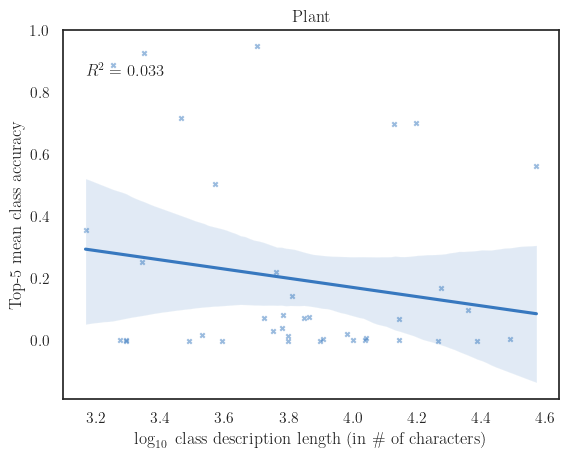

In [18]:
plt.title('Plant')
plot_fig(df, 'plants', save='class_accuracy_vs_description_length_plants')


2022-11-29 22:26:54,383 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Serif font is not compatible with usetex.
2022-11-29 22:26:54,384 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Serif font is not compatible with usetex.
2022-11-29 22:26:54,385 DEBUG              texmanager._get_font_preamble_a -:- family: serif, font: Computer Modern Roman, info: \usepackage{type1ec}
2022-11-29 22:26:54,386 DEBUG              texmanager._get_font_preamble_a -:- Arial font is not compatible with usetex.
2022-11-29 22:26:54,387 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans font is not compatible with usetex.
2022-11-29 22:26:54,388 DEBUG              texmanager._get_font_preamble_a -:- Liberation Sans font is not compatible with usetex.
2022-11-29 22:26:54,389 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans font is not compatible with usetex.
2022-11-29 22:26:54,390 DEBUG              texmanager._get_font_preamble

2022-11-29 22:26:54,439 DEBUG              texmanager._get_font_preamble_a -:- family: cursive, font: Zapf Chancery, info: \usepackage{chancery}
2022-11-29 22:26:54,440 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans Mono font is not compatible with usetex.
2022-11-29 22:26:54,440 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans Mono font is not compatible with usetex.
2022-11-29 22:26:54,441 DEBUG              texmanager._get_font_preamble_a -:- family: monospace, font: Computer Modern Typewriter, info: \usepackage{type1ec}
2022-11-29 22:26:54,442 DEBUG                 dviread.            __init__ -:- Dvi: /home/darsh/.cache/matplotlib/tex.cache/6a9fc2f080a9310f3ec0a78f57945c56.dvi
2022-11-29 22:26:54,443 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2022-11-29 22:26:54,444 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: header=

2022-11-29 22:26:54,495 DEBUG              texmanager._get_font_preamble_a -:- family: serif, font: Computer Modern Roman, info: \usepackage{type1ec}
2022-11-29 22:26:54,496 DEBUG              texmanager._get_font_preamble_a -:- Arial font is not compatible with usetex.
2022-11-29 22:26:54,497 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans font is not compatible with usetex.
2022-11-29 22:26:54,497 DEBUG              texmanager._get_font_preamble_a -:- Liberation Sans font is not compatible with usetex.
2022-11-29 22:26:54,498 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans font is not compatible with usetex.
2022-11-29 22:26:54,500 DEBUG              texmanager._get_font_preamble_a -:- family: sans-serif, font: sans-serif, info: 
2022-11-29 22:26:54,502 DEBUG              texmanager._get_font_preamble_a -:- Apple Chancery font is not compatible with usetex.
2022-11-29 22:26:54,503 DEBUG              texmanager._get_font_preamble_a -:- Tex

2022-11-29 22:26:54,567 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans Mono font is not compatible with usetex.
2022-11-29 22:26:54,568 DEBUG              texmanager._get_font_preamble_a -:- family: monospace, font: Computer Modern Typewriter, info: \usepackage{type1ec}
2022-11-29 22:26:54,569 DEBUG                 dviread.            __init__ -:- Dvi: /home/darsh/.cache/matplotlib/tex.cache/4c7e23f3269338f8a486be734ebe2f02.dvi
2022-11-29 22:26:54,569 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2022-11-29 22:26:54,570 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: header=l3backend-dvips.pro
2022-11-29 22:26:54,572 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Serif font is not compatible with usetex.
2022-11-29 22:26:54,572 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Serif font is not compatible with u

2022-11-29 22:26:54,609 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans font is not compatible with usetex.
2022-11-29 22:26:54,611 DEBUG              texmanager._get_font_preamble_a -:- Liberation Sans font is not compatible with usetex.
2022-11-29 22:26:54,611 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans font is not compatible with usetex.
2022-11-29 22:26:54,612 DEBUG              texmanager._get_font_preamble_a -:- family: sans-serif, font: sans-serif, info: 
2022-11-29 22:26:54,612 DEBUG              texmanager._get_font_preamble_a -:- Apple Chancery font is not compatible with usetex.
2022-11-29 22:26:54,613 DEBUG              texmanager._get_font_preamble_a -:- Textile font is not compatible with usetex.
2022-11-29 22:26:54,614 DEBUG              texmanager._get_font_preamble_a -:- family: cursive, font: Zapf Chancery, info: \usepackage{chancery}
2022-11-29 22:26:54,615 DEBUG              texmanager._get_font_preamble_a -:- DejaVu

2022-11-29 22:26:54,708 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Serif font is not compatible with usetex.
2022-11-29 22:26:54,709 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Serif font is not compatible with usetex.
2022-11-29 22:26:54,709 DEBUG              texmanager._get_font_preamble_a -:- family: serif, font: Computer Modern Roman, info: \usepackage{type1ec}
2022-11-29 22:26:54,710 DEBUG              texmanager._get_font_preamble_a -:- Arial font is not compatible with usetex.
2022-11-29 22:26:54,710 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans font is not compatible with usetex.
2022-11-29 22:26:54,711 DEBUG              texmanager._get_font_preamble_a -:- Liberation Sans font is not compatible with usetex.
2022-11-29 22:26:54,713 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans font is not compatible with usetex.
2022-11-29 22:26:54,713 DEBUG              texmanager._get_font_preamble

2022-11-29 22:26:54,936 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Serif font is not compatible with usetex.
2022-11-29 22:26:54,937 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Serif font is not compatible with usetex.
2022-11-29 22:26:54,937 DEBUG              texmanager._get_font_preamble_a -:- family: serif, font: Computer Modern Roman, info: \usepackage{type1ec}
2022-11-29 22:26:54,938 DEBUG              texmanager._get_font_preamble_a -:- Arial font is not compatible with usetex.
2022-11-29 22:26:54,939 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans font is not compatible with usetex.
2022-11-29 22:26:54,939 DEBUG              texmanager._get_font_preamble_a -:- Liberation Sans font is not compatible with usetex.
2022-11-29 22:26:54,940 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans font is not compatible with usetex.
2022-11-29 22:26:54,940 DEBUG              texmanager._get_font_preamble

2022-11-29 22:26:54,990 DEBUG              texmanager._get_font_preamble_a -:- family: cursive, font: Zapf Chancery, info: \usepackage{chancery}
2022-11-29 22:26:54,991 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans Mono font is not compatible with usetex.
2022-11-29 22:26:54,993 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans Mono font is not compatible with usetex.
2022-11-29 22:26:54,994 DEBUG              texmanager._get_font_preamble_a -:- family: monospace, font: Computer Modern Typewriter, info: \usepackage{type1ec}
2022-11-29 22:26:54,995 DEBUG                 dviread.            __init__ -:- Dvi: /home/darsh/.cache/matplotlib/tex.cache/8f654e6aff22b428f17468f1882a59a5.dvi
2022-11-29 22:26:54,996 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2022-11-29 22:26:54,997 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: header=

2022-11-29 22:26:55,084 DEBUG              texmanager._get_font_preamble_a -:- family: serif, font: Computer Modern Roman, info: \usepackage{type1ec}
2022-11-29 22:26:55,084 DEBUG              texmanager._get_font_preamble_a -:- Arial font is not compatible with usetex.
2022-11-29 22:26:55,085 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans font is not compatible with usetex.
2022-11-29 22:26:55,085 DEBUG              texmanager._get_font_preamble_a -:- Liberation Sans font is not compatible with usetex.
2022-11-29 22:26:55,085 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans font is not compatible with usetex.
2022-11-29 22:26:55,086 DEBUG              texmanager._get_font_preamble_a -:- family: sans-serif, font: sans-serif, info: 
2022-11-29 22:26:55,087 DEBUG              texmanager._get_font_preamble_a -:- Apple Chancery font is not compatible with usetex.
2022-11-29 22:26:55,087 DEBUG              texmanager._get_font_preamble_a -:- Tex

2022-11-29 22:26:55,128 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans Mono font is not compatible with usetex.
2022-11-29 22:26:55,128 DEBUG              texmanager._get_font_preamble_a -:- family: monospace, font: Computer Modern Typewriter, info: \usepackage{type1ec}
2022-11-29 22:26:55,129 DEBUG                 dviread.            __init__ -:- Dvi: /home/darsh/.cache/matplotlib/tex.cache/e561c136bae629f27c4646a92b46d0e4.dvi
2022-11-29 22:26:55,130 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2022-11-29 22:26:55,131 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: header=l3backend-dvips.pro
2022-11-29 22:26:55,132 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Serif font is not compatible with usetex.
2022-11-29 22:26:55,133 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Serif font is not compatible with u

2022-11-29 22:26:55,170 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans font is not compatible with usetex.
2022-11-29 22:26:55,171 DEBUG              texmanager._get_font_preamble_a -:- Liberation Sans font is not compatible with usetex.
2022-11-29 22:26:55,171 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans font is not compatible with usetex.
2022-11-29 22:26:55,172 DEBUG              texmanager._get_font_preamble_a -:- family: sans-serif, font: sans-serif, info: 
2022-11-29 22:26:55,174 DEBUG              texmanager._get_font_preamble_a -:- Apple Chancery font is not compatible with usetex.
2022-11-29 22:26:55,174 DEBUG              texmanager._get_font_preamble_a -:- Textile font is not compatible with usetex.
2022-11-29 22:26:55,175 DEBUG              texmanager._get_font_preamble_a -:- family: cursive, font: Zapf Chancery, info: \usepackage{chancery}
2022-11-29 22:26:55,175 DEBUG              texmanager._get_font_preamble_a -:- DejaVu

2022-11-29 22:26:55,232 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans Mono font is not compatible with usetex.
2022-11-29 22:26:55,233 DEBUG              texmanager._get_font_preamble_a -:- family: monospace, font: Computer Modern Typewriter, info: \usepackage{type1ec}
2022-11-29 22:26:55,234 DEBUG                 dviread.            __init__ -:- Dvi: /home/darsh/.cache/matplotlib/tex.cache/45c077f356c8cd5aee43aaa0a0fc56fc.dvi
2022-11-29 22:26:55,235 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2022-11-29 22:26:55,235 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: header=l3backend-dvips.pro
2022-11-29 22:26:55,237 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Serif font is not compatible with usetex.
2022-11-29 22:26:55,238 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Serif font is not compatible with u

2022-11-29 22:26:55,280 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans font is not compatible with usetex.
2022-11-29 22:26:55,281 DEBUG              texmanager._get_font_preamble_a -:- Liberation Sans font is not compatible with usetex.
2022-11-29 22:26:55,281 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans font is not compatible with usetex.
2022-11-29 22:26:55,282 DEBUG              texmanager._get_font_preamble_a -:- family: sans-serif, font: sans-serif, info: 
2022-11-29 22:26:55,282 DEBUG              texmanager._get_font_preamble_a -:- Apple Chancery font is not compatible with usetex.
2022-11-29 22:26:55,283 DEBUG              texmanager._get_font_preamble_a -:- Textile font is not compatible with usetex.
2022-11-29 22:26:55,283 DEBUG              texmanager._get_font_preamble_a -:- family: cursive, font: Zapf Chancery, info: \usepackage{chancery}
2022-11-29 22:26:55,285 DEBUG              texmanager._get_font_preamble_a -:- DejaVu

2022-11-29 22:26:55,329 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans Mono font is not compatible with usetex.
2022-11-29 22:26:55,330 DEBUG              texmanager._get_font_preamble_a -:- family: monospace, font: Computer Modern Typewriter, info: \usepackage{type1ec}
2022-11-29 22:26:55,332 DEBUG                 dviread.            __init__ -:- Dvi: /home/darsh/.cache/matplotlib/tex.cache/4c7e23f3269338f8a486be734ebe2f02.dvi
2022-11-29 22:26:55,333 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2022-11-29 22:26:55,333 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: header=l3backend-dvips.pro
2022-11-29 22:26:55,335 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Serif font is not compatible with usetex.
2022-11-29 22:26:55,335 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Serif font is not compatible with u

2022-11-29 22:26:56,101 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4450: 'noaccess'
2022-11-29 22:26:56,101 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4459: 'put'
2022-11-29 22:26:56,102 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 4462: '}'
2022-11-29 22:26:56,102 DEBUG              _type1font.            __init__ -:- type1font._Token ? at 4449: '{noaccess put}'
2022-11-29 22:26:56,103 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4463: 'executeonly'
2022-11-29 22:26:56,103 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4475: 'def'
2022-11-29 22:26:56,104 DEBUG              _type1font.            __init__ -:- type1font._Token name at 4479: '/MinFeature'
2022-11-29 22:26:56,106 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 4490: '{'
2022-11-29 22:26:56,106 D

2022-11-29 22:26:56,162 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4751: 'ND'
2022-11-29 22:26:56,163 DEBUG              _type1font.            __init__ -:- type1font._Token name at 4754: '/OtherSubrs'
2022-11-29 22:26:56,163 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 4912: '['
2022-11-29 22:26:56,164 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4914: 'systemdict'
2022-11-29 22:26:56,164 DEBUG              _type1font.            __init__ -:- type1font._Token name at 4925: '/internaldict'
2022-11-29 22:26:56,165 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4939: 'known'
2022-11-29 22:26:56,166 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 4945: '{'
2022-11-29 22:26:56,166 DEBUG              _type1font.            __init__ -:- type1font._Token number at 4946: '1183615869'
2022-11-29 22:26:56,17

2022-11-29 22:26:56,208 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 5310: '}'
2022-11-29 22:26:56,208 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5312: 'ifelse'
2022-11-29 22:26:56,208 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 5319: '}'
2022-11-29 22:26:56,209 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5321: 'dup'
2022-11-29 22:26:56,209 DEBUG              _type1font.            __init__ -:- type1font._Token number at 5325: '14'
2022-11-29 22:26:56,209 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5328: 'get'
2022-11-29 22:26:56,210 DEBUG              _type1font.            __init__ -:- type1font._Token number at 5332: '1'
2022-11-29 22:26:56,210 DEBUG              _type1font.            __init__ -:- type1font._Token number at 5334: '25'
2022-11-29 22:26:56,211 DEBUG              _type1fon

2022-11-29 22:26:56,248 DEBUG              _type1font.            __init__ -:- type1font._Token name at 5701: '/$FlxDict'
2022-11-29 22:26:56,249 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5711: 'known'
2022-11-29 22:26:56,249 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5717: 'not'
2022-11-29 22:26:56,250 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 5721: '{'
2022-11-29 22:26:56,250 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5723: 'dup'
2022-11-29 22:26:56,251 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5727: 'dup'
2022-11-29 22:26:56,252 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5731: 'length'
2022-11-29 22:26:56,253 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5738: 'exch'
2022-11-29 22:26:56,253 DEBUG          

2022-11-29 22:26:56,304 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6043: 'exdef'
2022-11-29 22:26:56,304 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6049: '/c4y2'
2022-11-29 22:26:56,305 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6055: 'exdef'
2022-11-29 22:26:56,306 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6061: '/c4x2'
2022-11-29 22:26:56,306 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6067: 'exdef'
2022-11-29 22:26:56,307 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6073: '/c4y1'
2022-11-29 22:26:56,308 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6079: 'exdef'
2022-11-29 22:26:56,309 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6085: '/c4x1'
2022-11-29 22:26:56,309 DEBUG              _

2022-11-29 22:26:56,359 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6404: 'c4x0'
2022-11-29 22:26:56,360 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6409: 'c4y0'
2022-11-29 22:26:56,360 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6414: 'c4x1'
2022-11-29 22:26:56,361 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6419: 'c4y1'
2022-11-29 22:26:56,362 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6424: 'c4x2'
2022-11-29 22:26:56,362 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6429: 'c4y2'
2022-11-29 22:26:56,364 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 6433: '}'
2022-11-29 22:26:56,365 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6435: 'ifelse'
2022-11-29 22:26:56,366 DEBUG          

2022-11-29 22:26:56,416 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 6710: '{'
2022-11-29 22:26:56,417 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6711: '/flipXY'
2022-11-29 22:26:56,418 DEBUG              _type1font.            __init__ -:- type1font._Token number at 6719: '1'
2022-11-29 22:26:56,418 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6721: 'def'
2022-11-29 22:26:56,419 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 6724: '}'
2022-11-29 22:26:56,419 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 6726: '{'
2022-11-29 22:26:56,420 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6727: '/flipXY'
2022-11-29 22:26:56,420 DEBUG              _type1font.            __init__ -:- type1font._Token number at 6735: '0'
2022-11-29 22:26:56,423 DEBUG              _type1fon

2022-11-29 22:26:56,468 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7028: 'div'
2022-11-29 22:26:56,469 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7032: 'abs'
2022-11-29 22:26:56,469 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 7035: '}'
2022-11-29 22:26:56,471 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7037: 'ifelse'
2022-11-29 22:26:56,471 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7044: 'def'
2022-11-29 22:26:56,472 DEBUG              _type1font.            __init__ -:- type1font._Token name at 7048: '/yshrink'
2022-11-29 22:26:56,473 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 7057: '{'
2022-11-29 22:26:56,473 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7058: 'c4y2'
2022-11-29 22:26:56,474 DEBUG             

2022-11-29 22:26:56,831 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9154: 'get'
2022-11-29 22:26:56,831 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9158: 'exec'
2022-11-29 22:26:56,832 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9163: 'exch'
2022-11-29 22:26:56,832 DEBUG              _type1font.            __init__ -:- type1font._Token name at 9168: '/FlxProc'
2022-11-29 22:26:56,832 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9177: 'exch'
2022-11-29 22:26:56,833 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9182: 'put'
2022-11-29 22:26:56,833 DEBUG              _type1font.            __init__ -:- type1font._Token boolean at 9186: 'true'
2022-11-29 22:26:56,834 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9190: '}'
2022-11-29 22:26:56,834 DEBUG             

2022-11-29 22:26:56,863 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9544: 'executeonly'
2022-11-29 22:26:56,863 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9556: '}'
2022-11-29 22:26:56,864 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9558: 'if'
2022-11-29 22:26:56,874 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9561: '{'
2022-11-29 22:26:56,875 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9562: 'gsave'
2022-11-29 22:26:56,876 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9568: 'currentpoint'
2022-11-29 22:26:56,876 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9581: 'newpath'
2022-11-29 22:26:56,877 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9589: 'moveto'
2022-11-29 22:26:56,877

2022-11-29 22:26:56,910 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9899: 'ND'
2022-11-29 22:26:56,911 DEBUG              _type1font.            __init__ -:- type1font._Token name at 9902: '/Subrs'
2022-11-29 22:26:56,911 DEBUG              _type1font.            __init__ -:- type1font._Token number at 9909: '8'
2022-11-29 22:26:56,911 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9911: 'array'
2022-11-29 22:26:56,912 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9917: 'dup'
2022-11-29 22:26:56,912 DEBUG              _type1font.            __init__ -:- type1font._Token number at 9921: '0'
2022-11-29 22:26:56,913 DEBUG              _type1font.            __init__ -:- type1font._Token number at 9923: '15'
2022-11-29 22:26:56,913 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9926: 'RD'
2022-11-29 22:26:56,913 DEBUG              _type1font.  

2022-11-29 22:26:56,946 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 10360: b' \x10\xbf1py\xc8/\x06\x80'
2022-11-29 22:26:56,946 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10371: 'ND'
2022-11-29 22:26:56,947 DEBUG              _type1font.            __init__ -:- type1font._Token name at 10374: '/Gamma'
2022-11-29 22:26:56,947 DEBUG              _type1font.            __init__ -:- type1font._Token number at 10381: '206'
2022-11-29 22:26:56,948 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10385: 'RD'
2022-11-29 22:26:56,948 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 10387: b' \x10\xbf1p@\xc2\x94W\x98\x9c\xfe\xce\x8f\xe1\xa01\r\xc7\x11\x1c\x8a\xbed\xbd\xb3W\x8esgi\xe4\x84\xfe\x80A\x12\xcdR\x10`\x7f\xc3"|\x16\x14\xc61\x14\xe8\xa5\xcf6\xd0\xf5\x82\xcd\x05\x9e\x11\xa7\xeek\x0cgz\x9c.D:{ \xcbsd\x84\xd6\x90\xc9k+s\x7fQ\x96H\xe4p\xdc\xf0\xf8\x

2022-11-29 22:26:56,973 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 11895: 'ND'
2022-11-29 22:26:56,973 DEBUG              _type1font.            __init__ -:- type1font._Token name at 11898: '/Upsilon'
2022-11-29 22:26:56,974 DEBUG              _type1font.            __init__ -:- type1font._Token number at 11907: '265'
2022-11-29 22:26:56,975 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 11911: 'RD'
2022-11-29 22:26:56,975 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 11913: b" \x10\xbf1pU\xd1\xe9\xe6)V\xa7\x8b\x16\xf5\xe62\x1e\xea+0\xc6f\x03WN&L\xc9\x90\xa2\xe5/6\xdc#fEE\xf1\x82\xc6\x9f\xd8\xc43i?\xfdfxJ\x80\x8e\x18\xa2^\xc9\x06y=\x16\xaa;vI\xe6\xc3\x92&\xc43\xb2\x0f#\x828\xe1\xdeF%W\xf7\x18\x93\xff\xbdr,\xd8\xb9\xfe\xd8\xe6[,\x86IGl\xc1\xf4\xfd\x99\x98SU\xda\xed\x9fq,\x0fKK(yt\xdf\xcbG\xd7N\\\xe5\xf0\x9a\xf2e\xe8HG\xb9\x9f\x0b\xd9\t\x8b\x0e\xd0AX8\xef\xb7xS\xc7\xd74<\xc0l\x

2022-11-29 22:26:56,995 DEBUG              _type1font.            __init__ -:- type1font._Token name at 13598: '/gamma'
2022-11-29 22:26:56,995 DEBUG              _type1font.            __init__ -:- type1font._Token number at 13605: '143'
2022-11-29 22:26:56,996 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 13609: 'RD'
2022-11-29 22:26:56,996 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 13611: b' \x10\xbf1po\xd8\x1fa\xe6x\x0b\xcfK\x02(b\xe2\xc4\xbax\xe4\x11\xf9\x96#\x08\x9c\xaeO\xd1dcW\xac\xf6Z\x7f5~iN\x01\x15\xf5M|\x14;\xc3\x837\xae\x8d\xea\xe4\xf0/\x00#ky\x01\xc33\xb2\xf0Fg\xcb\xe4\xd5\x08xS\x18\xa7\xd9 s\x8a%\x12u\x00\xceB\nL\x97\x91fT\x14\x12\xd0,\xb1\'+\x1fP\x13"\xc2\xa2\x99\x8f\xde\xa4\xd7Fo\xd1\xc8\xc4/\xa9q\x97\xbdv\xbd\x0f\xd0\x81dQ\x142w\xc2\x15\xa6i\xdf\x98K\xceCy"^\xcc'
2022-11-29 22:26:56,997 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 13756: 'ND'
2022-11-29 22:

2022-11-29 22:26:57,022 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 15031: 'ND'
2022-11-29 22:26:57,023 DEBUG              _type1font.            __init__ -:- type1font._Token name at 15034: '/lambda'
2022-11-29 22:26:57,023 DEBUG              _type1font.            __init__ -:- type1font._Token number at 15042: '121'
2022-11-29 22:26:57,024 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 15046: 'RD'
2022-11-29 22:26:57,024 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 15048: b' \x10\xbf1p2\x08\xd9v\xdct\x0en-\xfe\xaf\x81(\x94]\x00\xd0~eU(\xf4\x8a\xc6f5\'kV\x18`\xb5\xd2\\\x82\x08\xa1\xe4\xcf\xefpe\x85\x19\x96\x93\xd4\xc1\xd7>)\x19\xa1\xfd\xcd{\xd5|\xd2F\r$\xdb\xa18\xd6\xf8\xf4\xcfx9\xeb\xbd@\xd6\x170\xf0{W>\xd0\x18\xd2\xc53^\xdfr>\xc3S9\xd8?"x\xad\xbb\x13\xf4\x8f\xa7b\xa7\xa1M\xea!\xc9\xcdO1\x83\x9e9\xe8'
2022-11-29 22:26:57,024 DEBUG              _type1font.            __init_

2022-11-29 22:26:57,046 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 16408: b' \x10\xbf1pT\xa2\xfb\xd5[\x95fv\xf6C\xbcQ3w>\xe2i\xfcy\xbcWAe\xca\xb9\xc4\x99TL\xe8\xa6\xc3Q8C!\x16\x03\xcad.\xe3\x1e\xc0k\xb9\x0f2\\\xca\xd1GR\tv\x16\x80\xe7\x80\xf8~\xd8g!.\x1f\x19\x0c\xcc}\xe9Rt\xd1@\x02\xcf\x81\x8a>\xf5%9$\x81\xfbs\xbd\xdcPy\xe8'
2022-11-29 22:26:57,047 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 16506: 'ND'
2022-11-29 22:26:57,047 DEBUG              _type1font.            __init__ -:- type1font._Token name at 16509: '/upsilon'
2022-11-29 22:26:57,048 DEBUG              _type1font.            __init__ -:- type1font._Token number at 16518: '164'
2022-11-29 22:26:57,048 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 16522: 'RD'
2022-11-29 22:26:57,049 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 16524: b" \x10\xbf1pZ\xc9s,\x90n\xe8|\xfa\xd4\xe4

2022-11-29 22:26:57,064 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 17996: 'ND'
2022-11-29 22:26:57,064 DEBUG              _type1font.            __init__ -:- type1font._Token name at 17999: '/pi1'
2022-11-29 22:26:57,065 DEBUG              _type1font.            __init__ -:- type1font._Token number at 18004: '211'
2022-11-29 22:26:57,065 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 18008: 'RD'
2022-11-29 22:26:57,066 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 18010: b' \x10\xbf1pT\xa3P\x9d\x94\x93\xcdO\xc8\\i\x86\xc2L`\xce\x81@\x00\xa7\x12Y\xee\x93!\xdd\x87\x83\xa1\xac\x0e\xabz*F/\x89\x90;n(eM\xc4\xe9\xe2F2+\x85f\x18\x13\'\x10T\xfb\x14i\x0b\xf5\x7f3\x1fz|\xdfQQEz\xb8\x97\xe2\xdd,\xb5\xb3!E\xedD}\t0\x05\xaa+\xc5\x9f\xb5\xc8\x11?EGeU\x039\xb9O\x18+\xfd[$b:\x91\x9d7\xd9\x1c\xb6\xb4\x86\x01\xa8\xd4\x1ac\xa2\x04\x97n\xc8\x03\xb2;D\x08\xe0\xf24\x1f*7b\xfdVw\xfe\xa5\x1b\xa7\xc7

2022-11-29 22:26:57,086 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 19239: b' \x10\xbf1p0\xa41\xaf\xb3W\xdb\x87\x9aI\xd3(5d\x19\x97o\x02\xe4\xb6\xa8d\x15}\xffF]\xed\xcf?]\x0b\x88\xddi\xa4\x1c\x0c\xe7\x0f\x18\x8f\x90:\xe0\xb7q\x91~1$\xbd\x89\x0e\xb7\xd2\x9b\xe9\xfd\xcd\xebSY\xe4\x97\xbe!\xfd\xa6\xe3'
2022-11-29 22:26:57,087 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 19315: 'ND'
2022-11-29 22:26:57,087 DEBUG              _type1font.            __init__ -:- type1font._Token name at 19318: '/arrowhookright'
2022-11-29 22:26:57,088 DEBUG              _type1font.            __init__ -:- type1font._Token number at 19334: '75'
2022-11-29 22:26:57,088 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 19337: 'RD'
2022-11-29 22:26:57,089 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 19339: b' \x10\xbf1p0\xa41\xaf\xb3W\xdb\x87\x9aI\xd3(N\xed\x15\xb5\xf6

2022-11-29 22:26:57,120 DEBUG              _type1font.            __init__ -:- type1font._Token number at 20506: '204'
2022-11-29 22:26:57,120 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 20510: 'RD'
2022-11-29 22:26:57,120 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 20512: b' \x10\xbf1pO\xaa\xa9P!\xb9\x18\x19\x86\xe87v\x9a5\xd0\x97\xd6\x85P\xe9\xb5LH\xad`\x83\x8b\xd6\xc8\x0fA\x07D\xa7>\xc5\x1ax\x85\x9d\xbf\xb6v\xf1\xa9<\xdaT\'q\x118\xd8/s\x8e\xe9,\x0c\xff{$My.\x94kx\xdc\xee\xd0E\x82\x1f\\DT\x11\xea\xe0tJ\xed@\xf0\xcdK\x0c4\xe6\x83`{\xb9L"7_2h\xe1*\x1e\xb4\x8e\xef$\xf51\xab\x0e)dj\xebg`\xba\x1bo\x81\xa1\xbd4\xd2AV\xeam\xa8\xdaw/\x10Z\xa5\x8d\xae\x92\xc8\nOc\x95\x83|Z\xcb\x0c\xd0\xbf\xd4aC\x94\xf4\xcec\x91\xc9&\x92^\xc3\xae@\x1d\x94\x98\'\xc7\x07\x06M\xc2A\xe2J\x0eE\xac\x9d\xba\xcf\xa3W\x1d\xe34"\xff@@\xa5\x14\xdd\\\xac\x96\x9f'
2022-11-29 22:26:57,121 DEBUG              _type1font.            __init__ -:- type1

2022-11-29 22:26:57,145 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 21838: 'ND'
2022-11-29 22:26:57,152 DEBUG              _type1font.            __init__ -:- type1font._Token name at 21841: '/greater'
2022-11-29 22:26:57,152 DEBUG              _type1font.            __init__ -:- type1font._Token number at 21850: '93'
2022-11-29 22:26:57,153 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 21853: 'RD'
2022-11-29 22:26:57,153 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 21855: b' \x10\xbf1p,\xe0\r\xd5\x0b\x1f\x9fu\xcd"\x1b~QW\r\x94\xf5R\xde\x1c\xf3hx\xef\'\xeaX+E\xc7\xf0\xfa\xa7A\xbd\\\x91Bnn\xef\xf1\x98e\n\x97+\xa2bl\t\xc5\x9b\x82\xf7+\xad\xb7>\xbd\xd1\xa3F\x83\xfbW\xf2[W\xbf\xdbs\tH\xfbE\xa1s\x94\x97#dE1_\xc402\x06'
2022-11-29 22:26:57,154 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 21950: 'ND'
2022-11-29 22:26:57,154 DEBUG              _

2022-11-29 22:26:57,173 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 23378: 'ND'
2022-11-29 22:26:57,174 DEBUG              _type1font.            __init__ -:- type1font._Token name at 23381: '/F'
2022-11-29 22:26:57,174 DEBUG              _type1font.            __init__ -:- type1font._Token number at 23384: '279'
2022-11-29 22:26:57,180 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 23388: 'RD'
2022-11-29 22:26:57,180 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 23390: b' \x10\xbf1pC\\\xe8K\xd5fV8\x1f\xd2/\xcf;\xd9u\x10\xd7Lk>\xc9\xfd\x0fq\xfe[\xdaL\xe6\xa2hvo\x08\xecu\x1d\x96\xe6\xa4\xeaX\xc0\x0f\xec\x98\xfa:~W\xd2\xcf\xb7\xeb\x90\xac8\xc2\xe1E\xd0\xc0x8\n\xfaq\x1b\xe1\xc3gh\x1a\x9d\x1b^^w\x7f\xd4\xf8J]\x1e\x1fg\x0e\x9c{\xa9\xaeq\xa5\x07\xe6\x03\x92\xa7\x9aj\x8e\xe5\x94\xf5\xf6[\x0b\x91*\x9e\xca\xf8@\x80[\x03\x18\xe2\xedlPE=o|\x1d\x9b\x03<\x0b2\xb2\xea\xd3\x1c\x9a\x12\xf0\xe

2022-11-29 22:26:57,200 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 25141: 'ND'
2022-11-29 22:26:57,201 DEBUG              _type1font.            __init__ -:- type1font._Token name at 25144: '/L'
2022-11-29 22:26:57,202 DEBUG              _type1font.            __init__ -:- type1font._Token number at 25147: '203'
2022-11-29 22:26:57,203 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 25151: 'RD'
2022-11-29 22:26:57,203 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 25153: b" \x10\xbf1p@\xc3\x027\xf9\xaa\x85\xa2\x127\xde2h]\x0c\xed\xcet\xd0\xd4-/\x01\x08X\xa0\xac\xa66\x9a/J2@\xa92\xb6\xfcO\x17JW99\xa4\xaa\xb3H[)y\xb6h\xc6TkD\xd9s\xca\x9a ;W\x0c\x18\xde\xb3\x00\xc5X\xd1;\x13\xfcb(_D,\x8d\x84\xb5I\xdanu+\xfc\xbe\xfb\x98\xe7\x9f\xa5O\xd8\xa3\xef\x12\x8c\x0f\xae\x18\xf7z\x9f\xc8i'\xc7\xd4\x13\x80\xb6\xeese\xb2\xb4X.^6\x85N\x80\x85K\x86\x83vA\x92\xdep\xc2\xaa\xc5\xe5\x18\xfa\x9ao+\t\x

2022-11-29 22:26:57,231 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 26795: 'ND'
2022-11-29 22:26:57,232 DEBUG              _type1font.            __init__ -:- type1font._Token name at 26798: '/S'
2022-11-29 22:26:57,234 DEBUG              _type1font.            __init__ -:- type1font._Token number at 26801: '213'
2022-11-29 22:26:57,234 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 26805: 'RD'
2022-11-29 22:26:57,235 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 26807: b' \x10\xbf1pMM\x16N\xf28\xed\xfc\xd3H\xa3\xadh\xcaC,\xd3\xd1\xad\x05\xa8\x985\xca.6\xa9P\x1c\x89\xadq\x7f\x0c\xb5\xe9\xc46q"\'6+\x9cT4\x86<\x00\x882\xe0\x81 \xd0~y"\xfd\x16\xd2Vw"//\xdb\x8a\xfa?\xb0\xb6*`\xbdT\xbcNxB\xd0\xf3\xf5!I\xf0_\x98\xfb\xfa\x8dfk|\xa3\r\xc9:@\'/\x80<)\x1b\xdd0\xf5P\xde\xb6\xed\xf2\x12\x99X\x13\xc4Z\xf6\x1cbJ\xc2\x16uMA\xd8#(\xbe\xe0\x7fq\xda7\xd3)V \xcdZ\xbamD\xaf\x05W\xc1\xbd\xb5\xc2\x

2022-11-29 22:26:57,250 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 28544: 'ND'
2022-11-29 22:26:57,250 DEBUG              _type1font.            __init__ -:- type1font._Token name at 28547: '/Y'
2022-11-29 22:26:57,252 DEBUG              _type1font.            __init__ -:- type1font._Token number at 28550: '326'
2022-11-29 22:26:57,252 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 28554: 'RD'
2022-11-29 22:26:57,252 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 28556: b" \x10\xbf1p\\6\xb7\xc8\x8b3\xc7\x1b\x00U\xe6\xa6\x04\x9emt\xa4\xd9*\xa0\x01p$\xf0\x16&\x08\xc5E\xb9J\xeb\xb7N\xf3\x11pP\x80\xcc\x8a\xa9\x0f\xea\xf2\xf2\n\x1d\r\xc9\xe1\x8f;\xeb\x8f\xfa.\x02\x02\xa50\xd0\xf2\xf3\x91\xc9e|@\xa6\xc5T\xcdI\x11\x90\x03;64\x81I\xbd\xea\x18m0\xfdS\x15\xd1g\xcf\x10\xfc\rk\r\xd42\x1f\x94\x81\x01:Q\x96-\x13Z\x96Pu\x02\rQ\xc2Ej\xb48P\x08:\xf5NN\x19m)\x95\xd3\xf2'QL\xc1\x0b\xcdg\xf7\xab\

2022-11-29 22:26:57,281 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 29978: 'ND'
2022-11-29 22:26:57,282 DEBUG              _type1font.            __init__ -:- type1font._Token name at 29981: '/a'
2022-11-29 22:26:57,283 DEBUG              _type1font.            __init__ -:- type1font._Token number at 29984: '141'
2022-11-29 22:26:57,284 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 29988: 'RD'
2022-11-29 22:26:57,287 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 29990: b' \x10\xbf1pA\xf0\x850|\x8b\x06\x1b\xe1\x8e\x8c\xe8\x87\x99\x93#\x99\xc6)\xec\x9d\xcfS\xda\xb2\xb3I\xc9\x91\xe4\x98\x83Y\xb0\'K\xef(\xa0\x14\xb4J\xc66\xac\x8b\x0c\x04"8;[\xd3I\xc8.\xc1I\xfc\xc2`Z\x95\x8aR1\xea\xdd\xdfV\x97kx0\r\xe0\x1a\xb45L\xd1\xcd\xa0\x02\xc3pX\xb7\xf4\xbc\x91\x17k\x87\xc8\x1d\xaf\x07\xc1\xdc\xbe\xf7\x92\x1b\xca8\xbf\xe6:\xbc\xc4{\xd8\xf1\xb9s4\x1fBz\xc0e\xa0\x00\x0e<\x7fQ"z\xc0}\xc2\x80\x8e

2022-11-29 22:26:57,313 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 31369: 'ND'
2022-11-29 22:26:57,313 DEBUG              _type1font.            __init__ -:- type1font._Token name at 31372: '/i'
2022-11-29 22:26:57,314 DEBUG              _type1font.            __init__ -:- type1font._Token number at 31375: '59'
2022-11-29 22:26:57,314 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 31378: 'RD'
2022-11-29 22:26:57,315 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 31380: b' \x10\xbf1pZ\xc6\xbbm\xb1\x94B\x0c\xeb\x91\x96\xe9\x8a\xea\x84\x8b\x01ePFL\xef\x04\xddG\xd9(\xf3\xc0C\xbcG$\xbd\x1c\x91(\x87\x16\xbf`\x1e\x14\x0b\xa9\xa8{3\xa2)\xea\x8e\x95\xba\x01'
2022-11-29 22:26:57,316 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 31441: 'ND'
2022-11-29 22:26:57,316 DEBUG              _type1font.            __init__ -:- type1font._Token name at 31444: '

2022-11-29 22:26:57,335 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 32921: 'ND'
2022-11-29 22:26:57,336 DEBUG              _type1font.            __init__ -:- type1font._Token name at 32924: '/q'
2022-11-29 22:26:57,336 DEBUG              _type1font.            __init__ -:- type1font._Token number at 32927: '206'
2022-11-29 22:26:57,337 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 32931: 'RD'
2022-11-29 22:26:57,337 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 32933: b" \x10\xbf1pA\xf0s\xb4jVgOX\x99\xbf\xb0r\x18+l\xc1\xcaT\xef.\xe5\x19\xa1\xddt\xca\xdc\x04\x11\xae\x13\xae\xaa\xaa\xe9Y\x98\xa9\x84\x94n\xa6\x96\xba\xe0Q\xda#,C\x95\xf1-4\\l\x1d\xdc-\x7f\xbc\xbf\xa9tJ\x93\x01\x0e\x8a\x1c<\xe2\xbdNA\xca\x0b\r\xc0\xe9\xc8%M'\x19%\xef_\x91\x89\xc7\x80Mb`\x7f\x92\xeds\xa0\x1e:52Vd\x873\xd3\x9f\xfc\x99&\xb4\x9c\xdaW\xc2\x05\xd3F\x99\xfd\x12\xbc\xd7\xcc\xe4d\x8b\x13\x0f\xa9\xbb\x06\x

2022-11-29 22:26:57,358 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 34275: b" \x10\xbf1pZ\xc9\x0c\x1e&\xd6eU\xe4!W\xe9\x8dK\x04)\t\xff\xbe\xf6\xb0'\x14p\x14A0S\xe3\xfc\xfbtl\xa2\xf6\xbf\xa0\xe4\xfcT\\\xc1\x1fMrQB\xc2\x1e\xfeg\xad\x06n\xeb<\xb6w0\x82x\xab/\xa7\xd9\xd0`9o@\x1d\xaa\xc5j\xa4:L\xe0~,vy\xbd\xb9Y$\xe0\xa1\xbd\xdc\\6\xa8~\xb4\xaa\xd4\x16\xeb\x92\xdbj\xbcZjGu\xd7\x19\xa7\xa6&\x10=\xc8\xc5\xd2\xec.\xe2q\xc2V\xa0\xa9\xd7(\xed\x17\xe3\xc4L\xa0tMgQ\xfe6\x8aJ\xaa\xa3\x0f\xc6\xeb\xdc\x1c\x08\x0fd\x94\xbc\xa1\x9c\xf16y\xafiG\x82\x01\xb5\xc8\xf7\xaf\xbc\x14\x92hvg\x9b\xc9\xbd\xd9\x96\xc8\r\xab\xe0\xf9\xc3N\x02\x04\xfe\xa1\x19\xfc\x84\tH0b=\xd92\xebX!\xbc\xa3X\xd9\xe5"
2022-11-29 22:26:57,360 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 34488: 'ND'
2022-11-29 22:26:57,361 DEBUG              _type1font.            __init__ -:- type1font._Token name at 34491: '/y'
2022-11-29 22:26:57,362 DEBUG              _type1f

2022-11-29 22:26:57,399 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 35637: 'ND'
2022-11-29 22:26:57,400 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 35640: 'end'
2022-11-29 22:26:57,401 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 35644: 'end'
2022-11-29 22:26:57,403 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 35648: 'readonly'
2022-11-29 22:26:57,403 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 35657: 'put'
2022-11-29 22:26:57,405 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 35661: 'put'
2022-11-29 22:26:57,406 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 35665: 'dup'
2022-11-29 22:26:57,407 DEBUG              _type1font.            __init__ -:- type1font._Token name at 35668: '/FontName'
2022-11-29 22:26:57,409 DEBUG    

2022-11-29 22:26:57,550 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 703: '['
2022-11-29 22:26:57,550 DEBUG              _type1font.            __init__ -:- type1font._Token number at 704: '0.001'
2022-11-29 22:26:57,551 DEBUG              _type1font.            __init__ -:- type1font._Token number at 710: '0'
2022-11-29 22:26:57,553 DEBUG              _type1font.            __init__ -:- type1font._Token number at 712: '0'
2022-11-29 22:26:57,554 DEBUG              _type1font.            __init__ -:- type1font._Token number at 714: '0.001'
2022-11-29 22:26:57,555 DEBUG              _type1font.            __init__ -:- type1font._Token number at 720: '0'
2022-11-29 22:26:57,556 DEBUG              _type1font.            __init__ -:- type1font._Token number at 722: '0'
2022-11-29 22:26:57,556 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 724: ']'
2022-11-29 22:26:57,557 DEBUG              _type1font.            

2022-11-29 22:26:57,602 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1266: '/ascent'
2022-11-29 22:26:57,603 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1274: '750'
2022-11-29 22:26:57,603 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1278: 'def'
2022-11-29 22:26:57,604 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1282: 'end'
2022-11-29 22:26:57,605 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1286: 'readonly'
2022-11-29 22:26:57,605 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1295: 'def'
2022-11-29 22:26:57,606 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1299: '/Encoding'
2022-11-29 22:26:57,607 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1309: '256'
2022-11-29 22:26:57,612 DEBUG            

2022-11-29 22:26:57,662 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1567: '/beta'
2022-11-29 22:26:57,664 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1573: 'put'
2022-11-29 22:26:57,666 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1577: 'dup'
2022-11-29 22:26:57,668 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1581: '13'
2022-11-29 22:26:57,669 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1584: '/gamma'
2022-11-29 22:26:57,669 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1591: 'put'
2022-11-29 22:26:57,670 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1595: 'dup'
2022-11-29 22:26:57,671 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1599: '14'
2022-11-29 22:26:57,677 DEBUG              _type1font

2022-11-29 22:26:57,752 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1869: 'dup'
2022-11-29 22:26:57,753 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1873: '30'
2022-11-29 22:26:57,754 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1876: '/phi'
2022-11-29 22:26:57,755 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1881: 'put'
2022-11-29 22:26:57,756 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1885: 'dup'
2022-11-29 22:26:57,757 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1889: '31'
2022-11-29 22:26:57,772 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1892: '/chi'
2022-11-29 22:26:57,774 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1897: 'put'
2022-11-29 22:26:57,777 DEBUG              _type1font.  

2022-11-29 22:26:57,853 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2244: '47'
2022-11-29 22:26:57,854 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2247: '/triangleleft'
2022-11-29 22:26:57,855 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2261: 'put'
2022-11-29 22:26:57,856 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2265: 'dup'
2022-11-29 22:26:57,857 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2269: '48'
2022-11-29 22:26:57,859 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2272: '/zerooldstyle'
2022-11-29 22:26:57,862 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2286: 'put'
2022-11-29 22:26:57,863 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2290: 'dup'
2022-11-29 22:26:57,864 DEBUG         

2022-11-29 22:26:57,910 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2631: '/partialdiff'
2022-11-29 22:26:57,911 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2644: 'put'
2022-11-29 22:26:57,912 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2648: 'dup'
2022-11-29 22:26:57,912 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2652: '65'
2022-11-29 22:26:57,913 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2655: '/A'
2022-11-29 22:26:57,914 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2658: 'put'
2022-11-29 22:26:57,914 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2662: 'dup'
2022-11-29 22:26:57,915 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2666: '66'
2022-11-29 22:26:57,916 DEBUG              _type1f

2022-11-29 22:26:57,963 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2886: 'dup'
2022-11-29 22:26:57,964 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2890: '82'
2022-11-29 22:26:57,965 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2893: '/R'
2022-11-29 22:26:57,965 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2896: 'put'
2022-11-29 22:26:57,965 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2900: 'dup'
2022-11-29 22:26:57,966 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2904: '83'
2022-11-29 22:26:57,966 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2907: '/S'
2022-11-29 22:26:57,967 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2910: 'put'
2022-11-29 22:26:57,967 DEBUG              _type1font.      

2022-11-29 22:26:58,016 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3166: '/c'
2022-11-29 22:26:58,016 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3169: 'put'
2022-11-29 22:26:58,017 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3173: 'dup'
2022-11-29 22:26:58,018 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3177: '100'
2022-11-29 22:26:58,018 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3181: '/d'
2022-11-29 22:26:58,019 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3184: 'put'
2022-11-29 22:26:58,020 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3188: 'dup'
2022-11-29 22:26:58,024 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3192: '101'
2022-11-29 22:26:58,028 DEBUG              _type1font.    

2022-11-29 22:26:58,097 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3428: 'dup'
2022-11-29 22:26:58,097 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3432: '117'
2022-11-29 22:26:58,099 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3436: '/u'
2022-11-29 22:26:58,099 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3439: 'put'
2022-11-29 22:26:58,100 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3443: 'dup'
2022-11-29 22:26:58,102 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3447: '118'
2022-11-29 22:26:58,103 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3451: '/v'
2022-11-29 22:26:58,104 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3454: 'put'
2022-11-29 22:26:58,110 DEBUG              _type1font.    

2022-11-29 22:26:58,157 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3745: '/Xi'
2022-11-29 22:26:58,158 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3749: 'put'
2022-11-29 22:26:58,158 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3753: 'dup'
2022-11-29 22:26:58,159 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3757: '166'
2022-11-29 22:26:58,159 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3761: '/Pi'
2022-11-29 22:26:58,160 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3765: 'put'
2022-11-29 22:26:58,160 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3769: 'dup'
2022-11-29 22:26:58,161 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3773: '167'
2022-11-29 22:26:58,162 DEBUG              _type1font.  

2022-11-29 22:26:58,226 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4070: 'dup'
2022-11-29 22:26:58,227 DEBUG              _type1font.            __init__ -:- type1font._Token number at 4074: '185'
2022-11-29 22:26:58,228 DEBUG              _type1font.            __init__ -:- type1font._Token name at 4078: '/mu'
2022-11-29 22:26:58,228 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4082: 'put'
2022-11-29 22:26:58,229 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4086: 'dup'
2022-11-29 22:26:58,230 DEBUG              _type1font.            __init__ -:- type1font._Token number at 4090: '186'
2022-11-29 22:26:58,234 DEBUG              _type1font.            __init__ -:- type1font._Token name at 4094: '/nu'
2022-11-29 22:26:58,234 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4098: 'put'
2022-11-29 22:26:58,235 DEBUG              _type1font.  

2022-11-29 22:26:58,300 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4397: 'executeonly'
2022-11-29 22:26:58,302 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4409: 'def'
2022-11-29 22:26:58,303 DEBUG              _type1font.            __init__ -:- type1font._Token name at 4413: '/ND'
2022-11-29 22:26:58,304 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 4416: '{'
2022-11-29 22:26:58,305 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4417: 'noaccess'
2022-11-29 22:26:58,306 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4426: 'def'
2022-11-29 22:26:58,308 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 4429: '}'
2022-11-29 22:26:58,309 DEBUG              _type1font.            __init__ -:- type1font._Token ? at 4416: '{noaccess def}'
2022-11-29 22:26:58,310 DEBUG    

2022-11-29 22:26:58,376 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 4704: ']'
2022-11-29 22:26:58,377 DEBUG              _type1font.            __init__ -:- type1font._Token ? at 4699: '[ 65 ]'
2022-11-29 22:26:58,377 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4706: 'ND'
2022-11-29 22:26:58,378 DEBUG              _type1font.            __init__ -:- type1font._Token name at 4709: '/ForceBold'
2022-11-29 22:26:58,378 DEBUG              _type1font.            __init__ -:- type1font._Token boolean at 4720: 'false'
2022-11-29 22:26:58,379 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 4726: 'def'
2022-11-29 22:26:58,380 DEBUG              _type1font.            __init__ -:- type1font._Token name at 4730: '/StemSnapH'
2022-11-29 22:26:58,380 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 4741: '['
2022-11-29 22:26:58,381 DEBUG             

2022-11-29 22:26:58,415 DEBUG              _type1font.            __init__ -:- type1font._Token number at 5240: '1183615869'
2022-11-29 22:26:58,415 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5251: 'eq'
2022-11-29 22:26:58,416 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 5254: '{'
2022-11-29 22:26:58,416 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5255: 'pop'
2022-11-29 22:26:58,417 DEBUG              _type1font.            __init__ -:- type1font._Token number at 5259: '0'
2022-11-29 22:26:58,417 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 5260: '}'
2022-11-29 22:26:58,417 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 5262: '{'
2022-11-29 22:26:58,418 DEBUG              _type1font.            __init__ -:- type1font._Token name at 5263: '/internaldict'
2022-11-29 22:26:58,418 DEBUG          

2022-11-29 22:26:58,461 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5614: 'if'
2022-11-29 22:26:58,462 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 5617: '{'
2022-11-29 22:26:58,463 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5619: 'systemdict'
2022-11-29 22:26:58,463 DEBUG              _type1font.            __init__ -:- type1font._Token name at 5630: '/internaldict'
2022-11-29 22:26:58,464 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5644: 'known'
2022-11-29 22:26:58,464 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 5650: '{'
2022-11-29 22:26:58,465 DEBUG              _type1font.            __init__ -:- type1font._Token number at 5652: '1183615869'
2022-11-29 22:26:58,466 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5663: 'systemdict'
2022-11-29 22:26:58,

2022-11-29 22:26:58,510 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5991: 'def'
2022-11-29 22:26:58,511 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 5994: '}'
2022-11-29 22:26:58,511 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5996: 'def'
2022-11-29 22:26:58,512 DEBUG              _type1font.            __init__ -:- type1font._Token name at 6000: '/dmin'
2022-11-29 22:26:58,514 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6006: 'exch'
2022-11-29 22:26:58,516 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6011: 'abs'
2022-11-29 22:26:58,516 DEBUG              _type1font.            __init__ -:- type1font._Token number at 6015: '100'
2022-11-29 22:26:58,517 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6019: 'div'
2022-11-29 22:26:58,517 DEBUG              _type1

2022-11-29 22:26:58,563 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6352: 'c2x1'
2022-11-29 22:26:58,565 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6357: 'c2y1'
2022-11-29 22:26:58,566 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6362: 'c2x2'
2022-11-29 22:26:58,567 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6367: 'c2y2'
2022-11-29 22:26:58,568 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 6371: '}'
2022-11-29 22:26:58,569 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 6373: '{'
2022-11-29 22:26:58,575 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6374: 'c3x0'
2022-11-29 22:26:58,576 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6379: 'c3y0'
2022-11-29 22:26:58,578 DEBUG             

2022-11-29 22:26:58,625 DEBUG              _type1font.            __init__ -:- type1font._Token number at 6663: '1'
2022-11-29 22:26:58,625 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6665: 'get'
2022-11-29 22:26:58,626 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6669: 'abs'
2022-11-29 22:26:58,627 DEBUG              _type1font.            __init__ -:- type1font._Token number at 6673: '.00001'
2022-11-29 22:26:58,627 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6680: 'lt'
2022-11-29 22:26:58,628 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6683: 'mtx'
2022-11-29 22:26:58,629 DEBUG              _type1font.            __init__ -:- type1font._Token number at 6687: '2'
2022-11-29 22:26:58,629 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6689: 'get'
2022-11-29 22:26:58,630 DEBUG              _type1font

2022-11-29 22:26:58,685 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6988: 'c4y2'
2022-11-29 22:26:58,686 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6993: 'eq'
2022-11-29 22:26:58,686 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 6996: '{'
2022-11-29 22:26:58,688 DEBUG              _type1font.            __init__ -:- type1font._Token number at 6997: '0'
2022-11-29 22:26:58,694 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 6998: '}'
2022-11-29 22:26:58,695 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 6999: '{'
2022-11-29 22:26:58,695 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7000: 'c1y2'
2022-11-29 22:26:58,696 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7005: 'c4y2'
2022-11-29 22:26:58,697 DEBUG              _type1

2022-11-29 22:26:58,742 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7303: 'pop'
2022-11-29 22:26:58,743 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7307: 'abs'
2022-11-29 22:26:58,744 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7311: 'def'
2022-11-29 22:26:58,745 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7315: 'dY'
2022-11-29 22:26:58,745 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7318: 'dmin'
2022-11-29 22:26:58,746 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7323: 'lt'
2022-11-29 22:26:58,746 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7326: 'PickCoords'
2022-11-29 22:26:58,747 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7337: 'y2'
2022-11-29 22:26:58,747 DEBUG              

2022-11-29 22:26:58,819 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 7564: '}'
2022-11-29 22:26:58,820 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7566: 'ifelse'
2022-11-29 22:26:58,822 DEBUG              _type1font.            __init__ -:- type1font._Token name at 7573: '/erode'
2022-11-29 22:26:58,823 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7580: 'PaintType'
2022-11-29 22:26:58,824 DEBUG              _type1font.            __init__ -:- type1font._Token number at 7590: '2'
2022-11-29 22:26:58,829 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7592: 'ne'
2022-11-29 22:26:58,830 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7595: 'erosion'
2022-11-29 22:26:58,832 DEBUG              _type1font.            __init__ -:- type1font._Token number at 7603: '0.5'
2022-11-29 22:26:58,833 DEBUG           

2022-11-29 22:26:58,886 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7847: 'def'
2022-11-29 22:26:58,886 DEBUG              _type1font.            __init__ -:- type1font._Token name at 7851: '/y3'
2022-11-29 22:26:58,887 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7855: 'y3'
2022-11-29 22:26:58,888 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7858: 'eShift'
2022-11-29 22:26:58,888 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7865: 'add'
2022-11-29 22:26:58,889 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7869: 'def'
2022-11-29 22:26:58,890 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 7873: '}'
2022-11-29 22:26:58,891 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7875: 'if'
2022-11-29 22:26:58,892 DEBUG              _type1f

2022-11-29 22:26:58,949 DEBUG              _type1font.            __init__ -:- type1font._Token name at 8147: '/c1y0'
2022-11-29 22:26:58,950 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8153: 'c3y0'
2022-11-29 22:26:58,950 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8158: 'def'
2022-11-29 22:26:58,951 DEBUG              _type1font.            __init__ -:- type1font._Token name at 8162: '/c1y1'
2022-11-29 22:26:58,952 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8168: 'c3y1'
2022-11-29 22:26:58,952 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8173: 'def'
2022-11-29 22:26:58,953 DEBUG              _type1font.            __init__ -:- type1font._Token name at 8177: '/c2y0'
2022-11-29 22:26:58,953 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8183: 'c4y0'
2022-11-29 22:26:58,954 DEBUG              _type

2022-11-29 22:26:59,012 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8452: 'if'
2022-11-29 22:26:59,014 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8455: 'pop'
2022-11-29 22:26:59,014 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8459: 'def'
2022-11-29 22:26:59,015 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8463: 'dX'
2022-11-29 22:26:59,016 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8466: 'round'
2022-11-29 22:26:59,017 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8472: 'dup'
2022-11-29 22:26:59,018 DEBUG              _type1font.            __init__ -:- type1font._Token number at 8476: '0'
2022-11-29 22:26:59,018 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8478: 'ne'
2022-11-29 22:26:59,019 DEBUG              _type1fon

2022-11-29 22:26:59,082 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8701: 'cy'
2022-11-29 22:26:59,083 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8704: 'flipXY'
2022-11-29 22:26:59,083 DEBUG              _type1font.            __init__ -:- type1font._Token number at 8711: '-1'
2022-11-29 22:26:59,084 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8714: 'eq'
2022-11-29 22:26:59,084 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 8717: '{'
2022-11-29 22:26:59,085 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8718: 'exch'
2022-11-29 22:26:59,089 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 8722: '}'
2022-11-29 22:26:59,090 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8724: 'if'
2022-11-29 22:26:59,090 DEBUG              _type1

2022-11-29 22:26:59,129 DEBUG              _type1font.            __init__ -:- type1font._Token name at 8973: '/currentpacking'
2022-11-29 22:26:59,130 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8989: 'known'
2022-11-29 22:26:59,132 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 8995: '{'
2022-11-29 22:26:59,133 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8996: 'exch'
2022-11-29 22:26:59,134 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9001: 'setpacking'
2022-11-29 22:26:59,134 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9011: '}'
2022-11-29 22:26:59,135 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9013: 'if'
2022-11-29 22:26:59,135 DEBUG              _type1font.            __init__ -:- type1font._Token name at 9016: '/exec'
2022-11-29 22:26:59,136 DEBUG  

2022-11-29 22:26:59,196 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9366: 'ifelse'
2022-11-29 22:26:59,197 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9373: '{'
2022-11-29 22:26:59,197 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9374: 'systemdict'
2022-11-29 22:26:59,198 DEBUG              _type1font.            __init__ -:- type1font._Token name at 9385: '/internaldict'
2022-11-29 22:26:59,198 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9399: 'known'
2022-11-29 22:26:59,199 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9405: '{'
2022-11-29 22:26:59,199 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9406: '{'
2022-11-29 22:26:59,200 DEBUG              _type1font.            __init__ -:- type1font._Token number at 9407: '1183615869'
2022-11-29 22:26:59,200

2022-11-29 22:26:59,244 DEBUG              _type1font.            __init__ -:- type1font._Token name at 9791: '/startlock'
2022-11-29 22:26:59,245 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9802: 'get'
2022-11-29 22:26:59,245 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9806: 'exec'
2022-11-29 22:26:59,246 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9810: '}'
2022-11-29 22:26:59,247 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9812: '{'
2022-11-29 22:26:59,247 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9813: 'dup'
2022-11-29 22:26:59,248 DEBUG              _type1font.            __init__ -:- type1font._Token name at 9817: '/strtlck'
2022-11-29 22:26:59,249 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9826: 'known'
2022-11-29 22:26:59,249 DEBUG          

2022-11-29 22:26:59,265 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9899: 'ND'
2022-11-29 22:26:59,266 DEBUG              _type1font.            __init__ -:- type1font._Token name at 9902: '/Subrs'
2022-11-29 22:26:59,267 DEBUG              _type1font.            __init__ -:- type1font._Token number at 9909: '55'
2022-11-29 22:26:59,267 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9912: 'array'
2022-11-29 22:26:59,268 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9918: 'dup'
2022-11-29 22:26:59,269 DEBUG              _type1font.            __init__ -:- type1font._Token number at 9922: '0'
2022-11-29 22:26:59,270 DEBUG              _type1font.            __init__ -:- type1font._Token number at 9924: '15'
2022-11-29 22:26:59,270 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9927: 'RD'
2022-11-29 22:26:59,271 DEBUG              _type1font. 

2022-11-29 22:26:59,321 DEBUG              _type1font.            __init__ -:- type1font._Token number at 10257: '10'
2022-11-29 22:26:59,321 DEBUG              _type1font.            __init__ -:- type1font._Token number at 10260: '24'
2022-11-29 22:26:59,322 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10263: 'RD'
2022-11-29 22:26:59,322 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 10265: b' \x10\xbf1ps\xc6m\x9e\xe3\xf8\x8c@\x89\x9cpuF\x89\x1e\x8eU\r\xc4\x1d'
2022-11-29 22:26:59,323 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10291: 'NP'
2022-11-29 22:26:59,324 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10294: 'dup'
2022-11-29 22:26:59,324 DEBUG              _type1font.            __init__ -:- type1font._Token number at 10298: '11'
2022-11-29 22:26:59,325 DEBUG              _type1font.            __init__ -:- type1font._Token number 

2022-11-29 22:26:59,366 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10684: 'NP'
2022-11-29 22:26:59,367 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10687: 'dup'
2022-11-29 22:26:59,367 DEBUG              _type1font.            __init__ -:- type1font._Token number at 10691: '21'
2022-11-29 22:26:59,368 DEBUG              _type1font.            __init__ -:- type1font._Token number at 10694: '31'
2022-11-29 22:26:59,368 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10697: 'RD'
2022-11-29 22:26:59,369 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 10699: b' \x10\xbf1p\t\x8bO~\xb6\xd7\xbf\xb3*\x98\x99\x82\xc3&f<b\x966IOq\xd3\xf5\x81\xd8\xa4'
2022-11-29 22:26:59,369 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10732: 'NP'
2022-11-29 22:26:59,370 DEBUG              _type1font.            __init__ -:- type1fo

2022-11-29 22:26:59,413 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 11125: 'RD'
2022-11-29 22:26:59,413 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 11127: b' \x10\xbf1p\t\x8bO~k\xe8\xec\x04\x95\xf8\xe6\xd6\xeb\x84\x18\x87\x84\xbe(a\xe4\x82r'
2022-11-29 22:26:59,413 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 11156: 'NP'
2022-11-29 22:26:59,414 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 11159: 'dup'
2022-11-29 22:26:59,414 DEBUG              _type1font.            __init__ -:- type1font._Token number at 11163: '32'
2022-11-29 22:26:59,415 DEBUG              _type1font.            __init__ -:- type1font._Token number at 11166: '20'
2022-11-29 22:26:59,415 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 11169: 'RD'
2022-11-29 22:26:59,416 DEBUG              _type1font.            __init__ -:- type1fon

2022-11-29 22:26:59,451 DEBUG              _type1font.            __init__ -:- type1font._Token number at 11537: '42'
2022-11-29 22:26:59,451 DEBUG              _type1font.            __init__ -:- type1font._Token number at 11540: '26'
2022-11-29 22:26:59,452 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 11543: 'RD'
2022-11-29 22:26:59,452 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 11545: b' \x10\xbf1ps\xc6m\xa6_\x86\x1fx\x94\x0c\xce\x98\xd67\x10bkZS\x1b8\xa7'
2022-11-29 22:26:59,453 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 11573: 'NP'
2022-11-29 22:26:59,453 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 11576: 'dup'
2022-11-29 22:26:59,454 DEBUG              _type1font.            __init__ -:- type1font._Token number at 11580: '43'
2022-11-29 22:26:59,454 DEBUG              _type1font.            __init__ -:- type1font._Token number

2022-11-29 22:26:59,491 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 11971: b' \x10\xbf1p\x05\x9e)]}Pn=\xc9K \x89>NM\xdc~\x00\xa5\xc7\xc9S\xe6F~\x9d\xb3\xcd\x0bD\xe3n\xc5\x9f\x84'
2022-11-29 22:26:59,492 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 12012: 'NP'
2022-11-29 22:26:59,492 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 12015: 'dup'
2022-11-29 22:26:59,493 DEBUG              _type1font.            __init__ -:- type1font._Token number at 12019: '53'
2022-11-29 22:26:59,505 DEBUG              _type1font.            __init__ -:- type1font._Token number at 12022: '52'
2022-11-29 22:26:59,506 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 12025: 'RD'
2022-11-29 22:26:59,506 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 12027: b' \x10\xbf1ptR\xf6\xaf\x18\x1e\xff\x15v\xc9\xbbRF\x07&=\x02\xc5&9w\xb9\xb2s

2022-11-29 22:26:59,529 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 12992: 'RD'
2022-11-29 22:26:59,529 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 12994: b' \x10\xbf1pMLL9f\x9a\x8add\x1d\x90SJ\xcb\xbe\x8d\xaf\xea@\xc9`\xa0\xd0HoN\xc9\xcc\xcfi\xc3\\F\x07_\xee\x16\x11~\x0c?\xd6y\x16_=\xd8B\xe5h\xae\xc3\x18|a\xea\xa4\xe7\xb9\xbcq\xe9\xd9*\xf5J\x04p\x89\x1e\xcc\xbb\xa0\xdd&{\x90\xc0\xe1\xe9\xd8@\x82\xa7\xdaxF\x83,g\x82\xab\xf875?\xbd\xaao\xd4\xcad\xf1\x05\xc6H\xc7\xcabE\x8b\xb15$ph\xe5>[$""{)$kQ\x98\t\xebF\xf3>g0|n\x00\xcaNB\xc8\x97\xec\xd5M\xc0q\xa8Qg\xa8#\x1d\xf2\xfb~\xe9}\xdf\xc4\x9f,\x96qs\xcch\xaf\x89\x06Z\xbf\xce;G\x0f=>%\xe3\x08\xe0}\xec>\xc0\xcfFx\xdc>\xf0n\xf3b\x02\xeb=\xc3\xb7Ql\x0e\x89\xaf\xb0\xf2&\x18\xe7\x7fvd\x1d\xf0\n\xab\x14\xd8nRr\x1a\xf4\x1c\x9f\xe9\xab\xc8V(:5\xd1t\x9b\xd6\x11\x8b\xd9\xe2\xa1$a\xed\xf6\xa3\xed\x18\xd0\xcf\xac\xcd\xe5\x85t\x0c\x9d\x10~r\xa6\xda5\xb8\xc2\xf3\xe9\x19<]\x1d\xe1\xe6

2022-11-29 22:26:59,553 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 14742: 'ND'
2022-11-29 22:26:59,553 DEBUG              _type1font.            __init__ -:- type1font._Token name at 14745: '/alpha'
2022-11-29 22:26:59,553 DEBUG              _type1font.            __init__ -:- type1font._Token number at 14752: '169'
2022-11-29 22:26:59,554 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 14756: 'RD'
2022-11-29 22:26:59,554 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 14758: b' \x10\xbf1pA\xf1\xf2\xb1}\xbf\x08D\x19\\:\x8a\x8b\xa8\xdd\xe9\x11\xd5Y0J\x01\xacqx9\xcf\x98\x16\x80\x12!\x95\xfd\xechUb\xcb:?\x17\xc7\xb3\xa0\xd1\xfc\x13T6E^\xfe\xa3\xe5\xa2\xa8z\x1d\xdd\n\xd0\xdd5?/Z\x96\xd4o\x04\xd1}q\xcb~ej\xaae\xbd"\xcc\xae\xef3;\xc5\xd2\x84\xa6\xb5\x84\xdd\xb3\xe2N\xcc\x15\xba\xe1(\xdd\xe6h\x9di\xd0\xbb6\xe7\xd5\xbb\x02\xfe9\xed\x07\x040oX#\xa3\xd4\xb8q\xe4@\xc2NO\xa6\xadb\x19\xfb%\x

2022-11-29 22:26:59,575 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 16250: 'ND'
2022-11-29 22:26:59,576 DEBUG              _type1font.            __init__ -:- type1font._Token name at 16253: '/iota'
2022-11-29 22:26:59,577 DEBUG              _type1font.            __init__ -:- type1font._Token number at 16259: '117'
2022-11-29 22:26:59,578 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 16263: 'RD'
2022-11-29 22:26:59,579 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 16265: b' \x10\xbf1p1\xd6md\xd4\xfem\xef\xd2WA\xfa\xf3.\xf7\xe65\xc8\xe6\x1bi\x0e]\x1d\xa4"BI\xd5\xd1\xa7\xec\xa3\xd8\xa1G+g\x9c\xd3\xbb\x81\xab\xa7\xb81\xf9\xb3\x90\x1f\xac\xa6MK\xef<$\xec\xdbU\xc9\xb4\xbfj[\x18\xe6\xb6\x92W\xb2i=;[\xbc\xd0\xd0\xe5\x0fG\x93[\xe2\xf6\x10}\xfb\x98\xb3XP\xe9r!&A\x88oo\xdb"\x83\xca\x0eq:\xe7:\xe4{\xab\xf5'
2022-11-29 22:26:59,579 DEBUG              _type1font.            __init__ -:- 

2022-11-29 22:26:59,600 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 17660: 'RD'
2022-11-29 22:26:59,601 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 17662: b' \x10\xbf1pU\xd1\xbf\x00,\xdc\xbfS\xda\xd5\x98e\xf1\xc7<]\x88\x8b\x882\x07Y\xad\xd6\x8c-v"\x10\xe2\'\xa2AH\xfe;.\x88\xcbv`a\xd5\xc7\xd8JB\xaa\x8f\x83\x89n\x01\x19\x84\xa67\xdd\xe0\xcf\xf1\xbf\x1a0\x84\xf0E\x0f\x03fq\xd0\x0e\xfe4\x1b\xbb\x19\xa7\x19\xe4\x15\x17\xa9_\x87\x17\xa4\x1f\x95\x98\x92Z\xf2\x9c\xb2n\xcfs\xb6E!\x81\xca\xa1\xc3\x91Uv\xc9\xbe\xf8\xa4\xc6O\xa9\x7f\x93OD\xbe\x04\x0fW\xdb\x94^\n\x80/'
2022-11-29 22:26:59,601 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 17798: 'ND'
2022-11-29 22:26:59,602 DEBUG              _type1font.            __init__ -:- type1font._Token name at 17801: '/sigma'
2022-11-29 22:26:59,604 DEBUG              _type1font.            __init__ -:- type1font._Token number at 17808: '109'
20

2022-11-29 22:26:59,642 DEBUG              _type1font.            __init__ -:- type1font._Token number at 19092: '191'
2022-11-29 22:26:59,643 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 19096: 'RD'
2022-11-29 22:26:59,643 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 19098: b' \x10\xbf1pW>\x80\x02\xe0\x0c\xe0\xf5\x0e=I\xc0\xefv\xc8\x02\x99\xfc\xcf\x1b\xf5J\x87\xf1\xca\x90T^\xf7\xa8N\x04\x1c\xfa3\x907(\xa3\xfe\x9f9K\t\x9e\x06o\xa0\x19h\xa8C\xd0\xf6\x9c\x9e\xfe\x17\x13A\xc1a5\xdc-(6\x1f\xcf-\x86\xe1\x95\x8eOR\x86(e\xae,\xcf\x9f\xc1%j\x88u\xd3\xc7\xda\xb1\x82\x05q\xeb\xc1\xc1nEqL\xeb\xf7\x86&\x98\x11\xbc\x1b\xa8\xeb\x96Z\x97\x12O%z\xd4qO\xe3\xeeg\xb04\xac\xdf\xa9\x89\xc7\x8af\xca\xab\x83\x96\x91q\xde\xd5=O\x89\x00V\xa1<\xd8\xced\x1b\xe0\xd1lq\xddF\tN\xcfD*\xcc|\xfdv\x02\x16\x8638\x1bm\xd52\xf9J\xc8x\xddj\x9c\xf4\xd5\xb1'
2022-11-29 22:26:59,644 DEBUG              _type1font.            __init__ -:- type1font._Toke

2022-11-29 22:26:59,676 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 20533: 'ND'
2022-11-29 22:26:59,677 DEBUG              _type1font.            __init__ -:- type1font._Token name at 20536: '/arrowrighttophalf'
2022-11-29 22:26:59,678 DEBUG              _type1font.            __init__ -:- type1font._Token number at 20555: '81'
2022-11-29 22:26:59,679 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 20558: 'RD'
2022-11-29 22:26:59,680 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 20560: b' \x10\xbf1p3D\x99@\xc1\x9b\\.\x85~u$z\x90\xd6\xb7\xb0\x0b\x95De\x1f\x8c*\x1f\x8dOY\x12\x85m\xd7.\xce\x16\xd0Zs{ \xcf<\xe9\xae\x8d\xdb\xd6\xb5\xd3\t#\xa0\xff\x0f\xfc\x0b\t\xbd\xa4u\xacS0\x99\x82\x8cu\xd1(\x9b\x99\xfb)\xbd\x0bU\xe4'
2022-11-29 22:26:59,680 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 20643: 'ND'
2022-11-29 22:26:59,681 DEBUG              _typ

2022-11-29 22:26:59,750 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 21651: 'RD'
2022-11-29 22:26:59,752 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 21653: b' \x10\xbf1pF\xe8\xcfI\xc2\xa2\xe08)b\x94\xc0\xe4\xceQ\xda lz\xf7\x96H\x9d\xf2[\xf0\x8f\xc56\x03\xfc\xda\xa3\x964\xf9\xcb\xcbs\x1c\xfdU\x9cX\x84\xb0.\xee#\x86\xc63{iD$p\xc3U\x90{\xd9\xfd\x12\xb5\xda\x0ew\xe6\xab\xe7\x92_\xe1\xbc\x1c\xc4\x8c\xed\xba\xc4m&\x9c\xb0\t.]NF\xec:\x16a\xeb^\xa2y_C+2s\xd3E\xdc~HR4\xf8\xc6oo\xa5m\x04\xeaH\r\xba\x7f:\xab\x0f\x92\xe2iF\x82\xc8\x08\xb4\xbe\xffc\x8e\xe3\xcb3\x1d\x99p[Y \xb0\x98_\xc9\xeb\x11yw\xab\r\xe5\xef\xf6'
2022-11-29 22:26:59,753 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 21818: 'ND'
2022-11-29 22:26:59,754 DEBUG              _type1font.            __init__ -:- type1font._Token name at 21821: '/fouroldstyle'
2022-11-29 22:26:59,755 DEBUG              _type1font.            __i

2022-11-29 22:26:59,816 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 23073: 'ND'
2022-11-29 22:26:59,817 DEBUG              _type1font.            __init__ -:- type1font._Token name at 23076: '/less'
2022-11-29 22:26:59,818 DEBUG              _type1font.            __init__ -:- type1font._Token number at 23082: '93'
2022-11-29 22:26:59,818 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 23085: 'RD'
2022-11-29 22:26:59,819 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 23087: b" \x10\xbf1p/}\x06>\x18\x13\x18h\x08fP{\xd6\xb1\x9c\xa8\x02\xbc\x051\xac\xe2\xa1H\xbc\xca\xa2\x86\xc6\t\x1f\xee\x89\x9br\xbdR\xd5\xaa\xdd\xa2|\xd4\xe2\xe1=l.\xd1\xb5{\x8d\x0f\x16\x06\x19\x86P\xfd6p'Ek\xa4\xbc,\xdfMo\x92\xdd\x8a\xca 1eJ1 \xefM*\x1bt\\\x07\xc5q"
2022-11-29 22:26:59,820 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 23182: 'ND'
2022-11-29 22:26:59,821 DEBUG  

2022-11-29 22:26:59,851 DEBUG              _type1font.            __init__ -:- type1font._Token number at 24313: '147'
2022-11-29 22:26:59,852 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 24317: 'RD'
2022-11-29 22:26:59,852 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 24319: b" \x10\xbf1pHTQ\xed\x0bj\xa9\x15\xc1\x05\x81 E3m$\xe6\x1d\xdb\x9bQ\xe1\x89\x05\xf6't\xe2\xd3a\xb3\xc2\xc9\x8f\x18E\xc4\xa2,nWm\x8b\xf17\x86sf\xd5\xf3\xb0\x06\x1e\xf6\x85\x91\x94\x81\xba\x08\xb5\xdd\x04{\x98\xd0\x84\xe1\xd1_\xce\xd56\xdc\xc6+W@\x1cW\xdd\x98?]'\x97\xe9\xb4\xe1\xbbF\x9cU\x94\xe3\xfc\xf6$:X\xac\xdfN1\x0f\xd8\xed\xd4\x86\n\x86\xdb\xb7\xf4\x15\xa6\x04=c\xbb\xa8\x8f9\x80\x1e\xe6\xc4\x01+\x13\\X\xd3\xdf\x97r\xae\x127\xa1M\xb2L"
2022-11-29 22:26:59,852 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 24468: 'ND'
2022-11-29 22:26:59,853 DEBUG              _type1font.            __init__ -:- type1font

2022-11-29 22:26:59,875 DEBUG              _type1font.            __init__ -:- type1font._Token number at 25863: '301'
2022-11-29 22:26:59,877 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 25867: 'RD'
2022-11-29 22:26:59,878 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 25869: b' \x10\xbf1pK\xe1\xc4Q\x8b\xd3\xeeHD\xa8\x8b\xc5\xbe\xac\xe7\xd8s>\xc3\xfc\xd7\'\x14\xa7\xe1+\xa0yc\x9ag\x1d\xa7\xf3<\r4b\x92y\xe6\xb6X\r#\x9a\x0bHT`S\xb6\xa7\xee\r@\xd1tn*\xfc\xd9\x1e\x1f\xf3\xbc\xa0\x04X\x92Y7\x0f\xdd|\x11\xde\xe7>\xb6\x049\xc5\xee\x93\xd6\xf9\x1a\xbc\x8fn\xf0\xbd\x10\x17\x01\x15i\xc9\xc6\x1dN\xea\xfe\xfay\x848y\xe8\xc8\x8c\x9d&\xab~\x91\xf0\x15\xaf\xe3-\xae\x96Am\x82\x7f\xfa,\x85\xafw\x19\xf6G\x83j\x8d\x13\xb5U\x04U\x89\x19&X\x10\xa0\x95\xd7T\x8e.FJ\xb5\xe6w}\xb9$\xce\xa2\x80\xc9\x98s~\xc3{M\x06\x02\xf6[{\xe7\xb2\x14@_\x05A\xdf\xf3KO2\xa0\xbc\xdcs\x99\x0fB\xae\x9a\x8c\x83\xb0\xcd7&\xbc\x85J\xa0I\xd3hf:\x8flo"[\xfcv\xbeR@

2022-11-29 22:26:59,906 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 27384: 'RD'
2022-11-29 22:26:59,906 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 27386: b' \x10\xbf1pHT\xed\xa7P\x8b\xb6y\xe3`\xaf\xf2\xe3.K\xfb\xbd\xcd\xb30)4\x9e\xfc\xdb\xf8+\x8b\xa9/B\xc9\x9c\xf6,/`l\xc4\xd8*J\xa3e\xfb\xd5Y\xf9 \x8d\x01N\xdc\xed\xb5\x8d@ \xb7{\xee\x13$\xd6\xc9\xec\x06\x87\x02\xbdH\x8e\x10\x0eZFH\x98\xc4\x1fG\xf3\x94\x84k\x1c\x0c\xae\x08\x91\'\x8cr E\xeb\xe1\x9c\x12\x9c\x08\x89\x9d\x02\xd5\xc0 \x86\xb2z2\xd4\x89\x97\xd9\xb4\xc8p=$&>\xdbT\xb3F\x87\xfa0%\x8f\xd0R\x10\x13Vka:\x06>+\xd7"\xf8\x9a\xdd\'\x11;\xf9\xbd"&\x1c\xfb\xebR\xbe^\xd6\xf2\x9d\x88p\xdbMY\xb4,\xf7j2\xff\x843\xd1\xea\nK\x8f\xd96\xaa4\xf8\x0e\x96{\xf3\xc0\nCF\xe3\xd9<\xe8\xca/R+\xae%\x9b)\xf2\xd7\xcdYEo9\x8b)\x12js\xad\x8e\xf1\xa5\x04Y\x9be\x8a\x8d\xe91t\x19%\x83\x84p\xdb\x00\xab:\xed\\\xc8'
2022-11-29 22:26:59,907 DEBUG              _type1font.            __init_

2022-11-29 22:26:59,937 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 29124: 'ND'
2022-11-29 22:26:59,937 DEBUG              _type1font.            __init__ -:- type1font._Token name at 29127: '/Y'
2022-11-29 22:26:59,938 DEBUG              _type1font.            __init__ -:- type1font._Token number at 29130: '241'
2022-11-29 22:26:59,939 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 29134: 'RD'
2022-11-29 22:26:59,940 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 29136: b' \x10\xbf1p^\x92\x1f&\x0bs\xf74\xa0\xde\xd7\x97\x18\x80\xcb\x95|\xe7\xef\xfd\x01\xf5\xa7\xd44\x9f\xbd\x1b\xd2M\xb6n\xa0\x01\xc0\x94o\xfa{\x0f\xb0\xcc2SO\xd2\x11\xabn?G\xa9\x02\xa6\xe0St\xe4\x14\xea\xd1\xbc\xb1J\x9c\xda\xcb\x10\xcd\x8a\x04C\x88\xba{\xe9O3\x08\xb7X\xcd\x10\x10\xe2\x19\x19\xbb\x92\xc5t\xfbs\x88\xcdU\x94\xd1\x9bX\xd1\xbf^\x84f0Y\xfdf\xd3\xb1B<G\x82\x0eq\x8d^\x89\xb2q8\xa3 \xf1?\xf9>IG\x83\x95\x14

2022-11-29 22:26:59,971 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 30461: 'ND'
2022-11-29 22:26:59,971 DEBUG              _type1font.            __init__ -:- type1font._Token name at 30464: '/a'
2022-11-29 22:26:59,972 DEBUG              _type1font.            __init__ -:- type1font._Token number at 30467: '133'
2022-11-29 22:26:59,973 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 30471: 'RD'
2022-11-29 22:26:59,973 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 30473: b' \x10\xbf1pA\xf0\xb7\x83\xbf\x93n2\xf8\x961Z\x12V\xd4\x8a\xbf\x960@8ZUv\xdf7\x9d\x93+\x95U\x16\xc9<\xb9\xcfG\xa3\xed\xa9L\xe4D\xac\xe4!\x17m\xc0\x114of\xf98\x19\x14\xca\x06\xa9\x1b\xb3F\xa9\x9e\xc7X!\x0eq\xcc\xf4\xd3\'\xc4p\x05\xe7\x19r\xd7\xe1}\xf9\x8f\x1f"J\xf9\xb6\xce\xd4\xde\x03\xed\xaa\xf4q\x8d-\x1b\xc0!\xce\xd8\x03\xc4\x8b\n\xf3.\x19\x04\xb8\xe1\xca\x0fpc\x9dtA\xaep\xea\x08\xd5?N'
2022-11-29 22:26:59,97

2022-11-29 22:27:00,013 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 31881: 'ND'
2022-11-29 22:27:00,013 DEBUG              _type1font.            __init__ -:- type1font._Token name at 31884: '/i'
2022-11-29 22:27:00,014 DEBUG              _type1font.            __init__ -:- type1font._Token number at 31887: '47'
2022-11-29 22:27:00,016 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 31890: 'RD'
2022-11-29 22:27:00,017 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 31892: b' \x10\xbf1pT\xadr\x0e\x16\x0c\xb0\xe3\x8b G\xfc\x17\xcdp\x16\xfc\xe9RB\xfcX\x8c\x0b\x86@Z\xaa\xfc\x1d\xe7"\x9e\xdf\x03\xab\xec;:\xa2\xb8*Z'
2022-11-29 22:27:00,017 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 31941: 'ND'
2022-11-29 22:27:00,018 DEBUG              _type1font.            __init__ -:- type1font._Token name at 31944: '/j'
2022-11-29 22:27:00,019 DEBUG         

2022-11-29 22:27:00,051 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 33405: 'ND'
2022-11-29 22:27:00,052 DEBUG              _type1font.            __init__ -:- type1font._Token name at 33408: '/q'
2022-11-29 22:27:00,053 DEBUG              _type1font.            __init__ -:- type1font._Token number at 33411: '144'
2022-11-29 22:27:00,054 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 33415: 'RD'
2022-11-29 22:27:00,055 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 33417: b' \x10\xbf1p@\xc2)\x1f\x9a\xfa4\x05\xdf\xee;C,\xb5\xa1\x19\x8ea\xe3di\x8a~\xf0\x16\xe8Z\xdf\x9cHjo\xd6 \xbf\xc7\x16,\x99\x12p/p`q\xfd\xa0\x17\x18\xc2\xa6H\xd0]\xdf\x91\xf0\xa8\r\xcb\xfaT\xb8\xe4\x1a\x1c\xb9\xf8\xcf\xfe;~_\xd7\x19\xc3\xf9\x96\x1e,M5Pn\xc1Rc\xd0\x0e\x99\x18v\x94\xa81@\xe2\xf6\x98\xc3\x0f,#\xc2#\x93KGEu<,\x8d8\x82@\xf2eC8_\xa0/\x11\xd3d\xef\xd1\x8fg\x15[\x92\x87\xeaU\xb1&t\x8c'
2022-11-29 22:27:0

2022-11-29 22:27:00,086 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 34942: 'ND'
2022-11-29 22:27:00,086 DEBUG              _type1font.            __init__ -:- type1font._Token name at 34945: '/y'
2022-11-29 22:27:00,087 DEBUG              _type1font.            __init__ -:- type1font._Token number at 34948: '205'
2022-11-29 22:27:00,089 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 34952: 'RD'
2022-11-29 22:27:00,090 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 34954: b' \x10\xbf1pT\xa2\xc3\xbc\x8fH\xfe;[H\xf2tq\xab\x14\xcb.1\x0b\xe1\xa4\xd6\x83\xfaO\xd5\xd3\x9b\'\x17\xc3\x8f\xd3\x9cmc\x16\xf8k\x86\xcax\xb3\xff\x9c$>aSC\x05\xc3\xab*\x89f\x1aA\xf1\xa95:\x98\xad\xba83\x17\xcb\xc7\xa6`,d\xe4\xc3\xc5\x03fj%W\r\xfa\xcc\xb9\xe5J\xd7;\x82\n\x0f\x90\x95JP\xb3 \x84:U\xcc\xc3\xe2 \xbb\x1ay\x0eVk\r\x92\x0e\x17\xb1"Ba\x80\xa3\xe0X+ZW\xdbi\xe3M\x0c\x97\x96\xe9\xc6\x9f\x1b\x04\xc9\xb0K\xc

2022-11-29 22:27:00,122 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 36107: 'dup'
2022-11-29 22:27:00,122 DEBUG              _type1font.            __init__ -:- type1font._Token name at 36110: '/FontName'
2022-11-29 22:27:00,123 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 36120: 'get'
2022-11-29 22:27:00,124 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 36124: 'exch'
2022-11-29 22:27:00,125 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 36129: 'definefont'
2022-11-29 22:27:00,126 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 36140: 'pop'
2022-11-29 22:27:00,127 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 36145: 'mark'
2022-11-29 22:27:00,128 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 36150: 'currentfile'
2022-11-29 22:27:00,

2022-11-29 22:27:00,200 DEBUG              _type1font.            __init__ -:- type1font._Token number at 717: '0'
2022-11-29 22:27:00,201 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 719: ']'
2022-11-29 22:27:00,201 DEBUG              _type1font.            __init__ -:- type1font._Token ? at 698: '[0.001 0 0 0.001 0 0 ]'
2022-11-29 22:27:00,202 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 720: 'readonly'
2022-11-29 22:27:00,203 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 729: 'def'
2022-11-29 22:27:00,204 DEBUG              _type1font.            __init__ -:- type1font._Token name at 733: '/FontName'
2022-11-29 22:27:00,205 DEBUG              _type1font.            __init__ -:- type1font._Token name at 743: '/CMR10'
2022-11-29 22:27:00,206 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 750: 'def'
2022-11-29 22:27:00,207 DEBUG         

2022-11-29 22:27:00,257 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1289: '0'
2022-11-29 22:27:00,258 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1291: '1'
2022-11-29 22:27:00,258 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1293: '255'
2022-11-29 22:27:00,259 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 1297: '{'
2022-11-29 22:27:00,260 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1299: '1'
2022-11-29 22:27:00,260 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1301: 'index'
2022-11-29 22:27:00,261 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1307: 'exch'
2022-11-29 22:27:00,261 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1312: '/.notdef'
2022-11-29 22:27:00,262 DEBUG              _type1font

2022-11-29 22:27:00,311 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1568: 'put'
2022-11-29 22:27:00,312 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1572: 'dup'
2022-11-29 22:27:00,312 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1576: '15'
2022-11-29 22:27:00,315 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1579: '/ffl'
2022-11-29 22:27:00,316 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1584: 'put'
2022-11-29 22:27:00,316 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1588: 'dup'
2022-11-29 22:27:00,317 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1592: '16'
2022-11-29 22:27:00,318 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1595: '/dotlessi'
2022-11-29 22:27:00,318 DEBUG              _type1fo

2022-11-29 22:27:00,377 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1883: '32'
2022-11-29 22:27:00,378 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1886: '/suppress'
2022-11-29 22:27:00,379 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1896: 'put'
2022-11-29 22:27:00,379 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1900: 'dup'
2022-11-29 22:27:00,380 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1904: '33'
2022-11-29 22:27:00,380 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1907: '/exclam'
2022-11-29 22:27:00,381 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1915: 'put'
2022-11-29 22:27:00,381 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1919: 'dup'
2022-11-29 22:27:00,382 DEBUG              _type

2022-11-29 22:27:00,423 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2233: '/one'
2022-11-29 22:27:00,423 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2238: 'put'
2022-11-29 22:27:00,424 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2242: 'dup'
2022-11-29 22:27:00,425 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2246: '50'
2022-11-29 22:27:00,426 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2249: '/two'
2022-11-29 22:27:00,426 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2254: 'put'
2022-11-29 22:27:00,426 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2258: 'dup'
2022-11-29 22:27:00,427 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2262: '51'
2022-11-29 22:27:00,427 DEBUG              _type1font.  

2022-11-29 22:27:00,466 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2549: 'dup'
2022-11-29 22:27:00,467 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2553: '67'
2022-11-29 22:27:00,467 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2556: '/C'
2022-11-29 22:27:00,468 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2559: 'put'
2022-11-29 22:27:00,468 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2563: 'dup'
2022-11-29 22:27:00,468 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2567: '68'
2022-11-29 22:27:00,469 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2570: '/D'
2022-11-29 22:27:00,469 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2573: 'put'
2022-11-29 22:27:00,470 DEBUG              _type1font.      

2022-11-29 22:27:00,513 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2794: '/T'
2022-11-29 22:27:00,514 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2797: 'put'
2022-11-29 22:27:00,515 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2801: 'dup'
2022-11-29 22:27:00,515 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2805: '85'
2022-11-29 22:27:00,516 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2808: '/U'
2022-11-29 22:27:00,517 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2811: 'put'
2022-11-29 22:27:00,520 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2815: 'dup'
2022-11-29 22:27:00,521 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2819: '86'
2022-11-29 22:27:00,522 DEBUG              _type1font.      

2022-11-29 22:27:00,583 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3098: 'dup'
2022-11-29 22:27:00,583 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3102: '102'
2022-11-29 22:27:00,584 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3106: '/f'
2022-11-29 22:27:00,585 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3109: 'put'
2022-11-29 22:27:00,586 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3113: 'dup'
2022-11-29 22:27:00,587 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3117: '103'
2022-11-29 22:27:00,588 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3121: '/g'
2022-11-29 22:27:00,589 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3124: 'put'
2022-11-29 22:27:00,589 DEBUG              _type1font.    

2022-11-29 22:27:00,647 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3361: '/w'
2022-11-29 22:27:00,647 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3364: 'put'
2022-11-29 22:27:00,648 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3368: 'dup'
2022-11-29 22:27:00,649 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3372: '120'
2022-11-29 22:27:00,652 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3376: '/x'
2022-11-29 22:27:00,653 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3379: 'put'
2022-11-29 22:27:00,653 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3383: 'dup'
2022-11-29 22:27:00,654 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3387: '121'
2022-11-29 22:27:00,655 DEBUG              _type1font.    

2022-11-29 22:27:02,969 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1468: '/Phi'
2022-11-29 22:27:02,969 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1473: 'put'
2022-11-29 22:27:02,970 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1477: 'dup'
2022-11-29 22:27:02,971 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1481: '9'
2022-11-29 22:27:02,972 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1483: '/Psi'
2022-11-29 22:27:02,972 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1488: 'put'
2022-11-29 22:27:02,973 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1492: 'dup'
2022-11-29 22:27:02,974 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1496: '10'
2022-11-29 22:27:02,974 DEBUG              _type1font.   

2022-11-29 22:27:03,023 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1780: 'dup'
2022-11-29 22:27:03,023 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1784: '26'
2022-11-29 22:27:03,024 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1787: '/ae'
2022-11-29 22:27:03,025 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1791: 'put'
2022-11-29 22:27:03,025 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1795: 'dup'
2022-11-29 22:27:03,026 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1799: '27'
2022-11-29 22:27:03,027 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1802: '/oe'
2022-11-29 22:27:03,029 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1806: 'put'
2022-11-29 22:27:03,030 DEBUG              _type1font.    

2022-11-29 22:27:03,080 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2121: '43'
2022-11-29 22:27:03,080 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2124: '/plus'
2022-11-29 22:27:03,081 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2130: 'put'
2022-11-29 22:27:03,082 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2134: 'dup'
2022-11-29 22:27:03,083 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2138: '44'
2022-11-29 22:27:03,084 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2141: '/comma'
2022-11-29 22:27:03,085 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2148: 'put'
2022-11-29 22:27:03,086 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2152: 'dup'
2022-11-29 22:27:03,086 DEBUG              _type1font

2022-11-29 22:27:03,136 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2437: 'put'
2022-11-29 22:27:03,137 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2441: 'dup'
2022-11-29 22:27:03,137 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2445: '61'
2022-11-29 22:27:03,138 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2448: '/equal'
2022-11-29 22:27:03,140 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2455: 'put'
2022-11-29 22:27:03,140 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2459: 'dup'
2022-11-29 22:27:03,141 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2463: '62'
2022-11-29 22:27:03,141 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2466: '/questiondown'
2022-11-29 22:27:03,142 DEBUG              _t

2022-11-29 22:27:03,184 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2706: '78'
2022-11-29 22:27:03,184 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2709: '/N'
2022-11-29 22:27:03,185 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2712: 'put'
2022-11-29 22:27:03,186 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2716: 'dup'
2022-11-29 22:27:03,187 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2720: '79'
2022-11-29 22:27:03,187 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2723: '/O'
2022-11-29 22:27:03,188 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2726: 'put'
2022-11-29 22:27:03,189 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2730: 'dup'
2022-11-29 22:27:03,189 DEBUG              _type1font.      

2022-11-29 22:27:03,230 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2999: 'put'
2022-11-29 22:27:03,231 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3003: 'dup'
2022-11-29 22:27:03,231 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3007: '96'
2022-11-29 22:27:03,231 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3010: '/quoteleft'
2022-11-29 22:27:03,233 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3021: 'put'
2022-11-29 22:27:03,234 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3025: 'dup'
2022-11-29 22:27:03,234 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3029: '97'
2022-11-29 22:27:03,235 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3032: '/a'
2022-11-29 22:27:03,235 DEBUG              _type1fon

2022-11-29 22:27:03,286 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3266: '113'
2022-11-29 22:27:03,286 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3270: '/q'
2022-11-29 22:27:03,287 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3273: 'put'
2022-11-29 22:27:03,288 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3277: 'dup'
2022-11-29 22:27:03,288 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3281: '114'
2022-11-29 22:27:03,289 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3285: '/r'
2022-11-29 22:27:03,290 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3288: 'put'
2022-11-29 22:27:03,291 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3292: 'dup'
2022-11-29 22:27:03,291 DEBUG              _type1font.    

2022-11-29 22:27:03,669 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5835: 'def'
2022-11-29 22:27:03,669 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5839: 'dup'
2022-11-29 22:27:03,670 DEBUG              _type1font.            __init__ -:- type1font._Token name at 5843: '/$FlxDict'
2022-11-29 22:27:03,671 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5853: 'currentdict'
2022-11-29 22:27:03,672 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5865: 'put'
2022-11-29 22:27:03,673 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5869: 'end'
2022-11-29 22:27:03,673 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 5872: '}'
2022-11-29 22:27:03,674 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 5874: 'ifelse'
2022-11-29 22:27:03,675 DEBUG     

2022-11-29 22:27:03,720 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6206: 'sub'
2022-11-29 22:27:03,721 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6210: 'abs'
2022-11-29 22:27:03,722 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6214: 'c1x2'
2022-11-29 22:27:03,723 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6219: 'c3x2'
2022-11-29 22:27:03,724 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6224: 'sub'
2022-11-29 22:27:03,725 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6228: 'abs'
2022-11-29 22:27:03,725 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6232: 'gt'
2022-11-29 22:27:03,726 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6235: 'def'
2022-11-29 22:27:03,726 DEBUG              _typ

2022-11-29 22:27:03,769 DEBUG              _type1font.            __init__ -:- type1font._Token number at 6536: '0'
2022-11-29 22:27:03,770 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6538: 'get'
2022-11-29 22:27:03,771 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6542: 'abs'
2022-11-29 22:27:03,772 DEBUG              _type1font.            __init__ -:- type1font._Token number at 6546: '.00001'
2022-11-29 22:27:03,773 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6553: 'lt'
2022-11-29 22:27:03,773 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6556: 'mtx'
2022-11-29 22:27:03,774 DEBUG              _type1font.            __init__ -:- type1font._Token number at 6560: '3'
2022-11-29 22:27:03,775 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6562: 'get'
2022-11-29 22:27:03,775 DEBUG              _type1font

2022-11-29 22:27:03,820 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6850: 'ifelse'
2022-11-29 22:27:03,821 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 6857: '}'
2022-11-29 22:27:03,822 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6859: 'if'
2022-11-29 22:27:03,822 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6862: 'yflag'
2022-11-29 22:27:03,823 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 6868: '{'
2022-11-29 22:27:03,823 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6869: 'flipXY'
2022-11-29 22:27:03,824 DEBUG              _type1font.            __init__ -:- type1font._Token number at 6876: '0'
2022-11-29 22:27:03,824 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 6878: 'eq'
2022-11-29 22:27:03,824 DEBUG              _t

2022-11-29 22:27:03,865 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7162: 'c4x0'
2022-11-29 22:27:03,866 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7167: 'def'
2022-11-29 22:27:03,867 DEBUG              _type1font.            __init__ -:- type1font._Token name at 7171: '/c2x1'
2022-11-29 22:27:03,867 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7177: 'c4x1'
2022-11-29 22:27:03,868 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7182: 'def'
2022-11-29 22:27:03,868 DEBUG              _type1font.            __init__ -:- type1font._Token name at 7186: '/dY'
2022-11-29 22:27:03,869 DEBUG              _type1font.            __init__ -:- type1font._Token number at 7190: '0'
2022-11-29 22:27:03,869 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7192: 'c3y2'
2022-11-29 22:27:03,872 DEBUG              _type1fon

2022-11-29 22:27:03,924 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7454: 'ne'
2022-11-29 22:27:03,924 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 7457: '{'
2022-11-29 22:27:03,925 DEBUG              _type1font.            __init__ -:- type1font._Token name at 7458: '/dY'
2022-11-29 22:27:03,925 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7462: 'exdef'
2022-11-29 22:27:03,926 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 7467: '}'
2022-11-29 22:27:03,927 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 7469: '{'
2022-11-29 22:27:03,927 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7470: 'pop'
2022-11-29 22:27:03,928 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7474: 'dY'
2022-11-29 22:27:03,929 DEBUG              _type1fo

2022-11-29 22:27:03,978 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 7700: '}'
2022-11-29 22:27:03,979 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7702: 'if'
2022-11-29 22:27:03,979 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7705: 'itransform'
2022-11-29 22:27:03,980 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7716: 'exch'
2022-11-29 22:27:03,981 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7721: 'pop'
2022-11-29 22:27:03,982 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7725: 'y2'
2022-11-29 22:27:03,982 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7728: 'sub'
2022-11-29 22:27:03,983 DEBUG              _type1font.            __init__ -:- type1font._Token name at 7732: '/eShift'
2022-11-29 22:27:03,983 DEBUG            

2022-11-29 22:27:04,382 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10365: 'NP'
2022-11-29 22:27:04,383 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10368: 'dup'
2022-11-29 22:27:04,384 DEBUG              _type1font.            __init__ -:- type1font._Token number at 10372: '13'
2022-11-29 22:27:04,385 DEBUG              _type1font.            __init__ -:- type1font._Token number at 10375: '58'
2022-11-29 22:27:04,385 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10378: 'RD'
2022-11-29 22:27:04,387 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 10380: b' \x10\xbf1px\xf0\xc4\x84\x8f\x85\xb6\x8b\x04$",\xebp7\x83iA\xd3f\xe1w\x03]Aa\xfah\x19:\xf3 \xd6z\x0fw\xac\xe9\xb2\x91\xa9\xce\x9a\x18\x01\xf1\x13\x88:\x18\xc4|\xd8\x1b'
2022-11-29 22:27:04,388 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 10440: 'NP'
202

2022-11-29 22:27:04,425 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 11196: 'RD'
2022-11-29 22:27:04,425 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 11198: b' \x10\xbf1pF\xe9\xa0\xf4\xa8\x7f\x05\x91\xb1\xb1\x13\xbf\x8e\x02D\xb0P\xcd\x804\x8a\x16AO\x99w\x91%\xa9^\x02\x1cF\xae\x8e\xef\x12\x07\xa9\xd37{\'y\xbf\x008\x8e\xefj\xa1\x94\x1f\x93\xc0\xa4\xc0\xb24\x04\x88\x05\xef\xc0\x1b\xd7\x81\x14\xa1K\xb1\xb7\xe9>\xb9 \x07Q\xd4*\x92\x03J\x90\xe4\xbdj\xe1\xa9>\x11\xf3\xa2\x86>\xa2L\xf5\x87Um9\x1b\x1f\x10Dl\xa9\xbd\x02\xa0\xc4d \xd5\xa5\x82p\xe0[Vx\x8f0\xfdY\xd0\xb0@\xa3\xf1\x99\x1c*)U"\xceq\x82\x90sZ\xbc\xdf\xe5pR\x88+~V=Zr\xeb\x11c\xe7\x99|\x96;\x0e*y'
2022-11-29 22:27:04,426 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 11370: 'ND'
2022-11-29 22:27:04,426 DEBUG              _type1font.            __init__ -:- type1font._Token name at 11373: '/Pi'
2022-11-29 22:27:04,427 DEBUG      

2022-11-29 22:27:04,455 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 12943: 'ND'
2022-11-29 22:27:04,456 DEBUG              _type1font.            __init__ -:- type1font._Token name at 12946: '/fi'
2022-11-29 22:27:04,458 DEBUG              _type1font.            __init__ -:- type1font._Token number at 12950: '239'
2022-11-29 22:27:04,459 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 12954: 'RD'
2022-11-29 22:27:04,461 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 12956: b" \x10\xbf1pW>m\xb0\xe5\x9c\xd6\x85f\x9c\xa8\xc0\xd6h\xae\xb58J\x1d[V\x0f\x85\xe4q\xc5\r-G\x03\x83\xf8\x1b\xc2\x15\xe3\x9b\x1c\xe5\x9a~\x1c\x8eZ\xa3]\t\xc7\xc5\xc0\x18\xf7\xa2\xa7\xbd%b\xeeX\xa7\xd2]`g\xb4t\xc6\x8b;\xc0+\xf7\xad\x06\xedt\x12\xf7G(\x1f\xb1R\xde\x90\x8c0\x9e\xdetl\xf6\xc2r\xb7e\x8f\x95\xff\xbb>1\xf9\x1d\x9d\xdakD\xf5H^\x97\xd4D\xef\xfa\xcc\xd1&\x87\xc06>\x13\x1a\xb8'\xefR\xfd\xa5\x0b\xd7T\xcf\x

2022-11-29 22:27:04,482 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 14503: 'ND'
2022-11-29 22:27:04,482 DEBUG              _type1font.            __init__ -:- type1font._Token name at 14506: '/acute'
2022-11-29 22:27:04,483 DEBUG              _type1font.            __init__ -:- type1font._Token number at 14513: '59'
2022-11-29 22:27:04,483 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 14516: 'RD'
2022-11-29 22:27:04,483 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 14518: b" \x10\xbf1p\x05\xf9\xcan\xfe\xb1\xe7\xd2\xfcE\xa9\xe1\xa3\x05i\xb9@\xcc\xd8\x9f}\x03\xd6\x19R)\xf5E\xcb9`\n\xc0I\x87\xa2\x7f'\x8bh\xb6\xc5\x90\xe2E\xd1\x91\x9d\x08S\x84_dG\xf8"
2022-11-29 22:27:04,485 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 14579: 'ND'
2022-11-29 22:27:04,485 DEBUG              _type1font.            __init__ -:- type1font._Token name at 14582: '/

2022-11-29 22:27:04,511 DEBUG              _type1font.            __init__ -:- type1font._Token number at 15619: '166'
2022-11-29 22:27:04,511 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 15623: 'RD'
2022-11-29 22:27:04,514 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 15625: b' \x10\xbf1p\\6\x12\xb4\x7f\x1b\x8b\xb3\x1d\xa6?\x11\xf7\x18\x8f5\x0c\x15\x14Eo\x92\x17\xe5E\x11\xbf\xaf\xac\xd8\xf7\x0b\xdd\x906\xaa\xc3\xb2\x10Z;\xe9\x99"%0\xf8>X@\xd9\xedc\x0fcxEfI\x9c\xa5\x19\x83d\xfb\x9d\xd9A\xf6\xdeVU\x0c\xcd|\xca\x8fw\xee\xd5+\xa0\xfc\x9d9\x12\x1e5\x993\xf9\xb4\xe7\xfe\xe2\x02\xbf\x18_\xb8\xaa\xcb\xe2\xaa%\xc8\xec\xac\xd4p\xe9\xaf\x9e\x8a\x85V\x04\x86B\xa7\x838\x13\xd5\x89\x15a_\xd2\xb7\xce\x03\x17,?G\xceD\xd8\x8a\x10\x1f\xcd-\xd5\xc3i\r%\x82\x19\xbbJE\xa0\x91"}\xd4o>K'
2022-11-29 22:27:04,514 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 15793: 'ND'
2022-11-29 22:27:04,515 DEBUG 

2022-11-29 22:27:04,539 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 16936: 'RD'
2022-11-29 22:27:04,539 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 16938: b' \x10\xbf1p3F\xe6\x95\xff\xc4S\xf6\xc5be\xee&\x82P\xc3\xc7[/\xda\xb5hD\xb0Vc\r\xee4Ly\xf5\xe8\x19k\x174,^\x9d5(1\x9ce\x8b\x19\xd0\xdag\x16H\xc92{\xa2E4\n\x9c\x1f\xa9.\xd5\xd1\x11\xfe\x05a\xe5\xe4\xc3\x08J$\xc5"\xaf\xa3\x92\x88.D>5\xad\xe9G-\xa0\xf5\x95\x17\x9d!\x11\x15\x95k~_.#\xe2\xff\xdb*\xe2\x86\x90\xb2\xef\xd3\x8b\xaa\xbd\xbc\x10\xa0\xa0K\xf0\x95\x1f\x0f\xae7\xac\xb9\xb7\xb0\xbcVM\x0e9w\x7f\xc3>u!Gu\xcfH\x1c{\x95\xf4 \xa7\xbf\xbd\xc1\x05\xd8bT\xd8\x11\x93\xf2zE\xb6\xb5}\xffL\x1fBx\xd5Nba\xe7]\x1bP\x83\xa89\xeb\xa1Qo\x89\x1f@\xe2h\n\xd2Z\xdd\x8f\xb3~YD\xae\xbf\xe5|\xd5\xe8\xc8\r-\x96d'
2022-11-29 22:27:04,540 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 17157: 'ND'
2022-11-29 22:27:04,540 DEBUG              _type1fo

2022-11-29 22:27:04,563 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 18300: 'RD'
2022-11-29 22:27:04,563 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 18302: b' \x10\xbf1p\x10rZ\xff8u\x00\x12\x1a\xac\xad3\x1c\x07\xb7\x07;8\\\xc25\x91\xd6;\\\x0f\x8d\x84>X<\x15\xea\x9aH\xf5M\\+\xe6\xd0\xc0\xa6\x18\xca\xce\x12\n\x97\xb1\xe0\x9ba\x96\x97\x14\x8bn\x9a\xfe\xbc\x899\x87\tR\x96\xf4\xa1\xf0\xdc\x04\xf66\xaenO[\xd1'
2022-11-29 22:27:04,563 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 18387: 'ND'
2022-11-29 22:27:04,564 DEBUG              _type1font.            __init__ -:- type1font._Token name at 18390: '/hyphen'
2022-11-29 22:27:04,565 DEBUG              _type1font.            __init__ -:- type1font._Token number at 18398: '24'
2022-11-29 22:27:04,565 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 18401: 'RD'
2022-11-29 22:27:04,566 DEBUG          

2022-11-29 22:27:04,592 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 19390: 'ND'
2022-11-29 22:27:04,593 DEBUG              _type1font.            __init__ -:- type1font._Token name at 19393: '/five'
2022-11-29 22:27:04,594 DEBUG              _type1font.            __init__ -:- type1font._Token number at 19399: '196'
2022-11-29 22:27:04,594 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 19403: 'RD'
2022-11-29 22:27:04,595 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 19405: b' \x10\xbf1pN|\x12\x92\xe0\x9d\xc0\x0b\xee\xb2\xea\x18\x119\x81\xd3\xf8n\xdb\xbd\xe5O*\x03\xca\x8bv+\x8c\xad\xc9\xc8\x8c\x82\xe7\xed*\xa4\xaf\x07\x8b\x9e\x1f\xba\xf5\x03\x12\xf7\xe5s$\xe4\xb6\x07\xbb\x7f\xb1\x85\xd4\xf3\xe9\xa4LI\xbb\x9cI\x89\x08\xe9-\xf159e\xab\xfcn\x19Wf\xe8N$\x9cF?\x90{gF,C\xaf\x83\xdf\x0e\xd1?\x90\xa6\xff\xea4|cF\x91Z\xb9\xc6\x1a\xb8\xe5l\x91\x14A\x0b\xe5\x13\xebj\xc1\xfd\x8a!\xea\xd7\x

2022-11-29 22:27:04,625 DEBUG              _type1font.            __init__ -:- type1font._Token name at 20550: '/questiondown'
2022-11-29 22:27:04,625 DEBUG              _type1font.            __init__ -:- type1font._Token number at 20564: '153'
2022-11-29 22:27:04,626 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 20568: 'RD'
2022-11-29 22:27:04,626 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 20570: b' \x10\xbf1p3F\xf9\xe7\xbb\xe6\x06S}I\xa0\xd0\xa1l\xef\x84\xa0Ga\xc97\xef][DJ\xe6\x9c$R\x16\xfbP\xad\x89\x93-"\xd6q\xc7\x81\xf95y\xe9\x8b\xba_P$\xa0s\xdb\x10Y\x86\x18t\x9arK\x02\xea\xb7\xfe@\xd9p\xc1B\t):\xd5\xba!p\x92\x193\xac\xe3A\xbabr\x14N\x85\xbf\xf3\xb4\xc6O\xd9,\xcc\xf0\xd3\x91\x01(\xdb\xe33j\xdc<\xf0\xcb\xc6\x9a\xf0\xd4\xa5\x17T\r\xec\xf5\xd1\x8c\x04\xbd\xf7\xf6\xfa\xa1\xefX\xbe4P<~\xc8Dg\xee\x0fx\xd2\x87\xbc\xc8\x86 V'
2022-11-29 22:27:04,626 DEBUG              _type1font.            __init__ -:- type1font.

2022-11-29 22:27:04,648 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 21936: 'ND'
2022-11-29 22:27:04,649 DEBUG              _type1font.            __init__ -:- type1font._Token name at 21939: '/F'
2022-11-29 22:27:04,650 DEBUG              _type1font.            __init__ -:- type1font._Token number at 21942: '157'
2022-11-29 22:27:04,650 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 21946: 'RD'
2022-11-29 22:27:04,650 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 21948: b' \x10\xbf1pF\xe9\x93pP\xa4\x05\xde\xd2\x18lR\xa2\xf4\x86h:\xe9Q\xf18s\xd6\xd9\xa3\x8a\x9f\xa9\xccj6+4\xe0\xf4\xfd\xad\xe3\xcaS\x06\xa6\x06\xb4[\xa7\xb7\xf2\x10\xba\xfa\xcdi"\xf3\x8e$\x9d\xac}\x05\x7f\x8d"o\xf7\xf7Z}\xc7\xa6\xf1\xf4\xe5t\xf7\xf8 Z\x8a\x9ex\x1e\x8d[\xd5d\xda\xc6@\xa4S1\x83\xb3\xcdK&\x82s\xf5M\xdc\x06\x82q9a\xf7}H\xa5\xcdD\xc6M\x1d\xc8\xe2\x8a\xaa}\xd796T\x0c\x8fA\x8a\x81\xac\xfeO\x13|b\xf8\xc0\

2022-11-29 22:27:04,674 DEBUG              _type1font.            __init__ -:- type1font._Token number at 23436: '232'
2022-11-29 22:27:04,674 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 23440: 'RD'
2022-11-29 22:27:04,675 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 23442: b' \x10\xbf1pE\xb8v]e"H\x03~[\xf5u\x1f\xcbA\xd5\xe4$qtEar\xc0\xa7\xa9{\xba\xa5(\xac\xc1ap\x8dp\xc6hNh\x97 b\xba\x05\xd3>\x9c\x0c\xe9T\xbe%c\xcf\x9c.\x95\xe8\t\xf0\xee\xbb\xff\xa7\xb5\xe4@9}d\xce\xaf^uk\rH^\xa0\xd8Fc\xe1\xd8\x0f\xe29:\x04\xf5\x94h\xcb\xb5\x9ao3,\xfc\x04\x85\xf6)|*\x87\xb8<\x1dr\xc9\xbc\xfc\xd5\'P\xc7\x0e+\xa5H\xce\xdf\xb0^\xed\xfeC\x8c\xf9\xd3dy\xca=\xf5^\x11\xb6\xe0:f\x8f\xf7\xecq\xfb\x10\x02#el\xfa\xf7\xf2\xd6\x86w\xdd\xe7E\xcd\xd6\x02\xb9\x1a;{]\x08\x82:\xce~\x82\xe7I(\xd2\x15\x80\x05\x80\xf9oB\xef\xc6h\xcc\xfe\r\xfb\xdf&\x94\xaf\x9a\xb6\xd8E\x9c\xfdHU\xc47\x0ee\x158\xf8\x1bDm\x1a\xced\xde\xc9\xa1\xeb\xa0/!\x14\xaa'
2022-1

2022-11-29 22:27:04,710 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 25009: 'ND'
2022-11-29 22:27:04,711 DEBUG              _type1font.            __init__ -:- type1font._Token name at 25012: '/U'
2022-11-29 22:27:04,712 DEBUG              _type1font.            __init__ -:- type1font._Token number at 25015: '187'
2022-11-29 22:27:04,712 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 25019: 'RD'
2022-11-29 22:27:04,714 DEBUG              _type1font.            __init__ -:- type1font._Token binary at 25021: b' \x10\xbf1pF\xe9\xf2\x15\xbe\xca\x95\x92\x8c\xd5^\xdb\xc8\xd0\x96/M\x05\xf5\xf7\x06YA\xd9~\x12\xed\xac)\x11F\x8e\xc5\x7f\xa2\xb1s\x12\xddg\xc8BS#\xe8\xef\xdcm\xf6\xec\x1a\x05\xd7dcQ\xe4\xc5\x0b\x9f\xdb_\xf7\x00y]\xb6:\x06|\xd6\x8cq+Q\xb0\xb1e\x83\x8b\xa9\xf5\xad\x1e\x991ny\x88\xf8\xc5\t]\xf7\xb9\xf4+\xb1\x07\xaf{\x87t\xe3\x13\xa5iO\xe0\xe7\x97\'Q\xc9>\xb9G\xfe\x93\xfb\x1fA`>]\x154\xcd\x0e#\xbbNQ\xdf\xfc\xf7XT

2022-11-29 22:27:05,079 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1746: 'put'
2022-11-29 22:27:05,079 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1750: 'dup'
2022-11-29 22:27:05,080 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1754: '25'
2022-11-29 22:27:05,080 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1757: '/germandbls'
2022-11-29 22:27:05,081 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1769: 'put'
2022-11-29 22:27:05,081 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 1773: 'dup'
2022-11-29 22:27:05,082 DEBUG              _type1font.            __init__ -:- type1font._Token number at 1777: '26'
2022-11-29 22:27:05,083 DEBUG              _type1font.            __init__ -:- type1font._Token name at 1780: '/ae'
2022-11-29 22:27:05,083 DEBUG              _type1f

2022-11-29 22:27:05,127 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2089: 'dup'
2022-11-29 22:27:05,128 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2093: '42'
2022-11-29 22:27:05,128 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2096: '/asterisk'
2022-11-29 22:27:05,129 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2106: 'put'
2022-11-29 22:27:05,129 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2110: 'dup'
2022-11-29 22:27:05,130 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2114: '43'
2022-11-29 22:27:05,130 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2117: '/plus'
2022-11-29 22:27:05,132 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2123: 'put'
2022-11-29 22:27:05,133 DEBUG              _type1f

2022-11-29 22:27:05,176 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2396: '/semicolon'
2022-11-29 22:27:05,177 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2407: 'put'
2022-11-29 22:27:05,177 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2411: 'dup'
2022-11-29 22:27:05,178 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2415: '60'
2022-11-29 22:27:05,178 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2418: '/exclamdown'
2022-11-29 22:27:05,178 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2430: 'put'
2022-11-29 22:27:05,179 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2434: 'dup'
2022-11-29 22:27:05,181 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2438: '61'
2022-11-29 22:27:05,182 DEBUG              

2022-11-29 22:27:05,221 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2681: 'dup'
2022-11-29 22:27:05,222 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2685: '77'
2022-11-29 22:27:05,222 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2688: '/M'
2022-11-29 22:27:05,223 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2691: 'put'
2022-11-29 22:27:05,224 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2695: 'dup'
2022-11-29 22:27:05,224 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2699: '78'
2022-11-29 22:27:05,225 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2702: '/N'
2022-11-29 22:27:05,226 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2705: 'put'
2022-11-29 22:27:05,226 DEBUG              _type1font.      

2022-11-29 22:27:05,273 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2958: '/circumflex'
2022-11-29 22:27:05,274 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2970: 'put'
2022-11-29 22:27:05,274 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2974: 'dup'
2022-11-29 22:27:05,275 DEBUG              _type1font.            __init__ -:- type1font._Token number at 2978: '95'
2022-11-29 22:27:05,275 DEBUG              _type1font.            __init__ -:- type1font._Token name at 2981: '/dotaccent'
2022-11-29 22:27:05,275 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2992: 'put'
2022-11-29 22:27:05,276 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 2996: 'dup'
2022-11-29 22:27:05,276 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3000: '96'
2022-11-29 22:27:05,277 DEBUG              

2022-11-29 22:27:05,325 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3240: 'dup'
2022-11-29 22:27:05,325 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3244: '112'
2022-11-29 22:27:05,326 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3248: '/p'
2022-11-29 22:27:05,326 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3251: 'put'
2022-11-29 22:27:05,326 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3255: 'dup'
2022-11-29 22:27:05,327 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3259: '113'
2022-11-29 22:27:05,329 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3263: '/q'
2022-11-29 22:27:05,329 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3266: 'put'
2022-11-29 22:27:05,330 DEBUG              _type1font.    

2022-11-29 22:27:05,383 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3542: '/space'
2022-11-29 22:27:05,383 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3549: 'put'
2022-11-29 22:27:05,384 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3553: 'dup'
2022-11-29 22:27:05,384 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3557: '161'
2022-11-29 22:27:05,385 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3561: '/Gamma'
2022-11-29 22:27:05,387 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3568: 'put'
2022-11-29 22:27:05,387 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3572: 'dup'
2022-11-29 22:27:05,388 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3576: '162'
2022-11-29 22:27:05,389 DEBUG              _type1f

2022-11-29 22:27:05,430 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 3864: 'dup'
2022-11-29 22:27:05,430 DEBUG              _type1font.            __init__ -:- type1font._Token number at 3868: '178'
2022-11-29 22:27:05,431 DEBUG              _type1font.            __init__ -:- type1font._Token name at 3872: '/ffl'
2022-11-29 22:27:05,990 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7746: 'y1'
2022-11-29 22:27:05,991 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7749: 'eShift'
2022-11-29 22:27:05,992 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7756: 'add'
2022-11-29 22:27:05,992 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 7760: 'def'
2022-11-29 22:27:05,995 DEBUG              _type1font.            __init__ -:- type1font._Token name at 7764: '/y2'
2022-11-29 22:27:05,995 DEBUG              _type1fon

2022-11-29 22:27:06,062 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8019: 'c3x1'
2022-11-29 22:27:06,063 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8024: 'xshrink'
2022-11-29 22:27:06,064 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8032: 'def'
2022-11-29 22:27:06,065 DEBUG              _type1font.            __init__ -:- type1font._Token name at 8036: '/c2x0'
2022-11-29 22:27:06,065 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8042: 'c4x0'
2022-11-29 22:27:06,066 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8047: 'xshrink'
2022-11-29 22:27:06,066 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8055: 'def'
2022-11-29 22:27:06,067 DEBUG              _type1font.            __init__ -:- type1font._Token name at 8059: '/c2x1'
2022-11-29 22:27:06,068 DEBUG           

2022-11-29 22:27:06,102 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8339: 'c1x2'
2022-11-29 22:27:06,102 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8344: 'sub'
2022-11-29 22:27:06,105 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8348: 'round'
2022-11-29 22:27:06,106 DEBUG              _type1font.            __init__ -:- type1font._Token number at 8354: '0'
2022-11-29 22:27:06,106 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8356: 'dtransform'
2022-11-29 22:27:06,107 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8367: 'flipXY'
2022-11-29 22:27:06,107 DEBUG              _type1font.            __init__ -:- type1font._Token number at 8374: '-1'
2022-11-29 22:27:06,108 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8377: 'eq'
2022-11-29 22:27:06,108 DEBUG            

2022-11-29 22:27:06,147 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8596: 'add'
2022-11-29 22:27:06,147 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8600: 'def'
2022-11-29 22:27:06,148 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8604: 'erode'
2022-11-29 22:27:06,148 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 8610: '{'
2022-11-29 22:27:06,148 DEBUG              _type1font.            __init__ -:- type1font._Token name at 8611: '/ex'
2022-11-29 22:27:06,150 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8615: 'ex'
2022-11-29 22:27:06,150 DEBUG              _type1font.            __init__ -:- type1font._Token number at 8618: '.5'
2022-11-29 22:27:06,151 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8621: 'add'
2022-11-29 22:27:06,152 DEBUG              _type1fon

2022-11-29 22:27:06,197 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8856: 'y3'
2022-11-29 22:27:06,198 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8859: 'x4'
2022-11-29 22:27:06,198 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8862: 'y4'
2022-11-29 22:27:06,199 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8865: 'x5'
2022-11-29 22:27:06,199 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8868: 'y5'
2022-11-29 22:27:06,199 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8871: 'curveto'
2022-11-29 22:27:06,200 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 8878: '}'
2022-11-29 22:27:06,201 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 8880: 'ifelse'
2022-11-29 22:27:06,201 DEBUG              _ty

2022-11-29 22:27:06,239 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9247: 'get'
2022-11-29 22:27:06,240 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9251: 'exec'
2022-11-29 22:27:06,241 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9256: 'exch'
2022-11-29 22:27:06,241 DEBUG              _type1font.            __init__ -:- type1font._Token name at 9261: '/FlxProc'
2022-11-29 22:27:06,242 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9270: 'exch'
2022-11-29 22:27:06,243 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9275: 'put'
2022-11-29 22:27:06,243 DEBUG              _type1font.            __init__ -:- type1font._Token boolean at 9279: 'true'
2022-11-29 22:27:06,244 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9283: '}'
2022-11-29 22:27:06,244 DEBUG             

2022-11-29 22:27:06,288 DEBUG              _type1font.            __init__ -:- type1font._Token number at 9655: '3'
2022-11-29 22:27:06,289 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9656: '}'
2022-11-29 22:27:06,289 DEBUG              _type1font.            __init__ -:- type1font._Token delimiter at 9658: '{'
2022-11-29 22:27:06,290 DEBUG              _type1font.            __init__ -:- type1font._Token number at 9659: '1183615869'
2022-11-29 22:27:06,290 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9670: 'systemdict'
2022-11-29 22:27:06,291 DEBUG              _type1font.            __init__ -:- type1font._Token name at 9681: '/internaldict'
2022-11-29 22:27:06,292 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9695: 'get'
2022-11-29 22:27:06,293 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9699: 'exec'
2022-11-29 22:27:06,293 DEBUG 

2022-11-29 22:27:06,317 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9834: 'ND'
2022-11-29 22:27:06,317 DEBUG              _type1font.            __init__ -:- type1font._Token name at 9837: '/Subrs'
2022-11-29 22:27:06,318 DEBUG              _type1font.            __init__ -:- type1font._Token number at 9844: '19'
2022-11-29 22:27:06,320 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9847: 'array'
2022-11-29 22:27:06,320 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9853: 'dup'
2022-11-29 22:27:06,321 DEBUG              _type1font.            __init__ -:- type1font._Token number at 9857: '0'
2022-11-29 22:27:06,322 DEBUG              _type1font.            __init__ -:- type1font._Token number at 9859: '15'
2022-11-29 22:27:06,322 DEBUG              _type1font.            __init__ -:- type1font._Token keyword at 9862: 'RD'
2022-11-29 22:27:06,323 DEBUG              _type1font. 

2022-11-29 22:27:07,398 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Serif font is not compatible with usetex.
2022-11-29 22:27:07,399 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Serif font is not compatible with usetex.
2022-11-29 22:27:07,399 DEBUG              texmanager._get_font_preamble_a -:- family: serif, font: Computer Modern Roman, info: \usepackage{type1ec}
2022-11-29 22:27:07,400 DEBUG              texmanager._get_font_preamble_a -:- Arial font is not compatible with usetex.
2022-11-29 22:27:07,400 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans font is not compatible with usetex.
2022-11-29 22:27:07,401 DEBUG              texmanager._get_font_preamble_a -:- Liberation Sans font is not compatible with usetex.
2022-11-29 22:27:07,401 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans font is not compatible with usetex.
2022-11-29 22:27:07,402 DEBUG              texmanager._get_font_preamble

2022-11-29 22:27:07,442 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: header=l3backend-dvips.pro
2022-11-29 22:27:07,444 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Serif font is not compatible with usetex.
2022-11-29 22:27:07,445 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Serif font is not compatible with usetex.
2022-11-29 22:27:07,445 DEBUG              texmanager._get_font_preamble_a -:- family: serif, font: Computer Modern Roman, info: \usepackage{type1ec}
2022-11-29 22:27:07,446 DEBUG              texmanager._get_font_preamble_a -:- Arial font is not compatible with usetex.
2022-11-29 22:27:07,446 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans font is not compatible with usetex.
2022-11-29 22:27:07,447 DEBUG              texmanager._get_font_preamble_a -:- Liberation Sans font is not compatible with usetex.
2022-11-29 22:27:07,447 DEBUG              texmanager._get_font_preamb

2022-11-29 22:27:07,491 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2022-11-29 22:27:07,496 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: header=l3backend-dvips.pro
2022-11-29 22:27:07,498 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Serif font is not compatible with usetex.
2022-11-29 22:27:07,499 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Serif font is not compatible with usetex.
2022-11-29 22:27:07,500 DEBUG              texmanager._get_font_preamble_a -:- family: serif, font: Computer Modern Roman, info: \usepackage{type1ec}
2022-11-29 22:27:07,500 DEBUG              texmanager._get_font_preamble_a -:- Arial font is not compatible with usetex.
2022-11-29 22:27:07,501 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans font is not compatible with usetex.
2022-11-29 22:27:07,502 DEBUG              texmanager._

2022-11-29 22:27:07,548 DEBUG                 dviread.            __init__ -:- Dvi: /home/darsh/.cache/matplotlib/tex.cache/350d68b13c92545c8bfb77070611ea0e.dvi
2022-11-29 22:27:07,552 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2022-11-29 22:27:07,552 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: header=l3backend-dvips.pro
2022-11-29 22:27:07,558 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Serif font is not compatible with usetex.
2022-11-29 22:27:07,559 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Serif font is not compatible with usetex.
2022-11-29 22:27:07,559 DEBUG              texmanager._get_font_preamble_a -:- family: serif, font: Computer Modern Roman, info: \usepackage{type1ec}
2022-11-29 22:27:07,560 DEBUG              texmanager._get_font_preamble_a -:- Arial font is not compatible with usetex.
2022-11-29 22:27:07,5

2022-11-29 22:27:07,595 DEBUG              texmanager._get_font_preamble_a -:- family: monospace, font: Computer Modern Typewriter, info: \usepackage{type1ec}
2022-11-29 22:27:07,596 DEBUG                 dviread.            __init__ -:- Dvi: /home/darsh/.cache/matplotlib/tex.cache/4c7e23f3269338f8a486be734ebe2f02.dvi
2022-11-29 22:27:07,597 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2022-11-29 22:27:07,597 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: header=l3backend-dvips.pro
2022-11-29 22:27:07,604 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Serif font is not compatible with usetex.
2022-11-29 22:27:07,605 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Serif font is not compatible with usetex.
2022-11-29 22:27:07,606 DEBUG              texmanager._get_font_preamble_a -:- family: serif, font: Computer Modern Roman, info: \use

2022-11-29 22:27:07,648 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans Mono font is not compatible with usetex.
2022-11-29 22:27:07,648 DEBUG              texmanager._get_font_preamble_a -:- family: monospace, font: Computer Modern Typewriter, info: \usepackage{type1ec}
2022-11-29 22:27:07,653 DEBUG                 dviread.            __init__ -:- Dvi: /home/darsh/.cache/matplotlib/tex.cache/08c668c3ef8b459ca81c82bdc5afa8da.dvi
2022-11-29 22:27:07,654 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2022-11-29 22:27:07,654 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: header=l3backend-dvips.pro
2022-11-29 22:27:07,656 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Serif font is not compatible with usetex.
2022-11-29 22:27:07,657 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Serif font is not compatible with u

2022-11-29 22:27:07,698 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans Mono font is not compatible with usetex.
2022-11-29 22:27:07,699 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans Mono font is not compatible with usetex.
2022-11-29 22:27:07,699 DEBUG              texmanager._get_font_preamble_a -:- family: monospace, font: Computer Modern Typewriter, info: \usepackage{type1ec}
2022-11-29 22:27:07,700 DEBUG                 dviread.            __init__ -:- Dvi: /home/darsh/.cache/matplotlib/tex.cache/666ac9f664e1fa32aeb9929f211e6925.dvi
2022-11-29 22:27:07,701 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2022-11-29 22:27:07,702 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: header=l3backend-dvips.pro
2022-11-29 22:27:07,711 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Serif font is not compatible with usete

2022-11-29 22:27:07,758 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans font is not compatible with usetex.
2022-11-29 22:27:07,759 DEBUG              texmanager._get_font_preamble_a -:- family: sans-serif, font: sans-serif, info: 
2022-11-29 22:27:07,759 DEBUG              texmanager._get_font_preamble_a -:- Apple Chancery font is not compatible with usetex.
2022-11-29 22:27:07,760 DEBUG              texmanager._get_font_preamble_a -:- Textile font is not compatible with usetex.
2022-11-29 22:27:07,760 DEBUG              texmanager._get_font_preamble_a -:- family: cursive, font: Zapf Chancery, info: \usepackage{chancery}
2022-11-29 22:27:07,760 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans Mono font is not compatible with usetex.
2022-11-29 22:27:07,761 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans Mono font is not compatible with usetex.
2022-11-29 22:27:07,761 DEBUG              texmanager._get_font_preambl

2022-11-29 22:27:07,851 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Serif font is not compatible with usetex.
2022-11-29 22:27:07,851 DEBUG              texmanager._get_font_preamble_a -:- family: serif, font: Computer Modern Roman, info: \usepackage{type1ec}
2022-11-29 22:27:07,852 DEBUG              texmanager._get_font_preamble_a -:- Arial font is not compatible with usetex.
2022-11-29 22:27:07,853 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans font is not compatible with usetex.
2022-11-29 22:27:07,853 DEBUG              texmanager._get_font_preamble_a -:- Liberation Sans font is not compatible with usetex.
2022-11-29 22:27:07,854 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans font is not compatible with usetex.
2022-11-29 22:27:07,855 DEBUG              texmanager._get_font_preamble_a -:- family: sans-serif, font: sans-serif, info: 
2022-11-29 22:27:07,856 DEBUG              texmanager._get_font_preamble_a -

2022-11-29 22:27:08,049 DEBUG                 dviread.            __init__ -:- Dvi: /home/darsh/.cache/matplotlib/tex.cache/0d8f6cf6d69be3fe323718168ad63ca0.dvi
2022-11-29 22:27:08,050 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2022-11-29 22:27:08,051 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: header=l3backend-dvips.pro
2022-11-29 22:27:08,052 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Serif font is not compatible with usetex.
2022-11-29 22:27:08,053 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Serif font is not compatible with usetex.
2022-11-29 22:27:08,053 DEBUG              texmanager._get_font_preamble_a -:- family: serif, font: Computer Modern Roman, info: \usepackage{type1ec}
2022-11-29 22:27:08,054 DEBUG              texmanager._get_font_preamble_a -:- Arial font is not compatible with usetex.
2022-11-29 22:27:08,0

2022-11-29 22:27:08,096 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans font is not compatible with usetex.
2022-11-29 22:27:08,097 DEBUG              texmanager._get_font_preamble_a -:- family: sans-serif, font: sans-serif, info: 
2022-11-29 22:27:08,097 DEBUG              texmanager._get_font_preamble_a -:- Apple Chancery font is not compatible with usetex.
2022-11-29 22:27:08,098 DEBUG              texmanager._get_font_preamble_a -:- Textile font is not compatible with usetex.
2022-11-29 22:27:08,098 DEBUG              texmanager._get_font_preamble_a -:- family: cursive, font: Zapf Chancery, info: \usepackage{chancery}
2022-11-29 22:27:08,099 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans Mono font is not compatible with usetex.
2022-11-29 22:27:08,099 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans Mono font is not compatible with usetex.
2022-11-29 22:27:08,099 DEBUG              texmanager._get_font_preambl

2022-11-29 22:27:08,148 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2022-11-29 22:27:08,148 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: header=l3backend-dvips.pro
2022-11-29 22:27:08,149 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Serif font is not compatible with usetex.
2022-11-29 22:27:08,150 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Serif font is not compatible with usetex.
2022-11-29 22:27:08,151 DEBUG              texmanager._get_font_preamble_a -:- family: serif, font: Computer Modern Roman, info: \usepackage{type1ec}
2022-11-29 22:27:08,151 DEBUG              texmanager._get_font_preamble_a -:- Arial font is not compatible with usetex.
2022-11-29 22:27:08,152 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans font is not compatible with usetex.
2022-11-29 22:27:08,152 DEBUG              texmanager._

2022-11-29 22:27:08,225 DEBUG              texmanager._get_font_preamble_a -:- Apple Chancery font is not compatible with usetex.
2022-11-29 22:27:08,225 DEBUG              texmanager._get_font_preamble_a -:- Textile font is not compatible with usetex.
2022-11-29 22:27:08,225 DEBUG              texmanager._get_font_preamble_a -:- family: cursive, font: Zapf Chancery, info: \usepackage{chancery}
2022-11-29 22:27:08,226 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans Mono font is not compatible with usetex.
2022-11-29 22:27:08,227 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans Mono font is not compatible with usetex.
2022-11-29 22:27:08,227 DEBUG              texmanager._get_font_preamble_a -:- family: monospace, font: Computer Modern Typewriter, info: \usepackage{type1ec}
2022-11-29 22:27:08,228 DEBUG                 dviread.            __init__ -:- Dvi: /home/darsh/.cache/matplotlib/tex.cache/e561c136bae629f27c4646a92b46d0e4.dvi
2022-11-29

2022-11-29 22:27:08,266 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Serif font is not compatible with usetex.
2022-11-29 22:27:08,267 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Serif font is not compatible with usetex.
2022-11-29 22:27:08,267 DEBUG              texmanager._get_font_preamble_a -:- family: serif, font: Computer Modern Roman, info: \usepackage{type1ec}
2022-11-29 22:27:08,268 DEBUG              texmanager._get_font_preamble_a -:- Arial font is not compatible with usetex.
2022-11-29 22:27:08,269 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans font is not compatible with usetex.
2022-11-29 22:27:08,269 DEBUG              texmanager._get_font_preamble_a -:- Liberation Sans font is not compatible with usetex.
2022-11-29 22:27:08,271 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans font is not compatible with usetex.
2022-11-29 22:27:08,272 DEBUG              texmanager._get_font_preamble

2022-11-29 22:27:08,349 DEBUG              texmanager._get_font_preamble_a -:- family: monospace, font: Computer Modern Typewriter, info: \usepackage{type1ec}
2022-11-29 22:27:08,350 DEBUG                 dviread.            __init__ -:- Dvi: /home/darsh/.cache/matplotlib/tex.cache/f58dc6adb7f69b413275c37a13dd57e9.dvi
2022-11-29 22:27:08,351 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2022-11-29 22:27:08,352 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: header=l3backend-dvips.pro
2022-11-29 22:27:08,354 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Serif font is not compatible with usetex.
2022-11-29 22:27:08,355 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Serif font is not compatible with usetex.
2022-11-29 22:27:08,356 DEBUG              texmanager._get_font_preamble_a -:- family: serif, font: Computer Modern Roman, info: \use

2022-11-29 22:27:08,400 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans Mono font is not compatible with usetex.
2022-11-29 22:27:08,401 DEBUG              texmanager._get_font_preamble_a -:- family: monospace, font: Computer Modern Typewriter, info: \usepackage{type1ec}
2022-11-29 22:27:08,407 DEBUG                 dviread.            __init__ -:- Dvi: /home/darsh/.cache/matplotlib/tex.cache/6a9fc2f080a9310f3ec0a78f57945c56.dvi
2022-11-29 22:27:08,408 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2022-11-29 22:27:08,408 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: header=l3backend-dvips.pro
2022-11-29 22:27:08,412 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Serif font is not compatible with usetex.
2022-11-29 22:27:08,413 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Serif font is not compatible with u

2022-11-29 22:27:08,456 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans Mono font is not compatible with usetex.
2022-11-29 22:27:08,457 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans Mono font is not compatible with usetex.
2022-11-29 22:27:08,457 DEBUG              texmanager._get_font_preamble_a -:- family: monospace, font: Computer Modern Typewriter, info: \usepackage{type1ec}
2022-11-29 22:27:08,460 DEBUG                 dviread.            __init__ -:- Dvi: /home/darsh/.cache/matplotlib/tex.cache/96541f16a204b22dd8db0b2e2e79c254.dvi
2022-11-29 22:27:08,461 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2022-11-29 22:27:08,462 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: header=l3backend-dvips.pro
2022-11-29 22:27:08,464 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Serif font is not compatible with usete

2022-11-29 22:27:08,514 DEBUG              texmanager._get_font_preamble_a -:- family: cursive, font: Zapf Chancery, info: \usepackage{chancery}
2022-11-29 22:27:08,514 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans Mono font is not compatible with usetex.
2022-11-29 22:27:08,515 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans Mono font is not compatible with usetex.
2022-11-29 22:27:08,515 DEBUG              texmanager._get_font_preamble_a -:- family: monospace, font: Computer Modern Typewriter, info: \usepackage{type1ec}
2022-11-29 22:27:08,516 DEBUG                 dviread.            __init__ -:- Dvi: /home/darsh/.cache/matplotlib/tex.cache/350d68b13c92545c8bfb77070611ea0e.dvi
2022-11-29 22:27:08,522 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt
2022-11-29 22:27:08,523 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: header=

2022-11-29 22:27:08,568 DEBUG              texmanager._get_font_preamble_a -:- Textile font is not compatible with usetex.
2022-11-29 22:27:08,571 DEBUG              texmanager._get_font_preamble_a -:- family: cursive, font: Zapf Chancery, info: \usepackage{chancery}
2022-11-29 22:27:08,572 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans Mono font is not compatible with usetex.
2022-11-29 22:27:08,573 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans Mono font is not compatible with usetex.
2022-11-29 22:27:08,573 DEBUG              texmanager._get_font_preamble_a -:- family: monospace, font: Computer Modern Typewriter, info: \usepackage{type1ec}
2022-11-29 22:27:08,574 DEBUG                 dviread.            __init__ -:- Dvi: /home/darsh/.cache/matplotlib/tex.cache/4c7e23f3269338f8a486be734ebe2f02.dvi
2022-11-29 22:27:08,575 DEBUG                 dviread.                _xxx -:- Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43

2022-11-29 22:27:08,611 DEBUG              texmanager._get_font_preamble_a -:- Apple Chancery font is not compatible with usetex.
2022-11-29 22:27:08,612 DEBUG              texmanager._get_font_preamble_a -:- Textile font is not compatible with usetex.
2022-11-29 22:27:08,612 DEBUG              texmanager._get_font_preamble_a -:- family: cursive, font: Zapf Chancery, info: \usepackage{chancery}
2022-11-29 22:27:08,613 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans Mono font is not compatible with usetex.
2022-11-29 22:27:08,613 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans Mono font is not compatible with usetex.
2022-11-29 22:27:08,614 DEBUG              texmanager._get_font_preamble_a -:- family: monospace, font: Computer Modern Typewriter, info: \usepackage{type1ec}
2022-11-29 22:27:08,615 DEBUG                 dviread.            __init__ -:- Dvi: /home/darsh/.cache/matplotlib/tex.cache/08c668c3ef8b459ca81c82bdc5afa8da.dvi
2022-11-29

2022-11-29 22:27:08,659 DEBUG              texmanager._get_font_preamble_a -:- family: sans-serif, font: sans-serif, info: 
2022-11-29 22:27:08,659 DEBUG              texmanager._get_font_preamble_a -:- Apple Chancery font is not compatible with usetex.
2022-11-29 22:27:08,662 DEBUG              texmanager._get_font_preamble_a -:- Textile font is not compatible with usetex.
2022-11-29 22:27:08,667 DEBUG              texmanager._get_font_preamble_a -:- family: cursive, font: Zapf Chancery, info: \usepackage{chancery}
2022-11-29 22:27:08,669 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans Mono font is not compatible with usetex.
2022-11-29 22:27:08,670 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans Mono font is not compatible with usetex.
2022-11-29 22:27:08,671 DEBUG              texmanager._get_font_preamble_a -:- family: monospace, font: Computer Modern Typewriter, info: \usepackage{type1ec}
2022-11-29 22:27:08,672 DEBUG                 d

2022-11-29 22:27:08,718 DEBUG              texmanager._get_font_preamble_a -:- Arial font is not compatible with usetex.
2022-11-29 22:27:08,720 DEBUG              texmanager._get_font_preamble_a -:- DejaVu Sans font is not compatible with usetex.
2022-11-29 22:27:08,720 DEBUG              texmanager._get_font_preamble_a -:- Liberation Sans font is not compatible with usetex.
2022-11-29 22:27:08,721 DEBUG              texmanager._get_font_preamble_a -:- Bitstream Vera Sans font is not compatible with usetex.
2022-11-29 22:27:08,721 DEBUG              texmanager._get_font_preamble_a -:- family: sans-serif, font: sans-serif, info: 
2022-11-29 22:27:08,722 DEBUG              texmanager._get_font_preamble_a -:- Apple Chancery font is not compatible with usetex.
2022-11-29 22:27:08,722 DEBUG              texmanager._get_font_preamble_a -:- Textile font is not compatible with usetex.
2022-11-29 22:27:08,723 DEBUG              texmanager._get_font_preamble_a -:- family: cursive, font: Zapf Ch

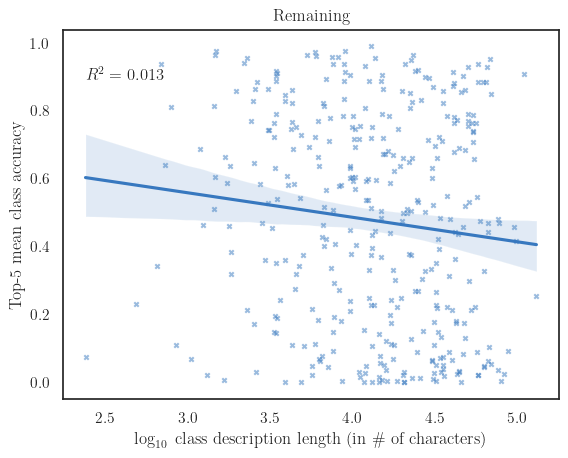

In [19]:
plt.title('Remaining')
plot_fig(df, 'other', save='class_accuracy_vs_description_length_other')

In [21]:
import tensorflow as tf
tf.print("Average Accuracy of all classes - Glove: ",
         100*albert_results['test_unseen_top5_acc_mean_allclasses'])

Average Accuracy of all classes - Glove:  45.0548553
